In [4]:
import autograd.numpy as np
from autograd.numpy import linalg
from autograd.numpy.random import poisson, normal, multivariate_normal
from autograd import grad
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
import emcee as mc
import george as ge
from george.metrics import Metric

def neg_log_like_PGP(mu, s, ni, y, cov, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    det = linalg.det(cov)
    t1 = -(N/2.)*np.log(2.*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (y-mu)[np.newaxis]
    t2 = (-(1./2) * np.dot(np.dot(resid,invcov),resid.T))[0][0]
    t3 = np.sum(ni * np.log(mu + s) - (mu + s))
    result =  t2 + t3# + t1
    print("result: " + str(result) + "\tt2%: " + str(100*np.abs(t2/result)) + "%\tt3%: " + str(100*np.abs(t3/result)) +"%")
    #if t1-t2==t1 or t1-t3==t1:
       # result-=t1
    return -result               
    
neg_log_like_PGP_grad = grad(neg_log_like_PGP)


def true_mu(x):
    return (1./np.log(1.5*x+1))

def y_model(x):
    return 1./(np.power(x+.3,2))

def y_opt(x, params):
    a, b, c, d = params
    return ((1.*a)/(np.power(b*x + c,2)))+d

def y_preopt(x, a, b, c, d):
        params = np.array([a,b,c,d])
        return y_opt(x, params)
    
class mean_model(object):
    def __init__(self, f, params):
        self.f = f
        self.params = params
        self.frozen = True
    def get_value(self, x):
        return self.f(x, self.params)
    def freeze_all_parameters(self):
        self.frozen = True


def kernel_func_exp(x1,x2, params):
    A = params[0]
    l = params[1]

    result = A * np.exp(-np.power((x1-x2),2)/(l**2))
    return result

def kernel_func_gibbs(x1,x2, params):
    A = params[0]
    a = params[1]
    b = params[2]
    c = params[3]
    d = params[4]
    result = A * np.exp(-(((x1-x2)**2)/(((b*x1 + c)**2)+((b*x2 + c)**2)))+((d-(x1+x2))/(2.*a)))
    return result

#expkernel = ge.kernels.PythonKernel(kernel_func_exp, pars= [5., .5])

def make_kernel(x, k, params):
    N = len(x)
    cov = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    return cov

def predict(t, n, y, cov, sigma):
    N = len(t)
    p_dist = np.empty(N)
    v_dist = np.empty(N)
    for i in range(N):
        inv = linalg.inv(cov+np.diag(np.power(sigma,2)))
        p_dist[i] = y[i] + cov[i].T.dot(inv.dot(n-y))
        v_dist[i] = cov[i][i] - cov[i].T.dot(inv.dot(cov[i]))
        if np.isnan(v_dist[i]):
            print ("NAN, cov diag = " + str(cov[i][i]) + "\t other term: " + str(cov[i].T.dot(inv.dot(cov[i]))))
    return p_dist, v_dist
            


In [30]:
#initialization
N = 30
scale = 5.
params_test = [10*scale, 6., .3, 0.]
t = np.linspace(.5, 10,N)
mu_test = scale* true_mu(t)

#generating poisson distributed data
n_test = poisson(mu_test)
n_err = np.sqrt(n_test)

#optimizing model parameters
popt, pcov = curve_fit(y_preopt, t, n_test, p0=[params_test])
params_test = popt
model_test = y_opt(t, params_test)
s_test = np.zeros(N)
#boundarray = [(n_test[i]-np.sqrt(n_test[i]),n_test[i]+np.sqrt(n_test[i])) for i in range(N)]
boundarray = [(1,None) for i in range(N)]

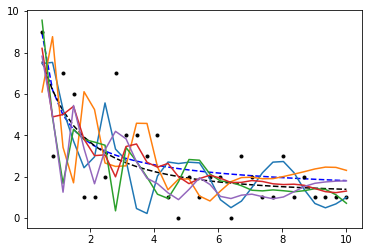

In [34]:
#cov_PGP = make_kernel(t, kernel_func_exp, [scale*1, 1.])
cov_PGP = make_kernel(t, kernel_func_gibbs, [1, 3., .1, 0., 10.])
plt.plot(t, mu_test,'b--', label = "True Mean")
plt.plot(t, n_test, 'k.', label = "counts")
plt.plot(t, model_test,'k--', label = "Mean")
for i in range(5):
    sample = np.random.multivariate_normal(model_test, cov_PGP)
    plt.plot(t, sample)
    
plt.show()
#n_test = sample

In [4]:
pred, pred_var = predict(t, n_test, model_test, cov_PGP, np.sqrt(n_test))
pred_unc = np.sqrt(pred_var)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


In [5]:
#PGP fit
#def neg_log_like_PGP(mu, s, ni, y, cov, invcov = None)
options={'ftol' :  np.finfo(float).eps, 'maxfun': 1.5e5, 'maxiter': 1.5e5, 'gtol': np.finfo(float).eps}
soln_PGP = minimize(neg_log_like_PGP, model_test,  method="L-BFGS-B", args = (s_test, n_test, model_test, cov_PGP), options = options, bounds = boundarray)
#jac = neg_log_like_PGP_grad,
PGP_fit = soln_PGP.x
PGP_fit_unc = np.sqrt(np.diag(soln_PGP.hess_inv.matmat(np.eye(N))))
print soln_PGP



result: 37.515523880704045	t2%: 0.0%	t3%: 100.0%
result: 37.515523880706795	t2%: 2.6026238600760804e-17%	t3%: 100.0%
result: 37.515523879445155	t2%: 2.916292270172127e-17%	t3%: 100.0%
result: 37.515523880336744	t2%: 3.267777783985811e-17%	t3%: 100.0%
result: 37.515523882287454	t2%: 3.6656202614971695e-17%	t3%: 100.0%
result: 37.51552390221163	t2%: 4.166828349310158e-17%	t3%: 100.0%
result: 37.51552387729425	t2%: 4.956539540658013e-17%	t3%: 100.0%
result: 37.515523884237105	t2%: 6.396251822271673e-17%	t3%: 100.0%
result: 37.51552388446632	t2%: 9.179425028544565e-17%	t3%: 100.0%
result: 37.515523870704044	t2%: 1.489815924325385e-16%	t3%: 100.0%
result: 37.515523884734435	t2%: 2.761442722191548e-16%	t3%: 100.0%
result: 37.51552388481644	t2%: 5.850587542437906e-16%	t3%: 100.0%
result: 37.515523877791246	t2%: 1.4054845469590068e-15%	t3%: 100.0%
result: 37.515523870704044	t2%: 3.773053706173386e-15%	t3%: 100.0%
result: 37.51552388496429	t2%: 1.1113744449697455e-14%	t3%: 100.00000000000003%
r

result: 37.57117965815691	t2%: 0.13400174242985302%	t3%: 100.13400174242986%
result: 37.571179465828116	t2%: 0.13400227425684702%	t3%: 100.13400227425684%
result: 37.571179647809934	t2%: 0.13400178925365686%	t3%: 100.13400178925365%
result: 37.5711795440732	t2%: 0.13400204648359454%	t3%: 100.1340020464836%
result: 37.573641870147284	t2%: 0.1390496099657608%	t3%: 100.13904960996575%
result: 37.573641870150034	t2%: 0.13904960996576196%	t3%: 100.13904960996575%
result: 37.573641868893105	t2%: 0.13904960996461507%	t3%: 100.1390496099646%
result: 37.573641869782044	t2%: 0.13904960996521165%	t3%: 100.13904960996523%
result: 37.57364187172053	t2%: 0.13904960996465404%	t3%: 100.13904960996467%
result: 37.57364189126778	t2%: 0.139049610030345%	t3%: 100.13904961003036%
result: 37.5736418667622	t2%: 0.13904960994368115%	t3%: 100.13904960994367%
result: 37.573641873671534	t2%: 0.13904960990830073%	t3%: 100.13904960990831%
result: 37.57364187376662	t2%: 0.13904961025815435%	t3%: 100.13904961025814%

result: 37.64882065133691	t2%: 0.4314001570061522%	t3%: 100.43140015700615%
result: 37.64882066633757	t2%: 0.4314000980726446%	t3%: 100.43140009807266%
result: 37.648820637291536	t2%: 0.4314002132515737%	t3%: 100.43140021325159%
result: 37.64882070262333	t2%: 0.4314000202780278%	t3%: 100.43140002027802%
result: 37.64882062506606	t2%: 0.4314002824319457%	t3%: 100.43140028243197%
result: 37.64882069939898	t2%: 0.4314000288709441%	t3%: 100.43140002887094%
result: 37.64882067427952	t2%: 0.43140011504027914%	t3%: 100.43140011504028%
result: 37.64882055768312	t2%: 0.4314003879175513%	t3%: 100.43140038791753%
result: 37.648820849075534	t2%: 0.431399610603752%	t3%: 100.43139961060375%
result: 37.648820330562394	t2%: 0.4314009937812213%	t3%: 100.43140099378122%
result: 37.648821174406976	t2%: 0.43139879939413106%	t3%: 100.43139879939413%
result: 37.64881989700671	t2%: 0.4314021880324672%	t3%: 100.43140218803246%
result: 37.6488217090319	t2%: 0.431397373523902%	t3%: 100.4313973735239%
result: 37

result: 37.66259550322867	t2%: 0.27636736948631113%	t3%: 100.27636736948631%
result: 37.662595506457194	t2%: 0.2763673610922529%	t3%: 100.27636736109224%
result: 37.662595492278314	t2%: 0.27636738048135406%	t3%: 100.27636738048133%
result: 37.66259550116826	t2%: 0.27636733791293483%	t3%: 100.27636733791294%
result: 37.66259548429713	t2%: 0.2763674205522233%	t3%: 100.27636742055222%
result: 37.662595528570435	t2%: 0.2763672839355353%	t3%: 100.27636728393551%
result: 37.662595480967525	t2%: 0.27636746623942876%	t3%: 100.27636746623942%
result: 37.66259552593901	t2%: 0.27636729093780554%	t3%: 100.27636729093781%
result: 37.662595502337396	t2%: 0.2763673729587058%	t3%: 100.2763673729587%
result: 37.662595464578956	t2%: 0.27636743533169356%	t3%: 100.27636743533168%
result: 37.66259551426063	t2%: 0.27636730305461776%	t3%: 100.27636730305463%
result: 37.662595513872084	t2%: 0.2763673040891236%	t3%: 100.2763673040891%
result: 37.662595422743	t2%: 0.2763676034362673%	t3%: 100.27636760343628%
re

result: 37.71018569364603	t2%: 0.42333883675770767%	t3%: 100.42333883675771%
result: 37.71018562016101	t2%: 0.4233389773887127%	t3%: 100.42333897738871%
result: 37.71018582770401	t2%: 0.4233384439868611%	t3%: 100.42333844398685%
result: 37.710185378535705	t2%: 0.4233396019550542%	t3%: 100.42333960195504%
result: 37.71018612211047	t2%: 0.42333762179348355%	t3%: 100.42333762179348%
result: 37.71018497209859	t2%: 0.4233406843091361%	t3%: 100.42334068430914%
result: 37.71018676237164	t2%: 0.42333597314554194%	t3%: 100.42333597314554%
result: 37.71018403688298	t2%: 0.42334321228398264%	t3%: 100.42334321228398%
result: 37.71018791808621	t2%: 0.4233328957897139%	t3%: 100.42333289578971%
result: 37.71018314851322	t2%: 0.42334555967611426%	t3%: 100.42334555967611%
result: 37.71018794641683	t2%: 0.42333278287583676%	t3%: 100.42333278287583%
result: 37.710184067269786	t2%: 0.42334309389509645%	t3%: 100.42334309389508%
result: 37.71018654082172	t2%: 0.4233365260218876%	t3%: 100.42333652602188%
res

result: 38.096554804104635	t2%: 1.4310358655791378%	t3%: 101.43103586557913%
result: 38.097863761293105	t2%: 1.4435447324783028%	t3%: 101.4435447324783%
result: 38.097863761295805	t2%: 1.4435447324783344%	t3%: 101.44354473247834%
result: 38.09786376009085	t2%: 1.4435447324552895%	t3%: 101.4435447324553%
result: 38.097863760950574	t2%: 1.443544732468768%	t3%: 101.44354473246877%
result: 38.09786376275508	t2%: 1.4435447324796564%	t3%: 101.44354473247965%
result: 38.097863778573874	t2%: 1.4435447335236415%	t3%: 101.44354473352364%
result: 38.097863758223966	t2%: 1.4435447320767896%	t3%: 101.4435447320768%
result: 38.097863764511864	t2%: 1.4435447323938337%	t3%: 101.44354473239386%
result: 38.09786376413468	t2%: 1.4435447339269871%	t3%: 101.44354473392698%
result: 38.09786375258989	t2%: 1.4435447294042603%	t3%: 101.44354472940427%
result: 38.09786376284668	t2%: 1.4435447379886117%	t3%: 101.4435447379886%
result: 38.09786376893827	t2%: 1.4435447218572575%	t3%: 101.44354472185726%
result: 38

result: 38.14116747580764	t2%: 1.280283409384251%	t3%: 101.28028340938424%
result: 38.141167437307494	t2%: 1.2802835628793723%	t3%: 101.28028356287938%
result: 38.141167416610564	t2%: 1.2802835663084795%	t3%: 101.28028356630847%
result: 38.14116755076988	t2%: 1.2802832299977267%	t3%: 101.28028322999774%
result: 38.141167251988534	t2%: 1.280283985270171%	t3%: 101.28028398527019%
result: 38.14116768906409	t2%: 1.2802828246571365%	t3%: 101.28028282465714%
result: 38.141167072495676	t2%: 1.280284461896587%	t3%: 101.28028446189658%
result: 38.14116799465366	t2%: 1.2802820674272626%	t3%: 101.28028206742728%
result: 38.141166780092014	t2%: 1.2802852734123111%	t3%: 101.2802852734123%
result: 38.141168002876256	t2%: 1.2802820458239605%	t3%: 101.28028204582398%
result: 38.14116723058458	t2%: 1.280284061160775%	t3%: 101.28028406116076%
result: 38.1411672933081	t2%: 1.2802838949557087%	t3%: 101.28028389495569%
result: 38.1411678497365	t2%: 1.2802823980066784%	t3%: 101.28028239800668%
result: 38.14

result: 38.61640329469462	t2%: 1.9056637814407522%	t3%: 101.90566378144075%
result: 38.61640219586191	t2%: 1.9056667007022883%	t3%: 101.90566670070228%
result: 38.61640281214981	t2%: 1.9056650743840928%	t3%: 101.9056650743841%
result: 38.61640263271353	t2%: 1.9056655283570287%	t3%: 101.90566552835702%
result: 27.54468566308243	t2%: 40.06079151090436%	t3%: 140.06079151090435%
result: 27.544685663085083	t2%: 40.06079151090082%	t3%: 140.06079151090083%
result: 27.544685661884348	t2%: 40.0607915125451%	t3%: 140.06079151254508%
result: 27.544685662741678	t2%: 40.06079151136653%	t3%: 140.06079151136652%
result: 27.54468566453555	t2%: 40.06079150887619%	t3%: 140.0607915088762%
result: 27.54468568013845	t2%: 40.06079148859899%	t3%: 140.06079148859897%
result: 27.544685660068886	t2%: 40.06079151440564%	t3%: 140.06079151440565%
result: 27.54468566611127	t2%: 40.060791507166385%	t3%: 140.06079150716639%
result: 27.54468566649104	t2%: 40.06079150597998%	t3%: 140.06079150597998%
result: 27.54468565

result: 38.71111609401225	t2%: 1.2970312515363953%	t3%: 101.2970312515364%
result: 38.711116013612575	t2%: 1.2970314425027958%	t3%: 101.2970314425028%
result: 38.71111616722116	t2%: 1.297031090280156%	t3%: 101.29703109028017%
result: 38.71111592031194	t2%: 1.297031686390939%	t3%: 101.29703168639095%
result: 38.71111625054208	t2%: 1.2970308425151176%	t3%: 101.29703084251511%
result: 38.711115871759326	t2%: 1.2970317961202438%	t3%: 101.29703179612024%
result: 38.71111621804269	t2%: 1.2970308899857614%	t3%: 101.29703088998576%
result: 38.71111585644236	t2%: 1.2970318362008162%	t3%: 101.29703183620083%
result: 38.711116423984855	t2%: 1.2970304036913267%	t3%: 101.29703040369131%
result: 38.7111155578582	t2%: 1.297032650926648%	t3%: 101.29703265092664%
result: 38.71111656530853	t2%: 1.2970300332239477%	t3%: 101.29703003322395%
result: 38.7111157806811	t2%: 1.2970320531159363%	t3%: 101.29703205311593%
result: 38.71111603140151	t2%: 1.2970313979565078%	t3%: 101.29703139795652%
result: 38.71111

result: 39.03863558582974	t2%: 3.2632149074149672%	t3%: 103.26321490741496%
result: 39.038645050240895	t2%: 3.26318987439431%	t3%: 103.26318987439431%
result: 39.03863659591801	t2%: 3.263212217142734%	t3%: 103.26321221714272%
result: 39.038642099425886	t2%: 3.263197679310201%	t3%: 103.26319767931021%
result: 39.03863960901172	t2%: 3.2632042668042907%	t3%: 103.26320426680428%
result: 39.03864036017394	t2%: 3.263202260106423%	t3%: 103.26320226010641%
result: 38.54863365452228	t2%: 5.691948318619032%	t3%: 105.69194831861904%
result: 38.548633654524835	t2%: 5.691948318619096%	t3%: 105.6919483186191%
result: 38.5486336534548	t2%: 5.691948318548643%	t3%: 105.69194831854864%
result: 38.548633654238344	t2%: 5.691948318586268%	t3%: 105.69194831858626%
result: 38.54863365571484	t2%: 5.691948318604742%	t3%: 105.69194831860473%
result: 38.54863366444677	t2%: 5.691948322745188%	t3%: 105.69194832274518%
result: 38.548633652334175	t2%: 5.691948317087167%	t3%: 105.69194831708715%
result: 38.5486336568

result: 39.25855443630016	t2%: 3.529742508725268%	t3%: 103.52974250872526%
result: 39.25855444089956	t2%: 3.5297425107214453%	t3%: 103.52974251072145%
result: 39.25855444025012	t2%: 3.5297425128297024%	t3%: 103.52974251282971%
result: 39.25855443019286	t2%: 3.529742506817156%	t3%: 103.52974250681714%
result: 39.25855444169004	t2%: 3.5297425095602026%	t3%: 103.5297425095602%
result: 39.258554436913286	t2%: 3.529742521830659%	t3%: 103.52974252183067%
result: 39.25855444403179	t2%: 3.5297424900974588%	t3%: 103.52974249009745%
result: 39.258554418996056	t2%: 3.529742536344519%	t3%: 103.5297425363445%
result: 39.25855445772639	t2%: 3.5297424708681775%	t3%: 103.52974247086819%
result: 39.25855440963508	t2%: 3.529742577581681%	t3%: 103.52974257758167%
result: 39.258554501789966	t2%: 3.5297423789571702%	t3%: 103.52974237895718%
result: 39.258554340726064	t2%: 3.529742758904001%	t3%: 103.529742758904%
result: 39.258554571417754	t2%: 3.5297421715835746%	t3%: 103.52974217158358%
result: 39.258554

result: 39.35437006404158	t2%: 3.7859146014121317%	t3%: 103.78591460141213%
result: 39.35436906799427	t2%: 3.7859172768608347%	t3%: 103.78591727686084%
result: 39.35437089361895	t2%: 3.7859124433946296%	t3%: 103.78591244339464%
result: 39.35436819391344	t2%: 3.7859195806624437%	t3%: 103.78591958066244%
result: 39.35437133080912	t2%: 3.785911278946634%	t3%: 103.78591127894663%
result: 39.35436852809552	t2%: 3.7859186724695153%	t3%: 103.7859186724695%
result: 39.35437052674297	t2%: 3.7859133811693537%	t3%: 103.78591338116937%
result: 39.35436936383889	t2%: 3.7859164679762665%	t3%: 103.78591646797626%
result: 39.354369775718666	t2%: 3.7859153816735334%	t3%: 103.78591538167355%
result: 39.35436980340558	t2%: 3.78591528876515%	t3%: 103.78591528876515%
result: 39.377211856501106	t2%: 3.5265079162802344%	t3%: 103.52650791628024%
result: 39.377211856503656	t2%: 3.526507916280439%	t3%: 103.52650791628044%
result: 39.377211855431945	t2%: 3.526507916154731%	t3%: 103.52650791615471%
result: 39.377

result: 39.40355034468704	t2%: 3.601419977683014%	t3%: 103.60141997768302%
result: 39.403550749627016	t2%: 3.6014189305589133%	t3%: 103.60141893055892%
result: 39.403550338938274	t2%: 3.601419981290947%	t3%: 103.60141998129096%
result: 39.403550818644334	t2%: 3.601418722160031%	t3%: 103.60141872216002%
result: 39.40355041224444	t2%: 3.6014197702981394%	t3%: 103.60141977029815%
result: 39.4035505780571	t2%: 3.601419354285087%	t3%: 103.60141935428508%
result: 39.4035504875409	t2%: 3.6014195921899446%	t3%: 103.60141959218994%
result: 39.40355062084961	t2%: 3.6014192218249517%	t3%: 103.60141922182495%
result: 39.40468292063881	t2%: 3.575078875460148%	t3%: 103.57507887546016%
result: 39.40468292064136	t2%: 3.5750788754603557%	t3%: 103.57507887546036%
result: 39.40468291957301	t2%: 3.575078875331851%	t3%: 103.57507887533184%
result: 39.40468292035566	t2%: 3.5750788754120495%	t3%: 103.57507887541206%
result: 39.404682921827465	t2%: 3.575078875513176%	t3%: 103.57507887551319%
result: 39.404682

result: 39.41358521570814	t2%: 3.662715073423823%	t3%: 103.66271507342381%
result: 39.413585036431286	t2%: 3.6627155250495798%	t3%: 103.66271552504958%
result: 39.42462555097128	t2%: 3.611450190043071%	t3%: 103.61145019004307%
result: 39.424625550973815	t2%: 3.6114501900432825%	t3%: 103.6114501900433%
result: 39.42462554990783	t2%: 3.611450189912884%	t3%: 103.61145018991287%
result: 39.42462555068914	t2%: 3.6114501899942897%	t3%: 103.61145018999429%
result: 39.42462555213843	t2%: 3.611450190141611%	t3%: 103.61145019014162%
result: 39.42462556069048	t2%: 3.6114501947670825%	t3%: 103.61145019476707%
result: 39.424625548788896	t2%: 3.6114501884443517%	t3%: 103.61145018844435%
result: 39.42462555328792	t2%: 3.6114501904421954%	t3%: 103.6114501904422%
result: 39.42462555233614	t2%: 3.6114501933259615%	t3%: 103.61145019332596%
result: 39.42462554324939	t2%: 3.6114501849720053%	t3%: 103.611450184972%
result: 39.42462555261716	t2%: 3.6114501930989777%	t3%: 103.61145019309896%
result: 39.424625

result: 40.2192540216707	t2%: 5.087832844469495%	t3%: 105.0878328444695%
result: 40.219253929889554	t2%: 5.087833044621147%	t3%: 105.08783304462115%
result: 40.21925408087324	t2%: 5.0878326712043425%	t3%: 105.08783267120434%
result: 40.21925386267094	t2%: 5.0878332055208055%	t3%: 105.08783320552082%
result: 40.21925406229274	t2%: 5.08783268393425%	t3%: 105.08783268393425%
result: 40.219254021792665	t2%: 5.087832789755831%	t3%: 105.08783278975584%
result: 40.21925376044878	t2%: 5.0878335171697655%	t3%: 105.08783351716977%
result: 40.219254512537866	t2%: 5.087831534377491%	t3%: 105.08783153437749%
result: 40.21925304072306	t2%: 5.087835396993752%	t3%: 105.08783539699375%
result: 40.21925528681067	t2%: 5.0878295020523145%	t3%: 105.08782950205232%
result: 40.2192524233519	t2%: 5.087836986921158%	t3%: 105.08783698692115%
result: 40.219255812438405	t2%: 5.0878281110247965%	t3%: 105.08782811102479%
result: 40.21925222198246	t2%: 5.087837513841743%	t3%: 105.08783751384175%
result: 40.219255064

result: 39.89423146878174	t2%: 6.769110812560683%	t3%: 106.76911081256068%
result: 39.89421575665219	t2%: 6.769152907212016%	t3%: 106.769152907212%
result: 39.89423900841369	t2%: 6.769090660895694%	t3%: 106.76909066089569%
result: 39.89420789992026	t2%: 6.769173933755514%	t3%: 106.76917393375551%
result: 39.89424449562847	t2%: 6.769075966412251%	t3%: 106.76907596641226%
result: 39.894207816409484	t2%: 6.76917413441195%	t3%: 106.76917413441195%
result: 39.89423824362015	t2%: 6.76909268103331%	t3%: 106.76909268103331%
result: 39.894218082607466	t2%: 6.769146660326611%	t3%: 106.76914666032661%
result: 39.894228106383146	t2%: 6.769119833104814%	t3%: 106.76911983310482%
result: 39.89422479773458	t2%: 6.769128666317155%	t3%: 106.76912866631713%
result: 40.4774905115324	t2%: 5.008483531715662%	t3%: 105.00848353171565%
result: 40.47749051153482	t2%: 5.0084835317160685%	t3%: 105.00848353171605%
result: 40.477490510594784	t2%: 5.008483531468791%	t3%: 105.00848353146878%
result: 40.47749051130433

result: 40.53794578574363	t2%: 5.108656177272975%	t3%: 105.10865617727296%
result: 40.53794597848601	t2%: 5.108655699363801%	t3%: 105.10865569936378%
result: 40.53794587641629	t2%: 5.108655963475092%	t3%: 105.1086559634751%
result: 40.53794591459236	t2%: 5.108655843188034%	t3%: 105.10865584318803%
result: -6.054004896089893	t2%: 807.2909441899008%	t3%: 707.2909441899009%
result: -6.054004896087477	t2%: 807.290944190228%	t3%: 707.290944190228%
result: -6.054004896998762	t2%: 807.2909440660636%	t3%: 707.2909440660637%
result: -6.054004896305187	t2%: 807.2909441603258%	t3%: 707.2909441603257%
result: -6.0540048952192365	t2%: 807.2909443081489%	t3%: 707.2909443081489%
result: -6.054004892183528	t2%: 807.2909447750937%	t3%: 707.2909447750939%
result: -6.05400489734312	t2%: 807.2909440033255%	t3%: 707.2909440033254%
result: -6.054004894249701	t2%: 807.2909444361823%	t3%: 707.2909444361823%
result: -6.054004897791515	t2%: 807.2909440242759%	t3%: 707.2909440242759%
result: -6.054004898059205	t

result: 40.565363679500535	t2%: 4.983688035169984%	t3%: 104.98368803516999%
result: 40.56536369100442	t2%: 4.9836879963847425%	t3%: 104.98368799638473%
result: 40.56536366746665	t2%: 4.983688036651123%	t3%: 104.98368803665113%
result: 40.565363685973665	t2%: 4.983688024865427%	t3%: 104.98368802486544%
result: 40.565363703362436	t2%: 4.98368795848444%	t3%: 104.98368795848445%
result: 40.565363637831126	t2%: 4.9836881663458215%	t3%: 104.98368816634583%
result: 40.56536375375036	t2%: 4.983687827792971%	t3%: 104.98368782779298%
result: 40.56536361169483	t2%: 4.983688216221605%	t3%: 104.9836882162216%
result: 40.5653637186807	t2%: 4.98368790410849%	t3%: 104.98368790410848%
result: 40.565363678423246	t2%: 4.983688008295306%	t3%: 104.98368800829529%
result: 40.56536362539194	t2%: 4.983688145541019%	t3%: 104.98368814554102%
result: 40.56536384710846	t2%: 4.9836876151808385%	t3%: 104.98368761518084%
result: 40.56536339662499	t2%: 4.983688763874637%	t3%: 104.98368876387465%
result: 40.5653640113

result: 40.6508546815889	t2%: 4.354049773932609%	t3%: 104.35404977393262%
result: 40.65085471665633	t2%: 4.354049727569839%	t3%: 104.35404972756986%
result: 40.65085477663034	t2%: 4.354049556645652%	t3%: 104.35404955664565%
result: 40.65085456671299	t2%: 4.354050112293633%	t3%: 104.35405011229363%
result: 40.650854933442204	t2%: 4.354049144629048%	t3%: 104.35404914462904%
result: 40.65085451633252	t2%: 4.354050218359216%	t3%: 104.35405021835922%
result: 40.65085493104346	t2%: 4.354049133562461%	t3%: 104.35404913356246%
result: 40.65085451296214	t2%: 4.354050228590376%	t3%: 104.35405022859037%
result: 40.65085484025411	t2%: 4.354049387770174%	t3%: 104.35404938777017%
result: 40.65085468659429	t2%: 4.354049761083353%	t3%: 104.35404976108333%
result: 40.652537066166865	t2%: 4.356581009016978%	t3%: 104.35658100901696%
result: 40.652537066169266	t2%: 4.356581009017411%	t3%: 104.35658100901742%
result: 40.6525370652212	t2%: 4.356581008765951%	t3%: 104.35658100876594%
result: 40.6525370659355

result: 40.67251989892646	t2%: 4.291902028675058%	t3%: 104.29190202867507%
result: 40.67251990200791	t2%: 4.291902032072549%	t3%: 104.29190203207254%
result: 40.672519900483024	t2%: 4.29190203629328%	t3%: 104.29190203629328%
result: 40.67251989361636	t2%: 4.291902023968697%	t3%: 104.2919020239687%
result: 40.672519902722726	t2%: 4.291902030969794%	t3%: 104.29190203096981%
result: 40.67251989456397	t2%: 4.291902051325715%	t3%: 104.2919020513257%
result: 40.672519912762965	t2%: 4.291901995303405%	t3%: 104.2919019953034%
result: 40.67251987319975	t2%: 4.291902076320682%	t3%: 104.29190207632068%
result: 40.67251992529549	t2%: 4.291901978855425%	t3%: 104.2919019788554%
result: 40.67251988145422	t2%: 4.291902069863729%	t3%: 104.29190206986374%
result: 40.672519913629465	t2%: 4.2919020264629335%	t3%: 104.29190202646292%
result: 40.67251989361686	t2%: 4.291902038455582%	t3%: 104.29190203845558%
result: 40.67251992177931	t2%: 4.291901986719429%	t3%: 104.29190198671942%
result: 40.67251983381687

result: 40.679012117739106	t2%: 4.229847359092881%	t3%: 104.22984735909289%
result: 40.67901223996338	t2%: 4.229847024787061%	t3%: 104.22984702478706%
result: 40.68032403831939	t2%: 4.202728322522833%	t3%: 104.20272832252284%
result: 40.68032403832184	t2%: 4.202728322523265%	t3%: 104.20272832252326%
result: 40.68032403737141	t2%: 4.202728322271225%	t3%: 104.20272832227123%
result: 40.68032403808703	t2%: 4.202728322432482%	t3%: 104.20272832243249%
result: 40.68032403926714	t2%: 4.202728322707251%	t3%: 104.20272832270724%
result: 40.680324043581635	t2%: 4.20272833047983%	t3%: 104.20272833047983%
result: 40.680324036874005	t2%: 4.202728319944169%	t3%: 104.20272831994417%
result: 40.680324040011314	t2%: 4.202728323247074%	t3%: 104.20272832324709%
result: 40.68032403848803	t2%: 4.202728327463259%	t3%: 104.20272832746326%
result: 40.68032403160651	t2%: 4.202728315135999%	t3%: 104.202728315136%
result: 40.68032404066399	t2%: 4.202728322309659%	t3%: 104.20272832230965%
result: 40.6803240327346

result: 40.609144775111574	t2%: 4.550176801266409%	t3%: 104.55017680126642%
result: 40.609144768595606	t2%: 4.550176817480535%	t3%: 104.55017681748053%
result: 40.60914478277981	t2%: 4.550176771652025%	t3%: 104.55017677165203%
result: 40.60914475283486	t2%: 4.550176828261762%	t3%: 104.55017682826175%
result: 40.6091447827625	t2%: 4.5501767873546175%	t3%: 104.55017678735463%
result: 40.60914478936141	t2%: 4.550176748936036%	t3%: 104.55017674893602%
result: 40.60914470763714	t2%: 4.550176998396427%	t3%: 104.55017699839641%
result: 40.60914493959919	t2%: 4.550176361894701%	t3%: 104.55017636189471%
result: 40.60914443101386	t2%: 4.550177691869848%	t3%: 104.55017769186985%
result: 40.60914542643826	t2%: 4.550175094037765%	t3%: 104.55017509403777%
result: 40.60914351876494	t2%: 4.550180005433624%	t3%: 104.55018000543363%
result: 40.60914700409833	t2%: 4.550171032277079%	t3%: 104.55017103227706%
result: 40.60914115569112	t2%: 4.5501861329691975%	t3%: 104.55018613296917%
result: 40.60915007195

result: 40.73775686686446	t2%: 4.242492234987857%	t3%: 104.24249223498785%
result: 40.73775678759929	t2%: 4.242492458418954%	t3%: 104.24249245841897%
result: 40.737756795496445	t2%: 4.242492403173944%	t3%: 104.24249240317396%
result: 40.73775687897421	t2%: 4.24249218956548%	t3%: 104.24249218956547%
result: 40.737756744680716	t2%: 4.242492533204633%	t3%: 104.24249253320464%
result: 40.73775689121714	t2%: 4.242492201840276%	t3%: 104.24249220184028%
result: 40.73775675504733	t2%: 4.24249253331371%	t3%: 104.24249253331372%
result: 40.73775679860276	t2%: 4.242492438506537%	t3%: 104.24249243850655%
result: 40.73775695677406	t2%: 4.242492007625077%	t3%: 104.24249200762507%
result: 40.7377565869962	t2%: 4.242492956864005%	t3%: 104.24249295686401%
result: 40.737757108293465	t2%: 4.242491602768057%	t3%: 104.24249160276806%
result: 40.73775658188887	t2%: 4.242492971572275%	t3%: 104.24249297157229%
result: 40.73775691172249	t2%: 4.242492126888036%	t3%: 104.24249212688804%
result: 40.73775680668231

result: 40.855628914866195	t2%: 3.7588244560429587%	t3%: 103.75882445604296%
result: 40.855638794477564	t2%: 3.758799368306842%	t3%: 103.75879936830682%
result: 40.85562984121211	t2%: 3.7588220865414854%	t3%: 103.75882208654149%
result: 40.85563598202803	t2%: 3.758806512980882%	t3%: 103.75880651298088%
result: 40.855632948747214	t2%: 3.758814215626289%	t3%: 103.75881421562627%
result: 40.85563391679677	t2%: 3.7588117360017104%	t3%: 103.7588117360017%
result: 40.92958464577518	t2%: 3.5239675749318398%	t3%: 103.52396757493183%
result: 40.92958464577758	t2%: 3.5239675749323234%	t3%: 103.52396757493231%
result: 40.92958464483075	t2%: 3.5239675746618%	t3%: 103.5239675746618%
result: 40.929584645543834	t2%: 3.5239675748372288%	t3%: 103.52396757483724%
result: 40.92958464671839	t2%: 3.523967575134547%	t3%: 103.52396757513456%
result: 40.92958465110143	t2%: 3.523967582857618%	t3%: 103.52396758285762%
result: 40.92958464433029	t2%: 3.5239675723456014%	t3%: 103.52396757234558%
result: 40.9295846

result: 41.02567997469108	t2%: 3.352392800379536%	t3%: 103.35239280037953%
result: 41.02567998182913	t2%: 3.352392762399164%	t3%: 103.35239276239916%
result: 41.02567997653725	t2%: 3.352392814533753%	t3%: 103.35239281453374%
result: 41.025679976670496	t2%: 3.352392774746306%	t3%: 103.3523927747463%
result: 41.025679974516315	t2%: 3.3523928013565385%	t3%: 103.35239280135656%
result: 41.025679979441364	t2%: 3.352392753627398%	t3%: 103.3523927536274%
result: 41.025679917588754	t2%: 3.35239290944725%	t3%: 103.35239290944725%
result: 41.025680164564164	t2%: 3.3523922872637812%	t3%: 103.35239228726378%
result: 41.02567953459566	t2%: 3.3523939183528833%	t3%: 103.35239391835289%
result: 41.02568077126132	t2%: 3.3523907859076747%	t3%: 103.35239078590767%
result: 41.02567878857129	t2%: 3.352395796888917%	t3%: 103.35239579688891%
result: 41.025681364472106	t2%: 3.3523892812064275%	t3%: 103.35238928120643%
result: 41.025678767392264	t2%: 3.3523958267262044%	t3%: 103.3523958267262%
result: 41.02568

result: 41.06064915933622	t2%: 3.367107655811677%	t3%: 103.36710765581168%
result: 41.06064909162186	t2%: 3.3671078293026633%	t3%: 103.36710782930267%
result: 41.060649006742324	t2%: 3.3671080232821047%	t3%: 103.3671080232821%
result: 41.06064924469426	t2%: 3.367107446386753%	t3%: 103.36710744638675%
result: 41.06064896723796	t2%: 3.3671081439358845%	t3%: 103.36710814393588%
result: 41.06064912954375	t2%: 3.3671077141387182%	t3%: 103.36710771413873%
result: 41.06107818602157	t2%: 3.366607880468568%	t3%: 103.36660788046856%
result: 41.06107818602396	t2%: 3.366607880469083%	t3%: 103.3666078804691%
result: 41.06107818508705	t2%: 3.3666078801840484%	t3%: 103.36660788018406%
result: 41.061078185794244	t2%: 3.3666078803697%	t3%: 103.36660788036968%
result: 41.06107818693005	t2%: 3.3666078807266633%	t3%: 103.36660788072666%
result: 41.061078191086565	t2%: 3.3666078886194986%	t3%: 103.36660788861951%
result: 41.06107818461481	t2%: 3.3666078778505653%	t3%: 103.36660787785057%
result: 41.0610781

result: 41.0655345124221	t2%: 3.3662880899228482%	t3%: 103.36628808992285%
result: 41.06553451655057	t2%: 3.3662881094967503%	t3%: 103.36628810949675%
result: 41.06553451968641	t2%: 3.3662881013730535%	t3%: 103.36628810137304%
result: 41.06553451512445	t2%: 3.3662881029039373%	t3%: 103.36628810290394%
result: 41.06553451394209	t2%: 3.366288086096894%	t3%: 103.36628808609689%
result: 41.065534514004234	t2%: 3.3662881204852475%	t3%: 103.36628812048525%
result: 41.065534521003016	t2%: 3.366288083100054%	t3%: 103.36628808310005%
result: 41.065534525918515	t2%: 3.3662881093720585%	t3%: 103.36628810937205%
result: 41.06553450309406	t2%: 3.366288127419465%	t3%: 103.36628812741947%
result: 41.06553453604295	t2%: 3.3662880659634196%	t3%: 103.36628806596342%
result: 41.065534478007066	t2%: 3.3662881765491455%	t3%: 103.36628817654913%
result: 41.065534583315646	t2%: 3.3662879114763227%	t3%: 103.36628791147633%
result: 41.06553438792213	t2%: 3.3662884033024523%	t3%: 103.36628840330245%
result: 41.

result: 41.080174642661206	t2%: 3.5313300012270155%	t3%: 103.53133000122703%
result: 41.08017464266359	t2%: 3.5313300012275435%	t3%: 103.53133000122754%
result: 41.08017464173644	t2%: 3.5313300009348%	t3%: 103.5313300009348%
result: 41.0801746424379	t2%: 3.531330001125405%	t3%: 103.5313300011254%
result: 41.08017464356335	t2%: 3.5313300014620306%	t3%: 103.53133000146202%
result: 41.08017464744477	t2%: 3.5313300096083284%	t3%: 103.53133000960833%
result: 41.08017464130011	t2%: 3.5313299985651887%	t3%: 103.53132999856518%
result: 41.08017464436144	t2%: 3.5313300017684277%	t3%: 103.53133000176842%
result: 41.08017464215175	t2%: 3.5313300077311807%	t3%: 103.53133000773119%
result: 41.08017463764498	t2%: 3.5313299895263897%	t3%: 103.53132998952638%
result: 41.080174640972395	t2%: 3.5313300110185075%	t3%: 103.53133001101851%
result: 41.08017464563857	t2%: 3.5313299990277804%	t3%: 103.53132999902776%
result: 41.08017463786483	t2%: 3.5313300087856243%	t3%: 103.53133000878563%
result: 41.080174

result: 41.09114834189213	t2%: 3.6987090351206007%	t3%: 103.6987090351206%
result: 41.091389181406264	t2%: 3.7127360221172205%	t3%: 103.71273602211721%
result: 41.09138918140863	t2%: 3.7127360221177574%	t3%: 103.71273602211775%
result: 41.09138918049005	t2%: 3.7127360218189924%	t3%: 103.71273602181898%
result: 41.09138918118657	t2%: 3.712736022013284%	t3%: 103.71273602201327%
result: 41.09138918230336	t2%: 3.7127360223290355%	t3%: 103.71273602232904%
result: 41.091389185934105	t2%: 3.7127360306785047%	t3%: 103.7127360306785%
result: 41.09138918011344	t2%: 3.712736019351108%	t3%: 103.71273601935111%
result: 41.091389183039965	t2%: 3.7127360227364097%	t3%: 103.71273602273641%
result: 41.09138918088728	t2%: 3.7127360285685937%	t3%: 103.71273602856861%
result: 41.09138917641769	t2%: 3.712736010372121%	t3%: 103.71273601037213%
result: 41.09138917982002	t2%: 3.7127360315829487%	t3%: 103.71273603158295%
result: 41.09138918393015	t2%: 3.7127360209280917%	t3%: 103.71273602092808%
result: 41.091

result: 41.110012081474224	t2%: 3.9352957098723147%	t3%: 103.93529570987229%
result: 41.11001342658104	t2%: 3.9352923316027506%	t3%: 103.93529233160275%
result: 41.11001240107959	t2%: 3.9352949234323384%	t3%: 103.93529492343234%
result: 41.110012891582656	t2%: 3.935293661737233%	t3%: 103.93529366173723%
result: 41.113027230836146	t2%: 3.92514464443354%	t3%: 103.92514464443354%
result: 41.113027230838505	t2%: 3.9251446444340967%	t3%: 103.9251446444341%
result: 41.113027229933124	t2%: 3.925144644124449%	t3%: 103.92514464412446%
result: 41.11302723062181	t2%: 3.925144644325825%	t3%: 103.92514464432583%
result: 41.11302723172288	t2%: 3.9251446446202953%	t3%: 103.9251446446203%
result: 41.113027235037926	t2%: 3.9251446532460563%	t3%: 103.92514465324606%
result: 41.113027229625544	t2%: 3.9251446415522264%	t3%: 103.92514464155222%
result: 41.11302723242761	t2%: 3.9251446450360383%	t3%: 103.92514464503604%
result: 41.11302723012223	t2%: 3.925144651292684%	t3%: 103.9251446512927%
result: 41.113

result: 41.1425618400679	t2%: 4.331957844515346%	t3%: 104.33195784451534%
result: 41.14256183764303	t2%: 4.3319578511491335%	t3%: 104.33195785114913%
result: 41.14256183437673	t2%: 4.331957830238454%	t3%: 104.33195783023845%
result: 41.14256183565823	t2%: 4.3319578564869605%	t3%: 104.33195785648697%
result: 41.14256184323111	t2%: 4.331957836955863%	t3%: 104.33195783695585%
result: 41.14256182992891	t2%: 4.331957861590297%	t3%: 104.33195786159028%
result: 41.14256184652073	t2%: 4.331957799442909%	t3%: 104.3319577994429%
result: 41.142561818547485	t2%: 4.331957904607153%	t3%: 104.33195790460717%
result: 41.14256185895256	t2%: 4.33195778243156%	t3%: 104.33195778243156%
result: 41.14256183563225	t2%: 4.331957878347696%	t3%: 104.33195787834771%
result: 41.14256182077069	t2%: 4.331957878411381%	t3%: 104.33195787841139%
result: 41.142561860665495	t2%: 4.331957799881455%	t3%: 104.33195779988145%
result: 41.14256182708938	t2%: 4.331957848718164%	t3%: 104.33195784871818%
result: 41.1425618178538

result: 41.14527563445945	t2%: 4.27952741573782%	t3%: 104.27952741573783%
result: 41.14527633469932	t2%: 4.279525644335727%	t3%: 104.27952564433573%
result: 41.145275692409356	t2%: 4.279527252375677%	t3%: 104.27952725237566%
result: 41.14527613290508	t2%: 4.2795261587903815%	t3%: 104.27952615879038%
result: 41.1452758874319	t2%: 4.2795267800652805%	t3%: 104.2795267800653%
result: 41.145275988934095	t2%: 4.2795265008565915%	t3%: 104.27952650085659%
result: 41.14754042198214	t2%: 4.239383919508021%	t3%: 104.23938391950801%
result: 41.14754042198449	t2%: 4.239383919508611%	t3%: 104.23938391950863%
result: 41.14754042110116	t2%: 4.239383919179678%	t3%: 104.23938391917969%
result: 41.14754042177674	t2%: 4.2393839193936875%	t3%: 104.23938391939369%
result: 41.1475404228165	t2%: 4.23938391974366%	t3%: 104.23938391974367%
result: 41.14754042562976	t2%: 4.239383928813698%	t3%: 104.23938392881371%
result: 41.14754042090512	t2%: 4.239383916441786%	t3%: 104.23938391644178%
result: 41.1475404235221

result: 40.837829080170565	t2%: 5.173706642498092%	t3%: 105.17370664249808%
result: 40.837829076391515	t2%: 5.173706622836884%	t3%: 105.17370662283689%
result: 40.83782907935333	t2%: 5.173706644913328%	t3%: 105.17370664491335%
result: 40.83782908220276	t2%: 5.1737066372218905%	t3%: 105.17370663722187%
result: 40.83782908085729	t2%: 5.173706631588615%	t3%: 105.1737066315886%
result: 40.8378290689534	t2%: 5.173706641993006%	t3%: 105.17370664199302%
result: 40.83782910642691	t2%: 5.173706580016186%	t3%: 105.17370658001617%
result: 40.83782900226373	t2%: 5.173706828313374%	t3%: 105.17370682831337%
result: 40.83782928554257	t2%: 5.1737061358404235%	t3%: 105.17370613584043%
result: 40.83782864439305	t2%: 5.173707749140699%	t3%: 105.1737077491407%
result: 40.83782991654954	t2%: 5.1737044957989164%	t3%: 105.1737044957989%
result: 40.83782755717364	t2%: 5.173710535429318%	t3%: 105.17371053542932%
result: 40.837831724023005	t2%: 5.173699804129675%	t3%: 105.17369980412967%
result: 40.837824712995

result: 41.17139929655369	t2%: 4.266140832579909%	t3%: 104.26614083257991%
result: 41.17139929331197	t2%: 4.266140811609591%	t3%: 104.26614081160959%
result: 41.171399294846424	t2%: 4.266140837212828%	t3%: 104.26614083721284%
result: 41.1713993014493	t2%: 4.266140820146714%	t3%: 104.26614082014672%
result: 41.171399290618	t2%: 4.266140838502468%	t3%: 104.26614083850245%
result: 41.17139930183078	t2%: 4.266140790035795%	t3%: 104.26614079003578%
result: 41.171399284128235	t2%: 4.26614086913808%	t3%: 104.26614086913808%
result: 41.17139930777663	t2%: 4.266140789447684%	t3%: 104.26614078944768%
result: 41.17139930681742	t2%: 4.266140828751387%	t3%: 104.26614082875139%
result: 41.171399269294845	t2%: 4.266140886082711%	t3%: 104.26614088608271%
result: 41.17139932449556	t2%: 4.266140768966386%	t3%: 104.26614076896638%
result: 41.17139928467134	t2%: 4.266140833491904%	t3%: 104.2661408334919%
result: 41.171399286130864	t2%: 4.266140829795673%	t3%: 104.26614082979566%
result: 41.17139928715774	

result: 41.180099400433946	t2%: 4.222374310354776%	t3%: 104.22237431035477%
result: 41.18009939235278	t2%: 4.222374365187538%	t3%: 104.22237436518755%
result: 41.18009940351123	t2%: 4.222374317011442%	t3%: 104.22237431701144%
result: 41.18009941476398	t2%: 4.222374325502443%	t3%: 104.22237432550246%
result: 41.18009937071633	t2%: 4.22237439922994%	t3%: 104.22237439922995%
result: 41.18009942142438	t2%: 4.2223742934786985%	t3%: 104.2223742934787%
result: 41.180099399360614	t2%: 4.222374313071258%	t3%: 104.22237431307127%
result: 41.180099369362225	t2%: 4.222374388993939%	t3%: 104.22237438899393%
result: 41.18009941989023	t2%: 4.222374261113016%	t3%: 104.22237426111303%
result: 41.18009940650483	t2%: 4.222374338698754%	t3%: 104.22237433869874%
result: 41.180099368671065	t2%: 4.222374417260802%	t3%: 104.22237441726081%
result: 41.180099417834306	t2%: 4.222374308479806%	t3%: 104.2223743084798%
result: 41.18009934720315	t2%: 4.222374461592366%	t3%: 104.22237446159237%
result: 41.18009952656

result: 41.20707087592841	t2%: 4.236838324327169%	t3%: 104.23683832432715%
result: 41.2070708750506	t2%: 4.236838323992038%	t3%: 104.23683832399205%
result: 41.20707087572291	t2%: 4.236838324210283%	t3%: 104.23683832421027%
result: 41.207070876749945	t2%: 4.236838324568881%	t3%: 104.2368383245689%
result: 41.20707087943474	t2%: 4.236838333743473%	t3%: 104.23683833374346%
result: 41.20707087487152	t2%: 4.236838321244747%	t3%: 104.23683832124475%
result: 41.207070877413024	t2%: 4.2368383249434896%	t3%: 104.2368383249435%
result: 41.20707087495684	t2%: 4.236838331648699%	t3%: 104.2368383316487%
result: 41.20707087166083	t2%: 4.236838310848156%	t3%: 104.23683831084816%
result: 41.207070873306606	t2%: 4.236838336141205%	t3%: 104.23683833614122%
result: 41.20707087966837	t2%: 4.236838319665557%	t3%: 104.23683831966557%
result: 41.2070708690549	t2%: 4.2368383375577325%	t3%: 104.23683833755774%
result: 41.20707088122252	t2%: 4.236838286661036%	t3%: 104.23683828666104%
result: 41.20707085842724

result: 41.09916588912549	t2%: 4.378232188400827%	t3%: 104.37823218840083%
result: 41.09918830965902	t2%: 4.378175221643789%	t3%: 104.37817522164379%
result: 41.09916449815377	t2%: 4.37823569804027%	t3%: 104.37823569804027%
result: 41.099185511090674	t2%: 4.378182312546574%	t3%: 104.37818231254656%
result: 41.0991708120339	t2%: 4.378219666163911%	t3%: 104.37821966616391%
result: 41.099178407472465	t2%: 4.378200375467038%	t3%: 104.37820037546703%
result: 41.09917583623725	t2%: 4.3782068834435295%	t3%: 104.37820688344353%
result: 41.24053799892516	t2%: 4.079201836413343%	t3%: 104.07920183641335%
result: 41.240537998927515	t2%: 4.079201836413945%	t3%: 104.07920183641394%
result: 41.240537998047195	t2%: 4.0792018360787266%	t3%: 104.07920183607872%
result: 41.24053799872084	t2%: 4.079201836297468%	t3%: 104.07920183629746%
result: 41.24053799975412	t2%: 4.079201836656193%	t3%: 104.0792018366562%
result: 41.24053800255609	t2%: 4.079201845701314%	t3%: 104.07920184570132%
result: 41.24053799783

result: 41.25570157355281	t2%: 3.9611653722428897%	t3%: 103.96116537224289%
result: 41.25570157620539	t2%: 3.961165375801518%	t3%: 103.96116537580151%
result: 41.255701573861145	t2%: 3.961165382206703%	t3%: 103.9611653822067%
result: 41.25570157017194	t2%: 3.9611653623227063%	t3%: 103.96116536232272%
result: 41.25570157278454	t2%: 3.9611653852576136%	t3%: 103.96116538525762%
result: 41.25570157698795	t2%: 3.961165374235249%	t3%: 103.96116537423525%
result: 41.255701570887155	t2%: 3.961165380617721%	t3%: 103.96116538061773%
result: 41.25570157445868	t2%: 3.961165351520437%	t3%: 103.96116535152045%
result: 41.25570156521847	t2%: 3.9611654093511257%	t3%: 103.96116540935112%
result: 41.25570158720891	t2%: 3.961165333779733%	t3%: 103.96116533377973%
result: 41.25570156914258	t2%: 3.961165416363304%	t3%: 103.96116541636331%
result: 41.25570157483064	t2%: 3.9611653643365203%	t3%: 103.96116536433652%
result: 41.25570157190356	t2%: 3.9611653939180895%	t3%: 103.9611653939181%
result: 41.25570157

result: 41.25802233007756	t2%: 3.9792083862568615%	t3%: 103.97920838625687%
result: 41.25802239357439	t2%: 3.9792082490453184%	t3%: 103.97920824904531%
result: 41.258022279093595	t2%: 3.9792085367547774%	t3%: 103.97920853675477%
result: 41.258022341058485	t2%: 3.979208358582538%	t3%: 103.97920835858254%
result: 41.258958010263704	t2%: 3.9684232173187435%	t3%: 103.96842321731874%
result: 41.25895801026604	t2%: 3.96842321731935%	t3%: 103.96842321731934%
result: 41.258958009383306	t2%: 3.9684232169848075%	t3%: 103.9684232169848%
result: 41.25895801005831	t2%: 3.968423217203359%	t3%: 103.96842321720337%
result: 41.258958011076565	t2%: 3.968423217613535%	t3%: 103.96842321761352%
result: 41.25895801396415	t2%: 3.968423226569695%	t3%: 103.9684232265697%
result: 41.25895800914052	t2%: 3.9684232143629434%	t3%: 103.96842321436294%
result: 41.25895801177177	t2%: 3.9684232179438736%	t3%: 103.96842321794388%
result: 41.258958009420866	t2%: 3.9684232243785416%	t3%: 103.96842322437854%
result: 41.258

result: 41.266272750553604	t2%: 3.929336298683847%	t3%: 103.92933629868384%
result: 41.266272703412874	t2%: 3.9293363978619906%	t3%: 103.92933639786199%
result: 41.266272804137785	t2%: 3.92933616699535%	t3%: 103.92933616699536%
result: 41.266272704396464	t2%: 3.9293364174142074%	t3%: 103.92933641741419%
result: 41.266272741626835	t2%: 3.929336301619911%	t3%: 103.92933630161991%
result: 41.26630812135293	t2%: 3.9275938872173115%	t3%: 103.92759388721731%
result: 41.26630812135529	t2%: 3.9275938872179195%	t3%: 103.92759388721791%
result: 41.266308120472736	t2%: 3.927593886882325%	t3%: 103.9275938868823%
result: 41.266308121147574	t2%: 3.927593887101711%	t3%: 103.92759388710171%
result: 41.26630812219019	t2%: 3.9275938874511405%	t3%: 103.92759388745114%
result: 41.26630812505668	t2%: 3.9275938964724033%	t3%: 103.92759389647239%
result: 41.26630812025396	t2%: 3.927593884199143%	t3%: 103.92759388419914%
result: 41.26630812285191	t2%: 3.9275938878665797%	t3%: 103.92759388786656%
result: 41.26

result: 41.26865841591962	t2%: 3.9353268296508115%	t3%: 103.9353268296508%
result: 41.26865841113109	t2%: 3.93532681739007%	t3%: 103.93532681739006%
result: 41.26865841372135	t2%: 3.935326821061211%	t3%: 103.93532682106121%
result: 41.26865841143377	t2%: 3.9353268273417945%	t3%: 103.93532682734178%
result: 41.26865840762925	t2%: 3.9353268077570642%	t3%: 103.93532680775705%
result: 41.26865841053049	t2%: 3.935326829966818%	t3%: 103.9353268299668%
result: 41.26865841408947	t2%: 3.935326820523491%	t3%: 103.93532682052349%
result: 41.26865840914125	t2%: 3.935326824095636%	t3%: 103.93532682409563%
result: 41.268658411123724	t2%: 3.9353267989562215%	t3%: 103.93532679895623%
result: 41.26865840326407	t2%: 3.9353268534115853%	t3%: 103.93532685341158%
result: 41.2686584258893	t2%: 3.9353267761049424%	t3%: 103.93532677610496%
result: 41.26865840323989	t2%: 3.9353268701469437%	t3%: 103.93532687014692%
result: 41.268658414307666	t2%: 3.9353268047202445%	t3%: 103.93532680472023%
result: 41.26865841

result: 41.274873882753056	t2%: 3.9198943211983943%	t3%: 103.9198943211984%
result: 41.27487457786779	t2%: 3.9198925515525005%	t3%: 103.9198925515525%
result: 41.27487407617353	t2%: 3.9198938375481966%	t3%: 103.9198938375482%
result: 41.27487439644885	t2%: 3.919893030429959%	t3%: 103.91989303042996%
result: 41.2748742307459	t2%: 3.91989342551929%	t3%: 103.91989342551928%
result: 41.276002064972225	t2%: 3.9179756161483357%	t3%: 103.91797561614835%
result: 41.27600206497458	t2%: 3.917975616148955%	t3%: 103.91797561614896%
result: 41.27600206409597	t2%: 3.917975615808552%	t3%: 103.91797561580856%
result: 41.276002064768385	t2%: 3.9179756160313106%	t3%: 103.91797561603131%
result: 41.276002065782436	t2%: 3.9179756164375386%	t3%: 103.91797561643754%
result: 41.27600206861922	t2%: 3.917975625424729%	t3%: 103.91797562542473%
result: 41.276002063895795	t2%: 3.9179756130958108%	t3%: 103.91797561309582%
result: 41.27600206642227	t2%: 3.917975616890633%	t3%: 103.91797561689063%
result: 41.2760020

result: 41.30334080073314	t2%: 4.108742433463483%	t3%: 104.10874243346346%
result: 41.303340796565834	t2%: 4.108742420616097%	t3%: 104.1087424206161%
result: 41.303340798886914	t2%: 4.1087424246345625%	t3%: 104.10874242463457%
result: 41.30334079676709	t2%: 4.108742430552044%	t3%: 104.10874243055204%
result: 41.30334079273133	t2%: 4.108742411706812%	t3%: 104.10874241170683%
result: 41.30334079644002	t2%: 4.108742431748623%	t3%: 104.10874243174864%
result: 41.3033407978332	t2%: 4.108742427622055%	t3%: 104.10874242762205%
result: 41.303340797204314	t2%: 4.108742420802353%	t3%: 104.10874242080234%
result: 41.3033407924103	t2%: 4.108742412515998%	t3%: 104.108742412516%
result: 41.30334079419776	t2%: 4.108742442919842%	t3%: 104.10874244291986%
result: 41.3033408060439	t2%: 4.108742392290584%	t3%: 104.10874239229058%
result: 41.30334079021475	t2%: 4.10874246871317%	t3%: 104.10874246871317%
result: 41.303340801349236	t2%: 4.108742403721012%	t3%: 104.10874240372101%
result: 41.3033408033379	t2

result: 41.35164021314876	t2%: 4.308703210416552%	t3%: 104.30870321041654%
result: 41.35164019484791	t2%: 4.308703235907994%	t3%: 104.308703235908%
result: 41.35164021921358	t2%: 4.308703209698056%	t3%: 104.30870320969805%
result: 41.351640197736295	t2%: 4.30870324249367%	t3%: 104.30870324249366%
result: 41.35164022229757	t2%: 4.308703216490058%	t3%: 104.30870321649006%
result: 41.351640194162634	t2%: 4.308703251300485%	t3%: 104.30870325130049%
result: 41.35164021408295	t2%: 4.308703223494614%	t3%: 104.30870322349462%
result: 41.35164020723529	t2%: 4.308703204661053%	t3%: 104.30870320466106%
result: 41.35164019706629	t2%: 4.308703230312155%	t3%: 104.30870323031216%
result: 41.35164020923567	t2%: 4.3087031996151595%	t3%: 104.30870319961517%
result: 41.35164022377221	t2%: 4.308703206060194%	t3%: 104.30870320606019%
result: 41.351640152751195	t2%: 4.30870336843118%	t3%: 104.30870336843117%
result: 41.35164028620961	t2%: 4.308703047367902%	t3%: 104.3087030473679%
result: 41.35164010469092	

result: 41.38995454786523	t2%: 4.459449375232787%	t3%: 104.4594493752328%
result: 41.38995454706162	t2%: 4.459449374815243%	t3%: 104.45944937481524%
result: 41.38995454768911	t2%: 4.459449375090026%	t3%: 104.45944937509005%
result: 41.38995454855133	t2%: 4.459449375564973%	t3%: 104.45944937556497%
result: 41.389954549825916	t2%: 4.459449386094858%	t3%: 104.45944938609486%
result: 41.38995454722291	t2%: 4.459449371578645%	t3%: 104.45944937157864%
result: 41.38995454884099	t2%: 4.459449376539502%	t3%: 104.45944937653951%
result: 41.389954547055815	t2%: 4.459449381789511%	t3%: 104.45944938178951%
result: 41.38995454270419	t2%: 4.459449364091228%	t3%: 104.45944936409124%
result: 41.38995454764009	t2%: 4.459449380735999%	t3%: 104.45944938073602%
result: 41.38995454567151	t2%: 4.459449384786981%	t3%: 104.45944938478698%
result: 41.38995455143525	t2%: 4.459449362925918%	t3%: 104.45944936292591%
result: 41.38995453744649	t2%: 4.45944937736058%	t3%: 104.45944937736058%
result: 41.38995455211023

result: 41.40731325172666	t2%: 4.751844949723855%	t3%: 104.75184494972387%
result: 41.407313250953166	t2%: 4.751844949276124%	t3%: 104.75184494927612%
result: 41.40731325156263	t2%: 4.751844949571024%	t3%: 104.75184494957102%
result: 41.40731325237407	t2%: 4.7518449500489695%	t3%: 104.75184495004896%
result: 41.40731325304301	t2%: 4.751844961233453%	t3%: 104.75184496123346%
result: 41.40731325124478	t2%: 4.751844945870095%	t3%: 104.75184494587009%
result: 41.407313252524325	t2%: 4.751844951237651%	t3%: 104.75184495123766%
result: 41.40731325081485	t2%: 4.7518449563800305%	t3%: 104.75184495638004%
result: 41.4073132465683	t2%: 4.751844938616685%	t3%: 104.75184493861668%
result: 41.40731325155056	t2%: 4.751844954952415%	t3%: 104.75184495495242%
result: 41.40731324912477	t2%: 4.751844960059695%	t3%: 104.75184496005969%
result: 41.407313255536316	t2%: 4.751844937051025%	t3%: 104.75184493705103%
result: 41.4073132415494	t2%: 4.751844951313441%	t3%: 104.75184495131344%
result: 41.40731325617

result: 40.949918750442826	t2%: 5.954802639748672%	t3%: 105.95480263974868%
result: 40.949959400376855	t2%: 5.954697441524858%	t3%: 105.95469744152486%
result: 40.94992813511687	t2%: 5.95477836233017%	t3%: 105.95477836233016%
result: 40.94994577584944	t2%: 5.954732717990599%	t3%: 105.95473271799061%
result: 40.94993933388328	t2%: 5.954749361974318%	t3%: 105.95474936197431%
result: 41.40774428930034	t2%: 4.755541685823711%	t3%: 104.7555416858237%
result: 41.40774428930255	t2%: 4.755541685824535%	t3%: 104.75554168582453%
result: 41.407744288529145	t2%: 4.755541685376767%	t3%: 104.75554168537677%
result: 41.40774428913856	t2%: 4.755541685671672%	t3%: 104.75554168567167%
result: 41.40774428992867	t2%: 4.755541686202992%	t3%: 104.755541686203%
result: 41.40774429060979	t2%: 4.755541697348346%	t3%: 104.75554169734835%
result: 41.40774428883515	t2%: 4.755541681935599%	t3%: 104.7555416819356%
result: 41.40774429012316	t2%: 4.755541687278838%	t3%: 104.75554168727885%
result: 41.40774428840227	t

result: 41.34820898247332	t2%: 4.917785165267238%	t3%: 104.91778516526725%
result: 41.348208980672155	t2%: 4.917785149922308%	t3%: 104.91778514992231%
result: 41.348208981968206	t2%: 4.917785155241725%	t3%: 104.91778515524173%
result: 41.34820898021054	t2%: 4.917785160519964%	t3%: 104.91778516051997%
result: 41.34820897608953	t2%: 4.9177851424349095%	t3%: 104.91778514243491%
result: 41.34820898066161	t2%: 4.917785159806616%	t3%: 104.91778515980661%
result: 41.34820897933096	t2%: 4.917785162161057%	t3%: 104.91778516216105%
result: 41.34820898317349	t2%: 4.917785145603134%	t3%: 104.91778514560312%
result: 41.348208974906115	t2%: 4.917785145437733%	t3%: 104.91778514543772%
result: 41.34820897725889	t2%: 4.9177851749968875%	t3%: 104.91778517499688%
result: 41.34820899819404	t2%: 4.91778509989161%	t3%: 104.9177850998916%
result: 41.34820894584274	t2%: 4.91778526739209%	t3%: 104.91778526739208%
result: 41.348209044954245	t2%: 4.917784981278328%	t3%: 104.91778498127833%
result: 41.34820884573

result: 41.410104627214324	t2%: 4.769443242185189%	t3%: 104.7694432421852%
result: 41.41010462676549	t2%: 4.76944326745641%	t3%: 104.76944326745641%
result: 41.41010462021859	t2%: 4.769443283660989%	t3%: 104.76944328366098%
result: 41.41010462536619	t2%: 4.769443246861053%	t3%: 104.76944324686104%
result: 41.410134108698045	t2%: 4.768305873407606%	t3%: 104.7683058734076%
result: 41.410134108700255	t2%: 4.76830587340843%	t3%: 104.76830587340844%
result: 41.410134107927334	t2%: 4.768305872960354%	t3%: 104.76830587296035%
result: 41.410134108536475	t2%: 4.768305873255434%	t3%: 104.76830587325543%
result: 41.410134109363426	t2%: 4.7683058736911805%	t3%: 104.76830587369119%
result: 41.41013411001154	t2%: 4.768305884898522%	t3%: 104.76830588489851%
result: 41.41013410824221	t2%: 4.7683058695003195%	t3%: 104.76830586950032%
result: 41.410134109527604	t2%: 4.768305874841146%	t3%: 104.76830587484113%
result: 41.410134107794136	t2%: 4.768305880041384%	t3%: 104.76830588004138%
result: 41.41013410

result: 41.41578876741307	t2%: 4.725491859705003%	t3%: 104.72549185970502%
result: 41.415788771939674	t2%: 4.725491877187276%	t3%: 104.72549187718727%
result: 41.415788770647524	t2%: 4.725491879474772%	t3%: 104.72549187947477%
result: 41.415788774844636	t2%: 4.725491861958683%	t3%: 104.72549186195867%
result: 41.41578876456818	t2%: 4.725491866898726%	t3%: 104.72549186689872%
result: 41.4157887739288	t2%: 4.725491878596962%	t3%: 104.72549187859697%
result: 41.41578877504893	t2%: 4.725491853945978%	t3%: 104.72549185394597%
result: 41.41578877114909	t2%: 4.725491898510755%	t3%: 104.72549189851075%
result: 41.41578876269322	t2%: 4.725491885178023%	t3%: 104.72549188517802%
result: 41.41578879387893	t2%: 4.725491829231847%	t3%: 104.72549182923186%
result: 41.41578873246912	t2%: 4.725491948065582%	t3%: 104.7254919480656%
result: 41.41578882092859	t2%: 4.725491724383695%	t3%: 104.7254917243837%
result: 41.4157886979547	t2%: 4.725492035340002%	t3%: 104.72549203534001%
result: 41.41578885939169	

result: 27.64240053372348	t2%: 57.079969977133885%	t3%: 157.07996997713389%
result: 27.642407383561725	t2%: 57.079930997692486%	t3%: 157.0799309976925%
result: 27.642392873472453	t2%: 57.08001345234221%	t3%: 157.0800134523422%
result: 27.642421960779835	t2%: 57.07984816166538%	t3%: 157.07984816166538%
result: 27.64236754186951	t2%: 57.080157465600564%	t3%: 157.08015746560056%
result: 27.642461078862418	t2%: 57.079625910186195%	t3%: 157.0796259101862%
result: 27.642316117139735	t2%: 57.08044968950331%	t3%: 157.08044968950333%
result: 27.642514138631107	t2%: 57.07932438103017%	t3%: 157.07932438103015%
result: 27.642282208273784	t2%: 57.080642347544654%	t3%: 157.08064234754465%
result: 27.6425071180155	t2%: 57.07936425166431%	t3%: 157.07936425166432%
result: 27.6423349627674	t2%: 57.08034257122237%	t3%: 157.08034257122236%
result: 27.642431768896202	t2%: 57.07979246228342%	t3%: 157.07979246228342%
result: 27.642396507074025	t2%: 57.07999280412581%	t3%: 157.07999280412582%
result: 41.41881

result: 41.42162352351136	t2%: 4.738270636544302%	t3%: 104.7382706365443%
result: 41.42162353407612	t2%: 4.738270645165346%	t3%: 104.73827064516534%
result: 41.421623530753465	t2%: 4.738270631759463%	t3%: 104.73827063175946%
result: 41.42162353665822	t2%: 4.738270651502079%	t3%: 104.73827065150208%
result: 41.4216235123653	t2%: 4.738270678247915%	t3%: 104.73827067824793%
result: 41.421623561237446	t2%: 4.7382705776256575%	t3%: 104.73827057762566%
result: 41.421623491588846	t2%: 4.738270717263216%	t3%: 104.7382707172632%
result: 41.42162356492397	t2%: 4.7382705318288165%	t3%: 104.7382705318288%
result: 41.42162348228502	t2%: 4.738270740788768%	t3%: 104.73827074078876%
result: 41.42162361201292	t2%: 4.738270455748396%	t3%: 104.73827045574839%
result: 41.42162337817987	t2%: 4.738271030256922%	t3%: 104.73827103025693%
result: 41.4216237544239	t2%: 4.738270094251828%	t3%: 104.73827009425183%
result: 41.42162322839146	t2%: 4.738271398953753%	t3%: 104.73827139895376%
result: 41.42162387972984

result: 41.41886550695098	t2%: 4.667565568568818%	t3%: 104.66756556856882%
result: 41.41886550775086	t2%: 4.667565579574759%	t3%: 104.66756557957476%
result: 41.41886550583987	t2%: 4.667565564307939%	t3%: 104.66756556430794%
result: 41.418865507204764	t2%: 4.667565569515809%	t3%: 104.66756556951582%
result: 41.418865505353295	t2%: 4.667565575031605%	t3%: 104.6675655750316%
result: 41.41886550141611	t2%: 4.667565556435872%	t3%: 104.66756555643587%
result: 41.418865505364195	t2%: 4.667565575410095%	t3%: 104.66756557541011%
result: 41.41886550548	t2%: 4.6675655741947315%	t3%: 104.66756557419474%
result: 41.41886550704987	t2%: 4.667565563117977%	t3%: 104.66756556311798%
result: 41.41886550023317	t2%: 4.6675655594252135%	t3%: 104.66756555942523%
result: 41.418865507151395	t2%: 4.66756557714657%	t3%: 104.66756557714658%
result: 41.41886550567832	t2%: 4.667565559224453%	t3%: 104.66756555922446%
result: 41.41886551443505	t2%: 4.667565572017664%	t3%: 104.66756557201766%
result: 41.4188654797884

result: 41.444733053789975	t2%: 4.563478996292828%	t3%: 104.56347899629283%
result: 41.4447330521614	t2%: 4.563479000401651%	t3%: 104.56347900040164%
result: 41.444733073807576	t2%: 4.5634789457891864%	t3%: 104.56347894578919%
result: 41.44473303828638	t2%: 4.563479078722509%	t3%: 104.5634790787225%
result: 41.444733064825414	t2%: 4.563478994942439%	t3%: 104.56347899494244%
result: 41.44473306361285	t2%: 4.563479013309987%	t3%: 104.56347901330997%
result: 41.44473305527525	t2%: 4.563479008670842%	t3%: 104.56347900867084%
result: 41.44473305282295	t2%: 4.563479018099257%	t3%: 104.56347901809926%
result: 41.444733064706845	t2%: 4.563478968749996%	t3%: 104.56347896875%
result: 41.44473307515766	t2%: 4.563478966475548%	t3%: 104.56347896647556%
result: 41.44473304882922	t2%: 4.563479032495792%	t3%: 104.56347903249579%
result: 41.444733059321074	t2%: 4.563478982338083%	t3%: 104.56347898233808%
result: 41.44477197858952	t2%: 4.563193316233974%	t3%: 104.56319331623396%
result: 41.4447719785917

result: 41.44679790958492	t2%: 4.574177818244573%	t3%: 104.57417781824458%
result: 41.44679761480903	t2%: 4.574178542611166%	t3%: 104.57417854261118%
result: 41.44679788008485	t2%: 4.574177897379249%	t3%: 104.57417789737926%
result: 41.446797687388745	t2%: 4.574178383164225%	t3%: 104.57417838316422%
result: 41.44679777359179	t2%: 4.574178141987295%	t3%: 104.57417814198729%
result: 41.44703856238604	t2%: 4.576296827700246%	t3%: 104.57629682770025%
result: 41.44703856238826	t2%: 4.576296827701079%	t3%: 104.57629682770109%
result: 41.44703856161387	t2%: 4.576296827251563%	t3%: 104.57629682725155%
result: 41.44703856222321	t2%: 4.5762968275486315%	t3%: 104.57629682754863%
result: 41.4470385629782	t2%: 4.576296828183154%	t3%: 104.57629682818315%
result: 41.44703856388472	t2%: 4.5762968389978536%	t3%: 104.57629683899785%
result: 41.44703856184942	t2%: 4.576296823951783%	t3%: 104.57629682395178%
result: 41.44703856328334	t2%: 4.576296829010584%	t3%: 104.5762968290106%
result: 41.4470385613511

result: 41.275111320895554	t2%: 5.22263948580722%	t3%: 105.2226394858072%
result: 41.27511121826619	t2%: 5.222639725078685%	t3%: 105.22263972507868%
result: 41.275111392284195	t2%: 5.222639316073923%	t3%: 105.22263931607392%
result: 41.275111095572676	t2%: 5.222640037923645%	t3%: 105.22264003792363%
result: 41.27511156581489	t2%: 5.2226388623791244%	t3%: 105.22263886237913%
result: 41.27511087164347	t2%: 5.222640595271682%	t3%: 105.22264059527168%
result: 41.27511184653371	t2%: 5.2226381099840395%	t3%: 105.22263810998405%
result: 41.27511049162898	t2%: 5.222641564042617%	t3%: 105.22264156404262%
result: 41.27511233013803	t2%: 5.222636920101028%	t3%: 105.22263692010102%
result: 41.2751100031882	t2%: 5.222642835302116%	t3%: 105.22264283530211%
result: 41.27511264171251	t2%: 5.222636124297056%	t3%: 105.22263612429705%
result: 41.27510999788303	t2%: 5.222642839016752%	t3%: 105.22264283901674%
result: 41.275112306252566	t2%: 5.222636957724534%	t3%: 105.22263695772453%
result: 41.27511067822

result: 41.451462327772006	t2%: 4.540326760558351%	t3%: 104.54032676055836%
result: 41.45146232631017	t2%: 4.540326743501962%	t3%: 104.54032674350198%
result: 41.45146232776946	t2%: 4.540326774780136%	t3%: 104.54032677478014%
result: 41.45146232891211	t2%: 4.54032675050605%	t3%: 104.54032675050607%
result: 41.45146233913651	t2%: 4.540326759916955%	t3%: 104.54032675991695%
result: 41.45146230568298	t2%: 4.540326809018843%	t3%: 104.54032680901884%
result: 41.45146235833779	t2%: 4.540326698957844%	t3%: 104.54032669895786%
result: 41.45146229602924	t2%: 4.540326819870273%	t3%: 104.54032681987029%
result: 41.45146235448638	t2%: 4.54032667244174%	t3%: 104.54032667244175%
result: 41.45146229001969	t2%: 4.540326835026336%	t3%: 104.54032683502632%
result: 41.45146238990544	t2%: 4.540326626562073%	t3%: 104.54032662656208%
result: 41.45146221654108	t2%: 4.540327046872404%	t3%: 104.54032704687242%
result: 41.451462479793925	t2%: 4.540326398204987%	t3%: 104.54032639820498%
result: 41.45146216510577

result: 41.45777908889623	t2%: 4.46969173131158%	t3%: 104.46969173131157%
result: 41.45777914815521	t2%: 4.469691625556421%	t3%: 104.46969162555642%
result: 41.457779125160144	t2%: 4.4696916665516815%	t3%: 104.46969166655168%
result: 41.45777906720027	t2%: 4.469691827840784%	t3%: 104.46969182784078%
result: 41.4577792342241	t2%: 4.469691381212432%	t3%: 104.46969138121243%
result: 41.45777898882452	t2%: 4.469692002829007%	t3%: 104.469692002829%
result: 41.45777922020257	t2%: 4.469691400432002%	t3%: 104.46969140043201%
result: 41.457779113668074	t2%: 4.469691692902772%	t3%: 104.46969169290277%
result: 41.457779096883314	t2%: 4.469691734806092%	t3%: 104.46969173480609%
result: 41.457779136437736	t2%: 4.469691611511473%	t3%: 104.46969161151148%
result: 41.4445699243235	t2%: 4.485501230985381%	t3%: 104.48550123098539%
result: 41.44456992432573	t2%: 4.4855012309862206%	t3%: 104.48550123098623%
result: 41.4445699235511	t2%: 4.485501230535246%	t3%: 104.48550123053523%
result: 41.44456992416001

result: 41.46104174019751	t2%: 4.449633287100138%	t3%: 104.44963328710016%
result: 41.461041737697286	t2%: 4.449633272701162%	t3%: 104.44963327270116%
result: 41.46104174069061	t2%: 4.449633300151028%	t3%: 104.44963330015102%
result: 41.46104174203578	t2%: 4.449633275317537%	t3%: 104.44963327531754%
result: 41.46104174371236	t2%: 4.449633306536539%	t3%: 104.44963330653654%
result: 41.46104173881276	t2%: 4.449633283406392%	t3%: 104.44963328340637%
result: 41.46104173258935	t2%: 4.449633321639506%	t3%: 104.4496333216395%
result: 41.46104175849068	t2%: 4.449633220317958%	t3%: 104.44963322031795%
result: 41.461041712511104	t2%: 4.449633336150787%	t3%: 104.44963333615078%
result: 41.46104175778196	t2%: 4.449633222103379%	t3%: 104.44963322210337%
result: 41.46104173345672	t2%: 4.449633326967831%	t3%: 104.44963332696784%
result: 41.46104172169835	t2%: 4.449633339638836%	t3%: 104.44963333963884%
result: 41.461041785987604	t2%: 4.449633192917%	t3%: 104.449633192917%
result: 41.46104166563009	t2

result: 41.461732699620086	t2%: 4.455392622844779%	t3%: 104.45539262284478%
result: 41.46173320667496	t2%: 4.4553913196681725%	t3%: 104.45539131966817%
result: 41.461732732186185	t2%: 4.455392518288867%	t3%: 104.45539251828887%
result: 41.4617331161578	t2%: 4.455391531592591%	t3%: 104.45539153159258%
result: 41.46173285948086	t2%: 4.45539220223944%	t3%: 104.45539220223942%
result: 41.4617329925406	t2%: 4.455391866647516%	t3%: 104.45539186664752%
result: 41.46173294024666	t2%: 4.45539197476912%	t3%: 104.45539197476911%
result: 41.461887701712186	t2%: 4.453401104631949%	t3%: 104.45340110463195%
result: 41.461887701714424	t2%: 4.453401104632786%	t3%: 104.45340110463279%
result: 41.461887700938895	t2%: 4.453401104182463%	t3%: 104.45340110418246%
result: 41.46188770154853	t2%: 4.4534011044806725%	t3%: 104.45340110448068%
result: 41.461887702355995	t2%: 4.453401104993891%	t3%: 104.4534011049939%
result: 41.46188770332539	t2%: 4.453401115804083%	t3%: 104.45340111580408%
result: 41.46188770117

result: 41.46211378810889	t2%: 4.4456935211104245%	t3%: 104.44569352111041%
result: 41.46211378909352	t2%: 4.445693531897988%	t3%: 104.44569353189799%
result: 41.46211378693649	t2%: 4.445693516946765%	t3%: 104.44569351694678%
result: 41.46211378837158	t2%: 4.445693522066332%	t3%: 104.44569352206632%
result: 41.462113786521414	t2%: 4.445693527605085%	t3%: 104.44569352760509%
result: 41.46211378271889	t2%: 4.445693508584244%	t3%: 104.44569350858424%
result: 41.46211378610731	t2%: 4.445693529036815%	t3%: 104.44569352903682%
result: 41.462113787682064	t2%: 4.445693524225625%	t3%: 104.44569352422563%
result: 41.46211378651217	t2%: 4.445693519743776%	t3%: 104.44569351974377%
result: 41.462113783180385	t2%: 4.445693507421725%	t3%: 104.44569350742172%
result: 41.46211378699577	t2%: 4.4456935328433085%	t3%: 104.4456935328433%
result: 41.46211378815275	t2%: 4.445693508436013%	t3%: 104.44569350843602%
result: 41.462113788926786	t2%: 4.445693541921114%	t3%: 104.4456935419211%
result: 41.4621137845

result: 41.46228446928566	t2%: 4.447867130153458%	t3%: 104.44786713015345%
result: 41.46228447578035	t2%: 4.447867077731528%	t3%: 104.44786707773153%
result: 41.46228446704061	t2%: 4.447867099747857%	t3%: 104.44786709974787%
result: 41.462284467028766	t2%: 4.447867099777707%	t3%: 104.4478670997777%
result: 41.46228447285805	t2%: 4.447867128637901%	t3%: 104.4478671286379%
result: 41.46228446953144	t2%: 4.4478671200998185%	t3%: 104.44786712009981%
result: 41.46228448120935	t2%: 4.447867105930498%	t3%: 104.4478671059305%
result: 41.46228443637363	t2%: 4.447867193119068%	t3%: 104.44786719311907%
result: 41.46228452731177	t2%: 4.44786696726018%	t3%: 104.44786696726018%
result: 41.46228441562554	t2%: 4.447867229267847%	t3%: 104.44786722926784%
result: 41.46228452375625	t2%: 4.447866980870931%	t3%: 104.44786698087094%
result: 41.46228444671964	t2%: 4.447867174556473%	t3%: 104.44786717455648%
result: 41.462284476074586	t2%: 4.4478670769903115%	t3%: 104.44786707699032%
result: 41.46230455764598

result: 41.4611685722785	t2%: 4.434204917367606%	t3%: 104.4342049173676%
result: 41.461166787737554	t2%: 4.434209415553566%	t3%: 104.43420941555357%
result: 41.461168404814174	t2%: 4.43420532305881%	t3%: 104.4342053230588%
result: 41.46116727522656	t2%: 4.434208192300828%	t3%: 104.43420819230083%
result: 41.461167847881114	t2%: 4.4342067495132165%	t3%: 104.43420674951321%
result: 41.46116765393096	t2%: 4.434207214416345%	t3%: 104.43420721441635%
result: 41.4628414246076	t2%: 4.447855044232737%	t3%: 104.44785504423272%
result: 41.46284142460983	t2%: 4.4478550442335765%	t3%: 104.44785504423358%
result: 41.46284142383437	t2%: 4.447855043783085%	t3%: 104.4478550437831%
result: 41.462841424443944	t2%: 4.447855044081442%	t3%: 104.44785504408145%
result: 41.462841425243106	t2%: 4.447855044615728%	t3%: 104.44785504461571%
result: 41.462841426210844	t2%: 4.447855055436299%	t3%: 104.4478550554363%
result: 41.462841424065545	t2%: 4.4478550404694%	t3%: 104.4478550404694%
result: 41.46284142550239	

result: 41.4650317024204	t2%: 4.449006319808828%	t3%: 104.44900631980883%
result: 41.46503169948138	t2%: 4.44900634969824%	t3%: 104.44900634969825%
result: 41.46503171294195	t2%: 4.449006279773188%	t3%: 104.4490062797732%
result: 41.46503170333352	t2%: 4.449006303976502%	t3%: 104.44900630397652%
result: 41.46503167565877	t2%: 4.449006373688264%	t3%: 104.44900637368826%
result: 41.46503175882013	t2%: 4.44900620780486%	t3%: 104.44900620780486%
result: 41.46503163252754	t2%: 4.449006508969868%	t3%: 104.44900650896986%
result: 41.46503177143798	t2%: 4.449006174313118%	t3%: 104.44900617431313%
result: 41.46503165078337	t2%: 4.449006452479501%	t3%: 104.4490064524795%
result: 41.465031741965895	t2%: 4.449006226014706%	t3%: 104.44900622601469%
result: 41.465031674751366	t2%: 4.449006375973989%	t3%: 104.44900637597398%
result: 41.46503175049365	t2%: 4.449006209141616%	t3%: 104.44900620914161%
result: 41.465031668046485	t2%: 4.449006416477301%	t3%: 104.4490064164773%
result: 41.46503171721621	t2

result: 41.467715823158095	t2%: 4.449739161189697%	t3%: 104.4497391611897%
result: 41.46771582421105	t2%: 4.449739157669174%	t3%: 104.44973915766917%
result: 41.467715824052874	t2%: 4.449739150680961%	t3%: 104.44973915068097%
result: 41.46771581881147	t2%: 4.449739143143507%	t3%: 104.4497391431435%
result: 41.467715825764095	t2%: 4.449739160720641%	t3%: 104.44973916072064%
result: 41.467715823245165	t2%: 4.449739145487097%	t3%: 104.4497391454871%
result: 41.467715825156546	t2%: 4.449739176135973%	t3%: 104.44973917613598%
result: 41.46771582897277	t2%: 4.449739131085819%	t3%: 104.44973913108582%
result: 41.46771579872906	t2%: 4.449739229764493%	t3%: 104.44973922976448%
result: 41.46771587163744	t2%: 4.449739010084374%	t3%: 104.44973901008436%
result: 41.46771574697612	t2%: 4.449739324083867%	t3%: 104.44973932408388%
result: 41.46771590507565	t2%: 4.449738925859503%	t3%: 104.44973892585952%
result: 41.46771574959787	t2%: 4.449739361053426%	t3%: 104.44973936105345%
result: 41.467715855634

result: 41.47904486414768	t2%: 4.520804810110278%	t3%: 104.52080481011028%
result: 41.47904477352344	t2%: 4.5208050023606985%	t3%: 104.52080500236072%
result: 41.479044879764906	t2%: 4.520804734648573%	t3%: 104.52080473464858%
result: 41.47904475950785	t2%: 4.520805037677832%	t3%: 104.52080503767785%
result: 41.47904489355766	t2%: 4.520804743421747%	t3%: 104.52080474342176%
result: 41.47904475007874	t2%: 4.520805087984685%	t3%: 104.5208050879847%
result: 41.47904488821884	t2%: 4.520804755227202%	t3%: 104.5208047552272%
result: 41.47904477515142	t2%: 4.520805014434839%	t3%: 104.52080501443484%
result: 41.47904485529493	t2%: 4.520804815696351%	t3%: 104.52080481569635%
result: 41.479044819278755	t2%: 4.520804887064363%	t3%: 104.52080488706437%
result: 41.47904482576749	t2%: 4.520804894630752%	t3%: 104.52080489463076%
result: 41.47904482436646	t2%: 4.520804897919736%	t3%: 104.52080489791973%
result: 41.47904482663966	t2%: 4.5208048685160005%	t3%: 104.52080486851601%
result: 41.479118829906

result: 41.483018707508776	t2%: 4.514869971771749%	t3%: 104.51486997177174%
result: 41.48301870833155	t2%: 4.514869982758361%	t3%: 104.51486998275837%
result: 41.483018706387405	t2%: 4.514869967576702%	t3%: 104.5148699675767%
result: 41.48301870769275	t2%: 4.5148699728880235%	t3%: 104.51486997288801%
result: 41.48301870597348	t2%: 4.5148699781679%	t3%: 104.5148699781679%
result: 41.48301870192284	t2%: 4.5148699597915485%	t3%: 104.51486995979155%
result: 41.48301870602932	t2%: 4.514869978438698%	t3%: 104.51486997843871%
result: 41.4830187059313	t2%: 4.514869977742937%	t3%: 104.51486997774293%
result: 41.483018708138324	t2%: 4.514869964966161%	t3%: 104.51486996496615%
result: 41.48301869852401	t2%: 4.514869968354735%	t3%: 104.51486996835473%
result: 41.48301871360217	t2%: 4.514869965580576%	t3%: 104.51486996558057%
result: 41.48301869677464	t2%: 4.514869986204036%	t3%: 104.51486998620403%
result: 41.4830187228461	t2%: 4.514869955883044%	t3%: 104.51486995588304%
result: 41.48301868546462	

result: 41.48421592167305	t2%: 4.53622468828966%	t3%: 104.53622468828966%
result: 41.484215936542874	t2%: 4.536224650691851%	t3%: 104.53622465069184%
result: 41.484215928749556	t2%: 4.536224646621172%	t3%: 104.53622464662118%
result: 41.4844344286603	t2%: 4.532537226144349%	t3%: 104.53253722614436%
result: 41.484434428662496	t2%: 4.532537226145226%	t3%: 104.53253722614522%
result: 41.48443442790226	t2%: 4.532537225678481%	t3%: 104.53253722567848%
result: 41.48443442850197	t2%: 4.532537225988508%	t3%: 104.53253722598849%
result: 41.48443442928085	t2%: 4.532537226521447%	t3%: 104.53253722652146%
result: 41.484434430090296	t2%: 4.532537237508983%	t3%: 104.53253723750898%
result: 41.48443442816442	t2%: 4.532537222330822%	t3%: 104.53253722233083%
result: 41.48443442946976	t2%: 4.532537227618926%	t3%: 104.53253722761893%
result: 41.48443442780509	t2%: 4.532537232776108%	t3%: 104.53253723277611%
result: 41.48443442369094	t2%: 4.532537214560701%	t3%: 104.5325372145607%
result: 41.4844344278556

result: 41.488034265073246	t2%: 4.560882691078042%	t3%: 104.56088269107804%
result: 41.48803426584698	t2%: 4.560882691613502%	t3%: 104.5608826916135%
result: 41.48803426662765	t2%: 4.560882702624491%	t3%: 104.5608827026245%
result: 41.48803426475764	t2%: 4.560882687376759%	t3%: 104.56088268737676%
result: 41.48803426602477	t2%: 4.560882692730268%	t3%: 104.56088269273027%
result: 41.48803426436946	t2%: 4.560882697880039%	t3%: 104.56088269788005%
result: 41.48803426025562	t2%: 4.560882679669509%	t3%: 104.56088267966952%
result: 41.488034264515754	t2%: 4.560882697936817%	t3%: 104.56088269793682%
result: 41.48803426413236	t2%: 4.560882697904549%	t3%: 104.56088269790456%
result: 41.488034266585245	t2%: 4.56088268462338%	t3%: 104.56088268462338%
result: 41.48803425747861	t2%: 4.5608826866683225%	t3%: 104.56088268666832%
result: 41.488034269659906	t2%: 4.560882691298621%	t3%: 104.56088269129862%
result: 41.48803426140912	t2%: 4.560882690165217%	t3%: 104.56088269016522%
result: 41.488034269114

result: 41.488581557167834	t2%: 4.556585505618896%	t3%: 104.5565855056189%
result: 41.48858154153383	t2%: 4.556585525606223%	t3%: 104.55658552560621%
result: 41.48858153328708	t2%: 4.556585570195172%	t3%: 104.55658557019518%
result: 41.48858155058761	t2%: 4.556585526501287%	t3%: 104.5565855265013%
result: 41.48858154413182	t2%: 4.556585519058958%	t3%: 104.55658551905896%
result: 41.488644037390316	t2%: 4.554640702195291%	t3%: 104.55464070219529%
result: 41.48864403739252	t2%: 4.554640702196171%	t3%: 104.55464070219615%
result: 41.488644036634575	t2%: 4.554640701727139%	t3%: 104.55464070172712%
result: 41.48864403723281	t2%: 4.55464070203878%	t3%: 104.5546407020388%
result: 41.4886440379953	t2%: 4.554640702604707%	t3%: 104.55464070260471%
result: 41.48864403878978	t2%: 4.554640713586919%	t3%: 104.55464071358693%
result: 41.48864403694144	t2%: 4.554640698274683%	t3%: 104.5546406982747%
result: 41.48864403820472	t2%: 4.554640703643202%	t3%: 104.5546407036432%
result: 41.488644036515964	t2

result: 41.48938236088475	t2%: 4.5503053539116305%	t3%: 104.55030535391163%
result: 41.489382346049254	t2%: 4.550305374292806%	t3%: 104.55030537429282%
result: 41.489382378668076	t2%: 4.5503053075524%	t3%: 104.5503053075524%
result: 41.48938234332257	t2%: 4.55030537085459%	t3%: 104.55030537085459%
result: 41.489382385163246	t2%: 4.55030526857589%	t3%: 104.5503052685759%
result: 41.489382347296996	t2%: 4.550305344590877%	t3%: 104.55030534459088%
result: 41.489382372481366	t2%: 4.550305304926113%	t3%: 104.5503053049261%
result: 41.4893823537878	t2%: 4.5503053519418595%	t3%: 104.55030535194187%
result: 41.489382368873954	t2%: 4.550305290218469%	t3%: 104.55030529021847%
result: 41.48974175071728	t2%: 4.555967147750041%	t3%: 104.55596714775004%
result: 41.48974175071948	t2%: 4.555967147750924%	t3%: 104.55596714775093%
result: 41.48974174996252	t2%: 4.555967147280766%	t3%: 104.55596714728077%
result: 41.48974175056005	t2%: 4.555967147593288%	t3%: 104.5559671475933%
result: 41.489741751334996

result: 41.4929138981737	t2%: 4.533854818420703%	t3%: 104.5338548184207%
result: 41.49291395238346	t2%: 4.533854681849051%	t3%: 104.53385468184906%
result: 41.49291389757784	t2%: 4.53385486349235%	t3%: 104.53385486349237%
result: 41.49291390759434	t2%: 4.533854821275197%	t3%: 104.5338548212752%
result: 41.49291395332601	t2%: 4.533854721561303%	t3%: 104.5338547215613%
result: 41.49291389614217	t2%: 4.533854839789371%	t3%: 104.53385483978937%
result: 41.4929139217783	t2%: 4.533854778323757%	t3%: 104.53385477832376%
result: 41.49291394511753	t2%: 4.533854700154243%	t3%: 104.53385470015424%
result: 41.49291389788424	t2%: 4.5338548429661865%	t3%: 104.5338548429662%
result: 41.49291393282905	t2%: 4.5338547548392745%	t3%: 104.53385475483927%
result: 41.492913921120255	t2%: 4.533854760611016%	t3%: 104.533854760611%
result: 41.4932262361193	t2%: 4.54204888486807%	t3%: 104.54204888486807%
result: 41.49322623612149	t2%: 4.542048884868957%	t3%: 104.54204888486896%
result: 41.49322623536513	t2%: 4.

result: 41.494675552259295	t2%: 4.540678428657794%	t3%: 104.5406784286578%
result: 41.49467555035335	t2%: 4.5406784134664%	t3%: 104.5406784134664%
result: 41.49467555161251	t2%: 4.540678418843578%	t3%: 104.54067841884358%
result: 41.49467554997338	t2%: 4.5406784239713165%	t3%: 104.54067842397133%
result: 41.49467554585536	t2%: 4.540678405751397%	t3%: 104.54067840575141%
result: 41.494675550049905	t2%: 4.540678424208322%	t3%: 104.54067842420831%
result: 41.49467554986018	t2%: 4.5406784236750735%	t3%: 104.54067842367508%
result: 41.494675551912074	t2%: 4.540678411391264%	t3%: 104.54067841139127%
result: 41.49467554346237	t2%: 4.540678411780266%	t3%: 104.54067841178028%
result: 41.49467555486937	t2%: 4.540678418370933%	t3%: 104.54067841837093%
result: 41.49467554700893	t2%: 4.5406784162461475%	t3%: 104.54067841624615%
result: 41.49467555571394	t2%: 4.540678429631797%	t3%: 104.5406784296318%
result: 41.4946755425695	t2%: 4.5406784276530585%	t3%: 104.54067842765306%
result: 41.4946755572892

result: 41.49955668480212	t2%: 4.520903786986285%	t3%: 104.52090378698628%
result: 41.49955668287338	t2%: 4.5209037718088885%	t3%: 104.52090377180889%
result: 41.49955668417633	t2%: 4.5209037770901475%	t3%: 104.52090377709014%
result: 41.499556682480566	t2%: 4.520903782360416%	t3%: 104.5209037823604%
result: 41.49955667849998	t2%: 4.5209037637858%	t3%: 104.5209037637858%
result: 41.499556682304366	t2%: 4.5209037832277685%	t3%: 104.52090378322777%
result: 41.4995566830936	t2%: 4.520903780253381%	t3%: 104.52090378025338%
result: 41.49955668307375	t2%: 4.520903773120036%	t3%: 104.52090377312004%
result: 41.49955667835618	t2%: 4.520903764147974%	t3%: 104.52090376414797%
result: 41.49955668399371	t2%: 4.520903785184166%	t3%: 104.52090378518417%
result: 41.499556683275195	t2%: 4.520903765181454%	t3%: 104.52090376518146%
result: 41.49955668614981	t2%: 4.520903793261223%	t3%: 104.52090379326123%
result: 41.49955667216945	t2%: 4.520903793345699%	t3%: 104.52090379334571%
result: 41.4995567035236

result: 41.48850459957409	t2%: 4.603676059975548%	t3%: 104.60367605997554%
result: 41.488504598758354	t2%: 4.603676054937682%	t3%: 104.6036760549377%
result: 41.48850459675203	t2%: 4.603676039080284%	t3%: 104.6036760390803%
result: 41.48850459464505	t2%: 4.603676079724067%	t3%: 104.60367607972407%
result: 41.488504614653465	t2%: 4.6036760073309795%	t3%: 104.60367600733098%
result: 41.48850456608098	t2%: 4.603676165105183%	t3%: 104.6036761651052%
result: 41.48850466865678	t2%: 4.6036758714284955%	t3%: 104.60367587142849%
result: 41.488504454916296	t2%: 4.603676432745082%	t3%: 104.60367643274509%
result: 41.48850488457318	t2%: 4.603675313405774%	t3%: 104.60367531340577%
result: 41.48850404168221	t2%: 4.603677438560575%	t3%: 104.60367743856057%
result: 41.48850557966628	t2%: 4.603673560889218%	t3%: 104.60367356088922%
result: 41.488503028580034	t2%: 4.603680036518069%	t3%: 104.60368003651807%
result: 41.48850684701435	t2%: 4.6036703922151165%	t3%: 104.60367039221512%
result: 41.4885016977

result: 41.50341758189986	t2%: 4.583015896397394%	t3%: 104.5830158963974%
result: 41.50341758484066	t2%: 4.583015924266995%	t3%: 104.583015924267%
result: 41.503417576179096	t2%: 4.583015911066834%	t3%: 104.58301591106682%
result: 41.50341759287742	t2%: 4.583015891414351%	t3%: 104.58301589141435%
result: 41.503417566138566	t2%: 4.583015922739589%	t3%: 104.58301592273958%
result: 41.503417582785175	t2%: 4.583015880792375%	t3%: 104.58301588079237%
result: 41.50341759616934	t2%: 4.583015847066076%	t3%: 104.58301584706608%
result: 41.503417560498306	t2%: 4.583015980602857%	t3%: 104.58301598060285%
result: 41.50341757109912	t2%: 4.583015936865152%	t3%: 104.58301593686514%
result: 41.5034176305114	t2%: 4.583015802670184%	t3%: 104.58301580267018%
result: 41.503417502410606	t2%: 4.583016099594111%	t3%: 104.5830160995941%
result: 41.50341766336522	t2%: 4.583015697121429%	t3%: 104.58301569712143%
result: 41.50341753073993	t2%: 4.583016011939369%	t3%: 104.58301601193938%
result: 41.50341760758413

result: 41.50494145942815	t2%: 4.587363433218009%	t3%: 104.58736343321802%
result: 41.504941459430334	t2%: 4.587363433218915%	t3%: 104.58736343321893%
result: 41.50494145868205	t2%: 4.587363432739204%	t3%: 104.5873634327392%
result: 41.50494145927382	t2%: 4.587363433058729%	t3%: 104.58736343305873%
result: 41.50494146003628	t2%: 4.587363433594634%	t3%: 104.58736343359465%
result: 41.504941460771256	t2%: 4.587363444645478%	t3%: 104.58736344464548%
result: 41.50494145898358	t2%: 4.587363429317804%	t3%: 104.5873634293178%
result: 41.50494146019331	t2%: 4.587363434746102%	t3%: 104.58736343474611%
result: 41.50494145857837	t2%: 4.587363439853035%	t3%: 104.58736343985305%
result: 41.50494145453125	t2%: 4.5873634214640955%	t3%: 104.58736342146409%
result: 41.5049414584849	t2%: 4.58736344052236%	t3%: 104.58736344052235%
result: 41.50494145898028	t2%: 4.587363438239475%	t3%: 104.58736343823946%
result: 41.50494145935066	t2%: 4.587363430241113%	t3%: 104.58736343024111%
result: 41.504941454368726

result: 41.50689743953504	t2%: 4.605542063601854%	t3%: 104.60554206360186%
result: 41.506897432841285	t2%: 4.60554211570428%	t3%: 104.60554211570428%
result: 41.506897435809144	t2%: 4.605542073219647%	t3%: 104.60554207321964%
result: 41.50689743846444	t2%: 4.605542089011804%	t3%: 104.6055420890118%
result: 41.506897425972156	t2%: 4.605542084403648%	t3%: 104.60554208440365%
result: 41.506897439066094	t2%: 4.605542051404358%	t3%: 104.60554205140436%
result: 41.50689742690319	t2%: 4.6055420820572746%	t3%: 104.60554208205728%
result: 41.50689745010787	t2%: 4.605542067263053%	t3%: 104.60554206726307%
result: 41.50689741325293	t2%: 4.605542143072904%	t3%: 104.6055421430729%
result: 41.50689741128256	t2%: 4.60554216353777%	t3%: 104.60554216353776%
result: 41.50689753651166	t2%: 4.60554182208646%	t3%: 104.60554182208645%
result: 41.50689728138198	t2%: 4.605542468179933%	t3%: 104.60554246817992%
result: 41.50689757296429	t2%: 4.605541713954578%	t3%: 104.60554171395458%
result: 41.50689737416978

result: 41.50753060911202	t2%: 4.622892687425397%	t3%: 104.62289268742539%
result: 41.5075306097023	t2%: 4.6228926877464005%	t3%: 104.62289268774639%
result: 41.507530610425256	t2%: 4.622892688372036%	t3%: 104.62289268837203%
result: 41.50753061113551	t2%: 4.622892699421686%	t3%: 104.62289269942168%
result: 41.507530609392845	t2%: 4.622892684067943%	t3%: 104.62289268406795%
result: 41.50753061064453	t2%: 4.62289268935751%	t3%: 104.6228926893575%
result: 41.50753060892667	t2%: 4.622892694727524%	t3%: 104.62289269472753%
result: 41.50753060507111	t2%: 4.622892675874292%	t3%: 104.62289267587428%
result: 41.50753060848959	t2%: 4.622892696248904%	t3%: 104.6228926962489%
result: 41.5075306102012	t2%: 4.622892690943609%	t3%: 104.62289269094363%
result: 41.50753060827868	t2%: 4.62289268865846%	t3%: 104.62289268865848%
result: 41.507530606811024	t2%: 4.622892671488708%	t3%: 104.6228926714887%
result: 41.50753060877856	t2%: 4.622892701665212%	t3%: 104.62289270166521%
result: 41.507530608688874	t

result: 41.51496231081369	t2%: 4.593064513197933%	t3%: 104.59306451319792%
result: 41.51496227432432	t2%: 4.593064608261442%	t3%: 104.59306460826146%
result: 41.51496228905194	t2%: 4.593064551767532%	t3%: 104.59306455176754%
result: 41.51496228741572	t2%: 4.5930645796944%	t3%: 104.5930645796944%
result: 41.51496227927444	t2%: 4.593064600186493%	t3%: 104.5930646001865%
result: 41.514962292709555	t2%: 4.593064542552507%	t3%: 104.59306454255251%
result: 41.515326547472014	t2%: 4.587751981812283%	t3%: 104.58775198181227%
result: 41.51532654747418	t2%: 4.587751981813197%	t3%: 104.5877519818132%
result: 41.51532654672857	t2%: 4.58775198133045%	t3%: 104.58775198133046%
result: 41.51532654731864	t2%: 4.5877519816521435%	t3%: 104.58775198165213%
result: 41.51532654806966	t2%: 4.587751982207777%	t3%: 104.58775198220778%
result: 41.515326548773416	t2%: 4.587751993294218%	t3%: 104.58775199329422%
result: 41.515326547028685	t2%: 4.587751977921474%	t3%: 104.58775197792147%
result: 41.51532654824738	

result: 41.51736966862289	t2%: 4.5411467968495565%	t3%: 104.54114679684956%
result: 41.51736966755604	t2%: 4.541146792403589%	t3%: 104.54114679240361%
result: 41.5173696647964	t2%: 4.541146778477697%	t3%: 104.5411467784777%
result: 41.51736966757576	t2%: 4.5411468067364895%	t3%: 104.54114680673649%
result: 41.51736967124972	t2%: 4.54114677560146%	t3%: 104.54114677560145%
result: 41.51736966524654	t2%: 4.54114682606797%	t3%: 104.54114682606797%
result: 41.517369669674125	t2%: 4.541146779809168%	t3%: 104.54114677980917%
result: 41.5173696691311	t2%: 4.541146803599178%	t3%: 104.54114680359919%
result: 41.517369656010196	t2%: 4.541146800601427%	t3%: 104.54114680060142%
result: 41.51736967907947	t2%: 4.541146742512759%	t3%: 104.54114674251275%
result: 41.51736965540454	t2%: 4.541146802126493%	t3%: 104.54114680212649%
result: 41.517369669918814	t2%: 4.541146809305259%	t3%: 104.54114680930525%
result: 41.517369662028734	t2%: 4.541146812130827%	t3%: 104.54114681213082%
result: 41.5173696734507

result: 41.52258434231027	t2%: 4.484511379311392%	t3%: 104.48451137931141%
result: 41.52258433869509	t2%: 4.484511388408372%	t3%: 104.48451138840838%
result: 41.522584345567225	t2%: 4.484511415005034%	t3%: 104.48451141500503%
result: 41.52258433141157	t2%: 4.48451143350726%	t3%: 104.48451143350725%
result: 41.522584348300825	t2%: 4.484511406425097%	t3%: 104.4845114064251%
result: 41.52258433512917	t2%: 4.484511413602324%	t3%: 104.48451141360233%
result: 41.52258436068307	t2%: 4.48451135239779%	t3%: 104.4845113523978%
result: 41.52258431602561	t2%: 4.48451144545227%	t3%: 104.48451144545228%
result: 41.52258436771196	t2%: 4.4845113392729115%	t3%: 104.4845113392729%
result: 41.52258433261136	t2%: 4.484511427509492%	t3%: 104.4845114275095%
result: 41.522584344791	t2%: 4.484511373069057%	t3%: 104.48451137306907%
result: 41.52231709715018	t2%: 4.481742478962876%	t3%: 104.48174247896287%
result: 41.52231709715236	t2%: 4.481742478963793%	t3%: 104.48174247896378%
result: 41.52231709640558	t2%: 

result: 41.523833089153236	t2%: 4.4686606517833205%	t3%: 104.46866065178332%
result: 41.523833078990585	t2%: 4.468660641353094%	t3%: 104.4686606413531%
result: 41.52383309344088	t2%: 4.468660604998001%	t3%: 104.46866060499799%
result: 41.52383306573208	t2%: 4.4686606747098%	t3%: 104.46866067470981%
result: 41.523833119897965	t2%: 4.468660582350477%	t3%: 104.46866058235047%
result: 41.52383302133551	t2%: 4.468660813207849%	t3%: 104.46866081320785%
result: 41.52383317419264	t2%: 4.468660444043506%	t3%: 104.46866044404351%
result: 41.523832983490806	t2%: 4.468660897829238%	t3%: 104.46866089782922%
result: 41.52383317823599	t2%: 4.468660410969674%	t3%: 104.46866041096968%
result: 41.523833032265806	t2%: 4.468660758906651%	t3%: 104.46866075890667%
result: 41.523833101007845	t2%: 4.468660609856353%	t3%: 104.46866060985636%
result: 41.523833094795286	t2%: 4.468660625381229%	t3%: 104.46866062538123%
result: 41.52383308091789	t2%: 4.468660636504229%	t3%: 104.46866063650421%
result: 41.525484377

result: 41.52992509569387	t2%: 4.488860481482215%	t3%: 104.48886048148222%
result: 41.52992509496	t2%: 4.488860480983954%	t3%: 104.48886048098396%
result: 41.529925095542	t2%: 4.488860481317423%	t3%: 104.48886048131743%
result: 41.529925096272706	t2%: 4.488860481892146%	t3%: 104.48886048189215%
result: 41.529925096959175	t2%: 4.488860492978404%	t3%: 104.4888604929784%
result: 41.52992509525466	t2%: 4.488860477601155%	t3%: 104.48886047760115%
result: 41.5299250964437	t2%: 4.488860482987408%	t3%: 104.4888604829874%
result: 41.52992509480333	t2%: 4.488860488242203%	t3%: 104.48886048824222%
result: 41.52992509096594	t2%: 4.488860469292211%	t3%: 104.4888604692922%
result: 41.529925094242635	t2%: 4.48886049006383%	t3%: 104.48886049006383%
result: 41.529925096398216	t2%: 4.488860483674183%	t3%: 104.48886048367419%
result: 41.52992509356746	t2%: 4.488860483524383%	t3%: 104.48886048352439%
result: 41.52992509332175	t2%: 4.488860463365013%	t3%: 104.488860463365%
result: 41.529925093612874	t2%: 4

result: 41.53028654538016	t2%: 4.500793816616282%	t3%: 104.50079381661628%
result: 41.53028654375067	t2%: 4.500793821848173%	t3%: 104.50079382184818%
result: 41.530286539909326	t2%: 4.500793802913028%	t3%: 104.50079380291302%
result: 41.53028654315655	t2%: 4.500793823753577%	t3%: 104.5007938237536%
result: 41.53028654533614	t2%: 4.500793817302321%	t3%: 104.50079381730231%
result: 41.53028654249021	t2%: 4.5007938171995585%	t3%: 104.50079381719956%
result: 41.53028654230395	t2%: 4.50079379688755%	t3%: 104.50079379688755%
result: 41.53028654258	t2%: 4.500793831109676%	t3%: 104.50079383110969%
result: 41.53028654579434	t2%: 4.50079380147325%	t3%: 104.50079380147324%
result: 41.53028654639529	t2%: 4.500793835361998%	t3%: 104.50079383536199%
result: 41.53028653938581	t2%: 4.500793817786215%	t3%: 104.5007938177862%
result: 41.53028654670207	t2%: 4.500793821840171%	t3%: 104.50079382184016%
result: 41.530286539732295	t2%: 4.5007938033584844%	t3%: 104.50079380335848%
result: 41.530286541943546	t

result: 41.531642313923534	t2%: 4.523061121155006%	t3%: 104.523061121155%
result: 41.531642314651734	t2%: 4.52306112172213%	t3%: 104.52306112172212%
result: 41.531642315275995	t2%: 4.5230611328973875%	t3%: 104.5230611328974%
result: 41.531642313665216	t2%: 4.5230611173818405%	t3%: 104.52306111738183%
result: 41.531642314809545	t2%: 4.523061122839057%	t3%: 104.52306112283907%
result: 41.53164231320417	t2%: 4.523061128023961%	t3%: 104.52306112802397%
result: 41.53164230934897	t2%: 4.523061109128087%	t3%: 104.52306110912811%
result: 41.53164231268409	t2%: 4.523061129748047%	t3%: 104.52306112974806%
result: 41.53164231469541	t2%: 4.523061123699161%	t3%: 104.52306112369915%
result: 41.53164231205726	t2%: 4.5230611231203675%	t3%: 104.52306112312037%
result: 41.53164231174696	t2%: 4.523061103093051%	t3%: 104.52306110309304%
result: 41.53164231165745	t2%: 4.523061138268666%	t3%: 104.52306113826867%
result: 41.53164231659765	t2%: 4.523061104239051%	t3%: 104.52306110423906%
result: 41.5316423134

result: 41.53184256006734	t2%: 4.524520937459799%	t3%: 104.52452093745981%
result: 41.53184256261049	t2%: 4.52452093105937%	t3%: 104.52452093105937%
result: 41.531842553003415	t2%: 4.524520999537809%	t3%: 104.52452099953781%
result: 41.53184257891788	t2%: 4.524520916930603%	t3%: 104.52452091693061%
result: 41.531842552126264	t2%: 4.524520999613468%	t3%: 104.52452099961347%
result: 41.531842540322266	t2%: 4.524521003341183%	t3%: 104.52452100334119%
result: 41.531842611895996	t2%: 4.524520826363926%	t3%: 104.52452082636394%
result: 41.53184252352656	t2%: 4.524521029423141%	t3%: 104.52452102942314%
result: 41.53184258834778	t2%: 4.524520890248406%	t3%: 104.5245208902484%
result: 41.531842548523386	t2%: 4.524520990372369%	t3%: 104.52452099037237%
result: 41.53184257106734	t2%: 4.524520909775757%	t3%: 104.52452090977576%
result: 41.530277643773346	t2%: 4.5253732048003465%	t3%: 104.52537320480036%
result: 41.53027764377548	t2%: 4.52537320480131%	t3%: 104.52537320480131%
result: 41.5302776430

result: 41.53498457537484	t2%: 4.564850275626134%	t3%: 104.56485027562611%
result: 41.53498457133024	t2%: 4.564850321067804%	t3%: 104.5648503210678%
result: 41.53498456637198	t2%: 4.5648502985146955%	t3%: 104.56485029851467%
result: 41.534984582922895	t2%: 4.564850279351494%	t3%: 104.56485027935149%
result: 41.53498454425237	t2%: 4.564850340633867%	t3%: 104.56485034063388%
result: 41.53498461499332	t2%: 4.564850162542636%	t3%: 104.56485016254263%
result: 41.53498448718444	t2%: 4.564850484303112%	t3%: 104.56485048430311%
result: 41.53498469817734	t2%: 4.564849997436704%	t3%: 104.56484999743671%
result: 41.534984401704286	t2%: 4.564850726383914%	t3%: 104.56485072638391%
result: 41.534984747672965	t2%: 4.564849870695106%	t3%: 104.56484987069513%
result: 41.53498441799241	t2%: 4.564850674705663%	t3%: 104.56485067470567%
result: 41.534984665949665	t2%: 4.564850053618392%	t3%: 104.56485005361837%
result: 41.53498454535496	t2%: 4.56485033785809%	t3%: 104.56485033785809%
result: 41.53498456928

result: 41.539004754311826	t2%: 4.546993663997121%	t3%: 104.54699366399711%
result: 41.53900478079993	t2%: 4.546993562305799%	t3%: 104.54699356230581%
result: 41.53900475493932	t2%: 4.546993649898861%	t3%: 104.54699364989885%
result: 41.539004774232694	t2%: 4.546993565264329%	t3%: 104.54699356526433%
result: 41.539004759472135	t2%: 4.54699360241427%	t3%: 104.54699360241429%
result: 41.53900476936316	t2%: 4.5469935775201655%	t3%: 104.54699357752015%
result: 41.539004755339356	t2%: 4.546993657375116%	t3%: 104.54699365737513%
result: 41.53900479750913	t2%: 4.546993533710772%	t3%: 104.54699353371078%
result: 41.539004701129784	t2%: 4.546993791514464%	t3%: 104.54699379151447%
result: 41.539004866493954	t2%: 4.546993349243172%	t3%: 104.54699334924318%
result: 41.539004644667756	t2%: 4.546993910683096%	t3%: 104.5469939106831%
result: 41.539004880735675	t2%: 4.546993297213478%	t3%: 104.54699329721346%
result: 41.53900471203472	t2%: 4.546993745846857%	t3%: 104.54699374584686%
result: 41.5390047

result: 41.54234761086009	t2%: 4.517641598482385%	t3%: 104.51764159848238%
result: 41.542347614501985	t2%: 4.51764156537796%	t3%: 104.51764156537794%
result: 41.54319318653302	t2%: 4.506114035127527%	t3%: 104.50611403512752%
result: 41.54319318653515	t2%: 4.506114035128524%	t3%: 104.50611403512853%
result: 41.54319318581756	t2%: 4.506114034611475%	t3%: 104.50611403461147%
result: 41.54319318638869	t2%: 4.506114034958799%	t3%: 104.5061140349588%
result: 41.54319318708445	t2%: 4.506114035571112%	t3%: 104.5061140355711%
result: 41.54319318763922	t2%: 4.506114046832625%	t3%: 104.50611404683261%
result: 41.54319318616052	t2%: 4.506114031138978%	t3%: 104.50611403113899%
result: 41.54319318720287	t2%: 4.506114036766981%	t3%: 104.506114036767%
result: 41.54319318564106	t2%: 4.5061140419175985%	t3%: 104.50611404191758%
result: 41.5431931818179	t2%: 4.506114022917533%	t3%: 104.50611402291754%
result: 41.54319318493458	t2%: 4.506114044115635%	t3%: 104.50611404411563%
result: 41.54319318763193	t2%

result: 41.54514064609303	t2%: 4.488625104471796%	t3%: 104.4886251044718%
result: 41.54514064716155	t2%: 4.488625110033552%	t3%: 104.48862511003357%
result: 41.54514064558912	t2%: 4.488625115219183%	t3%: 104.48862511521916%
result: 41.545140641754514	t2%: 4.488625096239009%	t3%: 104.48862509623902%
result: 41.54514064485518	t2%: 4.488625117486175%	t3%: 104.48862511748618%
result: 41.54514064764589	t2%: 4.4886251094512115%	t3%: 104.4886251094512%
result: 41.54514064305473	t2%: 4.488625113774373%	t3%: 104.48862511377438%
result: 41.54514064710242	t2%: 4.488625082788713%	t3%: 104.48862508278872%
result: 41.54514063815732	t2%: 4.488625140112039%	t3%: 104.48862514011203%
result: 41.545140659032654	t2%: 4.488625066129445%	t3%: 104.48862506612943%
result: 41.54514062983379	t2%: 4.488625174892164%	t3%: 104.48862517489216%
result: 41.54514066629748	t2%: 4.488625048097689%	t3%: 104.4886250480977%
result: 41.54514061966643	t2%: 4.488625187846824%	t3%: 104.48862518784682%
result: 41.54514066962968

result: 41.54960738283026	t2%: 4.457608461848126%	t3%: 104.45760846184812%
result: 41.54960738339922	t2%: 4.45760846219882%	t3%: 104.45760846219882%
result: 41.54960738409705	t2%: 4.457608462799658%	t3%: 104.45760846279966%
result: 41.549607384666906	t2%: 4.457608474046777%	t3%: 104.45760847404676%
result: 41.54960738317211	t2%: 4.457608458375578%	t3%: 104.45760845837559%
result: 41.54960738420725	t2%: 4.457608464016507%	t3%: 104.4576084640165%
result: 41.54960738271096	t2%: 4.4576084690300215%	t3%: 104.45760846903%
result: 41.549607378735324	t2%: 4.4576084503868945%	t3%: 104.4576084503869%
result: 41.54960738224074	t2%: 4.457608470640247%	t3%: 104.45760847064025%
result: 41.549607384072914	t2%: 4.457608464993846%	t3%: 104.45760846499385%
result: 41.54960738154492	t2%: 4.457608464146195%	t3%: 104.4576084641462%
result: 41.549607381412834	t2%: 4.457608443655517%	t3%: 104.4576084436555%
result: 41.5496073800752	t2%: 4.457608481918284%	t3%: 104.45760848191827%
result: 41.54960738900325	t2

result: 41.552685484629	t2%: 4.464428583269109%	t3%: 104.46442858326913%
result: 41.55268548565124	t2%: 4.464428588917155%	t3%: 104.46442858891716%
result: 41.55268548417355	t2%: 4.464428593893215%	t3%: 104.46442859389322%
result: 41.55268548009598	t2%: 4.464428575512507%	t3%: 104.4644285755125%
result: 41.55268548386807	t2%: 4.464428595091116%	t3%: 104.4644285950911%
result: 41.55268548501272	t2%: 4.464428591163148%	t3%: 104.46442859116316%
result: 41.55268548410062	t2%: 4.4644285862830175%	t3%: 104.46442858628302%
result: 41.552685480539964	t2%: 4.464428574396329%	t3%: 104.46442857439632%
result: 41.55268548615461	t2%: 4.464428595193919%	t3%: 104.46442859519394%
result: 41.55268548204224	t2%: 4.464428583920952%	t3%: 104.46442858392095%
result: 41.5526854911257	t2%: 4.464428596512116%	t3%: 104.46442859651211%
result: 41.55268547432702	t2%: 4.464428603611076%	t3%: 104.46442860361107%
result: 41.5526854963848	t2%: 4.464428570577525%	t3%: 104.46442857057751%
result: 41.55268546407927	t2%

result: 41.55032235187711	t2%: 4.489341916680456%	t3%: 104.48934191668047%
result: 41.55032234768388	t2%: 4.489341898595493%	t3%: 104.48934189859548%
result: 41.550322351755426	t2%: 4.4893419174187885%	t3%: 104.48934191741878%
result: 41.55032235218665	t2%: 4.489341915269737%	t3%: 104.48934191526973%
result: 41.55032235285174	t2%: 4.489341906460504%	t3%: 104.48934190646051%
result: 41.55032234591222	t2%: 4.489341903050806%	t3%: 104.48934190305079%
result: 41.55032235832775	t2%: 4.4893419067555005%	t3%: 104.4893419067555%
result: 41.55032234124098	t2%: 4.489341928079886%	t3%: 104.48934192807988%
result: 41.550322373968015	t2%: 4.489341881205458%	t3%: 104.48934188120545%
result: 41.550322314726934	t2%: 4.489341995065214%	t3%: 104.48934199506522%
result: 41.55032241457829	t2%: 4.48934176640677%	t3%: 104.48934176640677%
result: 41.55032223328522	t2%: 4.489342186281368%	t3%: 104.48934218628136%
result: 41.5503225693327	t2%: 4.48934134120056%	t3%: 104.48934134120056%
result: 41.5503219452766

result: 41.55385602979139	t2%: 4.473073439255196%	t3%: 104.47307343925519%
result: 41.55385602979353	t2%: 4.473073439256217%	t3%: 104.47307343925623%
result: 41.553856029084024	t2%: 4.473073438729159%	t3%: 104.47307343872916%
result: 41.55385602964969	t2%: 4.473073439083965%	t3%: 104.47307343908396%
result: 41.5538560303349	t2%: 4.473073439699052%	t3%: 104.47307343969905%
result: 41.5538560308541	t2%: 4.473073450989572%	t3%: 104.47307345098957%
result: 41.55385602943596	t2%: 4.4730734352477635%	t3%: 104.47307343524777%
result: 41.55385603042137	t2%: 4.473073440961173%	t3%: 104.47307344096117%
result: 41.55385602899228	t2%: 4.473073445828115%	t3%: 104.4730734458281%
result: 41.55385602490855	t2%: 4.473073427466289%	t3%: 104.47307342746628%
result: 41.553856028710236	t2%: 4.47307344696789%	t3%: 104.4730734469679%
result: 41.553856029787596	t2%: 4.473073443202378%	t3%: 104.47307344320238%
result: 41.55385602891006	t2%: 4.473073438253332%	t3%: 104.47307343825332%
result: 41.55385602544865	

result: 41.50446157155338	t2%: 4.611984264435019%	t3%: 104.61198426443504%
result: 41.504461572233836	t2%: 4.611984265038065%	t3%: 104.61198426503809%
result: 41.50446157272277	t2%: 4.611984276351641%	t3%: 104.61198427635165%
result: 41.50446157136493	t2%: 4.611984260550774%	t3%: 104.61198426055078%
result: 41.50446157232357	t2%: 4.611984266279482%	t3%: 104.61198426627949%
result: 41.50446157086703	t2%: 4.611984271269037%	t3%: 104.61198427126905%
result: 41.504461566930914	t2%: 4.61198425251644%	t3%: 104.61198425251644%
result: 41.50446157025257	t2%: 4.61198427325031%	t3%: 104.61198427325031%
result: 41.50446157264312	t2%: 4.611984266155318%	t3%: 104.61198426615532%
result: 41.504461568503096	t2%: 4.611984269429919%	t3%: 104.61198426942993%
result: 41.504461572860166	t2%: 4.611984237571737%	t3%: 104.61198423757175%
result: 41.50446155980974	t2%: 4.611984305365483%	t3%: 104.6119843053655%
result: 41.504461598123974	t2%: 4.61198418718791%	t3%: 104.61198418718791%
result: 41.5044615140182

result: 41.55473004131204	t2%: 4.482131353920237%	t3%: 104.48213135392024%
result: 41.55472966773815	t2%: 4.482132308420087%	t3%: 104.48213230842008%
result: 41.55472996133134	t2%: 4.4821315440328195%	t3%: 104.48213154403282%
result: 41.55472985120869	t2%: 4.482131824028585%	t3%: 104.48213182402857%
result: 41.554729782379994	t2%: 4.482131977772384%	t3%: 104.48213197777238%
result: 41.554729938215296	t2%: 4.482131610016309%	t3%: 104.48213161001631%
result: 41.5547298008409	t2%: 4.482131955376614%	t3%: 104.48213195537662%
result: 41.55472986968465	t2%: 4.482131758260036%	t3%: 104.48213175826004%
result: 41.55491110929328	t2%: 4.481410360779444%	t3%: 104.48141036077945%
result: 41.55491110929541	t2%: 4.481410360780473%	t3%: 104.48141036078047%
result: 41.554911108590034	t2%: 4.4814103602487085%	t3%: 104.48141036024872%
result: 41.55491110915296	t2%: 4.4814103606069695%	t3%: 104.48141036060696%
result: 41.55491110982388	t2%: 4.481410361244944%	t3%: 104.48141036124494%
result: 41.554911110

result: 41.55856367696783	t2%: 4.497869536816513%	t3%: 104.4978695368165%
result: 41.55856340533686	t2%: 4.4978701936087075%	t3%: 104.4978701936087%
result: 41.55856379289289	t2%: 4.497869222220055%	t3%: 104.49786922222005%
result: 41.558563407929945	t2%: 4.497870170883578%	t3%: 104.49787017088357%
result: 41.558563678381496	t2%: 4.4978695149029635%	t3%: 104.49786951490296%
result: 41.558563543909365	t2%: 4.497869853005121%	t3%: 104.49786985300513%
result: 41.55856359043937	t2%: 4.497869711968597%	t3%: 104.49786971196859%
result: 41.559587081402235	t2%: 4.5079717877187555%	t3%: 104.50797178771876%
result: 41.559587081404324	t2%: 4.507971787719823%	t3%: 104.50797178771982%
result: 41.55958708071197	t2%: 4.507971787173217%	t3%: 104.50797178717322%
result: 41.55958708126632	t2%: 4.507971787542294%	t3%: 104.50797178754227%
result: 41.5595870819105	t2%: 4.507971788206115%	t3%: 104.5079717882061%
result: 41.559587082304056	t2%: 4.507971799615569%	t3%: 104.50797179961558%
result: 41.559587081

result: 41.56054855817378	t2%: 4.505522770712328%	t3%: 104.50552277071232%
result: 41.56054855872503	t2%: 4.505522771085451%	t3%: 104.50552277108545%
result: 41.56054855935029	t2%: 4.505522771783309%	t3%: 104.5055227717833%
result: 41.5605485597342	t2%: 4.50552278318397%	t3%: 104.50552278318396%
result: 41.560548558559695	t2%: 4.505522767192486%	t3%: 104.50552276719249%
result: 41.56054855941399	t2%: 4.505522773058246%	t3%: 104.50552277305825%
result: 41.56054855805507	t2%: 4.505522777864564%	t3%: 104.50552277786458%
result: 41.56054855399625	t2%: 4.50552275943073%	t3%: 104.50552275943072%
result: 41.560548557624216	t2%: 4.5055227793796115%	t3%: 104.50552277937962%
result: 41.56054855927077	t2%: 4.5055227741566775%	t3%: 104.50552277415667%
result: 41.560548556977956	t2%: 4.505522772791216%	t3%: 104.50552277279121%
result: 41.560548556462905	t2%: 4.505522753228231%	t3%: 104.50552275322822%
result: 41.560548556384724	t2%: 4.505522788131869%	t3%: 104.50552278813188%
result: 41.56054856077

result: 41.567362958415146	t2%: 4.443403740608595%	t3%: 104.44340374060859%
result: 41.56736296460112	t2%: 4.443403760490984%	t3%: 104.443403760491%
result: 41.567362958273634	t2%: 4.443403741360171%	t3%: 104.44340374136016%
result: 41.56736295124042	t2%: 4.44340378147847%	t3%: 104.44340378147847%
result: 41.567362987701955	t2%: 4.443403653797948%	t3%: 104.44340365379796%
result: 41.567362890645825	t2%: 4.443403897664101%	t3%: 104.44340389766408%
result: 41.56736307876745	t2%: 4.443403424984056%	t3%: 104.44340342498406%
result: 41.56736276769244	t2%: 4.443404252264206%	t3%: 104.44340425226422%
result: 41.567363214013206	t2%: 4.4434031127537565%	t3%: 104.44340311275376%
result: 41.56736269548692	t2%: 4.443404430730464%	t3%: 104.44340443073045%
result: 41.56736316900561	t2%: 4.443403214457114%	t3%: 104.44340321445713%
result: 41.567362812720134	t2%: 4.443404112738551%	t3%: 104.44340411273856%
result: 41.5673630650372	t2%: 4.4434034594831004%	t3%: 104.44340345948311%
result: 41.5673629087

result: 41.57259961958943	t2%: 4.413216386402148%	t3%: 104.41321638640215%
result: 41.57259960743755	t2%: 4.4132163954856605%	t3%: 104.41321639548566%
result: 41.57259963005907	t2%: 4.413216374094391%	t3%: 104.4132163740944%
result: 41.57259959684701	t2%: 4.4132164224809625%	t3%: 104.41321642248096%
result: 41.572599626209445	t2%: 4.413216371238335%	t3%: 104.41321637123835%
result: 41.572599623433874	t2%: 4.413216342088547%	t3%: 104.41321634208856%
result: 41.572599560621725	t2%: 4.413216499846744%	t3%: 104.41321649984674%
result: 41.572599718636596	t2%: 4.413216102978616%	t3%: 104.4132161029786%
result: 41.5725994422559	t2%: 4.413216842861436%	t3%: 104.41321684286144%
result: 41.57259986000628	t2%: 4.413215775543229%	t3%: 104.41321577554321%
result: 41.572599302513225	t2%: 4.413217190885901%	t3%: 104.4132171908859%
result: 41.57259997052492	t2%: 4.413215486558161%	t3%: 104.41321548655817%
result: 41.57259924221537	t2%: 4.413217318802038%	t3%: 104.41321731880204%
result: 41.57259994230

result: 41.585211026162575	t2%: 4.238496226650958%	t3%: 104.23849622665095%
result: 41.58521103371446	t2%: 4.238496183678166%	t3%: 104.23849618367815%
result: 41.585496972257054	t2%: 4.235804268568694%	t3%: 104.23580426856869%
result: 41.585496972259094	t2%: 4.235804268569939%	t3%: 104.23580426856994%
result: 41.585496971623876	t2%: 4.235804267952234%	t3%: 104.23580426795223%
result: 41.58549697213884	t2%: 4.235804268375181%	t3%: 104.23580426837518%
result: 41.58549697267172	t2%: 4.2358042691627595%	t3%: 104.23580426916274%
result: 41.58549697293787	t2%: 4.235804280688527%	t3%: 104.23580428068853%
result: 41.58549697204591	t2%: 4.2358042643881415%	t3%: 104.23580426438815%
result: 41.58549697264026	t2%: 4.2358042706173%	t3%: 104.2358042706173%
result: 41.585496971687725	t2%: 4.2358042747591655%	t3%: 104.23580427475916%
result: 41.5854969672007	t2%: 4.235804257195815%	t3%: 104.23580425719582%
result: 41.58549697145627	t2%: 4.2358042758041226%	t3%: 104.23580427580413%
result: 41.585496972

result: 41.588450308394556	t2%: 4.224868065544325%	t3%: 104.22486806554431%
result: 41.58845030776609	t2%: 4.224868064918624%	t3%: 104.22486806491862%
result: 41.58845030827653	t2%: 4.22486806534751%	t3%: 104.22486806534752%
result: 41.58845030882086	t2%: 4.224868066086504%	t3%: 104.2248680660865%
result: 41.58845030901837	t2%: 4.224868077728046%	t3%: 104.22486807772803%
result: 41.58845030823416	t2%: 4.224868061251536%	t3%: 104.22486806125153%
result: 41.58845030875612	t2%: 4.22486806761296%	t3%: 104.22486806761297%
result: 41.58845030784788	t2%: 4.224868071680573%	t3%: 104.22486807168059%
result: 41.588450303376966	t2%: 4.224868054067466%	t3%: 104.22486805406746%
result: 41.5884503074692	t2%: 4.224868073094364%	t3%: 104.22486807309437%
result: 41.58845030868591	t2%: 4.2248680688171305%	t3%: 104.22486806881714%
result: 41.58845030673863	t2%: 4.22486806650254%	t3%: 104.22486806650252%
result: 41.588450305560464	t2%: 4.224868048595396%	t3%: 104.22486804859538%
result: 41.58845030700981	

result: 41.59008876429292	t2%: 4.2379853629797015%	t3%: 104.2379853629797%
result: 41.59008872883436	t2%: 4.237985498857006%	t3%: 104.23798549885699%
result: 41.59008878895308	t2%: 4.237985329532735%	t3%: 104.23798532953272%
result: 41.59008869859489	t2%: 4.237985571070333%	t3%: 104.23798557107034%
result: 41.59008881120607	t2%: 4.237985261641549%	t3%: 104.23798526164154%
result: 41.590088677889604	t2%: 4.237985598635913%	t3%: 104.2379855986359%
result: 41.590088815785236	t2%: 4.237985233923589%	t3%: 104.23798523392358%
result: 41.590088718279354	t2%: 4.237985502314666%	t3%: 104.23798550231467%
result: 41.59008876336836	t2%: 4.237985389339912%	t3%: 104.23798538933991%
result: 41.59008874836046	t2%: 4.237985402911525%	t3%: 104.23798540291152%
result: 41.59010406075329	t2%: 4.237804029900979%	t3%: 104.237804029901%
result: 41.59010406075531	t2%: 4.23780402990225%	t3%: 104.23780402990226%
result: 41.59010406012996	t2%: 4.237804029273126%	t3%: 104.23780402927312%
result: 41.59010406063837	

result: 41.59051065805587	t2%: 4.230605250346245%	t3%: 104.23060525034624%
result: 41.59051065756862	t2%: 4.23060525156734%	t3%: 104.23060525156735%
result: 41.5905107032305	t2%: 4.230605184165633%	t3%: 104.23060518416563%
result: 41.59051058939789	t2%: 4.23060545079259%	t3%: 104.2306054507926%
result: 41.590510810084034	t2%: 4.230604912797207%	t3%: 104.2306049127972%
result: 41.59051046055492	t2%: 4.23060576154718%	t3%: 104.23060576154717%
result: 41.59051088968846	t2%: 4.230604688946975%	t3%: 104.23060468894698%
result: 41.59051047773981	t2%: 4.230605702239031%	t3%: 104.23060570223903%
result: 41.590510797916195	t2%: 4.230604923852782%	t3%: 104.23060492385277%
result: 41.59051061102986	t2%: 4.230605392242488%	t3%: 104.2306053922425%
result: 41.59051067959395	t2%: 4.230605196369347%	t3%: 104.23060519636935%
result: 41.59044754685376	t2%: 4.2281849997260395%	t3%: 104.22818499972604%
result: 41.59044754685579	t2%: 4.22818499972731%	t3%: 104.2281849997273%
result: 41.590447546231246	t2%:

result: 41.59136322467123	t2%: 4.224098475216514%	t3%: 104.22409847521652%
result: 41.59136299975734	t2%: 4.2240990115844586%	t3%: 104.22409901158447%
result: 41.59136328344729	t2%: 4.224098303538478%	t3%: 104.22409830353847%
result: 41.591362991062944	t2%: 4.224099017130087%	t3%: 104.22409901713007%
result: 41.59136325138345	t2%: 4.22409838880417%	t3%: 104.22409838880415%
result: 41.59136307112054	t2%: 4.224098840556625%	t3%: 104.22409884055664%
result: 41.59136315044024	t2%: 4.224098617745364%	t3%: 104.22409861774537%
result: 41.59150292473531	t2%: 4.2251672992300655%	t3%: 104.22516729923008%
result: 41.59150292473733	t2%: 4.225167299231348%	t3%: 104.22516729923134%
result: 41.591502924116	t2%: 4.225167298597356%	t3%: 104.22516729859734%
result: 41.5915029246216	t2%: 4.2251672990324165%	t3%: 104.22516729903242%
result: 41.591502925126484	t2%: 4.225167299849448%	t3%: 104.22516729984946%
result: 41.59150292530847	t2%: 4.225167311478135%	t3%: 104.22516731147813%
result: 41.5915029245529

result: 41.592762965087736	t2%: 4.242695647660258%	t3%: 104.24269564766027%
result: 41.59276296911401	t2%: 4.242695666860223%	t3%: 104.24269566686021%
result: 41.59276297053293	t2%: 4.242695662060753%	t3%: 104.24269566206077%
result: 41.59276296800635	t2%: 4.2426956612152456%	t3%: 104.24269566121525%
result: 41.59276296821086	t2%: 4.242695639832859%	t3%: 104.24269563983286%
result: 41.59276296697411	t2%: 4.242695677241963%	t3%: 104.24269567724195%
result: 41.59276297179826	t2%: 4.242695644007992%	t3%: 104.242695644008%
result: 41.59276297174006	t2%: 4.242695679653951%	t3%: 104.24269567965396%
result: 41.59276296101558	t2%: 4.242695671567011%	t3%: 104.242695671567%
result: 41.592762986127454	t2%: 4.242695631125599%	t3%: 104.24269563112559%
result: 41.592762937733724	t2%: 4.2426957162168%	t3%: 104.2426957162168%
result: 41.592763012306186	t2%: 4.242695529318074%	t3%: 104.24269552931808%
result: 41.59276289746126	t2%: 4.242695817150462%	t3%: 104.24269581715046%
result: 41.592763059424385	

result: 41.593619554125716	t2%: 4.231874814929991%	t3%: 104.23187481493%
result: 41.593619567592576	t2%: 4.231874746230639%	t3%: 104.23187474623063%
result: 41.59361955235349	t2%: 4.231874806907462%	t3%: 104.23187480690746%
result: 41.593619565326726	t2%: 4.231874738194614%	t3%: 104.23187473819462%
result: 41.59361955591038	t2%: 4.231874761791597%	t3%: 104.23187476179159%
result: 41.59361954093704	t2%: 4.231874799314143%	t3%: 104.23187479931416%
result: 41.593619605788	t2%: 4.231874684147425%	t3%: 104.23187468414743%
result: 41.5936194760223	t2%: 4.231874990532109%	t3%: 104.2318749905321%
result: 41.59361970273936	t2%: 4.231874437433362%	t3%: 104.23187443743336%
result: 41.593619379984936	t2%: 4.231875218909784%	t3%: 104.23187521890979%
result: 41.59361970022984	t2%: 4.231874419230522%	t3%: 104.23187441923052%
result: 41.59361950578075	t2%: 4.231874887414353%	t3%: 104.23187488741435%
result: 41.59361956076483	t2%: 4.231874773608421%	t3%: 104.23187477360842%
result: 41.59361957299922	t2

result: 41.59496804558201	t2%: 4.199617357533806%	t3%: 104.1996173575338%
result: 41.594968042823695	t2%: 4.1996173572637705%	t3%: 104.19961735726378%
result: 41.59496804375971	t2%: 4.199617334035666%	t3%: 104.19961733403566%
result: 41.59496804062193	t2%: 4.19961737613568%	t3%: 104.19961737613568%
result: 41.59496804991742	t2%: 4.199617331748354%	t3%: 104.19961733174834%
result: 41.59496803991503	t2%: 4.1996173923702%	t3%: 104.1996173923702%
result: 41.594968049097375	t2%: 4.199617334399396%	t3%: 104.19961733439939%
result: 41.594968039219374	t2%: 4.19961738161391%	t3%: 104.19961738161392%
result: 41.59496804763748	t2%: 4.199617324321431%	t3%: 104.19961732432144%
result: 41.59496803212219	t2%: 4.1996173631888105%	t3%: 104.1996173631888%
result: 41.5949680596412	t2%: 4.199617294250918%	t3%: 104.19961729425091%
result: 41.594967999817285	t2%: 4.199617491737065%	t3%: 104.19961749173707%
result: 41.59496813216568	t2%: 4.199617141280532%	t3%: 104.19961714128054%
result: 41.594967928136704	

result: 41.595786515758306	t2%: 4.178202467892446%	t3%: 104.17820246789245%
result: 41.595786516818244	t2%: 4.178202428996683%	t3%: 104.17820242899668%
result: 41.59578651135485	t2%: 4.178202442679953%	t3%: 104.17820244267995%
result: 41.59578651585043	t2%: 4.178202431420647%	t3%: 104.17820243142064%
result: 41.595786517542855	t2%: 4.178202475003244%	t3%: 104.17820247500325%
result: 41.595786515275186	t2%: 4.178202461683082%	t3%: 104.17820246168307%
result: 41.59578654305232	t2%: 4.178202407156518%	t3%: 104.17820240715652%
result: 41.595786469674394	t2%: 4.17820256334666%	t3%: 104.17820256334667%
result: 41.595786548691535	t2%: 4.178202368215878%	t3%: 104.17820236821586%
result: 41.59578651198123	t2%: 4.178202441111183%	t3%: 104.17820244111118%
result: 41.595786517555176	t2%: 4.178202451116975%	t3%: 104.17820245111697%
result: 41.59578652053991	t2%: 4.17820244371603%	t3%: 104.17820244371603%
result: 41.595786516383164	t2%: 4.178202430086387%	t3%: 104.1782024300864%
result: 41.595863117

result: 41.59925013150164	t2%: 4.2064627127069%	t3%: 104.20646271270691%
result: 41.59925013116725	t2%: 4.206462736060375%	t3%: 104.20646273606037%
result: 41.59925013788273	t2%: 4.206462683007387%	t3%: 104.20646268300737%
result: 41.599250115538176	t2%: 4.206462738980665%	t3%: 104.20646273898066%
result: 41.599250140145074	t2%: 4.20646267734019%	t3%: 104.20646267734017%
result: 41.599250131815	t2%: 4.206462745584818%	t3%: 104.20646274558483%
result: 41.59925013084328	t2%: 4.2064627291979235%	t3%: 104.20646272919794%
result: 41.59925013312181	t2%: 4.206462738587766%	t3%: 104.20646273858777%
result: 41.59925014145662	t2%: 4.206462690331552%	t3%: 104.20646269033156%
result: 41.599250103278976	t2%: 4.206462788773129%	t3%: 104.20646278877312%
result: 41.5992501598857	t2%: 4.206462627889752%	t3%: 104.20646262788975%
result: 41.599250129667695	t2%: 4.206462727553319%	t3%: 104.20646272755332%
result: 41.59925012896554	t2%: 4.206462729382967%	t3%: 104.20646272938296%
result: 41.59925013451006	

result: 41.59964113370768	t2%: 4.198223972118584%	t3%: 104.1982239721186%
result: 41.59964113149412	t2%: 4.198223970492652%	t3%: 104.19822397049265%
result: 41.59964113111745	t2%: 4.1982239505529195%	t3%: 104.19822395055292%
result: 41.59964113092979	t2%: 4.198223985271335%	t3%: 104.19822398527133%
result: 41.599641134041164	t2%: 4.198223956375423%	t3%: 104.19822395637541%
result: 41.5996411356779	t2%: 4.198223987804545%	t3%: 104.19822398780457%
result: 41.59964112612626	t2%: 4.1982239767735745%	t3%: 104.19822397677356%
result: 41.599641140707135	t2%: 4.198223962783306%	t3%: 104.19822396278332%
result: 41.59964112263965	t2%: 4.198223971787992%	t3%: 104.198223971788%
result: 41.599641138928206	t2%: 4.198223930988649%	t3%: 104.19822393098866%
result: 41.59964110428305	t2%: 4.198224017767371%	t3%: 104.19822401776737%
result: 41.599641186027085	t2%: 4.198223860483488%	t3%: 104.1982238604835%
result: 41.59964105274968	t2%: 4.198224175449209%	t3%: 104.19822417544921%
result: 41.5996412400236

result: 41.601825954189124	t2%: 4.164872333404176%	t3%: 104.16487233340419%
result: 41.60182595467702	t2%: 4.1648723342022205%	t3%: 104.16487233420222%
result: 41.601825954763726	t2%: 4.164872345958974%	t3%: 104.16487234595897%
result: 41.601825954190346	t2%: 4.164872329260079%	t3%: 104.16487232926008%
result: 41.60182595454576	t2%: 4.164872335856618%	t3%: 104.16487233585663%
result: 41.60182595383548	t2%: 4.16487233960551%	t3%: 104.16487233960552%
result: 41.60182594917898	t2%: 4.164872322382874%	t3%: 104.16487232238288%
result: 41.60182595357379	t2%: 4.164872340743063%	t3%: 104.16487234074307%
result: 41.60182595434115	t2%: 4.164872337516281%	t3%: 104.16487233751627%
result: 41.6018259530066	t2%: 4.16487233369846%	t3%: 104.16487233369847%
result: 41.60182595100026	t2%: 4.164872317822638%	t3%: 104.16487231782266%
result: 41.601825953419585	t2%: 4.1648723460302435%	t3%: 104.16487234603025%
result: 41.60182595341701	t2%: 4.164872324895765%	t3%: 104.16487232489577%
result: 41.60182595674

result: 41.604149045593495	t2%: 4.157161742595971%	t3%: 104.15716174259597%
result: 41.604149044912994	t2%: 4.157161746304283%	t3%: 104.1571617463043%
result: 41.604149040209855	t2%: 4.157161729185618%	t3%: 104.15716172918562%
result: 41.6041490447112	t2%: 4.157161747297381%	t3%: 104.15716174729737%
result: 41.6041490452399	t2%: 4.157161744646289%	t3%: 104.15716174464629%
result: 41.60414904434492	t2%: 4.157161739755759%	t3%: 104.15716173975575%
result: 41.60414904167571	t2%: 4.157161725515795%	t3%: 104.1571617255158%
result: 41.60414904474438	t2%: 4.157161752112805%	t3%: 104.1571617521128%
result: 41.60414904490587	t2%: 4.15716173053575%	t3%: 104.15716173053575%
result: 41.604149045656065	t2%: 4.157161764275432%	t3%: 104.15716176427543%
result: 41.60414904576892	t2%: 4.157161729021311%	t3%: 104.15716172902133%
result: 41.604149039526575	t2%: 4.157161767132771%	t3%: 104.15716176713276%
result: 41.60414904911115	t2%: 4.157161706900976%	t3%: 104.15716170690096%
result: 41.604149041785725

result: 41.604735238379156	t2%: 4.139159728103686%	t3%: 104.13915972810368%
result: 41.604735238537835	t2%: 4.139159763324465%	t3%: 104.13915976332446%
result: 41.60473524144568	t2%: 4.139159721104217%	t3%: 104.1391597211042%
result: 41.60473522515193	t2%: 4.139159784413373%	t3%: 104.13915978441337%
result: 41.604735263171676	t2%: 4.139159652954373%	t3%: 104.13915965295438%
result: 41.6047351919488	t2%: 4.139159831229533%	t3%: 104.13915983122952%
result: 41.604735290319226	t2%: 4.139159585002419%	t3%: 104.13915958500242%
result: 41.60473514473804	t2%: 4.1391599974714355%	t3%: 104.13915999747144%
result: 41.604735439911835	t2%: 4.139159239467861%	t3%: 104.13915923946786%
result: 41.60473487241488	t2%: 4.139160675083016%	t3%: 104.13916067508302%
result: 41.60473575883795	t2%: 4.139158428638737%	t3%: 104.13915842863875%
result: 41.60473465525615	t2%: 4.139161193695158%	t3%: 104.13916119369517%
result: 41.60473572687651	t2%: 4.139158492273234%	t3%: 104.13915849227324%
result: 41.6047349480

result: 41.605646471872184	t2%: 4.130153757365922%	t3%: 104.13015375736592%
result: 41.60564655825758	t2%: 4.1301535562846245%	t3%: 104.13015355628463%
result: 41.6056464839424	t2%: 4.130153714553079%	t3%: 104.13015371455307%
result: 41.60564658261802	t2%: 4.130153470302437%	t3%: 104.13015347030243%
result: 41.60564643049627	t2%: 4.130153831948168%	t3%: 104.13015383194816%
result: 41.60564661604871	t2%: 4.130153391337513%	t3%: 104.13015339133752%
result: 41.605646471274305	t2%: 4.130153753825507%	t3%: 104.13015375382551%
result: 41.60564653550415	t2%: 4.130153569135611%	t3%: 104.1301535691356%
result: 41.605822223385346	t2%: 4.124504684160363%	t3%: 104.12450468416037%
result: 41.605822223387314	t2%: 4.124504684161785%	t3%: 104.12450468416176%
result: 41.605822222813764	t2%: 4.1245046834709385%	t3%: 104.12450468347095%
result: 41.60582222328658	t2%: 4.124504683948831%	t3%: 104.12450468394883%
result: 41.60582222375143	t2%: 4.124504684733938%	t3%: 104.12450468473394%
result: 41.605822223

result: 41.606436401614104	t2%: 4.107217825657653%	t3%: 104.10721782565766%
result: 41.60643640185969	t2%: 4.107217823646249%	t3%: 104.10721782364625%
result: 41.60643640123131	t2%: 4.107217818114975%	t3%: 104.10721781811499%
result: 41.60643639827093	t2%: 4.107217804561027%	t3%: 104.10721780456103%
result: 41.60643640175758	t2%: 4.107217829989052%	t3%: 104.10721782998907%
result: 41.60643640071427	t2%: 4.107217811516485%	t3%: 104.10721781151648%
result: 41.60643640402997	t2%: 4.107217838850194%	t3%: 104.1072178388502%
result: 41.60643640065209	t2%: 4.107217812397235%	t3%: 104.10721781239725%
result: 41.60643639507744	t2%: 4.107217848899647%	t3%: 104.10721784889965%
result: 41.606436418032274	t2%: 4.107217755114394%	t3%: 104.10721775511438%
result: 41.6064363677359	t2%: 4.107217880965484%	t3%: 104.1072178809655%
result: 41.60643642455463	t2%: 4.107217738794209%	t3%: 104.1072177387942%
result: 41.60643638464459	t2%: 4.107217887159983%	t3%: 104.10721788715998%
result: 41.60643642979701	t

result: 41.606960228209225	t2%: 4.108246148534775%	t3%: 104.10824614853477%
result: 41.60696021159264	t2%: 4.108246171021017%	t3%: 104.10824617102101%
result: 41.60696020928677	t2%: 4.108246200520068%	t3%: 104.10824620052009%
result: 41.606960223357426	t2%: 4.108246165479971%	t3%: 104.10824616547995%
result: 41.60696021206955	t2%: 4.108246169827709%	t3%: 104.1082461698277%
result: 41.606969582330464	t2%: 4.109048567414448%	t3%: 104.10904856741445%
result: 41.60696958233241	t2%: 4.109048567415888%	t3%: 104.10904856741587%
result: 41.60696958176401	t2%: 4.109048566718888%	t3%: 104.10904856671888%
result: 41.60696958223326	t2%: 4.109048567201462%	t3%: 104.10904856720147%
result: 41.6069695826843	t2%: 4.109048568007613%	t3%: 104.10904856800762%
result: 41.60696958264549	t2%: 4.109048579912052%	t3%: 104.10904857991206%
result: 41.60696958231266	t2%: 4.109048562923821%	t3%: 104.10904856292382%
result: 41.60696958247072	t2%: 4.109048569829993%	t3%: 104.10904856982998%
result: 41.6069695820051

result: 41.60705798704196	t2%: 4.1140015419489675%	t3%: 104.11400154194897%
result: 41.6070579872315	t2%: 4.1140015487808785%	t3%: 104.11400154878088%
result: 41.6070579867224	t2%: 4.114001552196819%	t3%: 104.11400155219681%
result: 41.6070579818375	t2%: 4.114001535474694%	t3%: 104.1140015354747%
result: 41.607057986678726	t2%: 4.114001552807683%	t3%: 104.11400155280771%
result: 41.607057986662404	t2%: 4.114001551461202%	t3%: 104.1140015514612%
result: 41.60705798667631	t2%: 4.11400154432747%	t3%: 104.11400154432746%
result: 41.607057982287316	t2%: 4.114001534349093%	t3%: 104.11400153434909%
result: 41.60705798866584	t2%: 4.114001552585297%	t3%: 104.11400155258531%
result: 41.60705798248838	t2%: 4.114001546918432%	t3%: 104.11400154691843%
result: 41.60705799414272	t2%: 4.114001553393%	t3%: 104.11400155339301%
result: 41.60705797822973	t2%: 4.1140015582899565%	t3%: 104.11400155828996%
result: 41.60705798991774	t2%: 4.114001551586098%	t3%: 104.1140015515861%
result: 41.60705799137835	t2%

result: 41.607083573843575	t2%: 4.112741171700896%	t3%: 104.1127411717009%
result: 41.60708357385949	t2%: 4.112741170268315%	t3%: 104.1127411702683%
result: 41.60708357376523	t2%: 4.112741163408276%	t3%: 104.11274116340827%
result: 41.6070835696549	t2%: 4.112741152728995%	t3%: 104.112741152729%
result: 41.60708357547357	t2%: 4.112741172349695%	t3%: 104.1127411723497%
result: 41.60708357014672	t2%: 4.112741164568539%	t3%: 104.11274116456855%
result: 41.60708358088961	t2%: 4.1127411733154275%	t3%: 104.11274117331544%
result: 41.60708356528241	t2%: 4.1127411774609355%	t3%: 104.11274117746092%
result: 41.60708357860116	t2%: 4.112741166686838%	t3%: 104.11274116668683%
result: 41.607083574085095	t2%: 4.112741141643382%	t3%: 104.1127411416434%
result: 41.607083562213155	t2%: 4.112741171350356%	t3%: 104.11274117135034%
result: 41.60708356419502	t2%: 4.11274116639116%	t3%: 104.11274116639116%
result: 41.60708360892112	t2%: 4.112741102873421%	t3%: 104.11274110287343%
result: 41.607083516798035	t

result: 41.60967856096487	t2%: 4.13028352406961%	t3%: 104.13028352406961%
result: 41.60967855904884	t2%: 4.130283507708719%	t3%: 104.13028350770873%
result: 41.609678563540996	t2%: 4.130283532044881%	t3%: 104.13028353204487%
result: 41.60967855712956	t2%: 4.130283513232027%	t3%: 104.13028351323203%
result: 41.60967855829174	t2%: 4.130283532868104%	t3%: 104.1302835328681%
result: 41.609678571921044	t2%: 4.130283462420904%	t3%: 104.1302834624209%
result: 41.60967852592395	t2%: 4.130283577530911%	t3%: 104.13028357753092%
result: 41.60967859491074	t2%: 4.1302834048880435%	t3%: 104.13028340488803%
result: 41.6096785224183	t2%: 4.130283634480324%	t3%: 104.13028363448032%
result: 41.60967861012201	t2%: 4.1302833957903715%	t3%: 104.13028339579036%
result: 41.609678497262884	t2%: 4.130283693425325%	t3%: 104.13028369342531%
result: 41.609678630834985	t2%: 4.130283331407444%	t3%: 104.13028333140744%
result: 41.609678482522085	t2%: 4.130283705279602%	t3%: 104.1302837052796%
result: 41.609678624333

result: 41.61001920702202	t2%: 4.133233287180091%	t3%: 104.13323328718009%
result: 41.610019160946386	t2%: 4.133233383350501%	t3%: 104.1332333833505%
result: 41.61001918654206	t2%: 4.133233342976177%	t3%: 104.13323334297617%
result: 41.61001916148717	t2%: 4.133233405844177%	t3%: 104.13323340584417%
result: 41.610019184487626	t2%: 4.1332333244362%	t3%: 104.1332333244362%
result: 41.61001918127741	t2%: 4.1332348954919835%	t3%: 104.13323489549198%
result: 41.610019181279334	t2%: 4.133234895493413%	t3%: 104.13323489549342%
result: 41.610019180706516	t2%: 4.133234894801937%	t3%: 104.13323489480194%
result: 41.610019181178764	t2%: 4.133234895280387%	t3%: 104.1332348952804%
result: 41.61001918162335	t2%: 4.133234896115275%	t3%: 104.13323489611528%
result: 41.61001918159524	t2%: 4.133234908006613%	t3%: 104.13323490800661%
result: 41.610019181224985	t2%: 4.133234891076219%	t3%: 104.13323489107623%
result: 41.61001918145315	t2%: 4.1332348978362905%	t3%: 104.13323489783627%
result: 41.61001918090

result: 41.61002566323356	t2%: 4.131407101219065%	t3%: 104.13140710121907%
result: 41.61002566834978	t2%: 4.131407122667536%	t3%: 104.13140712266753%
result: 41.610025664929225	t2%: 4.131407110051604%	t3%: 104.1314071100516%
result: 41.61002567255134	t2%: 4.131407126558772%	t3%: 104.13140712655877%
result: 41.61002565898006	t2%: 4.13140712565928%	t3%: 104.1314071256593%
result: 41.61002567649376	t2%: 4.1314071043549765%	t3%: 104.13140710435498%
result: 41.61002565614272	t2%: 4.13140711896428%	t3%: 104.13140711896428%
result: 41.610025671558	t2%: 4.131407080386672%	t3%: 104.13140708038668%
result: 41.610025643872625	t2%: 4.131407149670865%	t3%: 104.13140714967086%
result: 41.61002570917448	t2%: 4.131407034354672%	t3%: 104.13140703435468%
result: 41.61002560970799	t2%: 4.1314072641128785%	t3%: 104.13140726411288%
result: 41.61002574196514	t2%: 4.131406948330044%	t3%: 104.13140694833005%
result: 41.610025580687015	t2%: 4.131407324212935%	t3%: 104.13140732421293%
result: 41.610025733797855

result: 41.60464597901158	t2%: 4.089678812320987%	t3%: 104.08967881232098%
result: 41.61165416800495	t2%: 4.101251909467065%	t3%: 104.10125190946707%
result: 41.6116541680069	t2%: 4.10125190946851%	t3%: 104.1012519094685%
result: 41.611654167439674	t2%: 4.101251908770109%	t3%: 104.10125190877011%
result: 41.611654167907936	t2%: 4.101251909253907%	t3%: 104.1012519092539%
result: 41.61165416834081	t2%: 4.101251910104224%	t3%: 104.10125191010422%
result: 41.61165416831723	t2%: 4.101251921978563%	t3%: 104.10125192197856%
result: 41.61165416796892	t2%: 4.101251905018693%	t3%: 104.10125190501869%
result: 41.61165416816508	t2%: 4.101251911835869%	t3%: 104.10125191183587%
result: 41.61165416765557	t2%: 4.101251915258408%	t3%: 104.1012519152584%
result: 41.611654162718764	t2%: 4.101251898659958%	t3%: 104.10125189865995%
result: 41.611654167724225	t2%: 4.1012519155942%	t3%: 104.1012519155942%
result: 41.61165416730261	t2%: 4.101251915245359%	t3%: 104.10125191524536%
result: 41.61165416815566	t2%

result: 41.61566651379541	t2%: 4.060622288552589%	t3%: 104.0606222885526%
result: 41.61566652958746	t2%: 4.06062224926539%	t3%: 104.0606222492654%
result: 41.61566651998599	t2%: 4.0606222494901605%	t3%: 104.06062224949015%
result: 41.615717412566674	t2%: 4.059641956934524%	t3%: 104.05964195693451%
result: 41.61571741256861	t2%: 4.059641956936007%	t3%: 104.059641956936%
result: 41.615717412013716	t2%: 4.0596419562228245%	t3%: 104.05964195622283%
result: 41.61571741247327	t2%: 4.059641956717997%	t3%: 104.059641956718%
result: 41.61571741290416	t2%: 4.059641957542288%	t3%: 104.0596419575423%
result: 41.615717412849904	t2%: 4.059641969462376%	t3%: 104.05964196946238%
result: 41.61571741255789	t2%: 4.05964195243875%	t3%: 104.05964195243875%
result: 41.615717412709245	t2%: 4.059641959314457%	t3%: 104.05964195931445%
result: 41.61571741228153	t2%: 4.059641962602079%	t3%: 104.05964196260209%
result: 41.61571740729405	t2%: 4.059641946089297%	t3%: 104.0596419460893%
result: 41.61571741227293	t2%

result: 41.61593107838053	t2%: 4.06460850406726%	t3%: 104.06460850406727%
result: 41.6159310781485	t2%: 4.064608497619429%	t3%: 104.06460849761943%
result: 41.61593107515054	t2%: 4.064608484087597%	t3%: 104.0646084840876%
result: 41.6159310772012	t2%: 4.06460851322928%	t3%: 104.06460851322927%
result: 41.61593108091973	t2%: 4.064608482716075%	t3%: 104.06460848271608%
result: 41.61593107548725	t2%: 4.06460853188755%	t3%: 104.06460853188754%
result: 41.61593107974255	t2%: 4.064608486470498%	t3%: 104.0646084864705%
result: 41.61593108047903	t2%: 4.0646085071213305%	t3%: 104.06460850712133%
result: 41.61593107043088	t2%: 4.064608495889555%	t3%: 104.06460849588956%
result: 41.615931079322245	t2%: 4.06460847365587%	t3%: 104.06460847365587%
result: 41.61593106320635	t2%: 4.064608513955208%	t3%: 104.0646085139552%
result: 41.61593110892821	t2%: 4.064608447926907%	t3%: 104.06460844792691%
result: 41.615931029256814	t2%: 4.064608627987845%	t3%: 104.06460862798785%
result: 41.61593114867071	t2%: 

result: 41.6160580383986	t2%: 4.064014464827552%	t3%: 104.06401446482754%
result: 41.6160581416436	t2%: 4.06401418752127%	t3%: 104.06401418752127%
result: 41.61605807087544	t2%: 4.0640143880563295%	t3%: 104.06401438805632%
result: 41.616058109717464	t2%: 4.064014291136346%	t3%: 104.06401429113635%
result: 41.616058095456886	t2%: 4.064014303014556%	t3%: 104.06401430301455%
result: 41.616071200862024	t2%: 4.06422169695938%	t3%: 104.0642216969594%
result: 41.616071200863956	t2%: 4.064221696960862%	t3%: 104.06422169696086%
result: 41.616071200308966	t2%: 4.064221696247872%	t3%: 104.06422169624787%
result: 41.61607120076859	t2%: 4.064221696742892%	t3%: 104.06422169674289%
result: 41.616071201203496	t2%: 4.064221697557387%	t3%: 104.06422169755739%
result: 41.616071201126836	t2%: 4.064221709529681%	t3%: 104.06422170952969%
result: 41.61607120085212	t2%: 4.064221692466663%	t3%: 104.06422169246667%
result: 41.616071200990504	t2%: 4.06422169937473%	t3%: 104.06422169937474%
result: 41.61607120056

result: 41.6160743096353	t2%: 4.063522879566704%	t3%: 104.0635228795667%
result: 41.61607430978271	t2%: 4.063522886450861%	t3%: 104.06352288645087%
result: 41.61607430935775	t2%: 4.063522889730198%	t3%: 104.0635228897302%
result: 41.61607430436482	t2%: 4.063522873233643%	t3%: 104.06352287323367%
result: 41.616074309367896	t2%: 4.063522890224849%	t3%: 104.06352289022485%
result: 41.61607430916745	t2%: 4.063522889280099%	t3%: 104.0635228892801%
result: 41.61607430919372	t2%: 4.063522882193136%	t3%: 104.06352288219314%
result: 41.616074305670274	t2%: 4.063522869969288%	t3%: 104.06352286996929%
result: 41.61607430877272	t2%: 4.063522896486301%	t3%: 104.0635228964863%
result: 41.61607431042338	t2%: 4.063522871137081%	t3%: 104.06352287113707%
result: 41.616074308917725	t2%: 4.06352291048605%	t3%: 104.06352291048606%
result: 41.61607430608355	t2%: 4.0635228828047625%	t3%: 104.06352288280476%
result: 41.61607431836706	t2%: 4.063522874587472%	t3%: 104.06352287458746%
result: 41.61607429256072	t

result: 41.61607594873908	t2%: 4.063019687011994%	t3%: 104.06301968701199%
result: 41.61607600785739	t2%: 4.063019562754684%	t3%: 104.0630195627547%
result: 41.61607597708671	t2%: 4.063019639906249%	t3%: 104.06301963990626%
result: 41.61607598719641	t2%: 4.063019590847552%	t3%: 104.06301959084756%
result: 41.615949548310795	t2%: 4.064506061377434%	t3%: 104.06450606137744%
result: 41.61594954831271	t2%: 4.064506061378919%	t3%: 104.06450606137894%
result: 41.61594954775782	t2%: 4.06450606066582%	t3%: 104.06450606066582%
result: 41.6159495482174	t2%: 4.0645060611609205%	t3%: 104.06450606116091%
result: 41.615949548650974	t2%: 4.064506061978455%	t3%: 104.06450606197846%
result: 41.61594954858032	t2%: 4.064506073934917%	t3%: 104.06450607393492%
result: 41.61594954829997	t2%: 4.064506056887251%	t3%: 104.06450605688724%
result: 41.61594954845963	t2%: 4.0645060637416%	t3%: 104.0645060637416%
result: 41.61594954802293	t2%: 4.0645060670488835%	t3%: 104.06450606704887%
result: 41.61594954303149	t

result: 41.6162123567429	t2%: 4.0543384897811725%	t3%: 104.05433848978116%
result: 41.616212357330454	t2%: 4.054338488312088%	t3%: 104.0543384883121%
result: 41.61621236766308	t2%: 4.054338462477094%	t3%: 104.05433846247709%
result: 41.61621235694466	t2%: 4.054338537613989%	t3%: 104.05433853761399%
result: 41.61621237463884	t2%: 4.054338474199173%	t3%: 104.05433847419916%
result: 41.61621235473406	t2%: 4.054338539353214%	t3%: 104.05433853935322%
result: 41.61621236356249	t2%: 4.054338489248095%	t3%: 104.0543384892481%
result: 41.61621236899654	t2%: 4.05433847827213%	t3%: 104.05433847827213%
result: 41.6162123558121	t2%: 4.054338492108491%	t3%: 104.05433849210849%
result: 41.616212364826104	t2%: 4.05433849314367%	t3%: 104.05433849314367%
result: 41.61621237044414	t2%: 4.054338479306974%	t3%: 104.05433847930696%
result: 41.616212361133115	t2%: 4.054338478804169%	t3%: 104.05433847880417%
result: 41.61621767577244	t2%: 4.05482045267708%	t3%: 104.05482045267706%
result: 41.61621767577435	t2

result: 41.616342670596175	t2%: 4.057816271794617%	t3%: 104.05781627179461%
result: 41.61634267436528	t2%: 4.057816296647065%	t3%: 104.05781629664705%
result: 41.6163426749673	t2%: 4.05781627391607%	t3%: 104.05781627391606%
result: 41.61634267475802	t2%: 4.0578163100384685%	t3%: 104.05781631003848%
result: 41.61634267072786	t2%: 4.057816285334662%	t3%: 104.05781628533465%
result: 41.61634268405326	t2%: 4.057816274511762%	t3%: 104.05781627451177%
result: 41.61634265582927	t2%: 4.057816308717879%	t3%: 104.05781630871786%
result: 41.616342688969816	t2%: 4.057816225853006%	t3%: 104.05781622585299%
result: 41.616342645333475	t2%: 4.057816334961649%	t3%: 104.05781633496164%
result: 41.61634271090051	t2%: 4.057816219339919%	t3%: 104.05781621933991%
result: 41.61634264182838	t2%: 4.057816372876253%	t3%: 104.05781637287626%
result: 41.61634269247644	t2%: 4.057816261617373%	t3%: 104.05781626161739%
result: 41.61634267798335	t2%: 4.057816269840178%	t3%: 104.05781626984016%
result: 41.616342645013

result: 41.616569859880265	t2%: 4.060822365511566%	t3%: 104.06082236551156%
result: 41.61656985757636	t2%: 4.060822393772152%	t3%: 104.06082239377214%
result: 41.61656985845218	t2%: 4.06082235521804%	t3%: 104.06082235521805%
result: 41.616569846255786	t2%: 4.06082238571472%	t3%: 104.06082238571473%
result: 41.61656986158755	t2%: 4.060822347378157%	t3%: 104.06082234737816%
result: 41.61656986384908	t2%: 4.06082239003131%	t3%: 104.06082239003132%
result: 41.61656984753577	t2%: 4.060822411648461%	t3%: 104.06082241164847%
result: 41.616569874071054	t2%: 4.060822360675242%	t3%: 104.06082236067525%
result: 41.61656983768364	t2%: 4.060822423663514%	t3%: 104.06082242366352%
result: 41.61656987981429	t2%: 4.0608223209372%	t3%: 104.06082232093719%
result: 41.616569836389324	t2%: 4.060822410385464%	t3%: 104.06082241038548%
result: 41.616569873412125	t2%: 4.060822341386064%	t3%: 104.06082234138607%
result: 41.61656985531748	t2%: 4.0608223868397495%	t3%: 104.06082238683976%
result: 41.6165698594089

result: 41.61665169391404	t2%: 4.052472047793641%	t3%: 104.05247204779364%
result: 41.616651693605554	t2%: 4.052472030815121%	t3%: 104.05247203081514%
result: 41.61665169375106	t2%: 4.05247203770206%	t3%: 104.05247203770205%
result: 41.616651693337644	t2%: 4.052472040959975%	t3%: 104.05247204095997%
result: 41.61665168833736	t2%: 4.052472024474663%	t3%: 104.05247202447465%
result: 41.61665169335431	t2%: 4.052472041439299%	t3%: 104.0524720414393%
result: 41.616651693088805	t2%: 4.052472040654084%	t3%: 104.05247204065408%
result: 41.61665169329382	t2%: 4.052472033117054%	t3%: 104.05247203311707%
result: 41.616651689421104	t2%: 4.052472021765043%	t3%: 104.05247202176504%
result: 41.61665169298294	t2%: 4.052472047140113%	t3%: 104.0524720471401%
result: 41.61665169467055	t2%: 4.052472021688278%	t3%: 104.05247202168826%
result: 41.616651690847235	t2%: 4.052472066866651%	t3%: 104.05247206686666%
result: 41.616651696038986	t2%: 4.0524720190881025%	t3%: 104.0524720190881%
result: 41.61665169046

result: 41.615521836932245	t2%: 4.046646447182129%	t3%: 104.04664644718213%
result: 41.61552246371404	t2%: 4.046644928487154%	t3%: 104.04664492848717%
result: 41.615521481470395	t2%: 4.046647365091781%	t3%: 104.04664736509179%
result: 41.615522804637266	t2%: 4.046644072308356%	t3%: 104.04664407230835%
result: 41.61552128618329	t2%: 4.046647840681343%	t3%: 104.04664784068135%
result: 41.61552272964383	t2%: 4.0466442343696%	t3%: 104.0466442343696%
result: 41.61552163410701	t2%: 4.046646954283439%	t3%: 104.04664695428343%
result: 41.61552226070668	t2%: 4.046645411238872%	t3%: 104.04664541123887%
result: 41.61552202079791	t2%: 4.046646011260927%	t3%: 104.04664601126092%
result: 41.615522069767586	t2%: 4.046645865049915%	t3%: 104.0466458650499%
result: 41.61687983160394	t2%: 4.0542124311469285%	t3%: 104.05421243114694%
result: 41.61687983160584	t2%: 4.05421243114842%	t3%: 104.05421243114843%
result: 41.61687983105204	t2%: 4.054212430433952%	t3%: 104.05421243043395%
result: 41.61687983151081

result: 41.617102429880376	t2%: 4.04323956310803%	t3%: 104.04323956310803%
result: 41.61710243050618	t2%: 4.043239554518699%	t3%: 104.04323955451869%
result: 41.61710242576333	t2%: 4.043239545337775%	t3%: 104.04323954533777%
result: 41.617102430906954	t2%: 4.043239566766286%	t3%: 104.04323956676629%
result: 41.61710243016736	t2%: 4.043239547370612%	t3%: 104.04323954737063%
result: 41.61710242915966	t2%: 4.04323958554084%	t3%: 104.04323958554085%
result: 41.617102432653965	t2%: 4.043239541982632%	t3%: 104.04323954198264%
result: 41.61710242552759	t2%: 4.0432395822870095%	t3%: 104.043239582287%
result: 41.61710243532122	t2%: 4.043239521442922%	t3%: 104.04323952144293%
result: 41.617102413767434	t2%: 4.043239575327641%	t3%: 104.04323957532765%
result: 41.61710243334802	t2%: 4.0432395263759515%	t3%: 104.04323952637596%
result: 41.61710244053242	t2%: 4.043239556788909%	t3%: 104.04323955678892%
result: 41.61710240902802	t2%: 4.04323961636603%	t3%: 104.04323961636604%
result: 41.6171024611857

result: 41.617613408969234	t2%: 4.033069455928059%	t3%: 104.03306945592806%
result: 41.6176134098835	t2%: 4.033069446618413%	t3%: 104.03306944661841%
result: 41.617613404546425	t2%: 4.033069438915684%	t3%: 104.03306943891567%
result: 41.61761341077076	t2%: 4.033069457650627%	t3%: 104.03306945765063%
result: 41.61761340836869	t2%: 4.033069442398811%	t3%: 104.03306944239881%
result: 41.61761340958355	t2%: 4.03306947504013%	t3%: 104.03306947504014%
result: 41.61761341014644	t2%: 4.03306943879644%	t3%: 104.03306943879645%
result: 41.61761340759373	t2%: 4.03306946765479%	t3%: 104.03306946765478%
result: 41.617613409651184	t2%: 4.033069426155133%	t3%: 104.03306942615514%
result: 41.61761339844245	t2%: 4.033069454174017%	t3%: 104.03306945417401%
result: 41.61761341133104	t2%: 4.033069421955937%	t3%: 104.03306942195594%
result: 41.61761341079167	t2%: 4.033069471713014%	t3%: 104.03306947171302%
result: 41.617613407419356	t2%: 4.033069460967991%	t3%: 104.033069460968%
result: 41.61761341635486	t

result: 41.617644859289875	t2%: 4.0359633488924365%	t3%: 104.03596334889245%
result: 41.6176448588918	t2%: 4.035963352132589%	t3%: 104.03596335213258%
result: 41.61764485382989	t2%: 4.035963335786104%	t3%: 104.03596333578611%
result: 41.617644859018704	t2%: 4.035963352338889%	t3%: 104.03596335233888%
result: 41.617644858389646	t2%: 4.035963352454803%	t3%: 104.0359633524548%
result: 41.617644859351024	t2%: 4.03596334302739%	t3%: 104.03596334302738%
result: 41.617644853917554	t2%: 4.03596333556696%	t3%: 104.03596333556698%
result: 41.617644860371534	t2%: 4.035963353727511%	t3%: 104.03596335372751%
result: 41.617644857452795	t2%: 4.0359633397680925%	t3%: 104.03596333976807%
result: 41.61764485965973	t2%: 4.03596336992634%	t3%: 104.03596336992635%
result: 41.61764485858978	t2%: 4.035963337763886%	t3%: 104.03596333776389%
result: 41.61764485830946	t2%: 4.035963360945156%	t3%: 104.03596336094516%
result: 41.61764485765804	t2%: 4.035963326216495%	t3%: 104.03596332621649%
result: 41.6176448493

result: 41.61766402188904	t2%: 4.035306794230366%	t3%: 104.03530679423037%
result: 41.617664017722895	t2%: 4.0353067833866785%	t3%: 104.03530678338669%
result: 41.61766402205785	t2%: 4.035306808232017%	t3%: 104.03530680823201%
result: 41.61766401766514	t2%: 4.03530678436969%	t3%: 104.0353067843697%
result: 41.61766402235584	t2%: 4.035306795126312%	t3%: 104.03530679512632%
result: 41.617664014214405	t2%: 4.035306779119461%	t3%: 104.03530677911945%
result: 41.61766401732481	t2%: 4.035306771344092%	t3%: 104.0353067713441%
result: 41.617664010837665	t2%: 4.035306787560593%	t3%: 104.03530678756059%
result: 41.61766403381893	t2%: 4.035306778509238%	t3%: 104.03530677850922%
result: 41.617664006060416	t2%: 4.035306828727753%	t3%: 104.03530682872774%
result: 41.61766403680932	t2%: 4.035306767251349%	t3%: 104.03530676725134%
result: 41.617663996828185	t2%: 4.0353068391124385%	t3%: 104.03530683911244%
result: 41.617664040977104	t2%: 4.035306731361532%	t3%: 104.03530673136154%
result: 41.617663998

result: 41.62095304658338	t2%: 3.9842486313447134%	t3%: 103.9842486313447%
result: 41.62095217290129	t2%: 3.984250816685189%	t3%: 103.98425081668519%
result: 41.62095295630568	t2%: 3.984248840186895%	t3%: 103.9842488401869%
result: 41.62095237886513	t2%: 3.984250306273876%	t3%: 103.98425030627388%
result: 41.62095269311435	t2%: 3.9842495213355265%	t3%: 103.98424952133551%
result: 41.62095258814751	t2%: 3.9842497599796474%	t3%: 103.98424975997965%
result: 41.62590381100243	t2%: 3.9257853582153612%	t3%: 103.92578535821535%
result: 41.62590381100425	t2%: 3.925785358217064%	t3%: 103.92578535821706%
result: 41.62590381051549	t2%: 3.925785357426103%	t3%: 103.92578535742612%
result: 41.625903810926836	t2%: 3.9257853579824067%	t3%: 103.9257853579824%
result: 41.62590381126224	t2%: 3.925785358895342%	t3%: 103.92578535889534%
result: 41.62590381116053	t2%: 3.9257853708882107%	t3%: 103.9257853708882%
result: 41.625903811053796	t2%: 3.9257853536250495%	t3%: 103.92578535362505%
result: 41.625903811

result: 41.62901220766952	t2%: 3.887457880412549%	t3%: 103.88745788041255%
result: 41.629012212695294	t2%: 3.88745784449841%	t3%: 103.8874578444984%
result: 41.6290122105835	t2%: 3.8874578738125747%	t3%: 103.88745787381256%
result: 41.62901221058528	t2%: 3.8874578738143484%	t3%: 103.88745787381436%
result: 41.62901221011804	t2%: 3.887457872998301%	t3%: 103.88745787299831%
result: 41.62901221051367	t2%: 3.8874578735743452%	t3%: 103.88745787357433%
result: 41.62901221081339	t2%: 3.8874578745280775%	t3%: 103.88745787452807%
result: 41.62901221071999	t2%: 3.8874578864841762%	t3%: 103.88745788648419%
result: 41.629012210626215	t2%: 3.8874578692614703%	t3%: 103.88745786926148%
result: 41.62901221055251	t2%: 3.8874578764799064%	t3%: 103.8874578764799%
result: 41.62901221052359	t2%: 3.887457879143793%	t3%: 103.88745787914377%
result: 41.62901220513029	t2%: 3.8874578633996424%	t3%: 103.88745786339966%
result: 41.62901221064421	t2%: 3.887457879385539%	t3%: 103.88745787938554%
result: 41.62901220

result: 41.629011226516546	t2%: 3.887399180168142%	t3%: 103.88739918016813%
result: 41.62901123115169	t2%: 3.8873991452289696%	t3%: 103.88739914522898%
result: 41.6290121600194	t2%: 3.8874548198961163%	t3%: 103.88745481989612%
result: 41.629012160021205	t2%: 3.887454819897888%	t3%: 103.8874548198979%
result: 41.629012159553945	t2%: 3.8874548190818405%	t3%: 103.88745481908184%
result: 41.62901215994957	t2%: 3.887454819657888%	t3%: 103.88745481965789%
result: 41.629012160251406	t2%: 3.8874548206063375%	t3%: 103.88745482060635%
result: 41.62901216013707	t2%: 3.887454832614681%	t3%: 103.88745483261468%
result: 41.62901216007407	t2%: 3.8874548153151713%	t3%: 103.88745481531518%
result: 41.62901215996917	t2%: 3.8874548226114634%	t3%: 103.88745482261146%
result: 41.62901215994938	t2%: 3.887454825252558%	t3%: 103.88745482525255%
result: 41.62901215455359	t2%: 3.8874548095146113%	t3%: 103.88745480951462%
result: 41.629012160091605	t2%: 3.88745482544042%	t3%: 103.88745482544041%
result: 41.62901

result: 41.62901219155539	t2%: 3.8874578972765153%	t3%: 103.88745789727652%
result: 41.629012219112944	t2%: 3.887457851723275%	t3%: 103.88745785172328%
result: 41.6290122077061	t2%: 3.887457880343642%	t3%: 103.88745788034363%
result: 41.62901221273396	t2%: 3.8874578444242527%	t3%: 103.88745784442426%
result: 41.62901221059571	t2%: 3.887457873782073%	t3%: 103.88745787378208%
result: 41.629012210597494	t2%: 3.8874578737838466%	t3%: 103.88745787378384%
result: 41.629012210130256	t2%: 3.8874578729677993%	t3%: 103.8874578729678%
result: 41.629012210525886	t2%: 3.887457873543844%	t3%: 103.88745787354384%
result: 41.629012210810764	t2%: 3.887457874534623%	t3%: 103.88745787453462%
result: 41.629012210712176	t2%: 3.8874578865036744%	t3%: 103.88745788650367%
result: 41.62901221064279	t2%: 3.88745786922008%	t3%: 103.88745786922009%
result: 41.62901221054656	t2%: 3.887457876494745%	t3%: 103.88745787649476%
result: 41.62901221052225	t2%: 3.88745787914711%	t3%: 103.88745787914712%
result: 41.6290122

result: 41.62901336497568	t2%: 3.8874585875454204%	t3%: 103.88745858754542%
result: 41.62901336393069	t2%: 3.8874585714083003%	t3%: 103.8874585714083%
result: 41.629013364912176	t2%: 3.8874585852002883%	t3%: 103.88745858520028%
result: 41.62901336522625	t2%: 3.8874585554630685%	t3%: 103.88745855546307%
result: 41.629013363008944	t2%: 3.8874585634311556%	t3%: 103.88745856343115%
result: 41.62901336137105	t2%: 3.8874585480259385%	t3%: 103.88745854802592%
result: 41.629013362161324	t2%: 3.887458569271894%	t3%: 103.88745856927189%
result: 41.62901336574631	t2%: 3.887458560479304%	t3%: 103.8874585604793%
result: 41.629013365344335	t2%: 3.8874585381104008%	t3%: 103.88745853811041%
result: 41.62902141743581	t2%: 3.88748366744524%	t3%: 103.88748366744522%
result: 41.62902141743761	t2%: 3.8874836674470123%	t3%: 103.88748366744703%
result: 41.62902141697035	t2%: 3.8874836666309633%	t3%: 103.88748366663097%
result: 41.629021417365976	t2%: 3.887483667207012%	t3%: 103.88748366720702%
result: 41.629

result: 41.62904590150839	t2%: 3.8875948520712167%	t3%: 103.88759485207122%
result: 41.629045901903964	t2%: 3.8875948526474%	t3%: 103.8875948526474%
result: 41.62904590220291	t2%: 3.8875948536030247%	t3%: 103.88759485360303%
result: 41.62904590208753	t2%: 3.887594865613986%	t3%: 103.88759486561399%
result: 41.62904590203487	t2%: 3.887594848288678%	t3%: 103.88759484828867%
result: 41.62904590194836	t2%: 3.887594855539102%	t3%: 103.88759485553909%
result: 41.62904590192215	t2%: 3.887594858196211%	t3%: 103.88759485819621%
result: 41.62904589651308	t2%: 3.8875948424914397%	t3%: 103.88759484249144%
result: 41.629045902040694	t2%: 3.8875948584431304%	t3%: 103.88759485844315%
result: 41.62904590128741	t2%: 3.8875948588451656%	t3%: 103.88759485884518%
result: 41.62904590221624	t2%: 3.8875948494190493%	t3%: 103.88759484941905%
result: 41.629045896800285	t2%: 3.8875948417746957%	t3%: 103.8875948417747%
result: 41.62904590304294	t2%: 3.887594860358442%	t3%: 103.88759486035843%
result: 41.62904590

result: 41.629045901526524	t2%: 3.887594851893302%	t3%: 103.8875948518933%
result: 41.62904590192213	t2%: 3.88759485246936%	t3%: 103.88759485246936%
result: 41.629045902216006	t2%: 3.8875948534376823%	t3%: 103.88759485343768%
result: 41.629045902107016	t2%: 3.8875948654326824%	t3%: 103.88759486543269%
result: 41.62904590204523	t2%: 3.887594848130149%	t3%: 103.88759484813015%
result: 41.62904590195134	t2%: 3.8875948553989583%	t3%: 103.88759485539896%
result: 41.6290459019414	t2%: 3.887594858015475%	t3%: 103.88759485801546%
result: 41.629045896517134	t2%: 3.8875948423486504%	t3%: 103.88759484234865%
result: 41.629045902060184	t2%: 3.887594858261799%	t3%: 103.8875948582618%
result: 41.629045901289054	t2%: 3.8875948587083924%	t3%: 103.8875948587084%
result: 41.62904590222176	t2%: 3.8875948492725856%	t3%: 103.88759484927257%
result: 41.62904589682104	t2%: 3.887594841590221%	t3%: 103.88759484159023%
result: 41.629045903058504	t2%: 3.8875948601869346%	t3%: 103.88759486018692%
result: 41.62904

result: 41.62883686646516	t2%: 3.8884002222791194%	t3%: 103.88840022227912%
result: 41.62883586069916	t2%: 3.8884027346913195%	t3%: 103.88840273469131%
result: 41.62883676055919	t2%: 3.8884004695188734%	t3%: 103.88840046951886%
result: 41.628836118951185	t2%: 3.888402093926677%	t3%: 103.88840209392667%
result: 41.628836460134266	t2%: 3.8884012426271153%	t3%: 103.88840124262711%
result: 41.62883634442185	t2%: 3.8884015080259777%	t3%: 103.88840150802598%
result: 41.62904590140071	t2%: 3.8875950424778822%	t3%: 103.88759504247788%
result: 41.6290459014025	t2%: 3.887595042479656%	t3%: 103.88759504247966%
result: 41.629045900935274	t2%: 3.8875950416635927%	t3%: 103.88759504166359%
result: 41.62904590133088	t2%: 3.88759504223965%	t3%: 103.88759504223965%
result: 41.62904590163148	t2%: 3.8875950431912027%	t3%: 103.88759504319121%
result: 41.62904590152495	t2%: 3.8875950551800633%	t3%: 103.88759505518006%
result: 41.629045901456685	t2%: 3.887595037893685%	t3%: 103.88759503789369%
result: 41.629

result: 41.62904590205064	t2%: 3.887594858285939%	t3%: 103.88759485828594%
result: 41.629045901278694	t2%: 3.887594858734573%	t3%: 103.88759485873456%
result: 41.629045902189624	t2%: 3.8875948493530967%	t3%: 103.8875948493531%
result: 41.62904589678645	t2%: 3.887594841676872%	t3%: 103.88759484167687%
result: 41.62904590303464	t2%: 3.8875948602468235%	t3%: 103.88759486024684%
result: 41.629045900108444	t2%: 3.8875948464301464%	t3%: 103.88759484643015%
result: 41.62904590277579	t2%: 3.887594875728699%	t3%: 103.8875948757287%
result: 41.6290459016453	t2%: 3.887594843565482%	t3%: 103.8875948435655%
result: 41.62904590090531	t2%: 3.8875948682511345%	t3%: 103.88759486825114%
result: 41.62904590128021	t2%: 3.887594830462451%	t3%: 103.88759483046246%
result: 41.629045889869	t2%: 3.887594858939759%	t3%: 103.88759485893976%
result: 41.629045911728944	t2%: 3.88759480438705%	t3%: 103.88759480438705%
result: 41.62904587908061	t2%: 3.887594934377634%	t3%: 103.88759493437763%
result: 41.6290459455307

result: -1239816742.4455078	t2%: 100.00000170630148%	t3%: 1.7063014759113173e-06%
result: -1239816742.445605	t2%: 100.00000170630148%	t3%: 1.7063014759067143e-06%
result: -1239816742.4453614	t2%: 100.00000170630148%	t3%: 1.7063014756133332e-06%
result: -1239816742.445956	t2%: 100.00000170630148%	t3%: 1.7063014749161226e-06%
result: -1239816742.4445262	t2%: 100.00000170630148%	t3%: 1.7063014759843002e-06%
result: -1239816742.4479237	t2%: 100.00000170630148%	t3%: 1.7063014754005268e-06%
result: -1239816742.4399598	t2%: 100.00000170630148%	t3%: 1.7063014765050937e-06%
result: -1239816742.4582868	t2%: 100.00000170630148%	t3%: 1.7063014753789333e-06%
result: -1239816742.4171925	t2%: 100.00000170630148%	t3%: 1.706301476302637e-06%
result: -1239816742.5061238	t2%: 100.00000170630148%	t3%: 1.7063014748333152e-06%
result: -1239816742.3224351	t2%: 100.00000170630148%	t3%: 1.7063014750861174e-06%
result: -1239816742.6800418	t2%: 100.00000170630148%	t3%: 1.706301474593961e-06%
result: -1239816742.

result: 41.629064884982625	t2%: 3.8876301412224965%	t3%: 103.88763014122249%
result: 41.62906484715136	t2%: 3.887630284147185%	t3%: 103.88763028414718%
result: 41.62906489965079	t2%: 3.8876301343873805%	t3%: 103.88763013438738%
result: 41.629064839654774	t2%: 3.8876303003518804%	t3%: 103.88763030035186%
result: 41.6290648971477	t2%: 3.8876301279217316%	t3%: 103.88763012792175%
result: 41.62906485356488	t2%: 3.887630239120076%	t3%: 103.88763023912009%
result: 41.62906487152153	t2%: 3.88763017481542%	t3%: 103.88763017481541%
result: 41.6290648703561	t2%: 3.887630200942238%	t3%: 103.88763020094225%
result: 41.62906486884629	t2%: 3.887630204863423%	t3%: 103.88763020486343%
result: 41.629064872247554	t2%: 3.8876301730035876%	t3%: 103.88763017300357%
result: 41.62906823186633	t2%: 3.8876156357085017%	t3%: 103.8876156357085%
result: 41.629068231868104	t2%: 3.8876156357102767%	t3%: 103.88761563571028%
result: 41.62906823140089	t2%: 3.8876156348942086%	t3%: 103.88761563489422%
result: 41.629068

result: 41.629155652196935	t2%: 3.8883073202725256%	t3%: 103.88830732027255%
result: 41.62915565096347	t2%: 3.8883073022340766%	t3%: 103.88830730223408%
result: 41.62915565044553	t2%: 3.8883073394795944%	t3%: 103.8883073394796%
result: 41.62915565477214	t2%: 3.8883072936992944%	t3%: 103.88830729369928%
result: 41.62915564562465	t2%: 3.8883073393677448%	t3%: 103.88830733936774%
result: 41.629155656859076	t2%: 3.888307274476901%	t3%: 103.88830727447692%
result: 41.62915563577713	t2%: 3.8883073270882904%	t3%: 103.88830732708828%
result: 41.6291556572553	t2%: 3.888307273488111%	t3%: 103.8883072734881%
result: 41.62915564939418	t2%: 3.888307341621643%	t3%: 103.88830734162164%
result: 41.629155650389954	t2%: 3.8883073203906595%	t3%: 103.88830732039065%
result: 41.6291556542945	t2%: 3.8883073268874795%	t3%: 103.88830732688747%
result: 41.62915565463114	t2%: 3.8883072970945904%	t3%: 103.88830729709457%
result: 41.629155645398896	t2%: 3.888307322570733%	t3%: 103.88830732257075%
result: 41.62915

result: 41.63071291772627	t2%: 3.896861834273868%	t3%: 103.89686183427386%
result: 41.63071288563209	t2%: 3.8968619143706147%	t3%: 103.8968619143706%
result: 41.63071293776164	t2%: 3.8968618328073545%	t3%: 103.89686183280735%
result: 41.630712873266695	t2%: 3.896861975002803%	t3%: 103.89686197500279%
result: 41.630712959829374	t2%: 3.896861775167572%	t3%: 103.89686177516757%
result: 41.630712851612934	t2%: 3.8968620163234915%	t3%: 103.89686201632348%
result: 41.63071295832346	t2%: 3.8968617524934723%	t3%: 103.89686175249346%
result: 41.63071287292933	t2%: 3.8968619460726015%	t3%: 103.89686194607259%
result: 41.63071293430562	t2%: 3.8968618161718234%	t3%: 103.89686181617184%
result: 41.63071288969237	t2%: 3.896861927590488%	t3%: 103.89686192759049%
result: 41.63071291850406	t2%: 3.8968618323327395%	t3%: 103.89686183233273%
result: 41.63073050737921	t2%: 3.896226824163064%	t3%: 103.89622682416307%
result: 41.63073050738099	t2%: 3.89622682416485%	t3%: 103.89622682416486%
result: 41.630730

result: 41.624939102198454	t2%: 3.928764974198151%	t3%: 103.92876497419816%
result: 41.62493910220022	t2%: 3.928764974199956%	t3%: 103.92876497419996%
result: 41.6249391017414	t2%: 3.9287649733746233%	t3%: 103.92876497337463%
result: 41.62493910213046	t2%: 3.9287649739582977%	t3%: 103.92876497395831%
result: 41.624939102417635	t2%: 3.928764974929565%	t3%: 103.92876497492955%
result: 41.62493910231901	t2%: 3.9287649869060215%	t3%: 103.92876498690602%
result: 41.62493910224339	t2%: 3.928764969638111%	t3%: 103.9287649696381%
result: 41.624939102188485	t2%: 3.928764976815527%	t3%: 103.92876497681551%
result: 41.62493910209336	t2%: 3.9287649796467985%	t3%: 103.9287649796468%
result: 41.624939096908065	t2%: 3.928764963383073%	t3%: 103.92876496338307%
result: 41.62493910178526	t2%: 3.9287649809510787%	t3%: 103.92876498095107%
result: 41.62493910268233	t2%: 3.9287649772770403%	t3%: 103.92876497727703%
result: 41.62493909985092	t2%: 3.9287649771856343%	t3%: 103.92876497718564%
result: 41.624939

result: 41.632321149974175	t2%: 3.897124902650269%	t3%: 103.89712490265029%
result: 41.63232122488063	t2%: 3.8971246969256903%	t3%: 103.89712469692569%
result: 41.632321051494245	t2%: 3.8971251458148664%	t3%: 103.89712514581487%
result: 41.632321348045124	t2%: 3.8971243768537174%	t3%: 103.89712437685372%
result: 41.632320945237666	t2%: 3.8971253845955394%	t3%: 103.89712538459554%
result: 41.63232137433318	t2%: 3.897124294193143%	t3%: 103.89712429419316%
result: 41.63232102507196	t2%: 3.897125189111745%	t3%: 103.89712518911173%
result: 41.632321228318375	t2%: 3.897124681946966%	t3%: 103.89712468194696%
result: 41.63232115608851	t2%: 3.8971248388419735%	t3%: 103.89712483884198%
result: 41.63251826210985	t2%: 3.8974638247387485%	t3%: 103.89746382473875%
result: 41.63251826211162	t2%: 3.8974638247405435%	t3%: 103.89746382474054%
result: 41.632518261650134	t2%: 3.8974638239180672%	t3%: 103.89746382391807%
result: 41.63251826204127	t2%: 3.89746382449942%	t3%: 103.89746382449943%
result: 41.6

result: 41.63380370903419	t2%: 3.908489210507743%	t3%: 103.90848921050775%
result: 41.63380388453547	t2%: 3.908488753654354%	t3%: 103.90848875365435%
result: 41.63380358586854	t2%: 3.908489515207675%	t3%: 103.90848951520768%
result: 41.63380401813136	t2%: 3.9084884075493203%	t3%: 103.90848840754931%
result: 41.63380348482509	t2%: 3.908489741124032%	t3%: 103.90848974112403%
result: 41.633804027796884	t2%: 3.9084883663655785%	t3%: 103.90848836636559%
result: 41.6338035909505	t2%: 3.90848948004483%	t3%: 103.90848948004484%
result: 41.63380385058281	t2%: 3.9084888320142293%	t3%: 103.90848883201423%
result: 41.63380375078097	t2%: 3.908489057734188%	t3%: 103.9084890577342%
result: 41.6339077530191	t2%: 3.906039753230632%	t3%: 103.90603975323063%
result: 41.633907753020864	t2%: 3.9060397532324447%	t3%: 103.90603975323245%
result: 41.63390775256419	t2%: 3.9060397524045767%	t3%: 103.90603975240458%
result: 41.63390775295159	t2%: 3.9060397529903668%	t3%: 103.90603975299035%
result: 41.6339077532

result: 41.63397479255139	t2%: 3.906703214244997%	t3%: 103.906703214245%
result: 41.63397479246376	t2%: 3.9067032215040687%	t3%: 103.90670322150406%
result: 41.633974792402576	t2%: 3.9067032242505286%	t3%: 103.90670322425053%
result: 41.63397478712568	t2%: 3.9067032082150197%	t3%: 103.90670320821502%
result: 41.633974792307285	t2%: 3.906703225021631%	t3%: 103.90670322502163%
result: 41.63397479241124	t2%: 3.9067032233392673%	t3%: 103.90670322333926%
result: 41.63397479158617	t2%: 3.906703218228394%	t3%: 103.90670321822839%
result: 41.633974789340655	t2%: 3.906703202687071%	t3%: 103.90670320268707%
result: 41.63397479053042	t2%: 3.9067032337934284%	t3%: 103.90670323379342%
result: 41.63397479382469	t2%: 3.9067032045827745%	t3%: 103.90670320458277%
result: 41.633974791640036	t2%: 3.906703245926732%	t3%: 103.90670324592675%
result: 41.633974791460595	t2%: 3.9067032113935225%	t3%: 103.90670321139352%
result: 41.63397479289754	t2%: 3.9067032308665017%	t3%: 103.9067032308665%
result: 41.6339

result: 41.633977283697156	t2%: 3.906758349155385%	t3%: 103.9067583491554%
result: 41.633977283632966	t2%: 3.9067583143345472%	t3%: 103.90675831433455%
result: 41.63397728496768	t2%: 3.9067583340627072%	t3%: 103.90675833406272%
result: 41.633977283948745	t2%: 3.9067582995492116%	t3%: 103.90675829954921%
result: 41.63397727385058	t2%: 3.9067583247514026%	t3%: 103.90675832475141%
result: 41.63397728360315	t2%: 3.906758300411713%	t3%: 103.90675830041172%
result: 41.63397728964296	t2%: 3.9067583339175505%	t3%: 103.90675833391757%
result: 41.63397727831611	t2%: 3.9067583433473065%	t3%: 103.9067583433473%
result: 41.63397729177727	t2%: 3.9067583259065883%	t3%: 103.9067583259066%
result: 41.63397727963142	t2%: 3.906758327385092%	t3%: 103.90675832738509%
result: 41.633977283421224	t2%: 3.906758320484342%	t3%: 103.90675832048434%
result: 41.63397728771585	t2%: 3.906758290147558%	t3%: 103.90675829014756%
result: 41.63397727962044	t2%: 3.906758333754845%	t3%: 103.90675833375485%
result: 41.633977

result: 41.63425897799953	t2%: 3.912186701252398%	t3%: 103.9121867012524%
result: 41.63425900329735	t2%: 3.912186601031996%	t3%: 103.91218660103199%
result: 41.63425895943582	t2%: 3.9121867105030828%	t3%: 103.91218671050308%
result: 41.634259008180656	t2%: 3.912186588844081%	t3%: 103.91218658884407%
result: 41.634258970014756	t2%: 3.912186732677604%	t3%: 103.91218673267761%
result: 41.63425900565671	t2%: 3.9121866248749053%	t3%: 103.91218662487489%
result: 41.63425898717846	t2%: 3.9121866871319315%	t3%: 103.91218668713194%
result: 41.63425895781089	t2%: 3.912186731625162%	t3%: 103.91218673162517%
result: 41.63425905025481	t2%: 3.9121865034880807%	t3%: 103.91218650348807%
result: 41.63425891616186	t2%: 3.912186818507666%	t3%: 103.91218681850766%
result: 41.634259040017945	t2%: 3.9121865328229024%	t3%: 103.9121865328229%
result: 41.63425896679733	t2%: 3.9121867154919583%	t3%: 103.91218671549196%
result: 41.63425899230392	t2%: 3.9121866284697564%	t3%: 103.91218662846975%
result: 41.634313

result: 41.63450065190536	t2%: 3.913052160458886%	t3%: 103.9130521604589%
result: 41.63450068623696	t2%: 3.913052055106419%	t3%: 103.91305205510643%
result: 41.63450066963425	t2%: 3.9130521199989396%	t3%: 103.91305211999892%
result: 41.63450067865652	t2%: 3.9130520973865033%	t3%: 103.9130520973865%
result: 41.63450067402403	t2%: 3.913052085587945%	t3%: 103.91305208558794%
result: 41.63452219248699	t2%: 3.9141703810910586%	t3%: 103.91417038109105%
result: 41.63452219248875	t2%: 3.9141703810928923%	t3%: 103.91417038109287%
result: 41.63452219203791	t2%: 3.914170380258432%	t3%: 103.91417038025843%
result: 41.63452219242068	t2%: 3.9141703808497907%	t3%: 103.9141703808498%
result: 41.634522192700366	t2%: 3.9141703818266467%	t3%: 103.91417038182664%
result: 41.63452219259713	t2%: 3.914170393817397%	t3%: 103.9141703938174%
result: 41.63452219254184	t2%: 3.914170376504339%	t3%: 103.91417037650434%
result: 41.63452219246118	t2%: 3.9141703837489903%	t3%: 103.914170383749%
result: 41.634522192414

result: 41.63456045174952	t2%: 3.9154991116343707%	t3%: 103.91549911163438%
result: 41.634560484176006	t2%: 3.9154990333113093%	t3%: 103.91549903331132%
result: 41.63456045863271	t2%: 3.9154990773852463%	t3%: 103.91549907738525%
result: 41.634560474081745	t2%: 3.9154990622959946%	t3%: 103.915499062296%
result: 41.634560466359275	t2%: 3.9154990814581327%	t3%: 103.91549908145814%
result: 41.63456046959048	t2%: 3.915499050035798%	t3%: 103.9154990500358%
result: 41.634563804591835	t2%: 3.9154857589883805%	t3%: 103.91548575898837%
result: 41.63456380459358	t2%: 3.9154857589902186%	t3%: 103.91548575899023%
result: 41.63456380414354	t2%: 3.91548575815487%	t3%: 103.91548575815486%
result: 41.63456380452575	t2%: 3.9154857587468404%	t3%: 103.91548575874683%
result: 41.63456380480574	t2%: 3.915485759721654%	t3%: 103.91548575972168%
result: 41.634563804706595	t2%: 3.9154857717027243%	t3%: 103.9154857717027%
result: 41.63456380462853	t2%: 3.9154857544466832%	t3%: 103.91548575444669%
result: 41.6345

result: 41.63484685104166	t2%: 3.9170678541076467%	t3%: 103.91706785410764%
result: 41.634846850978064	t2%: 3.917067861310961%	t3%: 103.91706786131097%
result: 41.63484685091837	t2%: 3.917067864056551%	t3%: 103.91706786405655%
result: 41.63484684560157	t2%: 3.9170678481180015%	t3%: 103.91706784811801%
result: 41.634846850858445	t2%: 3.9170678647392676%	t3%: 103.91706786473927%
result: 41.63484685079097	t2%: 3.9170678635014182%	t3%: 103.91706786350142%
result: 41.634846850400116	t2%: 3.917067857310566%	t3%: 103.91706785731057%
result: 41.634846847307536	t2%: 3.917067843860055%	t3%: 103.91706784386005%
result: 41.63484684984153	t2%: 3.917067871657571%	t3%: 103.91706787165758%
result: 41.634846851528096	t2%: 3.917067846414087%	t3%: 103.9170678464141%
result: 41.6348468505071	t2%: 3.917067884872568%	t3%: 103.91706788487257%
result: 41.634846850727534	t2%: 3.9170678493325624%	t3%: 103.91706784933257%
result: 41.63484684907701	t2%: 3.917067876558627%	t3%: 103.91706787655863%
result: 41.63484

result: 41.63649518603398	t2%: 3.931955059495652%	t3%: 103.93195505949566%
result: 41.63649518353153	t2%: 3.931955047014122%	t3%: 103.93195504701411%
result: 41.63649519220968	t2%: 3.9319550415647795%	t3%: 103.93195504156478%
result: 41.63649517105012	t2%: 3.9319550656370423%	t3%: 103.93195506563704%
result: 41.636495200388964	t2%: 3.931954995078117%	t3%: 103.9319549950781%
result: 41.63649516769076	t2%: 3.931955056901361%	t3%: 103.93195505690136%
result: 41.63649519951364	t2%: 3.9319550010911155%	t3%: 103.93195500109111%
result: 41.63649517982989	t2%: 3.9319550499916054%	t3%: 103.9319550499916%
result: 41.63649518336144	t2%: 3.931955017784609%	t3%: 103.9319550177846%
result: 41.63648855550093	t2%: 3.9323297621761624%	t3%: 103.93232976217617%
result: 41.636488555502666	t2%: 3.932329762178067%	t3%: 103.93232976217807%
result: 41.636488555070784	t2%: 3.9323297613221087%	t3%: 103.9323297613221%
result: 41.63648855543877	t2%: 3.932329761931106%	t3%: 103.93232976193111%
result: 41.636488555

result: 41.6364951849454	t2%: 3.931955041479212%	t3%: 103.93195504147921%
result: 41.63649518494712	t2%: 3.9319550414811157%	t3%: 103.93195504148112%
result: 41.63649518451496	t2%: 3.931955040625481%	t3%: 103.93195504062547%
result: 41.63649518488317	t2%: 3.931955041234212%	t3%: 103.93195504123423%
result: 41.636495185154985	t2%: 3.9319550422002343%	t3%: 103.93195504220023%
result: 41.63649518505298	t2%: 3.931955054200229%	t3%: 103.93195505420023%
result: 41.63649518499751	t2%: 3.931955036892845%	t3%: 103.93195503689286%
result: 41.63649518493558	t2%: 3.9319550441000515%	t3%: 103.93195504410005%
result: 41.63649518489184	t2%: 3.9319550468118694%	t3%: 103.93195504681188%
result: 41.63649517951959	t2%: 3.931955031005586%	t3%: 103.93195503100559%
result: 41.63649518490486	t2%: 3.9319550473144544%	t3%: 103.93195504731447%
result: 41.636495184566115	t2%: 3.9319550467803674%	t3%: 103.93195504678036%
result: 41.63649518479739	t2%: 3.9319550390572022%	t3%: 103.93195503905721%
result: 41.636495

result: 41.63649516767623	t2%: 3.931955057726736%	t3%: 103.93195505772673%
result: 41.636495199479484	t2%: 3.9319550019654694%	t3%: 103.93195500196548%
result: 41.63649517980072	t2%: 3.9319550508535244%	t3%: 103.93195505085353%
result: 41.63649518333347	t2%: 3.931955018643533%	t3%: 103.93195501864354%
result: 41.63649518500727	t2%: 3.9319550378789527%	t3%: 103.93195503787895%
result: 41.63649518500898	t2%: 3.931955037880859%	t3%: 103.93195503788084%
result: 41.63649518457683	t2%: 3.931955037025224%	t3%: 103.93195503702522%
result: 41.63649518494504	t2%: 3.9319550376339536%	t3%: 103.93195503763395%
result: 41.63649518520402	t2%: 3.931955038632008%	t3%: 103.93195503863201%
result: 41.63649518510329	t2%: 3.931955050628814%	t3%: 103.93195505062882%
result: 41.63649518505366	t2%: 3.9319550333068642%	t3%: 103.93195503330685%
result: 41.63649518498929	t2%: 3.931955040520142%	t3%: 103.93195504052015%
result: 41.63649518494457	t2%: 3.93195504323442%	t3%: 103.93195504323442%
result: 41.636495179

result: 41.636495184857594	t2%: 3.9319550354495263%	t3%: 103.93195503544952%
result: 41.636495180708536	t2%: 3.931955024580385%	t3%: 103.93195502458039%
result: 41.63649518441752	t2%: 3.9319550495575775%	t3%: 103.93195504955759%
result: 41.636495185747066	t2%: 3.9319550250936683%	t3%: 103.93195502509367%
result: 41.63649518312809	t2%: 3.931955067545314%	t3%: 103.93195506754532%
result: 41.63649518668574	t2%: 3.9319550237111174%	t3%: 103.93195502371111%
result: 41.636495182455604	t2%: 3.931955057436586%	t3%: 103.93195505743658%
result: 41.63649518624814	t2%: 3.9319550107525756%	t3%: 103.93195501075256%
result: 41.63649517381645	t2%: 3.931955041784235%	t3%: 103.93195504178425%
result: 41.636495185070515	t2%: 3.9319550136921366%	t3%: 103.93195501369212%
result: 41.63649518603129	t2%: 3.9319550596760693%	t3%: 103.93195505967607%
result: 41.636495183516395	t2%: 3.931955047225593%	t3%: 103.93195504722559%
result: 41.63649519217987	t2%: 3.9319550418128806%	t3%: 103.93195504181287%
result: 41.

result: 41.63661133082164	t2%: 3.9318593066156233%	t3%: 103.93185930661562%
result: 41.63661117456202	t2%: 3.9318596679211906%	t3%: 103.9318596679212%
result: 41.63661138661803	t2%: 3.9318591412709374%	t3%: 103.93185914127095%
result: 41.63661116398482	t2%: 3.931859677201499%	t3%: 103.93185967720149%
result: 41.636611344413275	t2%: 3.9318592504436207%	t3%: 103.93185925044361%
result: 41.63661124127182	t2%: 3.931859507670341%	t3%: 103.93185950767034%
result: 41.636611275109885	t2%: 3.9318593998149742%	t3%: 103.93185939981497%
result: 41.63661723517768	t2%: 3.9317967162773777%	t3%: 103.93179671627739%
result: 41.63661723517939	t2%: 3.931796716279283%	t3%: 103.93179671627928%
result: 41.636617234747405	t2%: 3.9317967154234608%	t3%: 103.93179671542347%
result: 41.636617235115494	t2%: 3.9317967160323457%	t3%: 103.93179671603234%
result: 41.63661723538487	t2%: 3.931796717004209%	t3%: 103.9317967170042%
result: 41.63661723527648	t2%: 3.931796729020196%	t3%: 103.93179672902019%
result: 41.6366

result: 41.63679515089084	t2%: 3.9325728599466805%	t3%: 103.93257285994667%
result: 41.636795142891366	t2%: 3.932572879685386%	t3%: 103.93257287968538%
result: 41.63679514775315	t2%: 3.932572844163774%	t3%: 103.93257284416377%
result: 41.636805591067535	t2%: 3.932595905381183%	t3%: 103.93259590538118%
result: 41.63680559106926	t2%: 3.9325959053830886%	t3%: 103.93259590538308%
result: 41.6368055906376	t2%: 3.93259590452689%	t3%: 103.93259590452688%
result: 41.63680559100542	t2%: 3.932595905136088%	t3%: 103.93259590513608%
result: 41.63680559125875	t2%: 3.932595906147455%	t3%: 103.93259590614745%
result: 41.63680559116841	t2%: 3.9325959181185874%	t3%: 103.93259591811858%
result: 41.63680559110901	t2%: 3.9325959008212763%	t3%: 103.93259590082128%
result: 41.63680559105888	t2%: 3.932595907999228%	t3%: 103.93259590799924%
result: 41.6368055910208	t2%: 3.9325959106970765%	t3%: 103.93259591069707%
result: 41.63680558561914	t2%: 3.9325958949641007%	t3%: 103.93259589496411%
result: 41.636805591

result: 41.63746528010071	t2%: 3.935883686366242%	t3%: 103.93588368636625%
result: 41.63746526356829	t2%: 3.9358837512198264%	t3%: 103.93588375121982%
result: 41.63746527562374	t2%: 3.935883720923542%	t3%: 103.93588372092356%
result: 41.6374652681514	t2%: 3.935883716194246%	t3%: 103.93588371619424%
result: 41.63747047080259	t2%: 3.9358286548679655%	t3%: 103.93582865486796%
result: 41.63747047080432	t2%: 3.935828654869876%	t3%: 103.93582865486988%
result: 41.63747047037404	t2%: 3.9358286540121377%	t3%: 103.93582865401214%
result: 41.63747047074076	t2%: 3.935828654622618%	t3%: 103.93582865462261%
result: 41.63747047101091	t2%: 3.935828655589911%	t3%: 103.93582865558993%
result: 41.637470470916135	t2%: 3.935828667572794%	t3%: 103.9358286675728%
result: 41.637470470840164	t2%: 3.9358286503174766%	t3%: 103.93582865031748%
result: 41.637470470773955	t2%: 3.9358286575361485%	t3%: 103.93582865753615%
result: 41.63747047074608	t2%: 3.9358286602088977%	t3%: 103.9358286602089%
result: 41.63747046

result: 41.63785004072242	t2%: 3.9415502212057167%	t3%: 103.94155022120573%
result: 41.63785004062944	t2%: 3.941550203993491%	t3%: 103.9415502039935%
result: 41.63785004057474	t2%: 3.941550211184328%	t3%: 103.94155021118434%
result: 41.63785004054464	t2%: 3.941550213863058%	t3%: 103.94155021386304%
result: 41.63785003517854	t2%: 3.9415501980412966%	t3%: 103.9415501980413%
result: 41.63785004055386	t2%: 3.9415502143741614%	t3%: 103.94155021437415%
result: 41.63785004020783	t2%: 3.941550213870141%	t3%: 103.94155021387014%
result: 41.63785004048265	t2%: 3.941550206027409%	t3%: 103.9415502060274%
result: 41.637850036190244	t2%: 3.9415501955157444%	t3%: 103.94155019551575%
result: 41.63785004020974	t2%: 3.941550219719111%	t3%: 103.94155021971912%
result: 41.63785004105215	t2%: 3.9415501964712614%	t3%: 103.94155019647127%
result: 41.63785003890015	t2%: 3.9415502377704907%	t3%: 103.9415502377705%
result: 41.63785004295452	t2%: 3.9415501926839562%	t3%: 103.94155019268396%
result: 41.6378500352

result: 41.63821446544682	t2%: 3.9459314357586086%	t3%: 103.94593143575861%
result: 41.638214465390256	t2%: 3.9459314184562757%	t3%: 103.94593141845627%
result: 41.63821446532674	t2%: 3.945931425670677%	t3%: 103.94593142567068%
result: 41.63821446529718	t2%: 3.9459314283487217%	t3%: 103.94593142834874%
result: 41.63821445993851	t2%: 3.9459314125076994%	t3%: 103.94593141250769%
result: 41.638214465270664	t2%: 3.945931428948229%	t3%: 103.94593142894823%
result: 41.63821446504771	t2%: 3.945931428146642%	t3%: 103.94593142814664%
result: 41.63821446502957	t2%: 3.9459314210255787%	t3%: 103.94593142102558%
result: 41.63821446133247	t2%: 3.9459314090278435%	t3%: 103.94593140902784%
result: 41.638214464304426	t2%: 3.945931435842851%	t3%: 103.94593143584285%
result: 41.63821446681881	t2%: 3.9459314084286277%	t3%: 103.94593140842862%
result: 41.638214462279606	t2%: 3.9459314556825524%	t3%: 103.94593145568255%
result: 41.63821446950741	t2%: 3.9459314026803054%	t3%: 103.94593140268032%
result: 41.6

result: 41.63833317416025	t2%: 3.9447114278040436%	t3%: 103.94471142780404%
result: 41.63833317570884	t2%: 3.9447114028039216%	t3%: 103.94471140280392%
result: 41.63833317386032	t2%: 3.944711443335424%	t3%: 103.94471144333544%
result: 41.63833317464694	t2%: 3.944711406418565%	t3%: 103.94471140641856%
result: 41.63833317534375	t2%: 3.9447114278822797%	t3%: 103.94471142788227%
result: 41.638333174208285	t2%: 3.9447113934518616%	t3%: 103.94471139345187%
result: 41.63833316296369	t2%: 3.94471142152254%	t3%: 103.94471142152256%
result: 41.638333178213564	t2%: 3.9447113834532055%	t3%: 103.94471138345321%
result: 41.63833317230406	t2%: 3.9447114465027333%	t3%: 103.94471144650272%
result: 41.638333179640554	t2%: 3.944711409490325%	t3%: 103.94471140949034%
result: 41.63833316753033	t2%: 3.944711456007677%	t3%: 103.94471145600768%
result: 41.638333183886985	t2%: 3.9447113864555994%	t3%: 103.9447113864556%
result: 41.638333165255816	t2%: 3.944711435633197%	t3%: 103.9447114356332%
result: 41.63833

result: 41.63834946396366	t2%: 3.943672768946012%	t3%: 103.943672768946%
result: 41.63834948222154	t2%: 3.9436727035365493%	t3%: 103.94367270353655%
result: 41.63834946755889	t2%: 3.94367276369866%	t3%: 103.94367276369864%
result: 41.63834947702259	t2%: 3.9436727399046445%	t3%: 103.94367273990466%
result: 41.638349473030125	t2%: 3.9436727264814877%	t3%: 103.94367272648148%
result: 41.63834919815999	t2%: 3.9436643050599525%	t3%: 103.94366430505994%
result: 41.63834919816173	t2%: 3.943664305061879%	t3%: 103.94366430506187%
result: 41.63834919773588	t2%: 3.9436643041991544%	t3%: 103.94366430419915%
result: 41.63834919809909	t2%: 3.943664304813775%	t3%: 103.9436643048138%
result: 41.63834919835756	t2%: 3.943664305803327%	t3%: 103.94366430580332%
result: 41.638349198260244	t2%: 3.943664317795274%	t3%: 103.94366431779527%
result: 41.63834919821057	t2%: 3.943664300475727%	t3%: 103.94366430047572%
result: 41.63834919812008	t2%: 3.9436643077573073%	t3%: 103.9436643077573%
result: 41.63834919809

result: 41.63841671220517	t2%: 3.946192586222182%	t3%: 103.94619258622217%
result: 41.63841671754925	t2%: 3.946192602633427%	t3%: 103.94619260263343%
result: 41.638416717323686	t2%: 3.9461926018425233%	t3%: 103.94619260184253%
result: 41.638416717393774	t2%: 3.946192594497924%	t3%: 103.94619259449792%
result: 41.638416713391706	t2%: 3.946192583260102%	t3%: 103.9461925832601%
result: 41.63841671707066	t2%: 3.946192608313228%	t3%: 103.94619260831324%
result: 41.638416718093964	t2%: 3.9461925846188755%	t3%: 103.94619258461888%
result: 41.63841671670371	t2%: 3.9461926240166827%	t3%: 103.9461926240167%
result: 41.63841671757704	t2%: 3.9461925868752474%	t3%: 103.94619258687526%
result: 41.6384167170149	t2%: 3.9461926114841046%	t3%: 103.9461926114841%
result: 41.638416718683885	t2%: 3.9461925700487304%	t3%: 103.94619257004871%
result: 41.63841670327643	t2%: 3.9461926085119248%	t3%: 103.94619260851192%
result: 41.638416723371385	t2%: 3.9461925583468282%	t3%: 103.94619255834682%
result: 41.6384

result: 41.639199374807674	t2%: 3.9504917682677014%	t3%: 103.9504917682677%
result: 41.63919932577025	t2%: 3.9504918619327376%	t3%: 103.95049186193273%
result: 41.63919939687281	t2%: 3.950491687081861%	t3%: 103.95049168708186%
result: 41.63919933001339	t2%: 3.9504918341332775%	t3%: 103.95049183413327%
result: 41.63919936788155	t2%: 3.950491763149655%	t3%: 103.95049176314966%
result: 41.63919935673461	t2%: 3.9504917908554207%	t3%: 103.95049179085542%
result: 41.63919935878309	t2%: 3.9504917623109344%	t3%: 103.95049176231093%
result: 41.63921421306645	t2%: 3.949984017309649%	t3%: 103.94998401730963%
result: 41.639214213068136	t2%: 3.94998401731163%	t3%: 103.94998401731164%
result: 41.63921421265523	t2%: 3.9499840164341755%	t3%: 103.94998401643419%
result: 41.63921421300826	t2%: 3.9499840170610327%	t3%: 103.94998401706101%
result: 41.63921421327494	t2%: 3.949984018010265%	t3%: 103.94998401801028%
result: 41.639214213172956	t2%: 3.949984030022323%	t3%: 103.9499840300223%
result: 41.6392142

result: 41.639193077711674	t2%: 3.9470663975275153%	t3%: 103.94706639752751%
result: 41.639193077648216	t2%: 3.947066404748649%	t3%: 103.94706640474864%
result: 41.63919307763243	t2%: 3.947066407396281%	t3%: 103.94706640739628%
result: 41.63919307224573	t2%: 3.94706639161908%	t3%: 103.94706639161907%
result: 41.639193077660536	t2%: 3.947066407859164%	t3%: 103.94706640785915%
result: 41.639193077209654	t2%: 3.9470664076615876%	t3%: 103.94706640766158%
result: 41.63919307790541	t2%: 3.947066398734779%	t3%: 103.94706639873476%
result: 41.63919307244589	t2%: 3.9470663911194115%	t3%: 103.94706639111942%
result: 41.63919307899852	t2%: 3.9470664090409877%	t3%: 103.94706640904099%
result: 41.63919307487071	t2%: 3.947066398161718%	t3%: 103.94706639816171%
result: 41.639193082425514	t2%: 3.9470664152960495%	t3%: 103.94706641529605%
result: 41.63919306679491	t2%: 3.9470664193138396%	t3%: 103.94706641931384%
result: 41.63919309946836	t2%: 3.9470663609475762%	t3%: 103.94706636094759%
result: 41.639

result: 41.6393892570404	t2%: 3.9474625395430794%	t3%: 103.94746253954308%
result: 41.63938925739314	t2%: 3.9474625401702963%	t3%: 103.9474625401703%
result: 41.63938925763629	t2%: 3.947462541177761%	t3%: 103.94746254117774%
result: 41.63938925754161	t2%: 3.9474625531717877%	t3%: 103.9474625531718%
result: 41.639389257498124	t2%: 3.9474625358399433%	t3%: 103.94746253583995%
result: 41.63938925741298	t2%: 3.9474625431147228%	t3%: 103.94746254311474%
result: 41.63938925740495	t2%: 3.9474625457427246%	t3%: 103.94746254574272%
result: 41.63938925201461	t2%: 3.9474625299751565%	t3%: 103.94746252997516%
result: 41.63938925742212	t2%: 3.947462546232896%	t3%: 103.94746254623288%
result: 41.63938925703705	t2%: 3.947462545868975%	t3%: 103.94746254586897%
result: 41.63938925751994	t2%: 3.94746253747478%	t3%: 103.94746253747478%
result: 41.63938925262507	t2%: 3.947462528451257%	t3%: 103.94746252845124%
result: 41.63938925788856	t2%: 3.9474625495872018%	t3%: 103.9474625495872%
result: 41.6393892565

result: 41.63938925755687	t2%: 3.9474625531331196%	t3%: 103.94746255313312%
result: 41.63938925751583	t2%: 3.9474625357951805%	t3%: 103.94746253579518%
result: 41.63938925745258	t2%: 3.9474625430153254%	t3%: 103.94746254301532%
result: 41.63938925742257	t2%: 3.947462545698184%	t3%: 103.9474625456982%
result: 41.63938925206509	t2%: 3.9474625298486026%	t3%: 103.94746252984861%
result: 41.63938925744411	t2%: 3.9474625461774373%	t3%: 103.94746254617743%
result: 41.63938925706324	t2%: 3.9474625458030737%	t3%: 103.94746254580308%
result: 41.639389257545645	t2%: 3.9474625374100425%	t3%: 103.94746253741005%
result: 41.63938925263675	t2%: 3.94746252842155%	t3%: 103.94746252842155%
result: 41.6393892579382	t2%: 3.947462549462741%	t3%: 103.94746254946274%
result: 41.639389256563	t2%: 3.9474625317160013%	t3%: 103.94746253171601%
result: 41.639389258254525	t2%: 3.9474625634814213%	t3%: 103.94746256348142%
result: 41.63938925475819	t2%: 3.947462537211409%	t3%: 103.94746253721141%
result: 41.63938926

result: 41.63938925755252	t2%: 3.9474625531439758%	t3%: 103.94746255314398%
result: 41.639389257502756	t2%: 3.947462535827822%	t3%: 103.94746253582782%
result: 41.63938925743151	t2%: 3.9474625430679233%	t3%: 103.94746254306793%
result: 41.63938925740549	t2%: 3.947462545740838%	t3%: 103.94746254574083%
result: 41.639389252037574	t2%: 3.947462529917279%	t3%: 103.94746252991729%
result: 41.639389257425655	t2%: 3.947462546223504%	t3%: 103.9474625462235%
result: 41.6393892570618	t2%: 3.9474625458066765%	t3%: 103.94746254580667%
result: 41.639389257516896	t2%: 3.947462537481821%	t3%: 103.94746253748181%
result: 41.63938925262413	t2%: 3.9474625284530407%	t3%: 103.94746252845304%
result: 41.63938925791792	t2%: 3.947462549513372%	t3%: 103.94746254951338%
result: 41.639389256549926	t2%: 3.9474625317486334%	t3%: 103.94746253174864%
result: 41.639389258260024	t2%: 3.947462563467691%	t3%: 103.9474625634677%
result: 41.6393892547602	t2%: 3.947462537206419%	t3%: 103.94746253720642%
result: 41.6393892

result: 41.639389287994995	t2%: 3.9474624637189364%	t3%: 103.94746246371894%
result: 41.639389245852854	t2%: 3.947462568791724%	t3%: 103.94746256879172%
result: 41.63938926024526	t2%: 3.94746250942785%	t3%: 103.94746250942785%
result: 41.63938925748065	t2%: 3.9474625403450765%	t3%: 103.94746254034509%
result: 41.63938925748233	t2%: 3.9474625403470585%	t3%: 103.94746254034706%
result: 41.63938925706979	t2%: 3.9474625394691745%	t3%: 103.94746253946919%
result: 41.63938925742253	t2%: 3.9474625400963936%	t3%: 103.9474625400964%
result: 41.6393892576575	t2%: 3.9474625411242705%	t3%: 103.94746254112425%
result: 41.63938925755944	t2%: 3.9474625531267105%	t3%: 103.9474625531267%
result: 41.63938925751724	t2%: 3.9474625357916717%	t3%: 103.94746253579169%
result: 41.63938925744367	t2%: 3.947462543037568%	t3%: 103.94746254303757%
result: 41.63938925740666	t2%: 3.9474625457379062%	t3%: 103.9474625457379%
result: 41.6393892520335	t2%: 3.9474625299274404%	t3%: 103.94746252992744%
result: 41.63938925

result: 41.63941730706014	t2%: 3.9474415338618023%	t3%: 103.94744153386179%
result: 41.639417307293556	t2%: 3.9474415348935414%	t3%: 103.94744153489354%
result: 41.63941730720957	t2%: 3.947441546860866%	t3%: 103.94744154686086%
result: 41.63941730715521	t2%: 3.9474415295561727%	t3%: 103.94744152955617%
result: 41.639417307074616	t2%: 3.9474415368196056%	t3%: 103.94744153681961%
result: 41.639417307068	t2%: 3.9474415394440845%	t3%: 103.94744153944409%
result: 41.63941730169101	t2%: 3.9474415236432074%	t3%: 103.94744152364322%
result: 41.63941730707065	t2%: 3.9474415399704887%	t3%: 103.94744153997048%
result: 41.63941730672167	t2%: 3.947441539516526%	t3%: 103.94744153951653%
result: 41.639417307129335	t2%: 3.9474415313100564%	t3%: 103.94744153131006%
result: 41.639417302373396	t2%: 3.947441521939727%	t3%: 103.94744152193971%
result: 41.63941730734201	t2%: 3.947441543811784%	t3%: 103.94744154381179%
result: 41.639417306672335	t2%: 3.947441524303831%	t3%: 103.94744152430381%
result: 41.639

result: 41.63947791464941	t2%: 3.9473481234548733%	t3%: 103.94734812345487%
result: 41.639477906274415	t2%: 3.947348192481484%	t3%: 103.94734819248148%
result: 41.63947791504945	t2%: 3.94734815203457%	t3%: 103.94734815203456%
result: 41.63947790606368	t2%: 3.947348190856901%	t3%: 103.94734819085689%
result: 41.63947791648419	t2%: 3.947348136080124%	t3%: 103.94734813608011%
result: 41.639477901869796	t2%: 3.9473481752132145%	t3%: 103.94734817521322%
result: 41.6394779199359	t2%: 3.9473481102578734%	t3%: 103.94734811025788%
result: 41.63947790126391	t2%: 3.947348180436828%	t3%: 103.94734818043683%
result: 41.63947791474907	t2%: 3.9473481466443783%	t3%: 103.94734814664437%
result: 41.6394779098308	t2%: 3.947348135483882%	t3%: 103.94734813548388%
result: 41.6394819536652	t2%: 3.947287754925159%	t3%: 103.94728775492514%
result: 41.63948195366687	t2%: 3.9472877549271415%	t3%: 103.94728775492715%
result: 41.63948195325453	t2%: 3.947287754049041%	t3%: 103.94728775404904%
result: 41.63948195360

result: 41.639407589996125	t2%: 3.947005355210758%	t3%: 103.94700535521075%
result: 41.639408036090124	t2%: 3.947004244249106%	t3%: 103.9470042442491%
result: 41.63940758605877	t2%: 3.947005347833532%	t3%: 103.94700534783352%
result: 41.63940793683826	t2%: 3.9470044957327968%	t3%: 103.9470044957328%
result: 41.63940773885121	t2%: 3.9470049898494834%	t3%: 103.94700498984948%
result: 41.639407811349294	t2%: 3.947004785426992%	t3%: 103.947004785427%
result: 41.639518777856196	t2%: 3.9469412659259477%	t3%: 103.94694126592594%
result: 41.63951877785789	t2%: 3.94694126592793%	t3%: 103.94694126592792%
result: 41.63951877744582	t2%: 3.946941265049486%	t3%: 103.94694126504949%
result: 41.63951877779818	t2%: 3.9469412656771707%	t3%: 103.94694126567718%
result: 41.63951877805597	t2%: 3.946941266647412%	t3%: 103.94694126664741%
result: 41.639518777965726	t2%: 3.946941278630561%	t3%: 103.94694127863056%
result: 41.63951877791752	t2%: 3.946941261310716%	t3%: 103.94694126131073%
result: 41.6395187778

result: 41.63952626869194	t2%: 3.9469010468478984%	t3%: 103.9469010468479%
result: 41.63952626912157	t2%: 3.9469010817679298%	t3%: 103.94690108176792%
result: 41.639526269145016	t2%: 3.9469010467057397%	t3%: 103.94690104670575%
result: 41.63952626880621	t2%: 3.9469010707530345%	t3%: 103.94690107075304%
result: 41.639526268845806	t2%: 3.9469010333676184%	t3%: 103.94690103336761%
result: 41.639526258065004	t2%: 3.946901060280291%	t3%: 103.94690106028031%
result: 41.63952627196191	t2%: 3.9469010255887267%	t3%: 103.94690102558872%
result: 41.639526266506486	t2%: 3.9469010873265917%	t3%: 103.94690108732658%
result: 41.63952627198698	t2%: 3.9469010551024453%	t3%: 103.94690105510244%
result: 41.63952626641159	t2%: 3.946901085413871%	t3%: 103.94690108541387%
result: 41.639526273474225	t2%: 3.946901039019985%	t3%: 103.94690103901998%
result: 41.63952626464497	t2%: 3.9469010637105293%	t3%: 103.94690106371051%
result: 41.63952627124163	t2%: 3.946901027386804%	t3%: 103.94690102738682%
result: 41.6

result: 41.63952762657106	t2%: 3.9468549041431134%	t3%: 103.94685490414311%
result: 41.63952762621807	t2%: 3.946854903700857%	t3%: 103.94685490370085%
result: 41.63952762666885	t2%: 3.9468548953849667%	t3%: 103.94685489538497%
result: 41.63952762178286	t2%: 3.946854886339146%	t3%: 103.94685488633914%
result: 41.6395276270195	t2%: 3.946854907541497%	t3%: 103.94685490754149%
result: 41.63952762588747	t2%: 3.94685488918881%	t3%: 103.94685488918883%
result: 41.63952762668819	t2%: 3.9468549231829493%	t3%: 103.94685492318294%
result: 41.63952762603403	t2%: 3.946854889811703%	t3%: 103.9468548898117%
result: 41.63952762687319	t2%: 3.9468549109187663%	t3%: 103.94685491091877%
result: 41.63952762498971	t2%: 3.94685487833374%	t3%: 103.94685487833372%
result: 41.63952761725545	t2%: 3.9468548976411535%	t3%: 103.94685489764115%
result: 41.63952762659861	t2%: 3.9468548743173737%	t3%: 103.94685487431737%
result: 41.63952762732292	t2%: 3.9468549206286356%	t3%: 103.94685492062862%
result: 41.63952762548

result: 41.639532044078955	t2%: 3.9469108335119385%	t3%: 103.94691083351195%
result: 41.639532044519825	t2%: 3.9469108252209137%	t3%: 103.94691082522091%
result: 41.63953203965677	t2%: 3.946910816117885%	t3%: 103.94691081611789%
result: 41.63953204486374	t2%: 3.94691083739427%	t3%: 103.94691083739427%
result: 41.63953204378558	t2%: 3.9469108189071727%	t3%: 103.94691081890717%
result: 41.639532044553185	t2%: 3.9469108529832173%	t3%: 103.94691085298322%
result: 41.63953204373053	t2%: 3.9469108200334757%	t3%: 103.9469108200335%
result: 41.63953204524064	t2%: 3.9469108394650445%	t3%: 103.94691083946503%
result: 41.63953204177292	t2%: 3.9469108108352398%	t3%: 103.94691081083525%
result: 41.63953203679582	t2%: 3.9469108232598265%	t3%: 103.94691082325981%
result: 41.63953204244923	t2%: 3.9469108091469316%	t3%: 103.94691080914693%
result: 41.6395320470603	t2%: 3.946910845755538%	t3%: 103.94691084575554%
result: 41.63953204163095	t2%: 3.9469108407662143%	t3%: 103.94691084076622%
result: 41.6395

result: 41.63967243342156	t2%: 3.9525251511880586%	t3%: 103.95252515118804%
result: 41.639672429859104	t2%: 3.952525138840806%	t3%: 103.95252513884081%
result: 41.63967243265522	t2%: 3.9525251661147154%	t3%: 103.95252516611473%
result: 41.63967243555959	t2%: 3.9525251377163158%	t3%: 103.95252513771631%
result: 41.639672430479	t2%: 3.952525186404008%	t3%: 103.95252518640402%
result: 41.63967243729257	t2%: 3.9525251343720536%	t3%: 103.95252513437205%
result: 41.63967243061097	t2%: 3.952525174253053%	t3%: 103.95252517425307%
result: 41.63967243246431	t2%: 3.9525251323369863%	t3%: 103.95252513233699%
result: 41.63967243091677	t2%: 3.952525136200386%	t3%: 103.95252513620039%
result: 41.63967241814576	t2%: 3.952525168082928%	t3%: 103.95252516808291%
result: 41.6396724572494	t2%: 3.95252511859021%	t3%: 103.95252511859022%
result: 41.63967241040223	t2%: 3.9525252169828486%	t3%: 103.95252521698286%
result: 41.63967244915902	t2%: 3.952525136609011%	t3%: 103.952525136609%
result: 41.6396724272012

result: 41.640057047831405	t2%: 3.9583318288217595%	t3%: 103.95833182882174%
result: 41.640057047433906	t2%: 3.9583318279267727%	t3%: 103.95833182792677%
result: 41.64005704777471	t2%: 3.958331828568252%	t3%: 103.95833182856823%
result: 41.64005704800472	t2%: 3.9583318295858696%	t3%: 103.95833182958587%
result: 41.64005704793386	t2%: 3.958331841529536%	t3%: 103.95833184152954%
result: 41.64005704787713	t2%: 3.9583318242352608%	t3%: 103.95833182423526%
result: 41.64005704780537	t2%: 3.9583318314832985%	t3%: 103.9583318314833%
result: 41.640057047767115	t2%: 3.958331834191284%	t3%: 103.95833183419127%
result: 41.640057042453826	t2%: 3.9583318182258505%	t3%: 103.95833181822584%
result: 41.640057047646266	t2%: 3.958331835023655%	t3%: 103.95833183502366%
result: 41.640057047771954	t2%: 3.9583318334284487%	t3%: 103.95833183342846%
result: 41.64005704727372	t2%: 3.9583318274308374%	t3%: 103.95833182743084%
result: 41.64005704409569	t2%: 3.958331814126797%	t3%: 103.9583318141268%
result: 41.64

result: 41.640061483705686	t2%: 3.958034646107723%	t3%: 103.9580346461077%
result: 41.64006148596949	t2%: 3.958034640455934%	t3%: 103.95803464045595%
result: 41.640061494345176	t2%: 3.9580346676780986%	t3%: 103.9580346676781%
result: 41.640061483737895	t2%: 3.958034675587621%	t3%: 103.95803467558761%
result: 41.640061497236616	t2%: 3.9580346582541552%	t3%: 103.95803465825415%
result: 41.64006148145075	t2%: 3.958034668945664%	t3%: 103.95803466894566%
result: 41.64006149727197	t2%: 3.958034632144701%	t3%: 103.9580346321447%
result: 41.64006148081992	t2%: 3.9580346533122777%	t3%: 103.95803465331228%
result: 41.64006149684207	t2%: 3.958034636984359%	t3%: 103.95803463698437%
result: 41.64006148607109	t2%: 3.958034663679059%	t3%: 103.95803466367906%
result: 41.640061489686985	t2%: 3.958034631174867%	t3%: 103.95803463117488%
result: 41.640061489648104	t2%: 3.958034654639173%	t3%: 103.95803465463918%
result: 41.64006148964976	t2%: 3.9580346546412133%	t3%: 103.95803465464122%
result: 41.6400614

result: 41.64006148891355	t2%: 3.9580346464097067%	t3%: 103.95803464640971%
result: 41.64006149157027	t2%: 3.958034662994822%	t3%: 103.95803466299482%
result: 41.64006148520426	t2%: 3.958034641580393%	t3%: 103.9580346415804%
result: 41.6400614836892	t2%: 3.9580346453628525%	t3%: 103.95803464536286%
result: 41.64006148596276	t2%: 3.9580346396867125%	t3%: 103.95803463968672%
result: 41.64006149433509	t2%: 3.9580346669172504%	t3%: 103.95803466691724%
result: 41.640061483725	t2%: 3.9580346748337587%	t3%: 103.95803467483375%
result: 41.64006149724118	t2%: 3.9580346574567375%	t3%: 103.95803465745675%
result: 41.64006148144086	t2%: 3.95803466818433%	t3%: 103.95803466818433%
result: 41.64006149725624	t2%: 3.95803463139798%	t3%: 103.958034631398%
result: 41.64006148081495	t2%: 3.9580346525386547%	t3%: 103.95803465253866%
result: 41.64006149684877	t2%: 3.9580346361816487%	t3%: 103.95803463618165%
result: 41.64006148607328	t2%: 3.9580346628875773%	t3%: 103.95803466288757%
result: 41.6400614896887

result: 41.64006482019611	t2%: 3.9580415413751706%	t3%: 103.95804154137518%
result: 41.64006481158616	t2%: 3.95804156287066%	t3%: 103.95804156287068%
result: 41.640064824580755	t2%: 3.958041530428528%	t3%: 103.95804153042852%
result: 41.64006481876434	t2%: 3.9580415930824246%	t3%: 103.95804159308241%
result: 41.64006482431016	t2%: 3.9580415606643915%	t3%: 103.9580415606644%
result: 41.640064822004135	t2%: 3.9580415827887925%	t3%: 103.95804158278881%
result: 41.640064820104485	t2%: 3.958041558812195%	t3%: 103.95804155881221%
result: 41.64006482344205	t2%: 3.9580415531779107%	t3%: 103.95804155317789%
result: 41.64006481963347	t2%: 3.9580415427798465%	t3%: 103.95804154277984%
result: 41.64006482315023	t2%: 3.958041557672596%	t3%: 103.95804155767262%
result: 41.640064821860385	t2%: 3.958041560697028%	t3%: 103.95804156069704%
result: 41.640064820975226	t2%: 3.958041539430035%	t3%: 103.95804153943004%
result: 41.6400700812745	t2%: 3.9580381744667283%	t3%: 103.95803817446674%
result: 41.64007

result: 41.64026533999138	t2%: 3.957879711866856%	t3%: 103.95787971186685%
result: 41.640265339974725	t2%: 3.957879710625265%	t3%: 103.95787971062526%
result: 41.640265339768696	t2%: 3.957879703903407%	t3%: 103.9578797039034%
result: 41.64026533602754	t2%: 3.9578796920003296%	t3%: 103.95787969200032%
result: 41.64026533942876	t2%: 3.957879717751244%	t3%: 103.95787971775125%
result: 41.64026534071314	t2%: 3.9578796934179232%	t3%: 103.95787969341792%
result: 41.64026533890361	t2%: 3.9578797339803886%	t3%: 103.95787973398039%
result: 41.640265340859614	t2%: 3.9578796940278194%	t3%: 103.95787969402781%
result: 41.640265339138246	t2%: 3.9578797215260226%	t3%: 103.95787972152601%
result: 41.64026533923262	t2%: 3.9578796839986183%	t3%: 103.95787968399861%
result: 41.64026533130998	t2%: 3.957879703778042%	t3%: 103.95787970377803%
result: 41.640265338092796	t2%: 3.957879686844267%	t3%: 103.95787968684427%
result: 41.64026534241355	t2%: 3.9578797241943833%	t3%: 103.95787972419438%
result: 41.640

result: 41.64030555236289	t2%: 3.9577513283848407%	t3%: 103.95775132838483%
result: 41.64030555230812	t2%: 3.957751307388555%	t3%: 103.95775130738856%
result: 41.6403055525248	t2%: 3.9577513428996474%	t3%: 103.95775134289964%
result: 41.64030555171326	t2%: 3.957751309850615%	t3%: 103.95775130985061%
result: 41.640305553414855	t2%: 3.957751328799687%	t3%: 103.95775132879967%
result: 41.64030554952157	t2%: 3.9577513012311307%	t3%: 103.95775130123113%
result: 41.640305546412655	t2%: 3.957751308992747%	t3%: 103.95775130899274%
result: 41.6403055463636	t2%: 3.9577513091152134%	t3%: 103.95775130911522%
result: 41.64030556204046	t2%: 3.9577513181137425%	t3%: 103.95775131811374%
result: 41.64030554152282	t2%: 3.9577513507574333%	t3%: 103.95775135075742%
result: 41.64030556384277	t2%: 3.95775131139623%	t3%: 103.95775131139622%
result: 41.640305543085134	t2%: 3.957751334510677%	t3%: 103.95775133451066%
result: 41.64030555630743	t2%: 3.9577513042045607%	t3%: 103.95775130420458%
result: 41.6403055

result: 41.640315387624106	t2%: 3.957875970061326%	t3%: 103.95787597006132%
result: 41.640315451751924	t2%: 3.957875812666668%	t3%: 103.95787581266667%
result: 41.64031540335105	t2%: 3.9578759135865735%	t3%: 103.95787591358656%
result: 41.64031543224262	t2%: 3.9578758651237598%	t3%: 103.95787586512377%
result: 41.64031541895833	t2%: 3.9578758980965927%	t3%: 103.9578758980966%
result: 41.64031542335677	t2%: 3.9578758636409384%	t3%: 103.95787586364094%
result: 41.6403154821958	t2%: 3.957875085703887%	t3%: 103.95787508570389%
result: 41.64031548219746	t2%: 3.9578750857059335%	t3%: 103.95787508570594%
result: 41.64031548180152	t2%: 3.9578750848091677%	t3%: 103.95787508480916%
result: 41.64031548214109	t2%: 3.957875085452134%	t3%: 103.95787508545213%
result: 41.640315482359114	t2%: 3.9578750864972783%	t3%: 103.95787508649728%
result: 41.64031548227955	t2%: 3.957875098463633%	t3%: 103.95787509846363%
result: 41.64031548222453	t2%: 3.957875081165513%	t3%: 103.95787508116553%
result: 41.640315

result: 41.640326062876504	t2%: 3.9578395908745545%	t3%: 103.95783959087454%
result: 41.64032606374269	t2%: 3.9578396247704437%	t3%: 103.95783962477046%
result: 41.64032606253294	t2%: 3.957839592710638%	t3%: 103.95783959271063%
result: 41.64032606381545	t2%: 3.9578396127035784%	t3%: 103.95783961270357%
result: 41.64032606181118	t2%: 3.957839580420857%	t3%: 103.95783958042087%
result: 41.64032605452969	t2%: 3.9578395985995876%	t3%: 103.95783959859959%
result: 41.64032606236072	t2%: 3.957839579048894%	t3%: 103.9578395790489%
result: 41.64032606362531	t2%: 3.9578396240268336%	t3%: 103.95783962402685%
result: 41.640326068209355	t2%: 3.957839594002944%	t3%: 103.95783959400295%
result: 41.640326051547106	t2%: 3.957839651964553%	t3%: 103.95783965196456%
result: 41.64032608153516	t2%: 3.957839548390379%	t3%: 103.95783954839037%
result: 41.640326041943894	t2%: 3.9578396499375375%	t3%: 103.95783964993754%
result: 41.640326081701296	t2%: 3.9578395307638425%	t3%: 103.95783953076385%
result: 41.640

result: 41.64037186746427	t2%: 3.9580101286139335%	t3%: 103.95801012861395%
result: 41.64037186530921	t2%: 3.9580100989121805%	t3%: 103.95801009891217%
result: 41.640371868153196	t2%: 3.9580101150086673%	t3%: 103.95801011500868%
result: 41.640371863746445	t2%: 3.958010088719925%	t3%: 103.95801008871992%
result: 41.64037185977728	t2%: 3.9580100986292117%	t3%: 103.95801009862922%
result: 41.64037186324447	t2%: 3.958010089973147%	t3%: 103.95801008997314%
result: 41.64037187041992	t2%: 3.958010120184105%	t3%: 103.95801012018411%
result: 41.640371867310584	t2%: 3.9580101093746816%	t3%: 103.95801010937468%
result: 41.64037185834108	t2%: 3.9580101481388663%	t3%: 103.95801014813888%
result: 41.640371885311275	t2%: 3.9580100520967902%	t3%: 103.9580100520968%
result: 41.640371838138876	t2%: 3.9580101725692396%	t3%: 103.95801017256923%
result: 41.64037189992143	t2%: 3.9580099984066077%	t3%: 103.95800999840661%
result: 41.64037183676612	t2%: 3.958010179751307%	t3%: 103.9580101797513%
result: 41.64

result: 41.6403912520839	t2%: 3.9581877096104585%	t3%: 103.95818770961047%
result: 41.640391297534734	t2%: 3.958187598842749%	t3%: 103.95818759884277%
result: 41.64039124003794	t2%: 3.9581877224674336%	t3%: 103.95818772246743%
result: 41.64039128935051	t2%: 3.958187623030084%	t3%: 103.95818762303008%
result: 41.64039126280472	t2%: 3.9581876891150696%	t3%: 103.95818768911506%
result: 41.64039127038711	t2%: 3.958187646698599%	t3%: 103.95818764669859%
result: 41.6403984234882	t2%: 3.9582576838136845%	t3%: 103.95825768381368%
result: 41.64039842348986	t2%: 3.9582576838157415%	t3%: 103.95825768381575%
result: 41.640398423096634	t2%: 3.95825768291587%	t3%: 103.95825768291587%
result: 41.640398423434036	t2%: 3.95825768356144%	t3%: 103.95825768356144%
result: 41.64039842363778	t2%: 3.958257684638232%	t3%: 103.95825768463823%
result: 41.640398423571106	t2%: 3.9582576965740754%	t3%: 103.95825769657408%
result: 41.64039842351468	t2%: 3.9582576792800737%	t3%: 103.95825767928008%
result: 41.6403984

result: 41.64040773827627	t2%: 3.95846565320195%	t3%: 103.95846565320196%
result: 41.640407737053266	t2%: 3.958465632765921%	t3%: 103.95846563276592%
result: 41.640407737795776	t2%: 3.9584656549166874%	t3%: 103.9584656549167%
result: 41.64040773779744	t2%: 3.9584656549187462%	t3%: 103.95846565491875%
result: 41.64040773740481	t2%: 3.958465654018194%	t3%: 103.95846565401818%
result: 41.64040773774173	t2%: 3.9584656546643284%	t3%: 103.95846565466434%
result: 41.64040773798234	t2%: 3.9584656556481996%	t3%: 103.9584656556482%
result: 41.640407737889745	t2%: 3.958465667649163%	t3%: 103.95846566764915%
result: 41.640407737836206	t2%: 3.958465650348078%	t3%: 103.95846565034807%
result: 41.64040773780115	t2%: 3.9584656575063515%	t3%: 103.95846565750635%
result: 41.640407737760256	t2%: 3.9584656602228416%	t3%: 103.95846566022284%
result: 41.64040773239451	t2%: 3.9584656443862247%	t3%: 103.95846564438622%
result: 41.64040773772694	t2%: 3.958465660840734%	t3%: 103.95846566084074%
result: 41.64040

result: 41.640407736889586	t2%: 3.958465646277675%	t3%: 103.95846564627766%
result: 41.64040773832371	t2%: 3.9584656787669563%	t3%: 103.95846567876697%
result: 41.64040773687454	t2%: 3.958465647297462%	t3%: 103.95846564729744%
result: 41.64040773789983	t2%: 3.9584656679314296%	t3%: 103.95846566793143%
result: 41.640407736525745	t2%: 3.958465634072305%	t3%: 103.95846563407231%
result: 41.64040772891719	t2%: 3.9584656530676554%	t3%: 103.95846565306766%
result: 41.64040773522152	t2%: 3.958465637328396%	t3%: 103.9584656373284%
result: 41.64040774192332	t2%: 3.958465668713646%	t3%: 103.95846566871366%
result: 41.64040773647231	t2%: 3.9584656637552937%	t3%: 103.9584656637553%
result: 41.640407732306876	t2%: 3.958465690532815%	t3%: 103.95846569053282%
result: 41.640407749391954	t2%: 3.95846561916898%	t3%: 103.95846561916898%
result: 41.64040772557473	t2%: 3.9584656813332155%	t3%: 103.95846568133322%
result: 41.64040774397159	t2%: 3.9584656154831905%	t3%: 103.95846561548319%
result: 41.6404077

result: 41.64029117866357	t2%: 3.9582841931155333%	t3%: 103.95828419311555%
result: 41.64029117900061	t2%: 3.958284193761537%	t3%: 103.95828419376154%
result: 41.64029117921385	t2%: 3.958284194813972%	t3%: 103.95828419481397%
result: 41.64029117914727	t2%: 3.9582842067499096%	t3%: 103.95828420674991%
result: 41.64029117907515	t2%: 3.9582841894951217%	t3%: 103.95828418949513%
result: 41.64029117903055	t2%: 3.958284196677217%	t3%: 103.95828419667721%
result: 41.64029117899264	t2%: 3.958284199386185%	t3%: 103.9582841993862%
result: 41.64029117364311	t2%: 3.9582841835091065%	t3%: 103.9582841835091%
result: 41.64029117896876	t2%: 3.9582841999804477%	t3%: 103.95828419998045%
result: 41.64029117872879	t2%: 3.958284199297319%	t3%: 103.95828419929731%
result: 41.640291179063915	t2%: 3.9582841912302955%	t3%: 103.9582841912303%
result: 41.640291174174614	t2%: 3.9582841821821417%	t3%: 103.95828418218215%
result: 41.64029117972379	t2%: 3.9582842025914875%	t3%: 103.95828420259147%
result: 41.6402911

result: 41.64043393197125	t2%: 3.958586846701269%	t3%: 103.95858684670128%
result: 41.64043391960562	t2%: 3.958586877573024%	t3%: 103.95858687757303%
result: 41.640433935042026	t2%: 3.9585868390348464%	t3%: 103.95858683903485%
result: 41.64043393035415	t2%: 3.958586898847588%	t3%: 103.95858689884759%
result: 41.64043393273102	t2%: 3.9585868743533585%	t3%: 103.95858687435336%
result: 41.64043392978529	t2%: 3.958586898091511%	t3%: 103.95858689809153%
result: 41.640433937121095	t2%: 3.9585868510634157%	t3%: 103.95858685106343%
result: 41.640433924582815	t2%: 3.95858688506746%	t3%: 103.95858688506745%
result: 41.640433937531355	t2%: 3.9585868328200298%	t3%: 103.95858683282005%
result: 41.640433927231776	t2%: 3.958586882215924%	t3%: 103.95858688221593%
result: 41.64043393519616	t2%: 3.958586862143476%	t3%: 103.95858686214348%
result: 41.640433930159645	t2%: 3.958586851224085%	t3%: 103.95858685122408%
result: 41.64043411663139	t2%: 3.9585761729815925%	t3%: 103.9585761729816%
result: 41.64043

result: 41.640434128816906	t2%: 3.9585745655424645%	t3%: 103.95857456554245%
result: 41.64043412902029	t2%: 3.9585745578039364%	t3%: 103.95857455780393%
result: 41.64043412438981	t2%: 3.958574548108494%	t3%: 103.95857454810849%
result: 41.640434129443605	t2%: 3.9585745697542425%	t3%: 103.95857456975423%
result: 41.64043412813681	t2%: 3.9585745518686015%	t3%: 103.95857455186861%
result: 41.64043412981745	t2%: 3.958574583741153%	t3%: 103.95857458374115%
result: 41.64043412794332	t2%: 3.958574553333585%	t3%: 103.95857455333359%
result: 41.64043412920629	t2%: 3.958574573379625%	t3%: 103.95857457337962%
result: 41.640434128900644	t2%: 3.9585745368468555%	t3%: 103.95857453684685%
result: 41.6404341172449	t2%: 3.958574565946319%	t3%: 103.95857456594632%
result: 41.64043413128125	t2%: 3.9585745309034746%	t3%: 103.95857453090346%
result: 41.64043412923255	t2%: 3.958574584127615%	t3%: 103.95857458412763%
result: 41.640434127014906	t2%: 3.9585745711037332%	t3%: 103.95857457110374%
result: 41.6404

result: 41.640435086794035	t2%: 3.9585747534561913%	t3%: 103.95857475345618%
result: 41.6404350821283	t2%: 3.9585747438487697%	t3%: 103.95857474384877%
result: 41.64043508717308	t2%: 3.958574765517003%	t3%: 103.958574765517%
result: 41.64043508592415	t2%: 3.9585747474869177%	t3%: 103.95857474748694%
result: 41.64043508747501	t2%: 3.9585747796834387%	t3%: 103.95857477968345%
result: 41.6404350858747	t2%: 3.958574748592314%	t3%: 103.95857474859231%
result: 41.640435086569155	t2%: 3.9585747700576346%	t3%: 103.95857477005764%
result: 41.64043508742526	t2%: 3.9585747306244876%	t3%: 103.95857473062449%
result: 41.64043507351159	t2%: 3.9585747653610546%	t3%: 103.95857476536105%
result: 41.640435091574815	t2%: 3.958574720264809%	t3%: 103.95857472026482%
result: 41.64043508316284	t2%: 3.958574789375345%	t3%: 103.95857478937536%
result: 41.640435089416926	t2%: 3.958574755201157%	t3%: 103.95857475520116%
result: 41.64043508491234	t2%: 3.9585747828307727%	t3%: 103.95857478283077%
result: 41.640435

result: 41.6404915184467	t2%: 3.9588770619190945%	t3%: 103.95887706191908%
result: 41.64049151398916	t2%: 3.958877051791844%	t3%: 103.95887705179183%
result: 41.64049151867992	t2%: 3.958877074343179%	t3%: 103.95887707434316%
result: 41.640491517997575	t2%: 3.9588770548998378%	t3%: 103.95887705489983%
result: 41.64049151879643	t2%: 3.9588770889716822%	t3%: 103.95887708897169%
result: 41.64049151790003	t2%: 3.9588770561255697%	t3%: 103.95887705612556%
result: 41.64049151846829	t2%: 3.958877077904282%	t3%: 103.95887707790428%
result: 41.640491518286915	t2%: 3.9588770410621392%	t3%: 103.95887704106215%
result: 41.64049150633522	t2%: 3.9588770709005114%	t3%: 103.95887707090053%
result: 41.64049152351852	t2%: 3.958877028001024%	t3%: 103.95887702800101%
result: 41.64049151181795	t2%: 3.9588771053218736%	t3%: 103.95887710532186%
result: 41.64049152605969	t2%: 3.958877051207342%	t3%: 103.95887705120734%
result: 41.64049151448905	t2%: 3.958877096474641%	t3%: 103.95887709647465%
result: 41.640491

result: 41.64052343046984	t2%: 3.959448876666142%	t3%: 103.95944887666614%
result: 41.640523431776245	t2%: 3.959448836110777%	t3%: 103.95944883611077%
result: 41.64052342058575	t2%: 3.959448864048893%	t3%: 103.95944886404888%
result: 41.640523433713405	t2%: 3.95944883127448%	t3%: 103.95944883127449%
result: 41.6405234292628	t2%: 3.9594488904947363%	t3%: 103.95944889049473%
result: 41.640523434864285	t2%: 3.959448857952764%	t3%: 103.95944885795276%
result: 41.64052342975337	t2%: 3.9594488870913214%	t3%: 103.95944888709133%
result: 41.64052343051178	t2%: 3.959448856485464%	t3%: 103.95944885648545%
result: 41.64052343534487	t2%: 3.959448847124162%	t3%: 103.95944884712416%
result: 41.64052342649434	t2%: 3.959448849297552%	t3%: 103.95944884929756%
result: 41.64052343496717	t2%: 3.9594488518247357%	t3%: 103.95944885182473%
result: 41.64052343014369	t2%: 3.959448863676085%	t3%: 103.95944886367607%
result: 41.640523431599526	t2%: 3.959448836551981%	t3%: 103.95944883655197%
result: 41.640523887

result: 41.64052961984821	t2%: 3.959455481764798%	t3%: 103.95945548176479%
result: 41.64052962431632	t2%: 3.9594555048714843%	t3%: 103.95945550487149%
result: 41.640529624042095	t2%: 3.959455484410245%	t3%: 103.95945548441023%
result: 41.64052962425768	t2%: 3.9594555199370487%	t3%: 103.95945551993707%
result: 41.64052962388502	t2%: 3.9594554857847477%	t3%: 103.95945548578473%
result: 41.640529624524504	t2%: 3.9594555073850644%	t3%: 103.95945550738506%
result: 41.640529622732636	t2%: 3.9594554745635224%	t3%: 103.95945547456353%
result: 41.640529615102764	t2%: 3.959455493612212%	t3%: 103.95945549361221%
result: 41.64052962437031	t2%: 3.9594554704749623%	t3%: 103.95945547047496%
result: 41.64052962413352	t2%: 3.959455519174129%	t3%: 103.95945551917414%
result: 41.64052962517063	t2%: 3.9594554980283676%	t3%: 103.95945549802836%
result: 41.64052962381006	t2%: 3.9594555178044173%	t3%: 103.95945551780441%
result: 41.64052962449543	t2%: 3.9594554873803602%	t3%: 103.95945548738037%
result: 41.6

result: 41.64052963309288	t2%: 3.9594497967636686%	t3%: 103.95944979676368%
result: 41.64052963272603	t2%: 3.9594497625968286%	t3%: 103.95944976259683%
result: 41.640529633364956	t2%: 3.9594497841985716%	t3%: 103.95944978419858%
result: 41.640529631531756	t2%: 3.959449751480234%	t3%: 103.95944975148022%
result: 41.640529624020964	t2%: 3.9594497702316107%	t3%: 103.95944977023161%
result: 41.64052963305711	t2%: 3.9594497476720516%	t3%: 103.95944974767204%
result: 41.640529633276444	t2%: 3.959449795232474%	t3%: 103.95944979523249%
result: 41.64052963347357	t2%: 3.9594497761838046%	t3%: 103.95944977618382%
result: 41.64052963341066	t2%: 3.95944979272015%	t3%: 103.95944979272016%
result: 41.640529632337454	t2%: 3.95944976668656%	t3%: 103.95944976668656%
result: 41.640529633328036	t2%: 3.9594497669185165%	t3%: 103.95944976691854%
result: 41.64052963272096	t2%: 3.959449748511272%	t3%: 103.95944974851128%
result: 41.64052963342777	t2%: 3.959449770427432%	t3%: 103.95944977042744%
result: 41.640

result: -96349.41162597793	t2%: 100.04509359864551%	t3%: 0.04509359864552021%
result: -96349.41162601359	t2%: 100.04509359864669%	t3%: 0.045093598646669626%
result: -96349.41162590517	t2%: 100.04509359863403%	t3%: 0.04509359863402866%
result: -96349.41162621984	t2%: 100.04509359864686%	t3%: 0.04509359864684599%
result: -96349.41162538424	t2%: 100.04509359864677%	t3%: 0.04509359864677739%
result: -96349.41162747372	t2%: 100.04509359864262%	t3%: 0.04509359864262514%
result: -96349.41162238106	t2%: 100.04509359863567%	t3%: 0.045093598635678016%
result: -96349.41163461881	t2%: 100.0450935986448%	t3%: 0.04509359864479404%
result: -96349.4116055823	t2%: 100.04509359864933%	t3%: 0.04509359864931552%
result: -96349.41167351135	t2%: 100.04509359863314%	t3%: 0.0450935986331279%
result: -96349.41151745163	t2%: 100.04509359869105%	t3%: 0.04509359869105172%
result: -96349.41186711157	t2%: 100.04509359853704%	t3%: 0.04509359853704479%
result: -96349.41110994965	t2%: 100.0450935988755%	t3%: 0.0450935

result: 41.64053514924359	t2%: 3.9596731334899022%	t3%: 103.9596731334899%
result: 41.640535179491714	t2%: 3.959673060677487%	t3%: 103.95967306067749%
result: 41.64053515584852	t2%: 3.959673099781527%	t3%: 103.95967309978154%
result: 41.640535170035946	t2%: 3.959673088042242%	t3%: 103.95967308804224%
result: 41.64053516406539	t2%: 3.959673102757312%	t3%: 103.95967310275731%
result: 41.64053516550982	t2%: 3.9596730756611604%	t3%: 103.95967307566116%
result: 41.64053573181892	t2%: 3.959702197924108%	t3%: 103.95970219792412%
result: 41.640535731820584	t2%: 3.9597021979261724%	t3%: 103.95970219792619%
result: 41.64053573142929	t2%: 3.9597021970241126%	t3%: 103.9597021970241%
result: 41.64053573176515	t2%: 3.9597021976715094%	t3%: 103.95970219767152%
result: 41.640535732002945	t2%: 3.959702198660489%	t3%: 103.95970219866048%
result: 41.640535731911534	t2%: 3.959702210659227%	t3%: 103.95970221065922%
result: 41.640535731874905	t2%: 3.959702193316291%	t3%: 103.95970219331629%
result: 41.64053

result: 41.64054098183453	t2%: 3.9597946972844245%	t3%: 103.95979469728442%
result: 41.64054097648019	t2%: 3.9597946814187797%	t3%: 103.95979468141878%
result: 41.64054098178105	t2%: 3.9597946979533707%	t3%: 103.95979469795338%
result: 41.64054098164347	t2%: 3.9597946970166267%	t3%: 103.95979469701663%
result: 41.64054098170582	t2%: 3.959794689629412%	t3%: 103.95979468962942%
result: 41.64054097745107	t2%: 3.959794678994882%	t3%: 103.95979467899488%
result: 41.6405409817043	t2%: 3.9597947026383813%	t3%: 103.95979470263839%
result: 41.64054098183755	t2%: 3.9597946811599583%	t3%: 103.95979468115995%
result: 41.64054098133035	t2%: 3.9597947184919815%	t3%: 103.95979471849198%
result: 41.64054098215126	t2%: 3.9597946813592966%	t3%: 103.9597946813593%
result: 41.64054098114441	t2%: 3.9597947070692494%	t3%: 103.95979470706926%
result: 41.640540981212304	t2%: 3.9597946696045683%	t3%: 103.95979466960456%
result: 41.640540971870095	t2%: 3.959794692928334%	t3%: 103.95979469292833%
result: 41.6405

result: 41.64061925050401	t2%: 3.9633707021504274%	t3%: 103.96337070215043%
result: 41.640619245123524	t2%: 3.963370686347977%	t3%: 103.96337068634797%
result: 41.640619250450506	t2%: 3.9633707028222718%	t3%: 103.96337070282226%
result: 41.64061925027973	t2%: 3.963370701974183%	t3%: 103.96337070197417%
result: 41.64061925048564	t2%: 3.963370694226101%	t3%: 103.9633706942261%
result: 41.640619245866844	t2%: 3.963370684492144%	t3%: 103.96337068449215%
result: 41.64061925084796	t2%: 3.963370706323652%	t3%: 103.96337070632364%
result: 41.64061924961367	t2%: 3.9633706882581206%	t3%: 103.96337068825812%
result: 41.640619251408296	t2%: 3.9633707198584265%	t3%: 103.96337071985842%
result: 41.640619248887155	t2%: 3.9633706910544526%	t3%: 103.96337069105445%
result: 41.640619251641546	t2%: 3.963370707385102%	t3%: 103.96337070738511%
result: 41.64061924900694	t2%: 3.9633706766523233%	t3%: 103.96337067665233%
result: 41.640619240088355	t2%: 3.963370698919185%	t3%: 103.96337069891919%
result: 41.64

result: 41.640619386772585	t2%: 3.963341862399081%	t3%: 103.96334186239909%
result: 41.640619386438296	t2%: 3.963341911322128%	t3%: 103.96334191132213%
result: 41.640619382996476	t2%: 3.963341901362701%	t3%: 103.9633419013627%
result: 41.640619387382806	t2%: 3.963341906810857%	t3%: 103.96334190681085%
result: 41.64061938481681	t2%: 3.963341884513063%	t3%: 103.96334188451306%
result: 41.64061938673971	t2%: 3.9633418824201896%	t3%: 103.96334188242018%
result: 41.640619382032085	t2%: 3.9633418742345805%	t3%: 103.96334187423457%
result: 41.64061938721029	t2%: 3.9633418849972903%	t3%: 103.96334188499729%
result: 41.64061938572851	t2%: 3.963341888508942%	t3%: 103.96334188850895%
result: 41.64061938458831	t2%: 3.9633418678525074%	t3%: 103.9633418678525%
result: 41.640619385541775	t2%: 3.9633418894867254%	t3%: 103.96334188948673%
result: 41.64061938554341	t2%: 3.963341889488816%	t3%: 103.96334188948882%
result: 41.64061938515804	t2%: 3.963341888580031%	t3%: 103.96334188858003%
result: 41.64061

result: 41.64066265811866	t2%: 3.963526053723628%	t3%: 103.96352605372361%
result: 41.64066264181782	t2%: 3.96352607091929%	t3%: 103.9635260709193%
result: 41.64067374342856	t2%: 3.9635605074132765%	t3%: 103.96356050741326%
result: 41.64067374343018	t2%: 3.9635605074153686%	t3%: 103.96356050741538%
result: 41.64067374304495	t2%: 3.96356050650643%	t3%: 103.96356050650644%
result: 41.64067374337597	t2%: 3.9635605071596034%	t3%: 103.9635605071596%
result: 41.64067374358558	t2%: 3.9635605082100316%	t3%: 103.96356050821002%
result: 41.640673743524644	t2%: 3.9635605201363897%	t3%: 103.96356052013638%
result: 41.6406737434605	t2%: 3.963560502863242%	t3%: 103.96356050286325%
result: 41.64067374340524	t2%: 3.9635605100752738%	t3%: 103.96356051007527%
result: 41.640673743382756	t2%: 3.963560512748461%	t3%: 103.96356051274847%
result: 41.640673738020894	t2%: 3.9635604968994946%	t3%: 103.9635604968995%
result: 41.64067374333109	t2%: 3.96356051341574%	t3%: 103.96356051341573%
result: 41.64067374321

result: 41.64072183590748	t2%: 3.9638304263207162%	t3%: 103.96383042632071%
result: 41.64072183928219	t2%: 3.9638304659828907%	t3%: 103.9638304659829%
result: 41.64072183193259	t2%: 3.9638304657836745%	t3%: 103.96383046578367%
result: 41.640721841691295	t2%: 3.963830457814331%	t3%: 103.96383045781432%
result: 41.64072183017448	t2%: 3.9638304578635326%	t3%: 103.96383045786355%
result: 41.64072184330656	t2%: 3.9638304277871557%	t3%: 103.96383042778716%
result: 41.6407218289133	t2%: 3.963830443782986%	t3%: 103.963830443783%
result: 41.64072184114685	t2%: 3.963830436929029%	t3%: 103.96383043692903%
result: 41.640721833931956	t2%: 3.9638304547530154%	t3%: 103.96383045475301%
result: 41.640721836693885	t2%: 3.9638304243573135%	t3%: 103.96383042435731%
result: 41.640722148947184	t2%: 3.9638471817129517%	t3%: 103.96384718171296%
result: 41.64072214894882	t2%: 3.9638471817150434%	t3%: 103.96384718171505%
result: 41.640722148563746	t2%: 3.9638471808059226%	t3%: 103.96384718080591%
result: 41.640

result: 41.64073183293249	t2%: 3.9637074584544885%	t3%: 103.9637074584545%
result: 41.64073183387399	t2%: 3.96370743616418%	t3%: 103.96370743616417%
result: 41.64073183581319	t2%: 3.963707455012429%	t3%: 103.96370745501243%
result: 41.640731832801194	t2%: 3.963707462342473%	t3%: 103.96370746234247%
result: 41.64073183488812	t2%: 3.9637074336322304%	t3%: 103.96370743363224%
result: 41.64073363232129	t2%: 3.96374862248667%	t3%: 103.96374862248665%
result: 41.64073363232293	t2%: 3.9637486224887617%	t3%: 103.96374862248877%
result: 41.64073363193795	t2%: 3.9637486215795397%	t3%: 103.96374862157953%
result: 41.640733632268756	t2%: 3.963748622232957%	t3%: 103.96374862223297%
result: 41.6407336324902	t2%: 3.963748623253438%	t3%: 103.96374862325344%
result: 41.64073363241832	t2%: 3.9637486352073203%	t3%: 103.96374863520732%
result: 41.64073363236774	t2%: 3.963748617900362%	t3%: 103.96374861790036%
result: 41.64073363230067	t2%: 3.963748625141904%	t3%: 103.9637486251419%
result: 41.640733632284

result: 41.6396474166585	t2%: 3.971044770314573%	t3%: 103.97104477031456%
result: 41.6396474129187	t2%: 3.971044758344431%	t3%: 103.97104475834442%
result: 41.6396474153977	t2%: 3.971044786471356%	t3%: 103.97104478647137%
result: 41.639647420740005	t2%: 3.9710447519491425%	t3%: 103.97104475194914%
result: 41.63964740758567	t2%: 3.9710448209742086%	t3%: 103.97104482097421%
result: 41.63964743451206	t2%: 3.97104471856099%	t3%: 103.97104471856098%
result: 41.6396473872609	t2%: 3.9710448596919052%	t3%: 103.97104485969192%
result: 41.639647459558134	t2%: 3.9710446418892964%	t3%: 103.97104464188929%
result: 41.6396473459347	t2%: 3.971044925598402%	t3%: 103.9710449255984%
result: 41.63964750007441	t2%: 3.971044540723217%	t3%: 103.97104454072321%
result: 41.6396473087156	t2%: 3.9710450665438692%	t3%: 103.97104506654387%
result: 41.63964755599695	t2%: 3.9710444306281345%	t3%: 103.97104443062814%
result: 41.63964723214988	t2%: 3.9710452556778084%	t3%: 103.97104525567782%
result: 41.6396476689316

result: 41.6409755110077	t2%: 3.9651519970514184%	t3%: 103.96515199705141%
result: 41.64097551107132	t2%: 3.9651519617451676%	t3%: 103.96515196174516%
result: 41.640975510504475	t2%: 3.9651519863373674%	t3%: 103.96515198633737%
result: 41.640975509487696	t2%: 3.965151951579119%	t3%: 103.96515195157912%
result: 41.640975502165574	t2%: 3.965151969860274%	t3%: 103.96515196986027%
result: 41.640975511280374	t2%: 3.9651519471033283%	t3%: 103.96515194710334%
result: 41.64097550924576	t2%: 3.965152000225094%	t3%: 103.96515200022509%
result: 41.6409755135205	t2%: 3.965151971049007%	t3%: 103.96515197104901%
result: 41.64097550865019	t2%: 3.9651519996226967%	t3%: 103.9651519996227%
result: 41.640975514833364	t2%: 3.9651519554679613%	t3%: 103.96515195546796%
result: 41.64097550459672	t2%: 3.965151983746816%	t3%: 103.96515198374681%
result: 41.64097551594335	t2%: 3.965151935461263%	t3%: 103.96515193546125%
result: 41.64097550802745	t2%: 3.9651519789845913%	t3%: 103.9651519789846%
result: 41.640975

result: 41.64097849305088	t2%: 3.9651699208812117%	t3%: 103.96516992088121%
result: 41.640978496808216	t2%: 3.965169911500273%	t3%: 103.96516991150027%
result: 41.640978502867625	t2%: 3.9651699444143733%	t3%: 103.96516994441438%
result: 41.64097849597056	t2%: 3.9651699431304923%	t3%: 103.96516994313049%
result: 41.64097850552421	t2%: 3.9651699356911387%	t3%: 103.96516993569114%
result: 41.64097849423518	t2%: 3.965169935159559%	t3%: 103.96516993515957%
result: 41.64097850292295	t2%: 3.965169916189801%	t3%: 103.96516991618981%
result: 41.640978497060786	t2%: 3.965169910869663%	t3%: 103.96516991086966%
result: 41.640978501568846	t2%: 3.965169923372803%	t3%: 103.96516992337281%
result: 41.64097849967239	t2%: 3.965169927901143%	t3%: 103.96516992790114%
result: 41.64097849887303	t2%: 3.965169906345027%	t3%: 103.96516990634501%
result: 41.640979402623294	t2%: 3.9651779242687972%	t3%: 103.96517792426879%
result: 41.64097940262491	t2%: 3.96517792427095%	t3%: 103.96517792427096%
result: 41.64097

result: 41.641016743473784	t2%: 3.9655589929587327%	t3%: 103.96555899295872%
result: 41.64101674379289	t2%: 3.9655589936261655%	t3%: 103.96555899362616%
result: 41.64101674399004	t2%: 3.965558994684969%	t3%: 103.96555899468498%
result: 41.6410167439291	t2%: 3.965559006621545%	t3%: 103.96555900662155%
result: 41.64101674386406	t2%: 3.9655589893535375%	t3%: 103.96555898935354%
result: 41.64101674381787	t2%: 3.9655589965501536%	t3%: 103.96555899655016%
result: 41.641016743787574	t2%: 3.9655589992466225%	t3%: 103.96555899924662%
result: 41.641016738423225	t2%: 3.9655589833981058%	t3%: 103.9655589833981%
result: 41.64101674379322	t2%: 3.9655589997766043%	t3%: 103.96555899977659%
result: 41.641016743510136	t2%: 3.965558999227279%	t3%: 103.96555899922728%
result: 41.64101674393183	t2%: 3.965558990932877%	t3%: 103.96555899093288%
result: 41.641016738872175	t2%: 3.9655589822772397%	t3%: 103.96555898227724%
result: 41.64101674457206	t2%: 3.965559002339395%	t3%: 103.96555900233939%
result: 41.641

result: 41.64106171451432	t2%: 3.9660471321547743%	t3%: 103.96604713215478%
result: 41.641061712511735	t2%: 3.966047185207221%	t3%: 103.96604718520722%
result: 41.64106171471029	t2%: 3.966047161200173%	t3%: 103.96604716120017%
result: 41.64106171494225	t2%: 3.9660471770313745%	t3%: 103.96604717703137%
result: 41.64106171225864	t2%: 3.9660471550228014%	t3%: 103.9660471550228%
result: 41.64106171374689	t2%: 3.9660471540281788%	t3%: 103.96604715402817%
result: 41.641061714762685	t2%: 3.96604713153468%	t3%: 103.96604713153468%
result: 41.641061712094995	t2%: 3.966047161938663%	t3%: 103.96604716193866%
result: 41.64106171536069	t2%: 3.9660471535837356%	t3%: 103.96604715358373%
result: 41.64106171280754	t2%: 3.966047136416131%	t3%: 103.96604713641612%
result: 41.64106332191995	t2%: 3.9660728568284966%	t3%: 103.9660728568285%
result: 41.64106332192158	t2%: 3.9660728568306407%	t3%: 103.96607285683064%
result: 41.64106332154951	t2%: 3.966072855906676%	t3%: 103.96607285590666%
result: 41.6410633

result: 41.6410675524442	t2%: 3.966178988400236%	t3%: 103.96617898840023%
result: 41.641067552812466	t2%: 3.9661789689610045%	t3%: 103.966178968961%
result: 41.64106755162513	t2%: 3.9661789883349354%	t3%: 103.96617898833493%
result: 41.64106755326248	t2%: 3.9661789555391325%	t3%: 103.96617895553912%
result: 41.641067550399285	t2%: 3.9661789654088677%	t3%: 103.96617896540887%
result: 41.641067552487534	t2%: 3.9661789402378114%	t3%: 103.96617894023782%
result: 41.64106755270725	t2%: 3.966178963430266%	t3%: 103.96617896343025%
result: 41.641067551686774	t2%: 3.9661789657772397%	t3%: 103.96617896577725%
result: 41.64106755188002	t2%: 3.9661789417546127%	t3%: 103.96617894175462%
result: 41.64106755233744	t2%: 3.966178890022485%	t3%: 103.96617889002249%
result: 41.641067552339045	t2%: 3.966178890024629%	t3%: 103.96617889002464%
result: 41.64106755196671	t2%: 3.9661788891009873%	t3%: 103.966178889101%
result: 41.641067552287424	t2%: 3.9661788897664896%	t3%: 103.9661788897665%
result: 41.64106

result: 41.64106755274418	t2%: 3.966178845141366%	t3%: 103.96617884514137%
result: 41.641067552802895	t2%: 3.9661788687357915%	t3%: 103.96617886873578%
result: 41.641067551869476	t2%: 3.966178870865423%	t3%: 103.9661788708654%
result: 41.64106755203761	t2%: 3.9661788469054793%	t3%: 103.96617884690549%
result: 41.641067552391874	t2%: 3.966178870035893%	t3%: 103.96617887003589%
result: 41.641067552393494	t2%: 3.9661788700380356%	t3%: 103.96617887003802%
result: 41.641067552021156	t2%: 3.9661788691143935%	t3%: 103.96617886911439%
result: 41.641067552341866	t2%: 3.9661788697798994%	t3%: 103.9661788697799%
result: 41.64106755255116	t2%: 3.9661788708114423%	t3%: 103.96617887081146%
result: 41.64106755247934	t2%: 3.96617888277374%	t3%: 103.96617888277373%
result: 41.641067552422996	t2%: 3.9661788654838714%	t3%: 103.96617886548387%
result: 41.64106755236082	t2%: 3.966178872719147%	t3%: 103.96617887271913%
result: 41.64106755234919	t2%: 3.9661788753687652%	t3%: 103.96617887536877%
result: 41.64

result: 41.64106964244625	t2%: 3.966234895050728%	t3%: 103.96623489505072%
result: 41.64106964760846	t2%: 3.966234916448851%	t3%: 103.96623491644885%
result: 41.64106964639519	t2%: 3.9662348983189775%	t3%: 103.96623489831897%
result: 41.641069647581574	t2%: 3.966234931484274%	t3%: 103.96623493148427%
result: 41.641069646672484	t2%: 3.966234898614745%	t3%: 103.96623489861474%
result: 41.64106964703935	t2%: 3.9662349208863503%	t3%: 103.96623492088635%
result: 41.64106964657087	t2%: 3.966234884752694%	t3%: 103.9662348847527%
result: 41.64106963569077	t2%: 3.966234911917299%	t3%: 103.9662349119173%
result: 41.641069651455894	t2%: 3.966234872556129%	t3%: 103.96623487255614%
result: 41.64106964146819	t2%: 3.9662349455468426%	t3%: 103.96623494554684%
result: 41.641069652622036	t2%: 3.9662348991790024%	t3%: 103.966234899179%
result: 41.64106964441316	t2%: 3.96623493608379%	t3%: 103.9662349360838%
result: 41.641069647364624	t2%: 3.96623490000704%	t3%: 103.96623490000705%
result: 41.641069647852

result: 41.64108627593966	t2%: 3.9666579778916606%	t3%: 103.96665797789164%
result: 41.64108627626024	t2%: 3.9666579785573095%	t3%: 103.96665797855731%
result: 41.64108627647564	t2%: 3.9666579795733763%	t3%: 103.96665797957338%
result: 41.64108627639612	t2%: 3.9666579915549756%	t3%: 103.96665799155498%
result: 41.64108627635136	t2%: 3.966657974236237%	t3%: 103.96665797423623%
result: 41.641086276296605	t2%: 3.966657981453071%	t3%: 103.96665798145305%
result: 41.64108627628289	t2%: 3.966657984107888%	t3%: 103.9666579841079%
result: 41.641086270912574	t2%: 3.966657968275051%	t3%: 103.96665796827507%
result: 41.64108627624816	t2%: 3.966657984737618%	t3%: 103.96665798473764%
result: 41.64108627607462	t2%: 3.9666579839130245%	t3%: 103.96665798391302%
result: 41.64108627625788	t2%: 3.966657976213102%	t3%: 103.96665797621311%
result: 41.641086271686795	t2%: 3.9666579663420305%	t3%: 103.96665796634204%
result: 41.6410862764216	t2%: 3.96665798880644%	t3%: 103.96665798880645%
result: 41.64108627

result: 41.64112015529933	t2%: 3.969301018940131%	t3%: 103.96930101894013%
result: 41.64111999234645	t2%: 3.969301405835668%	t3%: 103.96930140583567%
result: 41.64112011181039	t2%: 3.969301131297646%	t3%: 103.96930113129766%
result: 41.64112004509239	t2%: 3.96930129767794%	t3%: 103.96930129767794%
result: 41.64112007035529	t2%: 3.9693012110636445%	t3%: 103.96930121106365%
result: 41.64112725305693	t2%: 3.9692481538495707%	t3%: 103.96924815384956%
result: 41.64112725305855	t2%: 3.9692481538517193%	t3%: 103.96924815385171%
result: 41.64112725268758	t2%: 3.969248152926525%	t3%: 103.96924815292653%
result: 41.641127253007184	t2%: 3.969248153593335%	t3%: 103.96924815359334%
result: 41.641127253220006	t2%: 3.969248154613943%	t3%: 103.96924815461395%
result: 41.641127253143665	t2%: 3.969248166588396%	t3%: 103.96924816658841%
result: 41.641127253093174	t2%: 3.969248149284176%	t3%: 103.96924814928417%
result: 41.64112725304805	t2%: 3.9692481564776076%	t3%: 103.96924815647762%
result: 41.6411272

result: 41.64113787661006	t2%: 3.9696522084325196%	t3%: 103.9696522084325%
result: 41.641137869548906	t2%: 3.969652226062817%	t3%: 103.96965222606282%
result: 41.64113787857885	t2%: 3.969652203516856%	t3%: 103.96965220351684%
result: 41.64113787843634	t2%: 3.969652251928704%	t3%: 103.96965225192871%
result: 41.64113787653987	t2%: 3.9696522381386474%	t3%: 103.96965223813865%
result: 41.64113788473001	t2%: 3.969652234096302%	t3%: 103.96965223409632%
result: 41.64113786960721	t2%: 3.969652243155742%	t3%: 103.96965224315574%
result: 41.641137883402024	t2%: 3.9696522114399535%	t3%: 103.96965221143995%
result: 41.641137880327484	t2%: 3.9696521991508673%	t3%: 103.96965219915086%
result: 41.641137872313244	t2%: 3.969652242899556%	t3%: 103.96965224289956%
result: 41.64113788221459	t2%: 3.969652217978049%	t3%: 103.96965221797805%
result: 41.64113787733436	t2%: 3.9696522066241107%	t3%: 103.9696522066241%
result: 41.641145606624264	t2%: 3.9697353261665738%	t3%: 103.96973532616659%
result: 41.64114

result: 41.64118986596783	t2%: 3.9707253844632784%	t3%: 103.97072538446328%
result: 41.64118986628626	t2%: 3.9707253851314754%	t3%: 103.97072538513147%
result: 41.64118986648743	t2%: 3.9707253861789074%	t3%: 103.97072538617891%
result: 41.641189866409775	t2%: 3.9707253981576756%	t3%: 103.97072539815768%
result: 41.64118986637386	t2%: 3.9707253808172376%	t3%: 103.97072538081724%
result: 41.64118986631339	t2%: 3.9707253880496984%	t3%: 103.9707253880497%
result: 41.64118986628722	t2%: 3.970725390735965%	t3%: 103.97072539073598%
result: 41.64118986093735	t2%: 3.9707253748520475%	t3%: 103.97072537485205%
result: 41.641189866250365	t2%: 3.970725391372025%	t3%: 103.97072539137201%
result: 41.6411898661375	t2%: 3.9707253904001303%	t3%: 103.97072539040013%
result: 41.641189866211576	t2%: 3.970725382968005%	t3%: 103.97072538296798%
result: 41.64118986181499	t2%: 3.970725372660735%	t3%: 103.97072537266074%
result: 41.641189866362666	t2%: 3.970725395585618%	t3%: 103.97072539558563%
result: 41.6411

result: 41.641199784512715	t2%: 3.973356999314507%	t3%: 103.97335699931452%
result: 41.64119979580266	t2%: 3.973352184013358%	t3%: 103.97335218401335%
result: 41.64119979580427	t2%: 3.9733521840155195%	t3%: 103.97335218401551%
result: 41.64119979543631	t2%: 3.9733521830869463%	t3%: 103.97335218308694%
result: 41.641199795753515	t2%: 3.9733521837565964%	t3%: 103.97335218375659%
result: 41.641199795960716	t2%: 3.973352184786559%	t3%: 103.97335218478656%
result: 41.64119979590183	t2%: 3.9733521967195413%	t3%: 103.97335219671953%
result: 41.641199795836904	t2%: 3.9733521794517337%	t3%: 103.97335217945174%
result: 41.64119979578948	t2%: 3.9733521866524186%	t3%: 103.97335218665242%
result: 41.64119979576001	t2%: 3.973352189347122%	t3%: 103.97335218934711%
result: 41.641199790427784	t2%: 3.9733521734191513%	t3%: 103.97335217341914%
result: 41.64119979572145	t2%: 3.973352189988022%	t3%: 103.97335218998802%
result: 41.64119979562796	t2%: 3.9733521889701215%	t3%: 103.97335218897013%
result: 41.6

result: 41.64119979460564	t2%: 3.973351381214486%	t3%: 103.97335138121448%
result: 41.64119978586711	t2%: 3.973351403033612%	t3%: 103.9733514030336%
result: 41.64119979728288	t2%: 3.973351374529725%	t3%: 103.97335137452973%
result: 41.64119979480742	t2%: 3.9733514287684812%	t3%: 103.97335142876847%
result: 41.64119979771016	t2%: 3.9733514029841652%	t3%: 103.97335140298416%
result: 41.64119979307137	t2%: 3.973351430977956%	t3%: 103.97335143097794%
result: 41.64119979997028	t2%: 3.973351385064319%	t3%: 103.97335138506432%
result: 41.64119979087155	t2%: 3.9733514105132075%	t3%: 103.9733514105132%
result: 41.64119980132995	t2%: 3.9733513644246687%	t3%: 103.97335136442467%
result: 41.64119979070265	t2%: 3.973351414699762%	t3%: 103.97335141469976%
result: 41.64119979831894	t2%: 3.9733513954870325%	t3%: 103.97335139548703%
result: 41.64119979539545	t2%: 3.973351379242425%	t3%: 103.97335137924242%
result: 41.64119979598772	t2%: 3.9733513833533554%	t3%: 103.97335138335335%
result: 41.6411997959

result: 41.64119979605522	t2%: 3.9733513757980488%	t3%: 103.97335137579806%
result: 41.64119979602791	t2%: 3.973351382948525%	t3%: 103.97335138294852%
result: 41.64119979598933	t2%: 3.9733513856659646%	t3%: 103.97335138566596%
result: 41.641199790629905	t2%: 3.9733513698059073%	t3%: 103.9733513698059%
result: 41.6411997959242	t2%: 3.9733513863731957%	t3%: 103.9733513863732%
result: 41.641199795849396	t2%: 3.9733513853086553%	t3%: 103.97335138530866%
result: 41.641199795855734	t2%: 3.9733513780428167%	t3%: 103.97335137804282%
result: 41.64119979160162	t2%: 3.973351367379643%	t3%: 103.97335136737964%
result: 41.64119979586029	t2%: 3.9733513910220073%	t3%: 103.97335139102199%
result: 41.641199795913806	t2%: 3.9733513697478076%	t3%: 103.97335136974782%
result: 41.64119979587074	t2%: 3.9733514059801633%	t3%: 103.97335140598017%
result: 41.64119979560519	t2%: 3.9733513715000788%	t3%: 103.97335137150007%
result: 41.64119979626332	t2%: 3.9733513930610727%	t3%: 103.97335139306108%
result: 41.64

result: 41.64120136443843	t2%: 3.9733508809800844%	t3%: 103.97335088098008%
result: 41.64120137105135	t2%: 3.9733508644683724%	t3%: 103.97335086446837%
result: 41.6412013749642	t2%: 3.9733509027562266%	t3%: 103.97335090275621%
result: 41.641201370832654	t2%: 3.973350894535736%	t3%: 103.97335089453574%
result: 41.6412013725205	t2%: 3.973350906732724%	t3%: 103.97335090673272%
result: 41.641201374319884	t2%: 3.973350873551936%	t3%: 103.97335087355192%
result: 41.64120137028951	t2%: 3.973350886345696%	t3%: 103.9733508863457%
result: 41.64120137386627	t2%: 3.973350857439849%	t3%: 103.97335085743984%
result: 41.64120137172822	t2%: 3.9733508865184937%	t3%: 103.97335088651849%
result: 41.64120137210247	t2%: 3.9733508853880646%	t3%: 103.97335088538806%
result: 41.641201372848286	t2%: 3.973350859981628%	t3%: 103.97335085998162%
result: 41.641202224035524	t2%: 3.973358269449101%	t3%: 103.9733582694491%
result: 41.64120222403713	t2%: 3.973358269451262%	t3%: 103.97335826945127%
result: 41.641202223

result: 41.64122374795873	t2%: 3.973296777247242%	t3%: 103.97329677724724%
result: 41.641223726669054	t2%: 3.9732968017150405%	t3%: 103.97329680171505%
result: 41.64122376708425	t2%: 3.9732967035342166%	t3%: 103.97329670353422%
result: 41.64122371946444	t2%: 3.9732968024599224%	t3%: 103.97329680245993%
result: 41.641223757958876	t2%: 3.973296730088534%	t3%: 103.97329673008852%
result: 41.64122373646045	t2%: 3.973296783569812%	t3%: 103.97329678356981%
result: 41.641223744338674	t2%: 3.9732967403518615%	t3%: 103.97329674035186%
result: 41.64123410360245	t2%: 3.973187449914555%	t3%: 103.97318744991455%
result: 41.64123410360404	t2%: 3.9731874499167223%	t3%: 103.97318744991672%
result: 41.641234103237174	t2%: 3.9731874489869097%	t3%: 103.97318744898692%
result: 41.6412341035535	t2%: 3.973187449657605%	t3%: 103.9731874496576%
result: 41.64123410375427	t2%: 3.973187450702202%	t3%: 103.97318745070221%
result: 41.64123410368427	t2%: 3.973187462663426%	t3%: 103.97318746266342%
result: 41.641234

result: 41.641253399246295	t2%: 3.972969252574215%	t3%: 103.97296925257422%
result: 41.64125340315708	t2%: 3.972969277089%	t3%: 103.97296927708899%
result: 41.641253403961585	t2%: 3.972969253936477%	t3%: 103.97296925393647%
result: 41.641253402477645	t2%: 3.9729692937707837%	t3%: 103.9729692937708%
result: 41.64125340444648	t2%: 3.9729692537094516%	t3%: 103.97296925370945%
result: 41.64125340250651	t2%: 3.9729692817497995%	t3%: 103.9729692817498%
result: 41.64125340294912	t2%: 3.972969243328741%	t3%: 103.97296924332873%
result: 41.641253392822385	t2%: 3.9729692686139115%	t3%: 103.97296926861392%
result: 41.64125340751751	t2%: 3.9729692319220398%	t3%: 103.97296923192204%
result: 41.64125339433315	t2%: 3.9729693128941848%	t3%: 103.9729693128942%
result: 41.641253420860885	t2%: 3.9729692281304763%	t3%: 103.97296922813048%
result: 41.641253378793685	t2%: 3.972969349578049%	t3%: 103.97296934957805%
result: 41.64125343125987	t2%: 3.9729691898840507%	t3%: 103.97296918988404%
result: 41.641253

result: 41.64127301237173	t2%: 3.972445974794893%	t3%: 103.9724459747949%
result: 41.64127301002371	t2%: 3.9724459621385337%	t3%: 103.97244596213852%
result: 41.64127301079571	t2%: 3.9724459766235074%	t3%: 103.97244597662352%
result: 41.64127301041179	t2%: 3.9724459488845287%	t3%: 103.97244594888453%
result: 41.641273009091606	t2%: 3.9724459549137876%	t3%: 103.9724459549138%
result: 41.6412730116324	t2%: 3.9724459285939755%	t3%: 103.97244592859398%
result: 41.641273010758454	t2%: 3.972445954535711%	t3%: 103.97244595453571%
result: 41.641273008599526	t2%: 3.9724459597212776%	t3%: 103.97244595972128%
result: 41.64127301121661	t2%: 3.9724459296321237%	t3%: 103.97244592963213%
result: 41.64127366444387	t2%: 3.972466519171472%	t3%: 103.97246651917146%
result: 41.64127366444549	t2%: 3.972466519173644%	t3%: 103.97246651917365%
result: 41.641273664080245	t2%: 3.9724665182419314%	t3%: 103.97246651824194%
result: 41.64127366439537	t2%: 3.9724665189139174%	t3%: 103.97246651891392%
result: 41.6412

result: 41.64127384449996	t2%: 3.972466481755931%	t3%: 103.97246648175593%
result: 41.64127381760087	t2%: 3.97246652022194%	t3%: 103.97246652022194%
result: 41.6412738457289	t2%: 3.9724664527230393%	t3%: 103.97246645272304%
result: 41.641273821682496	t2%: 3.97246649278777%	t3%: 103.97246649278777%
result: 41.641273839317954	t2%: 3.97246647251354%	t3%: 103.97246647251355%
result: 41.64127382794716	t2%: 3.9724665007001843%	t3%: 103.97246650070018%
result: 41.641273833460666	t2%: 3.972466463379317%	t3%: 103.97246646337932%
result: 41.64127383228576	t2%: 3.9724664901990088%	t3%: 103.972466490199%
result: 41.64127383228735	t2%: 3.972466490201184%	t3%: 103.9724664902012%
result: 41.64127383192219	t2%: 3.972466489269408%	t3%: 103.97246648926941%
result: 41.64127383223715	t2%: 3.972466489941753%	t3%: 103.97246648994177%
result: 41.641273832450665	t2%: 3.972466490952213%	t3%: 103.97246649095221%
result: 41.641273832381195	t2%: 3.97246650291295%	t3%: 103.97246650291294%
result: 41.64127383233761

result: 41.64127474449487	t2%: 3.972492103608919%	t3%: 103.97249210360893%
result: 41.6412747502937	t2%: 3.972492105542618%	t3%: 103.97249210554263%
result: 41.64127474085705	t2%: 3.9724921004073566%	t3%: 103.97249210040735%
result: 41.641274750867986	t2%: 3.9724920781442727%	t3%: 103.97249207814427%
result: 41.641274742897394	t2%: 3.9724920780699557%	t3%: 103.97249207806996%
result: 41.64127474907981	t2%: 3.9724920863922137%	t3%: 103.97249208639221%
result: 41.64127474371888	t2%: 3.9724920995730892%	t3%: 103.97249209957309%
result: 41.641274747196974	t2%: 3.9724920673345183%	t3%: 103.97249206733451%
result: 41.64127485420913	t2%: 3.972494231181156%	t3%: 103.97249423118116%
result: 41.64127485421073	t2%: 3.97249423118333%	t3%: 103.97249423118333%
result: 41.641274853845545	t2%: 3.9724942302515776%	t3%: 103.97249423025158%
result: 41.641274854160514	t2%: 3.972494230923904%	t3%: 103.9724942309239%
result: 41.641274854353306	t2%: 3.9724942319861416%	t3%: 103.97249423198616%
result: 41.641

result: 41.64129801356907	t2%: 3.9723256188556344%	t3%: 103.97232561885563%
result: 41.641298013570655	t2%: 3.972325618857809%	t3%: 103.97232561885781%
result: 41.641298013205315	t2%: 3.9723256179262463%	t3%: 103.97232561792624%
result: 41.64129801352043	t2%: 3.9723256185984135%	t3%: 103.97232561859842%
result: 41.64129801374168	t2%: 3.9723256195898045%	t3%: 103.9723256195898%
result: 41.64129801366204	t2%: 3.9723256315758486%	t3%: 103.97232563157584%
result: 41.641298013610225	t2%: 3.972325614276203%	t3%: 103.9723256142762%
result: 41.64129801355052	t2%: 3.9723256215086042%	t3%: 103.9723256215086%
result: 41.641298013532364	t2%: 3.972325624175789%	t3%: 103.97232562417578%
result: 41.64129800818259	t2%: 3.9723256082902885%	t3%: 103.97232560829028%
result: 41.64129801348914	t2%: 3.97232562482973%	t3%: 103.97232562482974%
result: 41.64129801337709	t2%: 3.972325623859919%	t3%: 103.97232562385992%
result: 41.641298013452136	t2%: 3.9723256164230163%	t3%: 103.97232561642302%
result: 41.64129

result: 41.64130016825373	t2%: 3.9723650768280336%	t3%: 103.97236507682803%
result: 41.64130016551122	t2%: 3.9723650636998036%	t3%: 103.9723650636998%
result: 41.64130016681198	t2%: 3.972365084209169%	t3%: 103.97236508420917%
result: 41.64130016686473	t2%: 3.9723650838754843%	t3%: 103.97236508387549%
result: 41.64130016647636	t2%: 3.972365061289972%	t3%: 103.97236506128998%
result: 41.64130016682897	t2%: 3.97236509069926%	t3%: 103.97236509069924%
result: 41.641300166830575	t2%: 3.9723650907014325%	t3%: 103.97236509070143%
result: 41.64130016646519	t2%: 3.9723650897698923%	t3%: 103.97236508976991%
result: 41.64130016678027	t2%: 3.9723650904421635%	t3%: 103.97236509044217%
result: 41.641300166986795	t2%: 3.9723650914703716%	t3%: 103.97236509147037%
result: 41.64130016691261	t2%: 3.9723651034427516%	t3%: 103.97236510344274%
result: 41.64130016685845	t2%: 3.9723650861489777%	t3%: 103.97236508614898%
result: 41.641300166825026	t2%: 3.9723650933157577%	t3%: 103.97236509331576%
result: 41.641

result: 41.641300163989186	t2%: 3.9723650640276316%	t3%: 103.97236506402763%
result: 41.64130015903724	t2%: 3.972365076391924%	t3%: 103.97236507639191%
result: 41.641300164931174	t2%: 3.972365061675613%	t3%: 103.97236506167562%
result: 41.64130016825819	t2%: 3.9723651014176466%	t3%: 103.97236510141765%
result: 41.64130016540586	t2%: 3.972365090015819%	t3%: 103.97236509001581%
result: 41.64130016808147	t2%: 3.9723650997489988%	t3%: 103.97236509974901%
result: 41.64130016480549	t2%: 3.9723650792335654%	t3%: 103.97236507923357%
result: 41.64130016808515	t2%: 3.9723650737764444%	t3%: 103.97236507377644%
result: 41.64130016536082	t2%: 3.9723650606028538%	t3%: 103.97236506060285%
result: 41.64130016665855	t2%: 3.9723650811197655%	t3%: 103.97236508111978%
result: 41.641300166705285	t2%: 3.972365080801111%	t3%: 103.9723650808011%
result: 41.64130016631477	t2%: 3.9723650582209684%	t3%: 103.97236505822096%
result: 41.641300166824	t2%: 3.9723650909871546%	t3%: 103.97236509098715%
result: 41.64130

result: 41.64130016690359	t2%: 3.9723650911621506%	t3%: 103.97236509116215%
result: 41.64130016651383	t2%: 3.9723650685801415%	t3%: 103.97236506858015%
result: 41.6413001668577	t2%: 3.9723650917361804%	t3%: 103.97236509173618%
result: 41.64130016685929	t2%: 3.9723650917383537%	t3%: 103.97236509173835%
result: 41.64130016649393	t2%: 3.9723650908068113%	t3%: 103.9723650908068%
result: 41.64130016680904	t2%: 3.9723650914789617%	t3%: 103.97236509147896%
result: 41.64130016701314	t2%: 3.9723650925132246%	t3%: 103.97236509251321%
result: 41.64130016694369	t2%: 3.9723651044737998%	t3%: 103.97236510447378%
result: 41.64130016690327	t2%: 3.972365087145688%	t3%: 103.97236508714569%
result: 41.64130016684387	t2%: 3.972365094377355%	t3%: 103.97236509437735%
result: 41.64130016681276	t2%: 3.9723650970768554%	t3%: 103.97236509707686%
result: 41.64130016145808	t2%: 3.9723650812036153%	t3%: 103.97236508120362%
result: 41.64130016676313	t2%: 3.972365097746783%	t3%: 103.97236509774679%
result: 41.641300

result: 41.64130017485014	t2%: 3.972365209181446%	t3%: 103.97236520918145%
result: 41.6413001749068	t2%: 3.9723652017904225%	t3%: 103.97236520179042%
result: 41.64130017055614	t2%: 3.972365191363416%	t3%: 103.97236519136341%
result: 41.64130017494638	t2%: 3.972365214684203%	t3%: 103.9723652146842%
result: 41.64130017491894	t2%: 3.9723651936058375%	t3%: 103.97236519360584%
result: 41.64130017476492	t2%: 3.9723652301252104%	t3%: 103.9723652301252%
result: 41.64130017477708	t2%: 3.972365194944268%	t3%: 103.97236519494426%
result: 41.6413001754367	t2%: 3.972365216493018%	t3%: 103.97236521649302%
result: 41.64130017252526	t2%: 3.97236518644681%	t3%: 103.97236518644681%
result: 41.64130016712105	t2%: 3.9723651999403455%	t3%: 103.97236519994036%
result: 41.641300173872224	t2%: 3.972365183083633%	t3%: 103.97236518308364%
result: 41.64130017569947	t2%: 3.972365226570387%	t3%: 103.97236522657039%
result: 41.641300175242414	t2%: 3.9723652091878803%	t3%: 103.97236520918788%
result: 41.641300174460

result: 41.641302699087916	t2%: 3.972428667594023%	t3%: 103.97242866759402%
result: 41.64130269905022	t2%: 3.972428670309982%	t3%: 103.97242867030998%
result: 41.64130269368523	t2%: 3.9724286544624574%	t3%: 103.97242865446246%
result: 41.64130269900324	t2%: 3.972428670973359%	t3%: 103.97242867097336%
result: 41.64130269891231	t2%: 3.9724286699508693%	t3%: 103.97242866995087%
result: 41.641302698947555	t2%: 3.972428662613309%	t3%: 103.97242866261331%
result: 41.641302694621935	t2%: 3.9724286521236474%	t3%: 103.97242865212365%
result: 41.64130269899692	t2%: 3.972428675482692%	t3%: 103.97242867548269%
result: 41.64130269898711	t2%: 3.9724286543601774%	t3%: 103.97242865436019%
result: 41.641302698769756	t2%: 3.972428691038157%	t3%: 103.97242869103816%
result: 41.641302698953304	t2%: 3.972428655428787%	t3%: 103.97242865542877%
result: 41.64130269928378	t2%: 3.9724286777993134%	t3%: 103.97242867779933%
result: 41.64130269674216	t2%: 3.972428646829761%	t3%: 103.97242864682977%
result: 41.6413

result: 41.64131521545586	t2%: 3.972640679507794%	t3%: 103.9726406795078%
result: 41.64131520475907	t2%: 3.972640708948482%	t3%: 103.97264070894848%
result: 41.64131521618688	t2%: 3.972640660436684%	t3%: 103.97264066043668%
result: 41.641315206988196	t2%: 3.972640707164632%	t3%: 103.97264070716463%
result: 41.641315212507784	t2%: 3.9726406931813547%	t3%: 103.97264069318135%
result: 41.64131521027673	t2%: 3.9726406751935244%	t3%: 103.97264067519352%
result: 41.64131554454475	t2%: 3.972657207714532%	t3%: 103.97265720771453%
result: 41.64131554454634	t2%: 3.972657207716711%	t3%: 103.97265720771671%
result: 41.64131554418219	t2%: 3.972657206783783%	t3%: 103.9726572067838%
result: 41.64131554449633	t2%: 3.9726572074571003%	t3%: 103.9726572074571%
result: 41.641315544677155	t2%: 3.9726572085477523%	t3%: 103.97265720854776%
result: 41.6413155446132	t2%: 3.9726572204953694%	t3%: 103.97265722049536%
result: 41.641315544563085	t2%: 3.972657203191649%	t3%: 103.97265720319166%
result: 41.641315544

result: 41.64133211737227	t2%: 3.9735435888575434%	t3%: 103.97354358885752%
result: 41.64133212424253	t2%: 3.9735435954669462%	t3%: 103.97354359546694%
result: 41.64133212172987	t2%: 3.973543601540764%	t3%: 103.97354360154077%
result: 41.641332121152914	t2%: 3.973543579417721%	t3%: 103.97354357941772%
result: 41.64133212626694	t2%: 3.973523039566387%	t3%: 103.9735230395664%
result: 41.64133212626854	t2%: 3.9735230395685717%	t3%: 103.97352303956858%
result: 41.641332125906	t2%: 3.973523038633807%	t3%: 103.97352303863381%
result: 41.64133212621884	t2%: 3.973523039308671%	t3%: 103.97352303930867%
result: 41.64133212642258	t2%: 3.9735230403397583%	t3%: 103.97352304033976%
result: 41.64133212635255	t2%: 3.973523052303534%	t3%: 103.97352305230352%
result: 41.64133212631225	t2%: 3.973523034975577%	t3%: 103.97352303497559%
result: 41.641332126255804	t2%: 3.973523042200812%	t3%: 103.97352304220082%
result: 41.641332126228406	t2%: 3.973523044892323%	t3%: 103.97352304489232%
result: 41.6413321208

result: 41.641332362586084	t2%: 3.973538393914299%	t3%: 103.9735383939143%
result: 41.64133236178971	t2%: 3.9735383773735165%	t3%: 103.97353837737352%
result: 41.64133236143218	t2%: 3.97353839468349%	t3%: 103.97353839468349%
result: 41.64133236353832	t2%: 3.973538360734775%	t3%: 103.97353836073478%
result: 41.64133236206722	t2%: 3.973538367141748%	t3%: 103.97353836714176%
result: 41.641332360409294	t2%: 3.973538351299351%	t3%: 103.97353835129934%
result: 41.64133236258995	t2%: 3.9735383696181437%	t3%: 103.97353836961815%
result: 41.64133236300036	t2%: 3.973538368393366%	t3%: 103.97353836839336%
result: 41.64133236133224	t2%: 3.973538348994863%	t3%: 103.97353834899488%
result: 41.641332362211735	t2%: 3.973538370489331%	t3%: 103.97353837048932%
result: 41.641332362213326	t2%: 3.9735383704915166%	t3%: 103.97353837049153%
result: 41.641332361850836	t2%: 3.973538369556702%	t3%: 103.97353836955672%
result: 41.64133236216364	t2%: 3.973538370231608%	t3%: 103.9735383702316%
result: 41.641332362

result: 41.64133236041062	t2%: 3.9735383509563476%	t3%: 103.97353835095635%
result: 41.641332362600814	t2%: 3.9735383692513158%	t3%: 103.97353836925132%
result: 41.641332363011614	t2%: 3.973538368025565%	t3%: 103.97353836802556%
result: 41.64133236134358	t2%: 3.973538348626853%	t3%: 103.97353834862686%
result: 41.641332362231665	t2%: 3.973538370424011%	t3%: 103.973538370424%
result: 41.641332362233264	t2%: 3.9735383704261955%	t3%: 103.9735383704262%
result: 41.64133236187076	t2%: 3.973538369491383%	t3%: 103.97353836949137%
result: 41.64133236218357	t2%: 3.9735383701662874%	t3%: 103.97353837016627%
result: 41.641332362400355	t2%: 3.973538371164726%	t3%: 103.97353837116472%
result: 41.641332362322686	t2%: 3.973538383147633%	t3%: 103.97353838314763%
result: 41.64133236226452	t2%: 3.9735383658642895%	t3%: 103.97353836586427%
result: 41.64133236220969	t2%: 3.9735383730854994%	t3%: 103.97353837308552%
result: 41.64133236217872	t2%: 3.9735383757859366%	t3%: 103.97353837578594%
result: 41.6413

result: 41.64133448163459	t2%: 3.973540938326339%	t3%: 103.97354093832634%
result: 41.641334480384884	t2%: 3.973540904131201%	t3%: 103.9735409041312%
result: 41.641334472804026	t2%: 3.9735409230597165%	t3%: 103.97354092305973%
result: 41.641334479759095	t2%: 3.9735409056937234%	t3%: 103.97354090569372%
result: 41.641334486027894	t2%: 3.9735409380913076%	t3%: 103.9735409380913%
result: 41.64133447691139	t2%: 3.97354094232507%	t3%: 103.97354094232507%
result: 41.64133448399767	t2%: 3.973540941048724%	t3%: 103.97354094104874%
result: 41.641334483807306	t2%: 3.973540912833979%	t3%: 103.97354091283397%
result: 41.64133447561504	t2%: 3.973540936022986%	t3%: 103.97354093602299%
result: 41.64133448930325	t2%: 3.973540881863089%	t3%: 103.9735408818631%
result: 41.64133447359255	t2%: 3.973540944854439%	t3%: 103.97354094485445%
result: 41.64133448701332	t2%: 3.973540911144279%	t3%: 103.97354091114428%
result: 41.64133447974322	t2%: 3.97354090573336%	t3%: 103.97354090573336%
result: 41.64133875023

result: 41.64136025899825	t2%: 3.9735921141076465%	t3%: 103.97359211410766%
result: 41.64136025891731	t2%: 3.973592126098771%	t3%: 103.97359212609878%
result: 41.64136025887861	t2%: 3.973592108766881%	t3%: 103.9735921087669%
result: 41.641360258830495	t2%: 3.9735921159714027%	t3%: 103.97359211597139%
result: 41.64136025879299	t2%: 3.9735921186881544%	t3%: 103.97359211868815%
result: 41.64136025342975	t2%: 3.9735921028351844%	t3%: 103.97359210283518%
result: 41.6413602587565	t2%: 3.9735921193269768%	t3%: 103.97359211932698%
result: 41.64136025859641	t2%: 3.973592118479013%	t3%: 103.973592118479%
result: 41.641360258790854	t2%: 3.973592110742847%	t3%: 103.97359211074284%
result: 41.6413602541945	t2%: 3.9735921009256985%	t3%: 103.9735921009257%
result: 41.64136025905331	t2%: 3.973592123080553%	t3%: 103.97359212308055%
result: 41.64136025817139	t2%: 3.973592104133119%	t3%: 103.9735921041331%
result: 41.64136025930875	t2%: 3.9735921374393914%	t3%: 103.9735921374394%
result: 41.6413602578997

result: 41.64137150330948	t2%: 3.973777149597398%	t3%: 103.9737771495974%
result: 41.641371503193135	t2%: 3.9737771486404236%	t3%: 103.97377714864042%
result: 41.641371503328	t2%: 3.9737771410527367%	t3%: 103.97377714105274%
result: 41.64137149881969	t2%: 3.9737771310157175%	t3%: 103.97377713101572%
result: 41.64137150351935	t2%: 3.9737771535674695%	t3%: 103.97377715356748%
result: 41.64137150294414	t2%: 3.9737771338550902%	t3%: 103.97377713385507%
result: 41.64137150361066	t2%: 3.973777168335867%	t3%: 103.97377716833587%
result: 41.64137150268791	t2%: 3.973777135478639%	t3%: 103.97377713547864%
result: 41.64137150406897	t2%: 3.973777155225476%	t3%: 103.97377715522546%
result: 41.64137150116473	t2%: 3.973777125160431%	t3%: 103.97377712516042%
result: 41.64137149440863	t2%: 3.9737771420296246%	t3%: 103.97377714202962%
result: 41.641371504268136	t2%: 3.9737771174115735%	t3%: 103.97377711741156%
result: 41.64137150109547	t2%: 3.9737771733817198%	t3%: 103.97377717338172%
result: 41.6413715

result: 41.64137575864879	t2%: 3.973960957465651%	t3%: 103.97396095746565%
result: 41.64137575843779	t2%: 3.9739609941368506%	t3%: 103.97396099413685%
result: 41.641375758868826	t2%: 3.9739609579001427%	t3%: 103.97396095790015%
result: 41.641375758489524	t2%: 3.973960982041437%	t3%: 103.97396098204143%
result: 41.6413757573817	t2%: 3.973960947491554%	t3%: 103.97396094749156%
result: 41.64137574962127	t2%: 3.9739609668685185%	t3%: 103.9739609668685%
result: 41.641375758531986	t2%: 3.9739609446194235%	t3%: 103.97396094461942%
result: 41.64137575916043	t2%: 3.9739609910985463%	t3%: 103.97396099109855%
result: 41.64137575878252	t2%: 3.973960973517011%	t3%: 103.97396097351701%
result: 41.64137575848702	t2%: 3.97396099067009%	t3%: 103.9739609906701%
result: 41.6413757592525	t2%: 3.973960960067372%	t3%: 103.97396096006737%
result: 41.641375757637036	t2%: 3.9739609668365095%	t3%: 103.97396096683651%
result: 41.64137575979295	t2%: 3.973960941470942%	t3%: 103.97396094147093%
result: 41.641375757

result: 41.64137685863392	t2%: 3.9739469514811074%	t3%: 103.97394695148112%
result: 41.64137685620783	t2%: 3.9739469202225117%	t3%: 103.9739469202225%
result: 41.64137685098547	t2%: 3.973946933262152%	t3%: 103.97394693326217%
result: 41.6413768549513	t2%: 3.973946923359919%	t3%: 103.9739469233599%
result: 41.641376864703496	t2%: 3.973946947057785%	t3%: 103.9739469470578%
result: 41.64137684953448	t2%: 3.973946966408083%	t3%: 103.97394696640809%
result: 41.64137686937076	t2%: 3.973946933294766%	t3%: 103.97394693329476%
result: 41.64137684774153	t2%: 3.9739469586089773%	t3%: 103.97394695860898%
result: 41.641376866082815	t2%: 3.973946915548201%	t3%: 103.9739469155482%
result: 41.64137685426034	t2%: 3.9739469250851456%	t3%: 103.97394692508514%
result: 41.64137685955087	t2%: 3.973946935639088%	t3%: 103.97394693563908%
result: 41.64137685781498	t2%: 3.9739469397711766%	t3%: 103.97394693977118%
result: 41.64137685851214	t2%: 3.9739469144688817%	t3%: 103.97394691446888%
result: 41.64137804503

result: 41.64146500697405	t2%: 3.97717026069484%	t3%: 103.97717026069483%
result: 41.64146507350934	t2%: 3.977170076049663%	t3%: 103.97717007604967%
result: 41.64146498238195	t2%: 3.9771703200228457%	t3%: 103.97717032002285%
result: 41.641465095005074	t2%: 3.9771700101095147%	t3%: 103.9771700101095%
result: 41.64146497400907	t2%: 3.977170314969901%	t3%: 103.9771703149699%
result: 41.64146508133578	t2%: 3.9771700269871%	t3%: 103.9771700269871%
result: 41.64146500445752	t2%: 3.977170242746976%	t3%: 103.97717024274698%
result: 41.6414650481698	t2%: 3.977170133393059%	t3%: 103.97717013339307%
result: 41.64146503013447	t2%: 3.977170154834863%	t3%: 103.97717015483485%
result: 41.641471450577384	t2%: 3.9770267398678785%	t3%: 103.97702673986788%
result: 41.64147145057896	t2%: 3.977026739870105%	t3%: 103.9770267398701%
result: 41.6414714502261	t2%: 3.9770267389243283%	t3%: 103.97702673892432%
result: 41.64147145053115	t2%: 3.9770267396084775%	t3%: 103.97702673960848%
result: 41.641471450714704	

result: 41.64147504489728	t2%: 3.977475153125913%	t3%: 103.97747515312592%
result: 41.64147504489884	t2%: 3.9774751531281476%	t3%: 103.97747515312817%
result: 41.64147504454748	t2%: 3.9774751521806775%	t3%: 103.97747515218067%
result: 41.64147504485667	t2%: 3.977475152852901%	t3%: 103.97747515285289%
result: 41.64147504504905	t2%: 3.9774751538970503%	t3%: 103.97747515389703%
result: 41.641475044982016	t2%: 3.977475165859365%	t3%: 103.97747516585936%
result: 41.64147504493393	t2%: 3.97747514855425%	t3%: 103.97747514855425%
result: 41.64147504490032	t2%: 3.9774751557265593%	t3%: 103.97747515572655%
result: 41.64147504487768	t2%: 3.977475158410157%	t3%: 103.97747515841016%
result: 41.64147503951044	t2%: 3.9774751425621466%	t3%: 103.97747514256214%
result: 41.64147504477565	t2%: 3.977475159216594%	t3%: 103.97747515921661%
result: 41.64147504479421	t2%: 3.9774751579343612%	t3%: 103.97747515793436%
result: 41.64147504464853	t2%: 3.9774751510379196%	t3%: 103.97747515103792%
result: 41.6414750

result: 41.641475045486835	t2%: 3.9774751179600143%	t3%: 103.97747511796001%
result: 41.64147504459062	t2%: 3.977475156354305%	t3%: 103.97747515635432%
result: 41.64147504445551	t2%: 3.9774751215151527%	t3%: 103.97747512151514%
result: 41.641475047034824	t2%: 3.9774751382808224%	t3%: 103.97747513828084%
result: 41.64147504000199	t2%: 3.977475118506043%	t3%: 103.97747511850604%
result: 41.64147504045396	t2%: 3.97747511737749%	t3%: 103.9774751173775%
result: 41.64147503992866	t2%: 3.977475118689152%	t3%: 103.97747511868916%
result: 41.641475051821715	t2%: 3.977475137018543%	t3%: 103.97747513701854%
result: 41.64147503574351	t2%: 3.977475158659577%	t3%: 103.97747515865956%
result: 41.641475056400374	t2%: 3.9774751235138615%	t3%: 103.97747512351387%
result: 41.641475034388584	t2%: 3.977475149777337%	t3%: 103.97747514977735%
result: 41.64147505355973	t2%: 3.977475104645942%	t3%: 103.97747510464595%
result: 41.641475037917594	t2%: 3.9774751237107213%	t3%: 103.97747512371072%
result: 41.64147

result: 41.64147566939344	t2%: 3.977477791760511%	t3%: 103.97747779176052%
result: 41.641475669697286	t2%: 3.9774777924460847%	t3%: 103.97747779244608%
result: 41.64147566988549	t2%: 3.9774777935006833%	t3%: 103.97747779350068%
result: 41.64147566981816	t2%: 3.9774778054636903%	t3%: 103.97747780546369%
result: 41.641475669782274	t2%: 3.9774777881281467%	t3%: 103.97747778812814%
result: 41.64147566971634	t2%: 3.9774777953811227%	t3%: 103.9774777953811%
result: 41.641475669706054	t2%: 3.9774777980339184%	t3%: 103.97747779803393%
result: 41.6414756643458	t2%: 3.977477782168468%	t3%: 103.97747778216846%
result: 41.641475669624676	t2%: 3.977477798788813%	t3%: 103.97747779878881%
result: 41.6414756696142	t2%: 3.977477797579064%	t3%: 103.97747779757907%
result: 41.641475669477465	t2%: 3.977477790660284%	t3%: 103.97747779066029%
result: 41.64147566551433	t2%: 3.9774777792506897%	t3%: 103.97747777925068%
result: 41.64147566920075	t2%: 3.9774778043325645%	t3%: 103.97747780433258%
result: 41.6414

result: 41.64156864920305	t2%: 3.9781176035111705%	t3%: 103.97811760351117%
result: 41.641568649506475	t2%: 3.978117604197252%	t3%: 103.97811760419727%
result: 41.641568649699636	t2%: 3.9781176052387686%	t3%: 103.97811760523877%
result: 41.641568649637904	t2%: 3.978117617188036%	t3%: 103.97811761718802%
result: 41.641568649594056	t2%: 3.9781175998725438%	t3%: 103.97811759987255%
result: 41.64156864955053	t2%: 3.978117607069725%	t3%: 103.97811760706972%
result: 41.64156864950714	t2%: 3.9781176098053073%	t3%: 103.97811760980531%
result: 41.64156864416075	t2%: 3.9781175939051816%	t3%: 103.97811759390518%
result: 41.64156864945657	t2%: 3.978117610483766%	t3%: 103.97811761048376%
result: 41.641568649392255	t2%: 3.978117609408363%	t3%: 103.97811760940836%
result: 41.64156864936902	t2%: 3.978117602207079%	t3%: 103.97811760220708%
result: 41.6415686451973	t2%: 3.978117591316942%	t3%: 103.97811759131694%
result: 41.64156864923671	t2%: 3.9781176155214566%	t3%: 103.97811761552147%
result: 41.6415

result: 41.64159809725015	t2%: 3.978361741888211%	t3%: 103.97836174188822%
result: 41.641598097189295	t2%: 3.9783617538354363%	t3%: 103.97836175383543%
result: 41.641598097149036	t2%: 3.9783617365110846%	t3%: 103.97836173651109%
result: 41.641598097080184	t2%: 3.9783617437715404%	t3%: 103.97836174377153%
result: 41.64159809707513	t2%: 3.978361746411499%	t3%: 103.97836174641148%
result: 41.64159809171102	t2%: 3.9783617305555787%	t3%: 103.97836173055556%
result: 41.64159809700902	t2%: 3.9783617471289467%	t3%: 103.97836174712896%
result: 41.64159809695822	t2%: 3.97836174601979%	t3%: 103.9783617460198%
result: 41.64159809691018	t2%: 3.9783617388808006%	t3%: 103.97836173888079%
result: 41.641598092798326	t2%: 3.978361727840595%	t3%: 103.97836172784058%
result: 41.641598096665405	t2%: 3.978361752477123%	t3%: 103.97836175247713%
result: 41.641598097560774	t2%: 3.978361729096755%	t3%: 103.97836172909676%
result: 41.64159809595127	t2%: 3.9783617692821522%	t3%: 103.97836176928215%
result: 41.641

result: 41.64162029678579	t2%: 3.978398479524646%	t3%: 103.97839847952466%
result: 41.64162029676086	t2%: 3.9783984822142933%	t3%: 103.97839848221429%
result: 41.641620291406134	t2%: 3.9783984663348737%	t3%: 103.97839846633488%
result: 41.64162029671358	t2%: 3.9783984828850025%	t3%: 103.978398482885%
result: 41.641620296650395	t2%: 3.9783984818067832%	t3%: 103.97839848180679%
result: 41.64162029662596	t2%: 3.978398474609182%	t3%: 103.97839847460916%
result: 41.641620292432464	t2%: 3.9783984637721495%	t3%: 103.97839846377215%
result: 41.64162029643916	t2%: 3.9783984880618926%	t3%: 103.9783984880619%
result: 41.64162029720113	t2%: 3.978398465012346%	t3%: 103.97839846501236%
result: 41.64162029565081	t2%: 3.9783985050534265%	t3%: 103.97839850505342%
result: 41.64162029802513	t2%: 3.978398463937017%	t3%: 103.97839846393701%
result: 41.64162029511717	t2%: 3.978398494390557%	t3%: 103.97839849439055%
result: 41.641620296830716	t2%: 3.978398452789783%	t3%: 103.97839845278978%
result: 41.641620

result: 41.64163162801822	t2%: 3.9785158775199934%	t3%: 103.97851587751998%
result: 41.6416316280634	t2%: 3.9785159135837853%	t3%: 103.97851591358378%
result: 41.64163162838382	t2%: 3.9785158775896647%	t3%: 103.97851587758966%
result: 41.64163162778325	t2%: 3.978515902279293%	t3%: 103.97851590227928%
result: 41.64163162721891	t2%: 3.978515866369172%	t3%: 103.97851586636916%
result: 41.641631618540835	t2%: 3.978515888038201%	t3%: 103.97851588803819%
result: 41.64163162917307	t2%: 3.978515861489676%	t3%: 103.97851586148967%
result: 41.641631626310605	t2%: 3.978515916675343%	t3%: 103.97851591667535%
result: 41.64163163211298	t2%: 3.9785158836665437%	t3%: 103.97851588366656%
result: 41.641631623410305	t2%: 3.978515921819855%	t3%: 103.97851592181986%
result: 41.641631632096946	t2%: 3.9785158714445816%	t3%: 103.97851587144457%
result: 41.64163162634063	t2%: 3.9785158885655703%	t3%: 103.97851588856557%
result: 41.6416316281257	t2%: 3.9785158641049296%	t3%: 103.97851586410493%
result: 41.64163

result: 41.64163945742665	t2%: 3.9782791378799476%	t3%: 103.97827913787995%
result: 41.64163945710989	t2%: 3.978279186707668%	t3%: 103.97827918670765%
result: 41.6416394573622	t2%: 3.97827916755836%	t3%: 103.97827916755836%
result: 41.641639456740585	t2%: 3.978279185535369%	t3%: 103.97827918553537%
result: 41.64163945758719	t2%: 3.97827915473508%	t3%: 103.97827915473508%
result: 41.64163945655754	t2%: 3.9782791600523586%	t3%: 103.97827916005235%
result: 41.641639457339615	t2%: 3.978279138097271%	t3%: 103.97827913809728%
result: 41.64163945669562	t2%: 3.978279163502823%	t3%: 103.97827916350283%
result: 41.64163945708735	t2%: 3.978279162318061%	t3%: 103.97827916231806%
result: 41.641639457065	t2%: 3.9782791387830043%	t3%: 103.97827913878301%
result: 41.64163965812181	t2%: 3.978269496600388%	t3%: 103.97826949660039%
result: 41.641639658123374	t2%: 3.978269496602628%	t3%: 103.97826949660262%
result: 41.64163965777351	t2%: 3.978269495653455%	t3%: 103.97826949565345%
result: 41.6416396580761

result: 41.64163969008553	t2%: 3.978263426756379%	t3%: 103.97826342675639%
result: 41.64163969038817	t2%: 3.9782634274434043%	t3%: 103.97826342744341%
result: 41.64163969058637	t2%: 3.978263428470944%	t3%: 103.97826342847094%
result: 41.64163969052723	t2%: 3.978263440414257%	t3%: 103.97826344041425%
result: 41.64163969047063	t2%: 3.9782634231308935%	t3%: 103.9782634231309%
result: 41.64163969043816	t2%: 3.9782634303007445%	t3%: 103.97826343030074%
result: 41.64163969041147	t2%: 3.9782634329949302%	t3%: 103.97826343299492%
result: 41.64163968503188	t2%: 3.9782634171774474%	t3%: 103.97826341717744%
result: 41.64163969035903	t2%: 3.9782634336788516%	t3%: 103.97826343367885%
result: 41.64163969025319	t2%: 3.978263432707238%	t3%: 103.97826343270724%
result: 41.64163969037772	t2%: 3.9782634251379947%	t3%: 103.97826342513801%
result: 41.64163968585559	t2%: 3.9782634151206695%	t3%: 103.97826341512067%
result: 41.64163969050083	t2%: 3.9782634378182586%	t3%: 103.97826343781827%
result: 41.641639

result: 41.6416396905273	t2%: 3.978263403455869%	t3%: 103.97826340345586%
result: 41.641639690464416	t2%: 3.978263427627303%	t3%: 103.9782634276273%
result: 41.641639690465986	t2%: 3.978263427629542%	t3%: 103.97826342762954%
result: 41.64163969011612	t2%: 3.978263426680359%	t3%: 103.97826342668036%
result: 41.64163969041875	t2%: 3.9782634273673825%	t3%: 103.9782634273674%
result: 41.64163969057497	t2%: 3.978263428499778%	t3%: 103.97826342849979%
result: 41.64163969054263	t2%: 3.978263440376163%	t3%: 103.97826344037617%
result: 41.64163969047032	t2%: 3.9782634231320357%	t3%: 103.97826342313203%
result: 41.64163969043669	t2%: 3.978263430304786%	t3%: 103.97826343030478%
result: 41.64163969040349	t2%: 3.978263433015225%	t3%: 103.97826343301521%
result: 41.64163968505896	t2%: 3.9782634171101785%	t3%: 103.97826341711018%
result: 41.641639690363704	t2%: 3.9782634336675273%	t3%: 103.97826343366754%
result: 41.64163969024466	t2%: 3.978263432728893%	t3%: 103.9782634327289%
result: 41.64163969037

result: 41.641640582111805	t2%: 3.9782765577415646%	t3%: 103.97827655774157%
result: 41.64164058933329	t2%: 3.978276539709682%	t3%: 103.97827653970968%
result: 41.64164059117634	t2%: 3.978276583144137%	t3%: 103.97827658314414%
result: 41.64164059047697	t2%: 3.9782765663715343%	t3%: 103.97827656637155%
result: 41.64164058922478	t2%: 3.9782765859231612%	t3%: 103.97827658592315%
result: 41.64164059154369	t2%: 3.9782765514463443%	t3%: 103.97827655144634%
result: 41.641640589799735	t2%: 3.9782765585471593%	t3%: 103.97827655854717%
result: 41.64164058925946	t2%: 3.9782765398940287%	t3%: 103.97827653989403%
result: 41.64164059146325	t2%: 3.9782765581889796%	t3%: 103.97827655818898%
result: 41.641640589243785	t2%: 3.978276563524218%	t3%: 103.97827656352423%
result: 41.64164059049459	t2%: 3.9782765368099327%	t3%: 103.97827653680993%
result: 41.64164098120604	t2%: 3.9782938760192663%	t3%: 103.97829387601926%
result: 41.64164098120761	t2%: 3.9782938760215063%	t3%: 103.97829387602151%
result: 41.6

result: 41.64165672110106	t2%: 3.9794370536012162%	t3%: 103.97943705360122%
result: 41.64165672126015	t2%: 3.9794370547243227%	t3%: 103.97943705472431%
result: 41.64165672121467	t2%: 3.9794370666341456%	t3%: 103.97943706663415%
result: 41.64165672115612	t2%: 3.979437049356461%	t3%: 103.97943704935646%
result: 41.64165672112606	t2%: 3.979437056520531%	t3%: 103.97943705652052%
result: 41.641656721092964	t2%: 3.9794370592312758%	t3%: 103.97943705923127%
result: 41.64165671574885	t2%: 3.9794370433246913%	t3%: 103.97943704332471%
result: 41.64165672102595	t2%: 3.9794370599525926%	t3%: 103.97943705995259%
result: 41.64165672099354	t2%: 3.9794370587990846%	t3%: 103.97943705879908%
result: 41.64165672093025	t2%: 3.979437051697052%	t3%: 103.97943705169706%
result: 41.6416567168183	t2%: 3.979437040654292%	t3%: 103.97943704065429%
result: 41.64165672068399	t2%: 3.979437065296862%	t3%: 103.97943706529686%
result: 41.64165672174753	t2%: 3.979437041495177%	t3%: 103.97943704149517%
result: 41.6416567

result: 41.64165865127347	t2%: 3.979634286171681%	t3%: 103.97963428617167%
result: 41.64165865510121	t2%: 3.979634276613765%	t3%: 103.97963427661377%
result: 41.64165866359028	t2%: 3.9796343034500845%	t3%: 103.9796343034501%
result: 41.64165865321028	t2%: 3.9796343108535637%	t3%: 103.97963431085356%
result: 41.641658664363085	t2%: 3.979634299430543%	t3%: 103.97963429943053%
result: 41.6416586528866	t2%: 3.97963429940044%	t3%: 103.97963429940044%
result: 41.641658663379744	t2%: 3.9796342759472685%	t3%: 103.97963427594725%
result: 41.641658655172336	t2%: 3.9796342764361587%	t3%: 103.97963427643617%
result: 41.64165866011383	t2%: 3.979634287901536%	t3%: 103.97963428790153%
result: 41.641658657873165	t2%: 3.979634293288009%	t3%: 103.97963429328803%
result: 41.641658658686794	t2%: 3.979634267660549%	t3%: 103.97963426766054%
result: 41.64165939873657	t2%: 3.9796186743293007%	t3%: 103.9796186743293%
result: 41.64165939873814	t2%: 3.9796186743315483%	t3%: 103.97961867433155%
result: 41.6416593

result: 41.64168065569284	t2%: 3.9804962052761184%	t3%: 103.98049620527613%
result: 41.641680655886084	t2%: 3.9804962063111624%	t3%: 103.98049620631116%
result: 41.64168065582553	t2%: 3.9804962182595522%	t3%: 103.98049621825956%
result: 41.64168065577509	t2%: 3.9804962009625986%	t3%: 103.98049620096259%
result: 41.64168065574544	t2%: 3.980496208126013%	t3%: 103.98049620812601%
result: 41.64168065572629	t2%: 3.9804962108026807%	t3%: 103.98049621080267%
result: 41.64168065033898	t2%: 3.980496195003188%	t3%: 103.98049619500318%
result: 41.641680655637245	t2%: 3.980496211580433%	t3%: 103.98049621158043%
result: 41.64168065560317	t2%: 3.9804962104329147%	t3%: 103.9804962104329%
result: 41.64168065555958	t2%: 3.9804962032795768%	t3%: 103.98049620327959%
result: 41.64168065141235	t2%: 3.9804961923229367%	t3%: 103.98049619232295%
result: 41.64168065533249	t2%: 3.980496216828739%	t3%: 103.98049621682874%
result: 41.641680656116485	t2%: 3.980496193728369%	t3%: 103.98049619372838%
result: 41.6416

result: 41.64168274332339	t2%: 3.9808131235610436%	t3%: 103.98081312356105%
result: 41.64168274387497	t2%: 3.980813086988034%	t3%: 103.98081308698804%
result: 41.64168274464457	t2%: 3.9808131082645035%	t3%: 103.9808131082645%
result: 41.64168274077513	t2%: 3.9808130805957314%	t3%: 103.98081308059572%
result: 41.641682736317776	t2%: 3.980813091725912%	t3%: 103.9808130917259%
result: 41.64168274391781	t2%: 3.9808130727483295%	t3%: 103.98081307274833%
result: 41.641682741871286	t2%: 3.9808131258868173%	t3%: 103.98081312588683%
result: 41.641682747241056	t2%: 3.9808130939684307%	t3%: 103.98081309396842%
result: 41.64168274122002	t2%: 3.9808131254316557%	t3%: 103.98081312543167%
result: 41.64168274596656	t2%: 3.980813084890298%	t3%: 103.98081308489029%
result: 41.641682740933774	t2%: 3.9808131002078917%	t3%: 103.9808131002079%
result: 41.641682746836956	t2%: 3.9808130654591203%	t3%: 103.98081306545912%
result: 41.641682742467594	t2%: 3.980813100182822%	t3%: 103.98081310018283%
result: 41.64

result: 41.64168274398786	t2%: 3.980813083278224%	t3%: 103.98081308327822%
result: 41.64168274391088	t2%: 3.980813076207765%	t3%: 103.98081307620777%
result: 41.641682739792586	t2%: 3.9808130651783653%	t3%: 103.98081306517837%
result: 41.64168274373017	t2%: 3.9808130896403457%	t3%: 103.98081308964035%
result: 41.641682744399795	t2%: 3.9808130668264203%	t3%: 103.98081306682643%
result: 41.64168274348194	t2%: 3.9808131052943305%	t3%: 103.98081310529432%
result: 41.64168274403632	t2%: 3.980813068714343%	t3%: 103.98081306871434%
result: 41.64168274481448	t2%: 3.9808130899693928%	t3%: 103.9808130899694%
result: 41.641682740940574	t2%: 3.980813062311803%	t3%: 103.9808130623118%
result: 41.6416827364649	t2%: 3.980813073487724%	t3%: 103.98081307348772%
result: 41.641682744069215	t2%: 3.9808130544994698%	t3%: 103.98081305449946%
result: 41.64168274203213	t2%: 3.9808131076143525%	t3%: 103.98081310761435%
result: 41.641682747436874	t2%: 3.9808130756086406%	t3%: 103.98081307560865%
result: 41.6416

result: 41.641682747442054	t2%: 3.9808130755957065%	t3%: 103.9808130755957%
result: 41.64168274137603	t2%: 3.9808131071712527%	t3%: 103.98081310717127%
result: 41.641682746143694	t2%: 3.980813066577161%	t3%: 103.98081306657716%
result: 41.6416827410982	t2%: 3.9808130819264966%	t3%: 103.9808130819265%
result: 41.64168274700661	t2%: 3.980813047164681%	t3%: 103.98081304716467%
result: 41.64168274264434	t2%: 3.9808130818706684%	t3%: 103.98081308187066%
result: 41.64168274341501	t2%: 3.9808130797345456%	t3%: 103.98081307973455%
result: 41.641682744518825	t2%: 3.980813053376763%	t3%: 103.98081305337676%
result: 41.64168274413311	t2%: 3.9808130783543145%	t3%: 103.98081307835432%
result: 41.64168274413468	t2%: 3.980813078356573%	t3%: 103.98081307835656%
result: 41.64168274378938	t2%: 3.9808130774021975%	t3%: 103.98081307740219%
result: 41.64168274408832	t2%: 3.9808130780936097%	t3%: 103.98081307809362%
result: 41.641682744255846	t2%: 3.9808130791921985%	t3%: 103.98081307919217%
result: 41.6416

result: 41.641707361784675	t2%: 3.980659951399286%	t3%: 103.98065995139929%
result: 41.64170736172642	t2%: 3.9806599586342424%	t3%: 103.98065995863423%
result: 41.64170736170484	t2%: 3.980659961317197%	t3%: 103.9806599613172%
result: 41.641707356341925	t2%: 3.980659945456556%	t3%: 103.98065994545655%
result: 41.64170736164865	t2%: 3.980659962013391%	t3%: 103.98065996201338%
result: 41.64170736162793	t2%: 3.980659960832951%	t3%: 103.98065996083294%
result: 41.64170736153094	t2%: 3.9806599538125798%	t3%: 103.98065995381258%
result: 41.64170735745003	t2%: 3.980659942689571%	t3%: 103.98065994268957%
result: 41.641707361270974	t2%: 3.9806599674434984%	t3%: 103.9806599674435%
result: 41.64170736221547	t2%: 3.980659943942414%	t3%: 103.98065994394241%
result: 41.641707360724695	t2%: 3.9806599838421026%	t3%: 103.98065998384212%
result: 41.64170736234904	t2%: 3.9806599445894015%	t3%: 103.9806599445894%
result: 41.64170736155552	t2%: 3.980659969767168%	t3%: 103.98065996976717%
result: 41.64170735

result: 41.64171889247192	t2%: 3.9804607750778715%	t3%: 103.98046077507787%
result: 41.64171889368969	t2%: 3.9804607368388645%	t3%: 103.98046073683886%
result: 41.64171889298904	t2%: 3.980460761785022%	t3%: 103.98046076178503%
result: 41.64171889137409	t2%: 3.9804607284884157%	t3%: 103.98046072848841%
result: 41.641718884684	t2%: 3.980460745193723%	t3%: 103.98046074519374%
result: 41.6417188929297	t2%: 3.980460724604006%	t3%: 103.980460724604%
result: 41.641718892955744	t2%: 3.9804607725687204%	t3%: 103.98046077256873%
result: 41.641718894604296	t2%: 3.9804607499389357%	t3%: 103.98046074993894%
result: 41.641718891079044	t2%: 3.98046077517145%	t3%: 103.98046077517147%
result: 41.641718896088186	t2%: 3.9804607339763085%	t3%: 103.98046073397632%
result: 41.64171888930377	t2%: 3.9804607536666743%	t3%: 103.98046075366668%
result: 41.64171889785528	t2%: 3.980460712304714%	t3%: 103.9804607123047%
result: 41.641718887916944	t2%: 3.980460760934474%	t3%: 103.98046076093448%
result: 41.641718896

result: 41.641713892227806	t2%: 3.9803231812427438%	t3%: 103.98032318124272%
result: 41.64171389529548	t2%: 3.9803231383813675%	t3%: 103.98032313838137%
result: 41.64171388949393	t2%: 3.9803231760646263%	t3%: 103.98032317606463%
result: 41.64171389931753	t2%: 3.9803231142059676%	t3%: 103.98032311420597%
result: 41.64171387053053	t2%: 3.9803231860877792%	t3%: 103.98032318608779%
result: 41.6417139167154	t2%: 3.9803230707630837%	t3%: 103.98032307076308%
result: 41.641713857412455	t2%: 3.9803232668740063%	t3%: 103.98032326687401%
result: 41.641713944490405	t2%: 3.980323030923321%	t3%: 103.98032303092333%
result: 41.641713829075044	t2%: 3.980323335549792%	t3%: 103.98032333554978%
result: 41.64171396217415	t2%: 3.9803229745114597%	t3%: 103.98032297451148%
result: 41.64171383457358	t2%: 3.9803232958817922%	t3%: 103.98032329588179%
result: 41.64171393016983	t2%: 3.9803230371670786%	t3%: 103.98032303716707%
result: 41.641713877569615	t2%: 3.980323192325269%	t3%: 103.98032319232526%
result: 41.

result: 41.641730329381616	t2%: 3.9802858990998953%	t3%: 103.98028589909988%
result: 41.64173033028382	t2%: 3.980285876838389%	t3%: 103.98028587683838%
result: 41.64173033010175	t2%: 3.9802859011070315%	t3%: 103.98028590110704%
result: 41.64173033032846	t2%: 3.980285900331543%	t3%: 103.98028590033155%
result: 41.641730329905045	t2%: 3.9802858777841967%	t3%: 103.98028587778418%
result: 41.64173033029532	t2%: 3.9802859008241382%	t3%: 103.98028590082413%
result: 41.64173033029685	t2%: 3.9802859008264018%	t3%: 103.98028590082642%
result: 41.641730329952	t2%: 3.9802858998715447%	t3%: 103.98028589987153%
result: 41.641730330250596	t2%: 3.980285900563368%	t3%: 103.98028590056336%
result: 41.64173033041546	t2%: 3.9802859016680077%	t3%: 103.98028590166801%
result: 41.64173033036217	t2%: 3.980285913598743%	t3%: 103.98028591359873%
result: 41.64173033032793	t2%: 3.980285896261676%	t3%: 103.98028589626169%
result: 41.64173033025816	t2%: 3.980285903525464%	t3%: 103.98028590352546%
result: 41.641730

result: 41.6417303249068	t2%: 3.9802858902650176%	t3%: 103.980285890265%
result: 41.64173033020391	t2%: 3.980285906846214%	t3%: 103.9802859068462%
result: 41.64173033013851	t2%: 3.980285905777383%	t3%: 103.98028590577736%
result: 41.64173033015307	t2%: 3.9802858984787264%	t3%: 103.98028589847871%
result: 41.64173032581872	t2%: 3.980285887987932%	t3%: 103.98028588798793%
result: 41.641730330173765	t2%: 3.98028591140989%	t3%: 103.98028591140988%
result: 41.64173033018034	t2%: 3.9802858902486826%	t3%: 103.98028589024868%
result: 41.64173033011712	t2%: 3.980285926587851%	t3%: 103.98028592658785%
result: 41.64173033000268	t2%: 3.9802858916726835%	t3%: 103.98028589167268%
result: 41.64173033061975	t2%: 3.9802859133293698%	t3%: 103.98028591332937%
result: 41.64173032829622	t2%: 3.9802858818015636%	t3%: 103.98028588180156%
result: 41.641730321192114	t2%: 3.9802858995406725%	t3%: 103.98028589954068%
result: 41.64173033070113	t2%: 3.980285875796462%	t3%: 103.98028587579647%
result: 41.6417303298

result: 41.6417322084162	t2%: 3.980244119641391%	t3%: 103.9802441196414%
result: 41.6417322399194	t2%: 3.980244043726651%	t3%: 103.98024404372666%
result: 41.64173221167186	t2%: 3.980244094252048%	t3%: 103.98024409425206%
result: 41.64173223289436	t2%: 3.980244065073288%	t3%: 103.9802440650733%
result: 41.64173222133071	t2%: 3.980244093738855%	t3%: 103.98024409373888%
result: 41.64173222511202	t2%: 3.98024406069171%	t3%: 103.9802440606917%
result: 41.64173352010784	t2%: 3.9802630966640953%	t3%: 103.98026309666409%
result: 41.64173352010939	t2%: 3.9802630966663597%	t3%: 103.98026309666636%
result: 41.64173351976488	t2%: 3.980263095711102%	t3%: 103.9802630957111%
result: 41.64173352006319	t2%: 3.9802630964032604%	t3%: 103.98026309640326%
result: 41.641733520242056	t2%: 3.9802630974724673%	t3%: 103.98026309747246%
result: 41.64173352018349	t2%: 3.9802631094165624%	t3%: 103.98026310941655%
result: 41.64173352013879	t2%: 3.9802630921056665%	t3%: 103.98026309210569%
result: 41.64173352007752

result: 41.641737487240704	t2%: 3.980375346659136%	t3%: 103.98037534665914%
result: 41.64173748724225	t2%: 3.980375346661401%	t3%: 103.9803753466614%
result: 41.641737486898165	t2%: 3.9803753457056605%	t3%: 103.98037534570565%
result: 41.64173748719613	t2%: 3.980375346398228%	t3%: 103.98037534639823%
result: 41.641737487396384	t2%: 3.98037534741347%	t3%: 103.98037534741347%
result: 41.64173748732811	t2%: 3.980375359382056%	t3%: 103.98037535938205%
result: 41.64173748727822	t2%: 3.9803753420841943%	t3%: 103.98037534208417%
result: 41.64173748724965	t2%: 3.9803753492454708%	t3%: 103.98037534924546%
result: 41.64173748723243	t2%: 3.98037535191781%	t3%: 103.9803753519178%
result: 41.64173748184272	t2%: 3.9803753361236502%	t3%: 103.98037533612366%
result: 41.64173748717323	t2%: 3.980375352622249%	t3%: 103.98037535262226%
result: 41.64173748710195	t2%: 3.9803753515684273%	t3%: 103.98037535156843%
result: 41.64173748717367	t2%: 3.9803753441272147%	t3%: 103.98037534412721%
result: 41.641737482

result: 41.64173925861158	t2%: 3.980367102746947%	t3%: 103.98036710274694%
result: 41.64173925921055	t2%: 3.9803671374386402%	t3%: 103.98036713743863%
result: 41.64173925845271	t2%: 3.9803671041244515%	t3%: 103.98036710412445%
result: 41.64173925945729	t2%: 3.9803671248106736%	t3%: 103.98036712481067%
result: 41.64173925712504	t2%: 3.9803670933073847%	t3%: 103.98036709330738%
result: 41.64173924981659	t2%: 3.9803671115567494%	t3%: 103.98036711155673%
result: 41.64173925982849	t2%: 3.9803670865567833%	t3%: 103.98036708655678%
result: 41.641739256608844	t2%: 3.98036714262828%	t3%: 103.98036714262828%
result: 41.64173926505787	t2%: 3.9803671030132928%	t3%: 103.98036710301331%
result: 41.64173924807606	t2%: 3.980367161848063%	t3%: 103.98036716184806%
result: 41.64173927315106	t2%: 3.980367070550763%	t3%: 103.98036707055076%
result: 41.641739246060006	t2%: 3.980367140947944%	t3%: 103.98036714094793%
result: 41.64173926673433	t2%: 3.9803670693127624%	t3%: 103.98036706931275%
result: 41.64173

result: 41.64176300508871	t2%: 3.9811817777000247%	t3%: 103.98118177770002%
result: 41.6417630052555	t2%: 3.9811817700213394%	t3%: 103.98118177002134%
result: 41.641763000609885	t2%: 3.981181760303821%	t3%: 103.98118176030383%
result: 41.64176300549186	t2%: 3.9811817824173494%	t3%: 103.98118178241735%
result: 41.64176300475608	t2%: 3.981181763102298%	t3%: 103.9811817631023%
result: 41.64176300546504	t2%: 3.981181797527564%	t3%: 103.98118179752758%
result: 41.64176300493725	t2%: 3.9811817636314473%	t3%: 103.98118176363144%
result: 41.64176300519873	t2%: 3.9811817861678813%	t3%: 103.98118178616788%
result: 41.641763003786735	t2%: 3.9811817523710618%	t3%: 103.98118175237107%
result: 41.641762996431105	t2%: 3.981181770738382%	t3%: 103.98118177073839%
result: 41.6417630037114	t2%: 3.9811817525592272%	t3%: 103.98118175255921%
result: 41.64176300911672	t2%: 3.981181787096489%	t3%: 103.98118178709647%
result: 41.64176299827965	t2%: 3.9811817956373474%	t3%: 103.98118179563735%
result: 41.641763

result: 41.64176332123609	t2%: 3.981246275291797%	t3%: 103.9812462752918%
result: 41.64176332109949	t2%: 3.9812462744021895%	t3%: 103.9812462744022%
result: 41.64176332127128	t2%: 3.981246266710957%	t3%: 103.98124626671097%
result: 41.641763316633174	t2%: 3.981246256974645%	t3%: 103.98124625697464%
result: 41.641763321478884	t2%: 3.981246279178758%	t3%: 103.98124627917875%
result: 41.64176332083846	t2%: 3.9812462596256544%	t3%: 103.98124625962566%
result: 41.641763321367904	t2%: 3.9812462944990723%	t3%: 103.98124629449907%
result: 41.64176332116751	t2%: 3.9812462597856126%	t3%: 103.98124625978559%
result: 41.64176332091265	t2%: 3.9812462836110054%	t3%: 103.981246283611%
result: 41.641763320324436	t2%: 3.9812462477574124%	t3%: 103.98124624775743%
result: 41.6417633114027	t2%: 3.981246270035372%	t3%: 103.98124627003537%
result: 41.64176332214445	t2%: 3.981246243212772%	t3%: 103.98124624321277%
result: 41.64176332011819	t2%: 3.981246296307104%	t3%: 103.98124629630712%
result: 41.641763323

result: 41.641777295628124	t2%: 3.9813402940121847%	t3%: 103.98134029401218%
result: 41.64177729560943	t2%: 3.9813403011496384%	t3%: 103.98134030114963%
result: 41.64177729557231	t2%: 3.9813403038720496%	t3%: 103.98134030387205%
result: 41.64177729020646	t2%: 3.9813402880178033%	t3%: 103.9813402880178%
result: 41.64177729553342	t2%: 3.9813403045268094%	t3%: 103.9813403045268%
result: 41.641777295448726	t2%: 3.981340303507902%	t3%: 103.98134030350789%
result: 41.6417772955227	t2%: 3.981340296060231%	t3%: 103.98134029606024%
result: 41.64177729110266	t2%: 3.9813402857799476%	t3%: 103.98134028577995%
result: 41.64177729550729	t2%: 3.981340309083311%	t3%: 103.98134030908331%
result: 41.64177729561837	t2%: 3.981340287656622%	t3%: 103.98134028765662%
result: 41.641777294955226	t2%: 3.9813403255042865%	t3%: 103.98134032550428%
result: 41.64177729650449	t2%: 3.981340286425035%	t3%: 103.98134028642502%
result: 41.641777293657654	t2%: 3.981340316725076%	t3%: 103.98134031672508%
result: 41.641777

result: 41.641787994699165	t2%: 3.9812081574602467%	t3%: 103.98120815746023%
result: 41.64178800319236	t2%: 3.981208136252391%	t3%: 103.9812081362524%
result: 41.64178800420257	t2%: 3.9812081817600027%	t3%: 103.98120818176%
result: 41.641788002522404	t2%: 3.981208167440363%	t3%: 103.98120816744037%
result: 41.64178800501308	t2%: 3.981208177652487%	t3%: 103.98120817765249%
result: 41.64178800136249	t2%: 3.9812081580832777%	t3%: 103.98120815808328%
result: 41.64178800597689	t2%: 3.9812081493135283%	t3%: 103.98120814931353%
result: 41.641788000817044	t2%: 3.981208142183665%	t3%: 103.98120814218368%
result: 41.64178800486989	t2%: 3.9812081558834285%	t3%: 103.98120815588344%
result: 41.64178800300777	t2%: 3.9812081603231007%	t3%: 103.9812081603231%
result: 41.64178800337043	t2%: 3.981208135807743%	t3%: 103.98120813580776%
result: 41.64178785584861	t2%: 3.981198999817217%	t3%: 103.98119899981721%
result: 41.64178785585016	t2%: 3.9811989998194908%	t3%: 103.9811989998195%
result: 41.6417878555

result: 41.641788023443006	t2%: 3.9812110675363%	t3%: 103.98121106753631%
result: 41.64178802361272	t2%: 3.9812110909324563%	t3%: 103.98121109093246%
result: 41.641788024178844	t2%: 3.9812110893087063%	t3%: 103.98121108930872%
result: 41.64178802359598	t2%: 3.9812110671543257%	t3%: 103.98121106715432%
result: 41.64178802395435	t2%: 3.981211090706591%	t3%: 103.9812110907066%
result: 41.6417880239559	t2%: 3.9812110907088654%	t3%: 103.98121109070888%
result: 41.64178802361392	t2%: 3.9812110897507185%	t3%: 103.98121108975072%
result: 41.64178802391018	t2%: 3.9812110904453233%	t3%: 103.98121109044531%
result: 41.64178802408188	t2%: 3.9812110915290084%	t3%: 103.98121109152902%
result: 41.64178802403794	t2%: 3.9812111034378956%	t3%: 103.9812111034379%
result: 41.64178802398096	t2%: 3.981211086158227%	t3%: 103.98121108615823%
result: 41.64178802395344	t2%: 3.981211093317739%	t3%: 103.98121109331773%
result: 41.64178802391378	t2%: 3.981211096046408%	t3%: 103.98121109604641%
result: 41.641788018

result: 41.64178808943116	t2%: 3.981215220088717%	t3%: 103.98121522008871%
result: 41.641788088271085	t2%: 3.9812151856573506%	t3%: 103.98121518565735%
result: 41.64178807971426	t2%: 3.98121520702409%	t3%: 103.9812152070241%
result: 41.64178809093455	t2%: 3.9812151790065844%	t3%: 103.98121517900658%
result: 41.641788087542885	t2%: 3.9812152355058488%	t3%: 103.98121523550586%
result: 41.64178809270126	t2%: 3.981215204110025%	t3%: 103.98121520411001%
result: 41.64178808535062	t2%: 3.9812152388964184%	t3%: 103.98121523889643%
result: 41.64178809425164	t2%: 3.9812151879853617%	t3%: 103.98121518798536%
result: 41.641788085299204	t2%: 3.9812152130924745%	t3%: 103.98121521309247%
result: 41.641788092096355	t2%: 3.9812151761055024%	t3%: 103.98121517610551%
result: 41.641788087937385	t2%: 3.981215210310613%	t3%: 103.98121521031061%
result: 41.641788090176014	t2%: 3.9812152045105442%	t3%: 103.98121520451056%
result: 41.64178808919822	t2%: 3.9812151833422598%	t3%: 103.98121518334227%
result: 41.6

result: 41.64179008203423	t2%: 3.9815917552423543%	t3%: 103.98159175524235%
result: 41.641790081970186	t2%: 3.9815917379804477%	t3%: 103.98159173798045%
result: 41.641790081930125	t2%: 3.981591745171525%	t3%: 103.98159174517151%
result: 41.641790081909306	t2%: 3.981591747853434%	t3%: 103.98159174785341%
result: 41.641790076560376	t2%: 3.9815917319568945%	t3%: 103.9815917319569%
result: 41.64179008186565	t2%: 3.981591748520745%	t3%: 103.98159174852076%
result: 41.64179008178486	t2%: 3.9815917474930593%	t3%: 103.98159174749307%
result: 41.64179008184071	t2%: 3.9815917400898937%	t3%: 103.9815917400899%
result: 41.6417900774518	t2%: 3.981591729730964%	t3%: 103.98159172973097%
result: 41.64179008184204	t2%: 3.981591753070783%	t3%: 103.98159175307077%
result: 41.641790081948926	t2%: 3.981591731654725%	t3%: 103.9815917316547%
result: 41.64179008133573	t2%: 3.9815917693797482%	t3%: 103.98159176937976%
result: 41.64179008268934	t2%: 3.9815917307867683%	t3%: 103.98159173078676%
result: 41.641790

result: 41.64182148946223	t2%: 3.9844585098653775%	t3%: 103.98445850986538%
result: 41.64182152540392	t2%: 3.984458391436813%	t3%: 103.98445839143682%
result: 41.641821492090656	t2%: 3.984458477386167%	t3%: 103.98445847738617%
result: 41.64182152009488	t2%: 3.9844583874290866%	t3%: 103.98445838742909%
result: 41.64182150121481	t2%: 3.9844584584064036%	t3%: 103.98445845840641%
result: 41.64182150855478	t2%: 3.9844584398636957%	t3%: 103.9844584398637%
result: 41.641821508454996	t2%: 3.98445841649525%	t3%: 103.98445841649524%
result: 41.64182419070098	t2%: 3.984485215857071%	t3%: 103.98448521585708%
result: 41.641824190702536	t2%: 3.98448521585937%	t3%: 103.98448521585937%
result: 41.64182419036673	t2%: 3.984485214894213%	t3%: 103.9844852148942%
result: 41.641824190657985	t2%: 3.9844852155947525%	t3%: 103.98448521559476%
result: 41.641824190815974	t2%: 3.984485216704207%	t3%: 103.9844852167042%
result: 41.64182419076318	t2%: 3.9844852286384738%	t3%: 103.98448522863848%
result: 41.64182419

result: 41.641828910756416	t2%: 3.9845757215024404%	t3%: 103.98457572150244%
result: 41.641828935003204	t2%: 3.9845756637181253%	t3%: 103.98457566371813%
result: 41.641828906580955	t2%: 3.984575714663636%	t3%: 103.98457571466363%
result: 41.641828931775585	t2%: 3.9845756755821977%	t3%: 103.98457567558219%
result: 41.64182891429829	t2%: 3.9845757190113953%	t3%: 103.98457571901139%
result: 41.64182892301409	t2%: 3.9845756736281768%	t3%: 103.98457567362817%
result: 41.64182892099955	t2%: 3.9845756856938976%	t3%: 103.98457568569388%
result: 41.64182892100107	t2%: 3.984575685696201%	t3%: 103.98457568569621%
result: 41.641828920665624	t2%: 3.9845756847306513%	t3%: 103.98457568473066%
result: 41.64182892094964	t2%: 3.9845756854489025%	t3%: 103.9845756854489%
result: 41.64182892113342	t2%: 3.984575686493494%	t3%: 103.98457568649349%
result: 41.64182892108674	t2%: 3.9845756984126917%	t3%: 103.98457569841271%
result: 41.64182892102325	t2%: 3.9845756811502415%	t3%: 103.98457568115023%
result: 41.

result: 41.64182891077527	t2%: 3.984575700454779%	t3%: 103.98457570045478%
result: 41.64182893506197	t2%: 3.984575642570762%	t3%: 103.98457564257077%
result: 41.64182890660218	t2%: 3.9845756936100574%	t3%: 103.98457569361005%
result: 41.64182893181456	t2%: 3.9845756544843027%	t3%: 103.98457565448432%
result: 41.641828914324826	t2%: 3.9845756979445235%	t3%: 103.98457569794452%
result: 41.64182892304159	t2%: 3.9845756525589096%	t3%: 103.98457565255892%
result: 41.64182892101474	t2%: 3.9845756816344995%	t3%: 103.98457568163451%
result: 41.641828921016284	t2%: 3.984575681636801%	t3%: 103.9845756816368%
result: 41.641828920680815	t2%: 3.984575680671253%	t3%: 103.98457568067126%
result: 41.641828920971804	t2%: 3.9845756813721254%	t3%: 103.98457568137212%
result: 41.641828921149944	t2%: 3.984575682430779%	t3%: 103.98457568243077%
result: 41.641828921082826	t2%: 3.984575694401022%	t3%: 103.98457569440103%
result: 41.64182892103309	t2%: 3.9845756771042065%	t3%: 103.98457567710422%
result: 41.64

result: 41.64182992924993	t2%: 3.9845726890602373%	t3%: 103.98457268906026%
result: 41.64182993017922	t2%: 3.984572651513242%	t3%: 103.98457265151325%
result: 41.64182992901448	t2%: 3.9845726776063115%	t3%: 103.98457267760631%
result: 41.64182992800116	t2%: 3.984572642814825%	t3%: 103.98457264281484%
result: 41.64182992205552	t2%: 3.984572657661794%	t3%: 103.98457265766179%
result: 41.64182992694036	t2%: 3.984572645463779%	t3%: 103.98457264546377%
result: 41.641829932375636	t2%: 3.9845726799212127%	t3%: 103.9845726799212%
result: 41.64182992880496	t2%: 3.9845726703212363%	t3%: 103.98457267032124%
result: 41.6418299291754	t2%: 3.9845726858252646%	t3%: 103.98457268582526%
result: 41.64182993012805	t2%: 3.98457265476915%	t3%: 103.98457265476915%
result: 41.64182992907477	t2%: 3.9845726601620863%	t3%: 103.98457266016207%
result: 41.64182993056323	t2%: 3.9845726364170297%	t3%: 103.98457263641703%
result: 41.64182992915582	t2%: 3.9845726637640224%	t3%: 103.98457266376401%
result: 41.64182992

result: 41.6418635310531	t2%: 3.984063580249993%	t3%: 103.98406358025001%
result: 41.64186353126333	t2%: 3.9840635724583064%	t3%: 103.98406357245831%
result: 41.64186352655226	t2%: 3.984063562898272%	t3%: 103.98406356289827%
result: 41.641863531587404	t2%: 3.9840635846340304%	t3%: 103.98406358463403%
result: 41.64186353049176	t2%: 3.9840635662166752%	t3%: 103.98406356621668%
result: 41.64186353188204	t2%: 3.9840635989543993%	t3%: 103.9840635989544%
result: 41.64186353028165	t2%: 3.984063567722272%	t3%: 103.98406356772227%
result: 41.64186353201729	t2%: 3.9840635865767813%	t3%: 103.9840635865768%
result: 41.641863529063635	t2%: 3.9840635566270954%	t3%: 103.9840635566271%
result: 41.64186352209006	t2%: 3.9840635740408326%	t3%: 103.98406357404085%
result: 41.64186353264058	t2%: 3.984063547695099%	t3%: 103.98406354769509%
result: 41.64186352754192	t2%: 3.984063608454993%	t3%: 103.98406360845497%
result: 41.641863538561125	t2%: 3.9840635624235072%	t3%: 103.98406356242351%
result: 41.6418635

result: 41.64187392734746	t2%: 3.9839671225317175%	t3%: 103.98396712253172%
result: 41.64187390168677	t2%: 3.9839671579293636%	t3%: 103.98396715792937%
result: 41.64187392670717	t2%: 3.98396709821122%	t3%: 103.98396709821121%
result: 41.64187390709594	t2%: 3.9839671271557715%	t3%: 103.98396712715576%
result: 41.641873919938334	t2%: 3.983967118922243%	t3%: 103.98396711892224%
result: 41.64187391223688	t2%: 3.983967137940188%	t3%: 103.98396713794018%
result: 41.64187391611915	t2%: 3.9839671046239054%	t3%: 103.9839671046239%
result: 41.64187619479904	t2%: 3.983948704006009%	t3%: 103.983948704006%
result: 41.64187619480059	t2%: 3.983948704008311%	t3%: 103.98394870400831%
result: 41.641876194465425	t2%: 3.983948703042402%	t3%: 103.9839487030424%
result: 41.64187619475615	t2%: 3.9839487037435797%	t3%: 103.9839487037436%
result: 41.6418761949504	t2%: 3.9839487047616333%	t3%: 103.98394870476164%
result: 41.641876194882684	t2%: 3.9839487167335057%	t3%: 103.9839487167335%
result: 41.641876194834

result: 41.64188329649097	t2%: 3.9839577181440844%	t3%: 103.98395771814408%
result: 41.641883292990485	t2%: 3.9839576982056917%	t3%: 103.9839576982057%
result: 41.64188329621061	t2%: 3.983957692924547%	t3%: 103.98395769292455%
result: 41.641883292934644	t2%: 3.98395768107837%	t3%: 103.98395768107838%
result: 41.64188329564071	t2%: 3.983957698156906%	t3%: 103.98395769815691%
result: 41.641883293901806	t2%: 3.9839577022866397%	t3%: 103.98395770228663%
result: 41.64188329480229	t2%: 3.983957676414677%	t3%: 103.98395767641466%
result: 41.64188356376573	t2%: 3.983939326241566%	t3%: 103.98393932624157%
result: 41.64188356376727	t2%: 3.983939326243869%	t3%: 103.98393932624388%
result: 41.64188356343219	t2%: 3.983939325277877%	t3%: 103.98393932527787%
result: 41.641883563722864	t2%: 3.983939325979123%	t3%: 103.98393932597911%
result: 41.64188356390349	t2%: 3.9839393270310914%	t3%: 103.9839393270311%
result: 41.64188356382821	t2%: 3.9839393390218727%	t3%: 103.98393933902187%
result: 41.64188356

result: 41.64188714547884	t2%: 3.983904618911814%	t3%: 103.98390461891181%
result: 41.641887145480375	t2%: 3.9839046189141185%	t3%: 103.98390461891411%
result: 41.64188714514534	t2%: 3.9839046179480753%	t3%: 103.98390461794808%
result: 41.64188714543597	t2%: 3.9839046186493663%	t3%: 103.98390461864938%
result: 41.64188714561201	t2%: 3.9839046197127166%	t3%: 103.98390461971272%
result: 41.6418871455412	t2%: 3.983904631692377%	t3%: 103.98390463169238%
result: 41.64188714551309	t2%: 3.9839046143417134%	t3%: 103.98390461434171%
result: 41.64188714544847	t2%: 3.9839046215955083%	t3%: 103.9839046215955%
result: 41.641887145449694	t2%: 3.98390462422422%	t3%: 103.98390462422422%
result: 41.64188714006806	t2%: 3.983904608408774%	t3%: 103.98390460840876%
result: 41.641887145410664	t2%: 3.983904624883257%	t3%: 103.98390462488325%
result: 41.641887145274595	t2%: 3.9839046239987836%	t3%: 103.98390462399878%
result: 41.641887145455584	t2%: 3.983904616279698%	t3%: 103.98390461627972%
result: 41.64188

result: 41.64191447304184	t2%: 3.9843941791555864%	t3%: 103.98439417915559%
result: 41.641914473331546	t2%: 3.9843941798579836%	t3%: 103.98439417985799%
result: 41.64191447351515	t2%: 3.9843941809008867%	t3%: 103.98439418090089%
result: 41.641914473449624	t2%: 3.9843941928679163%	t3%: 103.98439419286791%
result: 41.64191447341933	t2%: 3.9843941755230117%	t3%: 103.98439417552301%
result: 41.64191447335944	t2%: 3.984394182765387%	t3%: 103.98439418276537%
result: 41.64191447332969	t2%: 3.9843941854717313%	t3%: 103.98439418547174%
result: 41.64191446796805	t2%: 3.984394169606075%	t3%: 103.98439416960608%
result: 41.64191447329441	t2%: 3.9843941861219396%	t3%: 103.98439418612193%
result: 41.64191447321209	t2%: 3.984394185104555%	t3%: 103.98439418510456%
result: 41.64191447327211	t2%: 3.9843941776856435%	t3%: 103.98439417768563%
result: 41.64191446885091	t2%: 3.984394167401463%	t3%: 103.98439416740146%
result: 41.64191447329052	t2%: 3.9843941906208236%	t3%: 103.98439419062082%
result: 41.641

result: 41.64191921523942	t2%: 3.9845010526760283%	t3%: 103.98450105267602%
result: 41.64191919841034	t2%: 3.984501066015475%	t3%: 103.98450106601547%
result: 41.64191921546614	t2%: 3.9845010261841374%	t3%: 103.98450102618415%
result: 41.64191920196778	t2%: 3.9845010398649636%	t3%: 103.98450103986497%
result: 41.64191920964816	t2%: 3.984501044529412%	t3%: 103.98450104452941%
result: 41.64191920717784	t2%: 3.9845010504839964%	t3%: 103.984501050484%
result: 41.64191920719978	t2%: 3.984501026800085%	t3%: 103.98450102680007%
result: 41.641919490119335	t2%: 3.9845186290794588%	t3%: 103.98451862907947%
result: 41.64191949012087	t2%: 3.9845186290817693%	t3%: 103.98451862908178%
result: 41.64191948978737	t2%: 3.984518628113989%	t3%: 103.984518628114%
result: 41.64191949007676	t2%: 3.984518628816752%	t3%: 103.98451862881674%
result: 41.6419194902612	t2%: 3.984518629857079%	t3%: 103.98451862985706%
result: 41.641919490198596	t2%: 3.9845186418169973%	t3%: 103.98451864181702%
result: 41.6419194901

result: 41.641921027690444	t2%: 3.9845439372215825%	t3%: 103.98454393722159%
result: 41.641921028001356	t2%: 3.984543915299595%	t3%: 103.98454391529958%
result: 41.641921027470815	t2%: 3.9845439528276767%	t3%: 103.98454395282768%
result: 41.64192102802754	t2%: 3.9845439162133656%	t3%: 103.98454391621337%
result: 41.6419210277816	t2%: 3.9845439400229097%	t3%: 103.98454394002292%
result: 41.64192102637735	t2%: 3.984543906195747%	t3%: 103.98454390619574%
result: 41.64192101815231	t2%: 3.9845439267345877%	t3%: 103.98454392673457%
result: 41.6419210298014	t2%: 3.9845438976454997%	t3%: 103.9845438976455%
result: 41.64192102455922	t2%: 3.98454395875689%	t3%: 103.98454395875689%
result: 41.64192103252935	t2%: 3.984543920346513%	t3%: 103.98454392034651%
result: 41.64192102267048	t2%: 3.984543961403597%	t3%: 103.9845439614036%
result: 41.64192103312879	t2%: 3.984543906603777%	t3%: 103.98454390660376%
result: 41.64192102292134	t2%: 3.9845439348520917%	t3%: 103.9845439348521%
result: 41.6419210314

result: 41.64198845975124	t2%: 3.9880435867671746%	t3%: 103.98804358676716%
result: 41.641988459427836	t2%: 3.9880435857879233%	t3%: 103.98804358578792%
result: 41.64198845970903	t2%: 3.9880435865004165%	t3%: 103.98804358650042%
result: 41.641988459874014	t2%: 3.988043587574948%	t3%: 103.98804358757494%
result: 41.64198845982972	t2%: 3.9880435994953287%	t3%: 103.98804359949531%
result: 41.641988459775234	t2%: 3.988043582212533%	t3%: 103.98804358221254%
result: 41.6419884597558	t2%: 3.9880435893584467%	t3%: 103.98804358935845%
result: 41.641988459745725	t2%: 3.9880435920173483%	t3%: 103.98804359201735%
result: 41.64198845434473	t2%: 3.988043576247961%	t3%: 103.98804357624796%
result: 41.641988459727344	t2%: 3.9880435926315903%	t3%: 103.98804359263158%
result: 41.641988459530786	t2%: 3.9880435919060724%	t3%: 103.98804359190605%
result: 41.64198845988823	t2%: 3.9880435837407058%	t3%: 103.98804358374069%
result: 41.64198845480126	t2%: 3.9880435751079024%	t3%: 103.98804357510791%
result: 41

result: -1.7738398860543967	t2%: 2542.3805330641753%	t3%: 2442.3805330641753%
result: -1.7738398858788074	t2%: 2542.3805333358887%	t3%: 2442.3805333358887%
result: -1.7738398858344269	t2%: 2542.380533427621%	t3%: 2442.380533427621%
result: -1.7738398858326931	t2%: 2542.3805337090225%	t3%: 2442.3805337090225%
result: -1.7738398858877602	t2%: 2542.3805332248376%	t3%: 2442.3805332248376%
result: -1.773839885749851	t2%: 2542.380533582584%	t3%: 2442.380533582584%
result: -1.7738398862941978	t2%: 2542.380532895471%	t3%: 2442.380532895471%
result: -1.773839889995962	t2%: 2542.3805271109663%	t3%: 2442.3805271109663%
result: -1.7738398894415397	t2%: 2542.380528577009%	t3%: 2442.380528577009%
result: -1.7738398768108752	t2%: 2542.3805459417126%	t3%: 2442.3805459417126%
result: -1.7738399083280356	t2%: 2542.380502373487%	t3%: 2442.380502373487%
result: -1.773839835868067	t2%: 2542.380601639069%	t3%: 2442.380601639069%
result: -1.7738400169109312	t2%: 2542.3803531706935%	t3%: 2442.3803531706935%
r

result: 41.64229824852165	t2%: 4.007318826872846%	t3%: 104.00731882687285%
result: 41.64229825345009	t2%: 4.007318848909717%	t3%: 104.0073188489097%
result: 41.64229825231974	t2%: 4.00731883058742%	t3%: 104.00731883058742%
result: 41.64229825453743	t2%: 4.007318861371338%	t3%: 104.00731886137136%
result: 41.6422982510599	t2%: 4.0073188347001425%	t3%: 104.00731883470013%
result: 41.64229825482356	t2%: 4.007318848502352%	t3%: 104.00731884850234%
result: 41.642298252342265	t2%: 4.007318817330332%	t3%: 104.00731881733034%
result: 41.642298237864594	t2%: 4.007318853490289%	t3%: 104.00731885349029%
result: 41.64229826611408	t2%: 4.0073187829333365%	t3%: 104.00731878293334%
result: 41.6422982356279	t2%: 4.0073189070662405%	t3%: 104.00731890706625%
result: 41.64229827204605	t2%: 4.007318797616726%	t3%: 104.00731879761673%
result: 41.64229823307355	t2%: 4.007318911435564%	t3%: 104.00731891143558%
result: 41.64229827700499	t2%: 4.007318773039194%	t3%: 104.00731877303919%
result: 41.6422982274401

result: 41.64258134468019	t2%: 4.008885174595275%	t3%: 104.00888517459528%
result: 41.64258140082584	t2%: 4.008885037176273%	t3%: 104.00888503717627%
result: 41.642581350267804	t2%: 4.00888514332666%	t3%: 104.00888514332667%
result: 41.642581392054566	t2%: 4.008885062959678%	t3%: 104.00888506295966%
result: 41.64258136425194	t2%: 4.008885132167279%	t3%: 104.00888513216726%
result: 41.642581376804635	t2%: 4.008885077046757%	t3%: 104.00888507704676%
result: 41.64196939788635	t2%: 4.011534927534306%	t3%: 104.0115349275343%
result: 41.641969397887735	t2%: 4.011534927536934%	t3%: 104.01153492753694%
result: 41.641969397624806	t2%: 4.011534926489044%	t3%: 104.01153492648905%
result: 41.64196939785686	t2%: 4.011534927259761%	t3%: 104.01153492725976%
result: 41.64196939794863	t2%: 4.011534928432263%	t3%: 104.01153492843224%
result: 41.64196939792648	t2%: 4.011534940332567%	t3%: 104.01153494033257%
result: 41.64196939789104	t2%: 4.011534923013371%	t3%: 104.01153492301336%
result: 41.64196939785

result: 41.64260596066043	t2%: 4.009941353306964%	t3%: 104.00994135330697%
result: 41.642605960661825	t2%: 4.0099413533095865%	t3%: 104.00994135330959%
result: 41.642605960398036	t2%: 4.009941352262679%	t3%: 104.00994135226267%
result: 41.64260596063079	t2%: 4.009941353032565%	t3%: 104.00994135303256%
result: 41.64260596074053	t2%: 4.009941354161333%	t3%: 104.00994135416133%
result: 41.642605960720466	t2%: 4.009941366055781%	t3%: 104.00994136605578%
result: 41.642605960676015	t2%: 4.009941348759182%	t3%: 104.00994134875918%
result: 41.64260596065972	t2%: 4.009941355921338%	t3%: 104.00994135592134%
result: 41.642605960638186	t2%: 4.0099413586199635%	t3%: 104.00994135861995%
result: 41.64260595525333	t2%: 4.009941342798312%	t3%: 104.0099413427983%
result: 41.64260596059627	t2%: 4.009941359326678%	t3%: 104.00994135932669%
result: 41.64260596060008	t2%: 4.0099413581445%	t3%: 104.0099413581445%
result: 41.64260596058517	t2%: 4.009941350872179%	t3%: 104.00994135087218%
result: 41.64260595619

result: 41.64260596071717	t2%: 4.009941342358367%	t3%: 104.00994134235837%
result: 41.64260596051142	t2%: 4.009941379213672%	t3%: 104.00994137921367%
result: 41.642605960661335	t2%: 4.009941343463024%	t3%: 104.00994134346303%
result: 41.64260596032581	t2%: 4.009941367495603%	t3%: 104.0099413674956%
result: 41.64260595993686	t2%: 4.009941331100355%	t3%: 104.00994133110035%
result: 41.64260594936009	t2%: 4.0099413575177385%	t3%: 104.00994135751773%
result: 41.64260596490063	t2%: 4.009941318702427%	t3%: 104.00994131870243%
result: 41.64260595316445	t2%: 4.009941396005842%	t3%: 104.00994139600586%
result: 41.642605973806745	t2%: 4.009941325952041%	t3%: 104.00994132595204%
result: 41.64260594078909	t2%: 4.009941424904196%	t3%: 104.00994142490418%
result: 41.64260598244607	t2%: 4.009941292195793%	t3%: 104.0099412921958%
result: 41.64260594463656	t2%: 4.0099413894464275%	t3%: 104.00994138944641%
result: 41.64260596730375	t2%: 4.0099413127002%	t3%: 104.0099413127002%
result: 41.64260595949193	

result: 41.64261498648493	t2%: 4.009963832794727%	t3%: 104.00996383279472%
result: 41.64261498646002	t2%: 4.009963815449321%	t3%: 104.00996381544931%
result: 41.64261498644453	t2%: 4.009963822609468%	t3%: 104.00996382260948%
result: 41.64261498642058	t2%: 4.009963825314109%	t3%: 104.00996382531412%
result: 41.64261498104804	t2%: 4.0099638094617%	t3%: 104.00996380946171%
result: 41.64261498637408	t2%: 4.0099638260322905%	t3%: 104.00996382603229%
result: 41.64261498636397	t2%: 4.0099638248848954%	t3%: 104.00996382488489%
result: 41.64261498635216	t2%: 4.0099638176048575%	t3%: 104.00996381760486%
result: 41.642614982015566	t2%: 4.009963807045143%	t3%: 104.00996380704515%
result: 41.64261498618931	t2%: 4.009963830973709%	t3%: 104.00996383097369%
result: 41.6426149866584	t2%: 4.009963808655809%	t3%: 104.00996380865581%
result: 41.642614985940355	t2%: 4.0099638467906855%	t3%: 104.00996384679068%
result: 41.64261498718925	t2%: 4.00996380829511%	t3%: 104.0099638082951%
result: 41.6426149847273

result: 41.64262600048805	t2%: 4.009952889570995%	t3%: 104.009952889571%
result: 41.642626000459224	t2%: 4.009952872235344%	t3%: 104.00995287223536%
result: 41.64262600042028	t2%: 4.009952879454121%	t3%: 104.00995287945412%
result: 41.642626000394614	t2%: 4.009952882163056%	t3%: 104.00995288216306%
result: 41.64262599502723	t2%: 4.009952866297751%	t3%: 104.00995286629775%
result: 41.642626000387175	t2%: 4.009952882783687%	t3%: 104.0099528827837%
result: 41.64262600035498	t2%: 4.009952881691447%	t3%: 104.00995288169143%
result: 41.64262600036265	t2%: 4.0099528743628%	t3%: 104.00995287436278%
result: 41.64262599593598	t2%: 4.009952864027982%	t3%: 104.009952864028%
result: 41.64262600031962	t2%: 4.009952887432478%	t3%: 104.00995288743246%
result: 41.64262600037288	t2%: 4.009952866153039%	t3%: 104.00995286615304%
result: 41.642626000475474	t2%: 4.0099529022383384%	t3%: 104.00995290223834%
result: 41.64262600008588	t2%: 4.0099528678350405%	t3%: 104.00995286783503%
result: 41.64262600068519	

result: 41.64263278756851	t2%: 4.009904075368956%	t3%: 104.00990407536894%
result: 41.64263278756641	t2%: 4.009904068064713%	t3%: 104.00990406806471%
result: 41.6426327831314	t2%: 4.009904057750677%	t3%: 104.00990405775067%
result: 41.64263278753249	t2%: 4.00990408111175%	t3%: 104.00990408111174%
result: 41.64263278751434	t2%: 4.00990406001047%	t3%: 104.00990406001047%
result: 41.64263278781043	t2%: 4.009904095612625%	t3%: 104.00990409561261%
result: 41.642632787181334	t2%: 4.009904061807429%	t3%: 104.00990406180743%
result: 41.64263278787483	t2%: 4.009904083270425%	t3%: 104.00990408327043%
result: 41.6426327863906	t2%: 4.0099040496102365%	t3%: 104.00990404961024%
result: 41.64263277667417	t2%: 4.009904073878758%	t3%: 104.00990407387876%
result: 41.6426327911817	t2%: 4.009904037643611%	t3%: 104.00990403764361%
result: 41.64263278327369	t2%: 4.0099041053843205%	t3%: 104.00990410538431%
result: 41.642632791931625	t2%: 4.009904065266162%	t3%: 104.00990406526616%
result: 41.64263278388205	

result: 41.642641188534775	t2%: 4.009971074012871%	t3%: 104.00997107401287%
result: 41.6426411938776	t2%: 4.0099710905417725%	t3%: 104.00997109054177%
result: 41.642641193872144	t2%: 4.009971089382752%	t3%: 104.00997108938274%
result: 41.64264119382919	t2%: 4.00997108218056%	t3%: 104.00997108218056%
result: 41.64264118950561	t2%: 4.0099710715880335%	t3%: 104.00997107158804%
result: 41.64264119368123	t2%: 4.009971095512589%	t3%: 104.0099710955126%
result: 41.642641194080184	t2%: 4.009971073369321%	t3%: 104.00997107336931%
result: 41.642641193633025	t2%: 4.009971110827198%	t3%: 104.0099711108272%
result: 41.64264119400002	t2%: 4.009971074535213%	t3%: 104.00997107453523%
result: 41.64264119389741	t2%: 4.009971097984296%	t3%: 104.0099710979843%
result: 41.642641192071316	t2%: 4.0099710651797205%	t3%: 104.00997106517973%
result: 41.64264118493005	t2%: 4.009971083016331%	t3%: 104.00997108301632%
result: 41.64264119410212	t2%: 4.009971060107433%	t3%: 104.00997106010743%
result: 41.64264119366

result: 41.6406334897707	t2%: 4.01435539962993%	t3%: 104.01435539962993%
result: 41.64063140843462	t2%: 4.014360622625435%	t3%: 104.01436062262543%
result: 41.640632580083334	t2%: 4.014357695723771%	t3%: 104.01435769572377%
result: 41.64063215270966	t2%: 4.014358739481792%	t3%: 104.01435873948179%
result: 41.64264485380781	t2%: 4.009678059882135%	t3%: 104.00967805988215%
result: 41.642644853809195	t2%: 4.00967805988476%	t3%: 104.00967805988475%
result: 41.642644853545875	t2%: 4.009678058837318%	t3%: 104.00967805883732%
result: 41.64264485377824	t2%: 4.0096780596076655%	t3%: 104.00967805960765%
result: 41.64264485390584	t2%: 4.009678060691334%	t3%: 104.00967806069134%
result: 41.6426448538592	t2%: 4.009678072652352%	t3%: 104.00967807265233%
result: 41.64264485383163	t2%: 4.009678055313689%	t3%: 104.00967805531369%
result: 41.64264485379449	t2%: 4.0096780625280655%	t3%: 104.00967806252805%
result: 41.642644853798004	t2%: 4.0096780651641994%	t3%: 104.0096780651642%
result: 41.642644848399

result: 41.642647010739	t2%: 4.009622876827226%	t3%: 104.00962287682722%
result: 41.64264702450876	t2%: 4.009622845250912%	t3%: 104.00962284525093%
result: 41.642647016162634	t2%: 4.009622845966018%	t3%: 104.00962284596602%
result: 41.64264701767758	t2%: 4.0096228661960165%	t3%: 104.00962286619601%
result: 41.642647019592154	t2%: 4.009622861178406%	t3%: 104.00962286117841%
result: 41.642647018145944	t2%: 4.009622841012366%	t3%: 104.00962284101236%
result: 41.64264759602182	t2%: 4.0095711843031605%	t3%: 104.00957118430316%
result: 41.64264759602318	t2%: 4.0095711843057895%	t3%: 104.0095711843058%
result: 41.64264759576012	t2%: 4.009571183258096%	t3%: 104.00957118325809%
result: 41.64264759599229	t2%: 4.00957118402866%	t3%: 104.00957118402867%
result: 41.64264759610859	t2%: 4.009571185140333%	t3%: 104.00957118514033%
result: 41.642647596060314	t2%: 4.009571197105482%	t3%: 104.00957119710547%
result: 41.64264759603773	t2%: 4.0095711797544%	t3%: 104.0095711797544%
result: 41.64264759600925

result: 41.6426694541243	t2%: 4.007025133601286%	t3%: 104.00702513360129%
result: 41.642669454322636	t2%: 4.007025132870054%	t3%: 104.00702513287006%
result: 41.64266945432681	t2%: 4.007025109081683%	t3%: 104.00702510908168%
result: 41.64266944233492	t2%: 4.007006283816199%	t3%: 104.00700628381621%
result: 41.64266944233631	t2%: 4.007006283818837%	t3%: 104.00700628381882%
result: 41.64266944207577	t2%: 4.007006282768229%	t3%: 104.00700628276822%
result: 41.64266944230582	t2%: 4.007006283541319%	t3%: 104.00700628354132%
result: 41.642669442416306	t2%: 4.007006284664792%	t3%: 104.0070062846648%
result: 41.64266944239683	t2%: 4.007006296559002%	t3%: 104.00700629655901%
result: 41.64266944233657	t2%: 4.007006279302525%	t3%: 104.00700627930253%
result: 41.64266944232124	t2%: 4.007006286463453%	t3%: 104.00700628646345%
result: 41.6426694423079	t2%: 4.00700628914202%	t3%: 104.00700628914201%
result: 41.64266943694475	t2%: 4.007006273264907%	t3%: 104.0070062732649%
result: 41.64266944230946	t2

result: 41.64266944851512	t2%: 4.00702353063599%	t3%: 104.00702353063598%
result: 41.642669453896794	t2%: 4.007023547071125%	t3%: 104.00702354707111%
result: 41.64266945382451	t2%: 4.007023546078692%	t3%: 104.0070235460787%
result: 41.64266945395722	t2%: 4.007023538438836%	t3%: 104.00702353843884%
result: 41.642669449281634	t2%: 4.007023528721514%	t3%: 104.00702352872153%
result: 41.64266945404864	t2%: 4.007023551180199%	t3%: 104.00702355118018%
result: 41.64266945362741	t2%: 4.00702353107325%	t3%: 104.00702353107324%
result: 41.64266945402491	t2%: 4.007023566433043%	t3%: 104.00702356643305%
result: 41.64266945389298	t2%: 4.007023531378659%	t3%: 104.00702353137868%
result: 41.64266945371256	t2%: 4.007023555012782%	t3%: 104.0070235550128%
result: 41.6426694523093	t2%: 4.007023521159614%	t3%: 104.00702352115962%
result: 41.64266944493016	t2%: 4.007023539589807%	t3%: 104.0070235395898%
result: 41.642669453888516	t2%: 4.007023517215342%	t3%: 104.00702351721533%
result: 41.64266945392379	t2

result: 41.64266945445809	t2%: 4.007025142418675%	t3%: 104.00702514241867%
result: 41.642669454307075	t2%: 4.007025107411956%	t3%: 104.00702510741195%
result: 41.64266945415642	t2%: 4.007025130971703%	t3%: 104.00702513097171%
result: 41.642669452734474	t2%: 4.0070250971652035%	t3%: 104.0070250971652%
result: 41.64266944535197	t2%: 4.007025115603799%	t3%: 104.0070251156038%
result: 41.642669454317065	t2%: 4.007025093212513%	t3%: 104.00702509321252%
result: 41.64266945434527	t2%: 4.0070251411299465%	t3%: 104.00702514112996%
result: 41.64266945443062	t2%: 4.007025122430983%	t3%: 104.00702512243099%
result: 41.642669454130655	t2%: 4.007025139665894%	t3%: 104.00702513966588%
result: 41.642669454485834	t2%: 4.007025110106137%	t3%: 104.00702511010613%
result: 41.642669454152305	t2%: 4.007025113752586%	t3%: 104.00702511375259%
result: 41.64266945448361	t2%: 4.00702509279655%	t3%: 104.00702509279655%
result: 41.642669454143274	t2%: 4.0070251176604295%	t3%: 104.00702511766042%
result: 41.6426694

result: 41.642669448031015	t2%: 4.007018250326815%	t3%: 104.00701825032681%
result: 41.64266944956626	t2%: 4.007018246256476%	t3%: 104.00701824625646%
result: 41.64266944906518	t2%: 4.007018223730051%	t3%: 104.00701822373004%
result: 41.64266945485152	t2%: 4.007023838670893%	t3%: 104.00702383867089%
result: 41.64266945485291	t2%: 4.007023838673532%	t3%: 104.00702383867353%
result: 41.642669454592344	t2%: 4.007023837622946%	t3%: 104.00702383762295%
result: 41.6426694548224	t2%: 4.007023838396017%	t3%: 104.00702383839602%
result: 41.64266945494669	t2%: 4.007023839485056%	t3%: 104.00702383948506%
result: 41.642669454899526	t2%: 4.007023851448426%	t3%: 104.00702385144842%
result: 41.642669454867026	t2%: 4.007023834122609%	t3%: 104.00702383412262%
result: 41.642669454825125	t2%: 4.007023841349894%	t3%: 104.0070238413499%
result: 41.64266945483969	t2%: 4.0070238439587476%	t3%: 104.00702384395875%
result: 41.6426694494431	t2%: 4.0070238281651775%	t3%: 104.00702382816517%
result: 41.6426694548

result: 41.64266953708487	t2%: 4.007031154736841%	t3%: 104.00703115473684%
result: 41.642669537048945	t2%: 4.0070311374195855%	t3%: 104.00703113741957%
result: 41.64266953700528	t2%: 4.007031144651278%	t3%: 104.00703114465128%
result: 41.64266953702934	t2%: 4.007031147236428%	t3%: 104.00703114723643%
result: 41.64266953162167	t2%: 4.007031131470501%	t3%: 104.0070311314705%
result: 41.642669536993445	t2%: 4.007031147930378%	t3%: 104.00703114793038%
result: 41.64266953692498	t2%: 4.0070311469284485%	t3%: 104.00703114692847%
result: 41.6426695370515	t2%: 4.007031139304014%	t3%: 104.007031139304%
result: 41.642669532373986	t2%: 4.007031129591525%	t3%: 104.00703112959151%
result: 41.642669537129734	t2%: 4.007031152078342%	t3%: 104.00703115207834%
result: 41.642669536774854	t2%: 4.007031131805667%	t3%: 104.00703113180568%
result: 41.64266953701961	t2%: 4.00703116754696%	t3%: 104.00703116754696%
result: 41.64266953719507	t2%: 4.007031131724857%	t3%: 104.00703113172484%
result: 41.642669536423

result: 41.642671861672326	t2%: 4.007260391819982%	t3%: 104.00726039181998%
result: 41.64267183632123	t2%: 4.007260426464061%	t3%: 104.00726042646407%
result: 41.64267185958973	t2%: 4.007260371162099%	t3%: 104.0072603711621%
result: 41.64267184167225	t2%: 4.007260395784089%	t3%: 104.0072603957841%
result: 41.64267185329731	t2%: 4.007260390763009%	t3%: 104.00726039076301%
result: 41.64267184685014	t2%: 4.007260406629147%	t3%: 104.00726040662916%
result: 41.64267184963481	t2%: 4.007260375896691%	t3%: 104.00726037589669%
result: 41.63042773497976	t2%: 4.039114271432561%	t3%: 104.03911427143255%
result: 41.63042773498111	t2%: 4.039114271435246%	t3%: 104.03911427143527%
result: 41.630427734728414	t2%: 4.03911427037563%	t3%: 104.03911427037562%
result: 41.63042773495191	t2%: 4.039114271156473%	t3%: 104.03911427115646%
result: 41.63042773506362	t2%: 4.039114272267369%	t3%: 104.03911427226737%
result: 41.630427735014045	t2%: 4.039114284244615%	t3%: 104.03911428424462%
result: 41.63042773499732

result: 41.64267350086981	t2%: 4.007379727934969%	t3%: 104.00737972793496%
result: 41.64267349546958	t2%: 4.007379712150299%	t3%: 104.00737971215031%
result: 41.64267350083329	t2%: 4.007379728630726%	t3%: 104.00737972863072%
result: 41.64267350080194	t2%: 4.007379727537008%	t3%: 104.00737972753701%
result: 41.64267350087097	t2%: 4.0073797200541685%	t3%: 104.00737972005416%
result: 41.642673496308134	t2%: 4.007379710055914%	t3%: 104.00737971005591%
result: 41.64267350086804	t2%: 4.007379733030613%	t3%: 104.0073797330306%
result: 41.6426735007807	t2%: 4.007379712092113%	t3%: 104.0073797120921%
result: 41.64267350085147	t2%: 4.007379748265434%	t3%: 104.00737974826544%
result: 41.642673500738475	t2%: 4.007379713165556%	t3%: 104.00737971316556%
result: 41.64267350123463	t2%: 4.007379735111854%	t3%: 104.00737973511185%
result: 41.64267349814225	t2%: 4.0073797054749996%	t3%: 104.007379705475%
result: 41.642673493477105	t2%: 4.007379717126733%	t3%: 104.00737971712672%
result: 41.64267349914063

result: 41.64267754178363	t2%: 4.007522948746968%	t3%: 104.00752294874698%
result: 41.6426775418771	t2%: 4.007522949909658%	t3%: 104.00752294990967%
result: 41.642677541866036	t2%: 4.007522961784259%	t3%: 104.00752296178426%
result: 41.6426775418166	t2%: 4.007522944501612%	t3%: 104.00752294450162%
result: 41.64267754178813	t2%: 4.007522951695688%	t3%: 104.00752295169569%
result: 41.642677541790995	t2%: 4.007522954334493%	t3%: 104.00752295433449%
result: 41.64267753641019	t2%: 4.00752293850087%	t3%: 104.00752293850088%
result: 41.642677541734145	t2%: 4.007522955081562%	t3%: 104.00752295508158%
result: 41.64267754176531	t2%: 4.0075229538331545%	t3%: 104.00752295383316%
result: 41.64267754169074	t2%: 4.007522946705972%	t3%: 104.00752294670596%
result: 41.642677537409135	t2%: 4.007522936005873%	t3%: 104.00752293600588%
result: 41.64267754146044	t2%: 4.007522960250313%	t3%: 104.00752296025031%
result: 41.64267754230059	t2%: 4.007522936997432%	t3%: 104.00752293699742%
result: 41.642677540823

result: 41.64267981571954	t2%: 4.007377094200302%	t3%: 104.0073770942003%
result: 41.642679819417026	t2%: 4.007377101454132%	t3%: 104.00737710145414%
result: 41.64267981551416	t2%: 4.007377082527038%	t3%: 104.00737708252706%
result: 41.64267981915975	t2%: 4.007377076234507%	t3%: 104.0073770762345%
result: 41.64267981621962	t2%: 4.007377063448325%	t3%: 104.00737706344833%
result: 41.64267981794866	t2%: 4.007377083143664%	t3%: 104.00737708314365%
result: 41.642679817383595	t2%: 4.007377084319446%	t3%: 104.00737708431944%
result: 41.64267981740828	t2%: 4.007377060479505%	t3%: 104.00737706047948%
result: 41.64267981980152	t2%: 4.007376792557061%	t3%: 104.00737679255705%
result: 41.642679819802886	t2%: 4.007376792559714%	t3%: 104.00737679255971%
result: 41.6426798195448	t2%: 4.007376791506323%	t3%: 104.00737679150632%
result: 41.6426798197728	t2%: 4.007376792281821%	t3%: 104.00737679228183%
result: 41.642679819890056	t2%: 4.007376793385243%	t3%: 104.00737679338525%
result: 41.64267981985157

result: 41.642679820092226	t2%: 4.007376744291171%	t3%: 104.00737674429116%
result: 41.64267981577156	t2%: 4.007376733688486%	t3%: 104.00737673368847%
result: 41.642679819865656	t2%: 4.007376757826449%	t3%: 104.00737675782645%
result: 41.642679820585855	t2%: 4.007376734872523%	t3%: 104.00737673487252%
result: 41.64267981932019	t2%: 4.007376774382298%	t3%: 104.0073767743823%
result: 41.642679821211544	t2%: 4.007376734277119%	t3%: 104.00737673427712%
result: 41.64267981900967	t2%: 4.007376762963214%	t3%: 104.0073767629632%
result: 41.642679819151496	t2%: 4.007376725246668%	t3%: 104.00737672524667%
result: 41.64267981115855	t2%: 4.007376745209981%	t3%: 104.00737674520997%
result: 41.642679819517994	t2%: 4.007376724331321%	t3%: 104.00737672433131%
result: 41.64267982148244	t2%: 4.0073767674118175%	t3%: 104.00737676741183%
result: 41.642679818371604	t2%: 4.007376756697536%	t3%: 104.00737675669754%
result: 41.64267982213363	t2%: 4.0073767637901865%	t3%: 104.00737676379019%
result: 41.6426798

result: 41.642679819937825	t2%: 4.0073767456046845%	t3%: 104.0073767456047%
result: 41.64267982016583	t2%: 4.007376746380185%	t3%: 104.00737674638019%
result: 41.64267982027107	t2%: 4.007376747513612%	t3%: 104.00737674751362%
result: 41.642679820234584	t2%: 4.007376759451653%	t3%: 104.00737675945166%
result: 41.64267982020349	t2%: 4.007376742123168%	t3%: 104.00737674212317%
result: 41.642679820210475	t2%: 4.007376749228713%	t3%: 104.00737674922871%
result: 41.64267982017004	t2%: 4.00737675197562%	t3%: 104.00737675197563%
result: 41.64267981479174	t2%: 4.007376736135723%	t3%: 104.00737673613571%
result: 41.64267982012911	t2%: 4.007376752682906%	t3%: 104.0073767526829%
result: 41.64267982014144	t2%: 4.007376751481386%	t3%: 104.00737675148137%
result: 41.642679820084716	t2%: 4.0073767443099575%	t3%: 104.00737674430995%
result: 41.64267981577191	t2%: 4.007376733687621%	t3%: 104.00737673368764%
result: 41.642679819890176	t2%: 4.007376757765241%	t3%: 104.00737675776523%
result: 41.6426798206

result: 41.64268047704971	t2%: 4.007413531415623%	t3%: 104.00741353141562%
result: 41.64268048860406	t2%: 4.00741350537024%	t3%: 104.00741350537024%
result: 41.642680478119054	t2%: 4.007413511428163%	t3%: 104.00741351142815%
result: 41.64268048605859	t2%: 4.007413515612073%	t3%: 104.00741351561207%
result: 41.64268048145892	t2%: 4.0074135268645525%	t3%: 104.00741352686455%
result: 41.642680483269665	t2%: 4.007413498563918%	t3%: 104.0074134985639%
result: 41.6426816836388	t2%: 4.007376942430949%	t3%: 104.00737694243094%
result: 41.64268168364016	t2%: 4.007376942433601%	t3%: 104.00737694243361%
result: 41.64268168338206	t2%: 4.007376941380235%	t3%: 104.00737694138023%
result: 41.64268168361008	t2%: 4.007376942155713%	t3%: 104.00737694215572%
result: 41.64268168371717	t2%: 4.007376943284552%	t3%: 104.00737694328454%
result: 41.642681683674404	t2%: 4.007376955238277%	t3%: 104.00737695523827%
result: 41.64268168363641	t2%: 4.007376937927011%	t3%: 104.007376937927%
result: 41.642681683618086

result: 41.642687930362406	t2%: 4.007026215666308%	t3%: 104.00702621566631%
result: 41.64268793484374	t2%: 4.007026238838068%	t3%: 104.00702623883807%
result: 41.6426879348606	t2%: 4.007026217639485%	t3%: 104.00702621763949%
result: 41.64268793477318	t2%: 4.007026254208418%	t3%: 104.00702625420841%
result: 41.642687934944696	t2%: 4.00702621839679%	t3%: 104.00702621839679%
result: 41.64268793481641	t2%: 4.007026241904722%	t3%: 104.00702624190473%
result: 41.64268793304193	t2%: 4.007026208973918%	t3%: 104.00702620897391%
result: 41.64268792606487	t2%: 4.007026226399846%	t3%: 104.00702622639986%
result: 41.64268793488496	t2%: 4.0070262043707405%	t3%: 104.00702620437075%
result: 41.64268793497823	t2%: 4.007026252124503%	t3%: 104.0070262521245%
result: 41.64268793444815	t2%: 4.007026234964544%	t3%: 104.00702623496454%
result: 41.64268793561112	t2%: 4.0070262485492325%	t3%: 104.00702624854922%
result: 41.642687934135225	t2%: 4.0070262235600715%	t3%: 104.00702622356006%
result: 41.64268793529

result: 41.64268793500032	t2%: 4.007025990851739%	t3%: 104.00702599085174%
result: 41.642687935109386	t2%: 4.007025991975691%	t3%: 104.0070259919757%
result: 41.64268793507337	t2%: 4.00702600391256%	t3%: 104.00702600391256%
result: 41.642687935049096	t2%: 4.007025986566952%	t3%: 104.00702598656694%
result: 41.64268793503749	t2%: 4.007025993718946%	t3%: 104.00702599371894%
result: 41.64268793500442	t2%: 4.007025996447438%	t3%: 104.00702599644744%
result: 41.64268792962096	t2%: 4.007025980620398%	t3%: 104.0070259806204%
result: 41.64268793497377	t2%: 4.007025997129091%	t3%: 104.0070259971291%
result: 41.6426879349316	t2%: 4.007025996063456%	t3%: 104.00702599606345%
result: 41.64268793499776	t2%: 4.00702598858564%	t3%: 104.00702598858564%
result: 41.64268793047919	t2%: 4.007025978476877%	t3%: 104.00702597847689%
result: 41.64268793498627	t2%: 4.0070260015843555%	t3%: 104.00702600158436%
result: 41.64268793499521	t2%: 4.007025980405527%	t3%: 104.00702598040552%
result: 41.64268793491258	t2

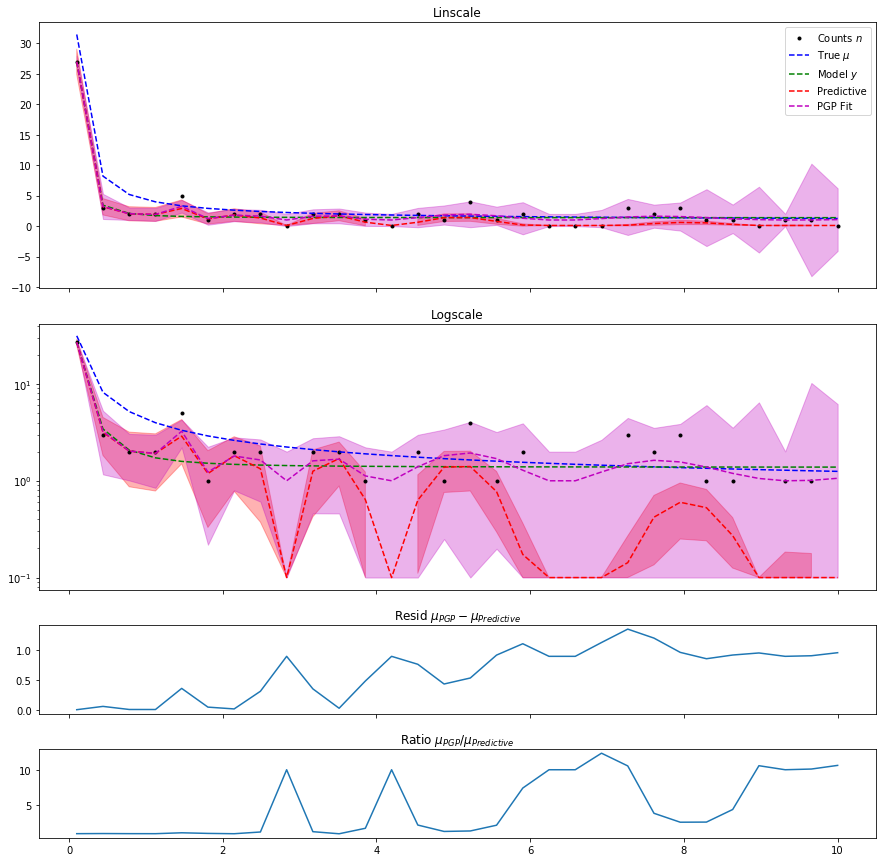

In [6]:
#sanitize lowbound for logscale plotting
from matplotlib import gridspec
PGP_low = PGP_fit-PGP_fit_unc
pred_low = pred-pred_unc
pred_safe = pred
pred_limit = pred
lowbound = 1e-1

sanitize = [PGP_low,pred_low, pred_limit]
for y in sanitize:
    for i in range(N):
        if y[i]<lowbound:
            y[i] = lowbound
   

#plotting results
PGP_fill = (PGP_fit + PGP_fit_unc, PGP_fit - PGP_fit_unc)
PGP_fill_log =  (PGP_fit + PGP_fit_unc, PGP_low)
pred_fill = (pred + pred_unc, pred - pred_unc)
pred_fill_log = (pred + pred_unc, pred_low)

plot = [n_test, mu_test, model_test, pred_limit, PGP_fit]
fmt = ['k.', 'b--', 'g--', 'r--', 'm--']
fill = [None, None, None, 'r',  'm']
labels = ["Counts $n$", "True $\mu$", "Model $y$", "Predictive", "PGP Fit"]
fill_bounds = [None, None, None, pred_fill,PGP_fill]
fill_bounds_log = [None, None, None, pred_fill_log, PGP_fill_log]



fig, ax = plt.subplots(nrows = 4, ncols = 1, sharex=True, gridspec_kw={'height_ratios': [3, 3, 1,1]}, figsize=(15,15))
for i in range(len(plot)):
    ax[0].plot(t, plot[i], fmt[i], label = labels[i])
    ax[1].set_yscale('log')
    ax[1].plot(t, plot[i], fmt[i], label = labels[i])
    if fill[i]!=None:
        ax[0].fill_between(t, fill_bounds[i][0], fill_bounds[i][1], color=fill[i], alpha=0.3, edgecolor='none')
        ax[1].fill_between(t, fill_bounds_log[i][0], fill_bounds_log[i][1], color=fill[i], alpha=0.3, edgecolor='none')

ax[2].plot(t, np.abs(PGP_fit-pred), label = "Residual")
ax[3].plot(t, np.abs(PGP_fit/pred), label = "Ratio?")
ax[0].legend(loc="upper right")

ax[0].set_title("Linscale")
ax[1].set_title("Logscale")
ax[2].set_title("Resid $\mu_{PGP} - \mu_{Predictive}$")
ax[3].set_title("Ratio $\mu_{PGP}/\mu_{Predictive}$")

plt.show()

In [7]:
print PGP_fit_unc

[1.00004791 2.06223799 1.02065036 1.07080077 1.03509085 1.01296686
 1.00738217 1.0319967  1.         1.14653433 1.21364272 1.09304195
 1.         1.58790871 1.5680576  2.12457889 1.49569309 2.63744968
 1.         1.         1.42158682 2.96001342 1.89300312 2.30475393
 4.67000029 2.34236893 5.40449795 1.01001373 9.24415072 5.14394001]
